In [ ]:
%pip install -q gseapy


In [8]:
# ============================================
# PLS-BASED AGE MODEL + (3)(4)(5)(7)(8) + nicer age-count PDFs
# ============================================

import os, warnings, gc
warnings.filterwarnings("ignore")

import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
from scipy import stats

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.cross_decomposition import PLSRegression
from sklearn.linear_model import Ridge

from statsmodels.stats.multitest import multipletests
from scipy.stats import kendalltau

# -------------------------
# Config
# -------------------------
H5AD_FOLDER   = "/mnt/data/melhajjar/tabula_muris/all_tissues/"
OUTPUT_FOLDER = "/mnt/data/melhajjar/tabula_muris/all_tissues/scanvi_age_features_regression_model_final5_test2final_PLS_no1m_pres_finalcopytestinggg"
os.makedirs(OUTPUT_FOLDER, exist_ok=True)

CELLTYPES_OF_INTEREST = [
    "alveolar macrophage", "macrophage", "monocyte", "classical monocyte",
    "intermediate monocyte", "non-classical monocyte", "Kupffer cell", "lung macrophage",
    "macrophage dendritic cell progenitor"
]

# Knobs
N_TOP_HVG          = 2000
N_COMPONENTS_MAX   = 20
TOP_AGE_COMPS      = 5
N_PLOT_GENES       = 50
TOP_LINES          = 8
FIG_DPI            = 300
RANDOM_SEED        = 0

# Stability selection
STAB_N_RUNS        = 25
STAB_SAMPLE_FRAC   = 0.8
STAB_MIN_FREQ      = 0.3
W_QUANTILE         = 0.75
S_QUANTILE         = 0.50

# Scatter point size (bigger)
SCATTER_POINT_SIZE = 56

rng = np.random.RandomState(RANDOM_SEED)

# -------------------------
# Small helpers
# -------------------------
def order_ages_numeric(age_series: pd.Series):
    def to_num(a):
        s = str(a).strip().lower()
        if s.endswith("m") and s[:-1].isdigit(): return int(s[:-1])
        if s.isdigit(): return int(s)
        return np.nan
    labels = list(pd.unique(age_series.astype(str)))
    nums = [to_num(a) for a in labels]
    if all([not np.isnan(x) for x in nums]):
        return [x for _, x in sorted(zip(nums, labels), key=lambda t: t[0])]
    return labels

def numeric_age_array(age_labels):
    def to_num(a):
        s = str(a).strip().lower()
        if s.endswith("m") and s[:-1].isdigit(): return int(s[:-1])
        if s.isdigit(): return int(s)
        return np.nan
    return np.array([to_num(a) for a in age_labels], dtype=float)

def cohen_d(a, b):
    a, b = np.asarray(a, dtype=float), np.asarray(b, dtype=float)
    na, nb = len(a), len(b)
    sa, sb = np.nanstd(a, ddof=1), np.nanstd(b, ddof=1)
    s_p = np.sqrt(((na-1)*sa**2 + (nb-1)*sb**2) / (na + nb - 2))
    if s_p == 0 or np.isnan(s_p): return np.nan
    return (np.nanmean(a) - np.nanmean(b)) / s_p

# -------------------------
# Plotting helpers (unchanged elsewhere)
# -------------------------
def plot_component_heatmap(CxG: pd.DataFrame, title: str, out_png: str, vmin=None, vmax=None):
    n_c, n_g = CxG.shape
    fig_w = max(6, min(20, n_g * 0.4)); fig_h = max(4, min(18, n_c * 0.5))
    fig, ax = plt.subplots(figsize=(fig_w, fig_h))
    im = ax.imshow(
        CxG.values, aspect="auto", interpolation="nearest",
        cmap="coolwarm", norm=TwoSlopeNorm(vcenter=0.0, vmin=vmin, vmax=vmax)
    )
    ax.set_xticks(np.arange(n_g)); ax.set_xticklabels(CxG.columns, rotation=90, fontsize=7)
    ax.set_yticks(np.arange(n_c)); ax.set_yticklabels(CxG.index, fontsize=9)
    ax.set_xlabel("Genes"); ax.set_ylabel("PLS component"); ax.set_title(title, fontsize=12)
    cbar = plt.colorbar(im, ax=ax); cbar.set_label("Component weight", rotation=270, labelpad=12)
    ax.set_xticks(np.arange(-.5, n_g, 1), minor=True); ax.set_yticks(np.arange(-.5, n_c, 1), minor=True)
    ax.grid(which="minor", linestyle="-", linewidth=0.25, alpha=0.25)
    ax.tick_params(which="minor", bottom=False, left=False)
    plt.tight_layout()
    plt.savefig(out_png, dpi=FIG_DPI, bbox_inches="tight", pad_inches=0.15)
    plt.close(fig)

def heatmap(data, row_labels, col_labels, ax=None, cbar_kw=None, cbarlabel="", **imshow_kwargs):
    if ax is None: ax = plt.gca()
    if cbar_kw is None: cbar_kw = {}
    im = ax.imshow(data, **imshow_kwargs)
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")
    ax.set_xticks(range(data.shape[1]), labels=col_labels, rotation=-30, ha="right", rotation_mode="anchor")
    ax.set_yticks(range(data.shape[0]), labels=row_labels)
    ax.tick_params(top=True, bottom=False, labeltop=True, labelbottom=False)
    ax.spines[:].set_visible(False)
    ax.set_xticks(np.arange(data.shape[1] + 1) - .5, minor=True)
    ax.set_yticks(np.arange(data.shape[0] + 1) - .5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=2)
    ax.tick_params(which="minor", bottom=False, left=False)
    return im, cbar

def plot_expr_heatmap_helper(expr_df, title, out_png, zscore=True,
                             cmap="YlGn", title_fs=18, label_fs=16, tick_fs=11):
    M = expr_df.values.copy()
    if zscore:
        mu = np.nanmean(M, axis=1, keepdims=True)
        sd = np.nanstd(M, axis=1, keepdims=True); sd[sd == 0] = 1.0
        M = (M - mu) / sd
    n_genes, n_ages = M.shape
    fig_w = max(6, min(18, n_ages * 0.9)); fig_h = max(6, min(24, n_genes * 0.45))
    fig, ax = plt.subplots(figsize=(fig_w, fig_h))
    im, cbar = heatmap(
        M, row_labels=list(expr_df.index), col_labels=list(expr_df.columns),
        ax=ax, cmap=cmap, cbarlabel=("Row Z-score" if zscore else "Mean log1p expr"),
        aspect="auto", interpolation="nearest"
    )
    ax.set_xlabel("Age", fontsize=label_fs, labelpad=12)
    ax.set_ylabel("Genes", fontsize=label_fs, labelpad=12)
    ax.set_title(title, fontsize=title_fs)
    ax.tick_params(axis="x", labelsize=tick_fs)
    ax.tick_params(axis="y", labelsize=max(8, tick_fs - 1))
    plt.tight_layout()
    plt.savefig(out_png, dpi=300, bbox_inches="tight", pad_inches=0.15)
    plt.close(fig)

def plot_expr_lines(expr_df: pd.DataFrame, title: str, out_png: str, top_n=8):
    if expr_df.shape[0] == 0: return
    if expr_df.shape[0] > top_n:
        var = expr_df.var(axis=1); expr_df = expr_df.loc[var.sort_values(ascending=False).head(top_n).index]
    ages = list(expr_df.columns)
    def to_num(a):
        s = str(a).strip().lower()
        if s.endswith("m") and s[:-1].isdigit(): return int(s[:-1])
        if s.isdigit(): return int(s)
        return np.nan
    xnum = [to_num(a) for a in ages]
    x = np.arange(len(ages)) if any(np.isnan(x) for x in xnum) else np.array(xnum)
    fig, ax = plt.subplots(figsize=(10, 6))
    for gene, row in expr_df.iterrows():
        ax.plot(x, row.values, marker="o", linewidth=3.0, label=gene)
    ax.spines["top"].set_visible(False); ax.spines["right"].set_visible(False)
    ax.set_xticks(x); ax.set_xticklabels(ages, rotation=0)
    ax.set_xlabel("Age"); ax.set_ylabel("Mean log1p expression"); ax.set_title(title)
    ax.legend(loc="upper left", bbox_to_anchor=(1.02, 1), fontsize=8, ncol=1)
    plt.tight_layout()
    plt.savefig(out_png, dpi=FIG_DPI, bbox_inches="tight", pad_inches=0.15)
    plt.close(fig)

def plot_loading_vs_corr_scatter(
    gene_perf_df,
    x_col="component_maxabs_loading",
    y_col="spearman_age",
    title="Genes: |PLS weight| vs |Spearman(age)|",
    out_path="gene_scatter_weight_vs_corr.pdf",
    top_labels=12,
    annotate_by="xyprod",
    point_alpha=0.9,
    point_size=SCATTER_POINT_SIZE,
    dpi=300
):
    x_raw = gene_perf_df[x_col].astype(float).abs().to_numpy()
    y_signed = gene_perf_df[y_col].astype(float).to_numpy()
    y_abs = np.abs(y_signed)
    genes = gene_perf_df["gene"].astype(str).to_numpy()

    pos_mask = y_signed >= 0
    colors = np.where(pos_mask, "#2875d8", "#d84545")

    fig = plt.figure(figsize=(8.6, 6.2), dpi=dpi, constrained_layout=True)
    ax = fig.add_subplot(111)
    ax.scatter(x_raw, y_abs, s=point_size, alpha=point_alpha,
               linewidths=0.6, edgecolors="white", c=colors)
    ax.scatter([], [], c="#2875d8", s=point_size, label="↑ with age (Spearman ≥ 0)")
    ax.scatter([], [], c="#d84545", s=point_size, label="↓ with age (Spearman < 0)")
    ax.legend(frameon=False, loc="lower right", fontsize=9)

    def _q(a):
        lo, hi = np.nanpercentile(a, [1, 99])
        pad = 0.04 * (hi - lo if hi > lo else (np.nanmax(a) - np.nanmin(a) + 1e-9))
        return lo - pad, hi + pad

    xlo, xhi = _q(x_raw); ylo, yhi = _q(y_abs)
    ax.set_xlim(xlo, xhi); ax.set_ylim(ylo, yhi)

    m = np.isfinite(x_raw) & np.isfinite(y_abs)
    if m.sum() >= 3:
        slope, intercept, r, p, _ = stats.linregress(x_raw[m], y_abs[m])
        xx = np.linspace(xlo, xhi, 200)
        ax.plot(xx, slope*xx + intercept, linewidth=2.0, alpha=0.95, color="#444")
        ax.text(0.02, 0.98, f"$r$ = {r:.2f}, $p$ = {p:.1g}",
                transform=ax.transAxes, ha="left", va="top", fontsize=11)

    if m.sum() >= 10:
        for q, ls in zip(np.quantile(y_abs[m], [0.25, 0.5, 0.75]), [":", "--", ":"]):
            if ylo < q < yhi:
                ax.axhline(q, color="gray", lw=1.0, ls=ls, alpha=0.6)

    if top_labels and top_labels > 0:
        score = x_raw * y_abs if annotate_by == "xyprod" else (x_raw if annotate_by == "x" else y_abs)
        order = np.argsort(score)[::-1][:top_labels]
        for k, i in enumerate(order):
            dx = 0.01 * (1 + (k % 3)) * (xhi - xlo)
            dy = 0.01 * (1 + ((k+1) % 3)) * (yhi - ylo)
            tx = np.clip(x_raw[i] + dx, xlo + 0.005*(xhi-xlo), xhi - 0.005*(xhi-xlo))
            ty = np.clip(y_abs[i] + dy, ylo + 0.005*(yhi-ylo), yhi - 0.005*(yhi-ylo))
            ax.text(tx, ty, genes[i], fontsize=9, ha="left", va="bottom",
                    bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="none", alpha=0.9),
                    clip_on=False)

    ax.set_xlabel("|PLS weight (best age component)|", fontsize=12, labelpad=8)
    ax.set_ylabel("|Spearman corr with continuous age| (ALL)", fontsize=12, labelpad=8)
    ax.set_title(title, fontsize=13, pad=10)
    ax.spines["top"].set_visible(False); ax.spines["right"].set_visible(False)
    ax.grid(True, which="major", linestyle=":", linewidth=0.8, alpha=0.5)
    ax.tick_params(axis="both", labelsize=11)
    plt.savefig(out_path, dpi=dpi, bbox_inches="tight", pad_inches=0.15)
    plt.close(fig)

# -------------------------
# Nicer age distribution plots (PDF)
# -------------------------
def _save_pdf_and_png(base_path_no_ext):
    pdf = base_path_no_ext + ".pdf"
    png = base_path_no_ext + ".png"
    plt.savefig(pdf, dpi=300, bbox_inches="tight", pad_inches=0.15)
    plt.savefig(png, dpi=200, bbox_inches="tight", pad_inches=0.10)

def plot_age_counts_raw(age_strs, base_out_no_ext, title):
    """
    Bar chart of counts per raw age label (e.g., 3m, 12m, 24m), sorted numerically.
    Saves <base>.(pdf|png)
    """
    vals, cnts = np.unique(age_strs.astype(str), return_counts=True)
    order = [a for a in order_ages_numeric(pd.Series(vals))]
    order_idx = [list(vals).index(a) for a in order]
    vals = vals[order_idx]; cnts = cnts[order_idx]
    total = cnts.sum()

    fig, ax = plt.subplots(figsize=(7.2, 4.0))
    bars = ax.bar(vals, cnts, width=0.7, color="#4C78A8", edgecolor="white", linewidth=0.6)
    ax.set_ylabel("Number of Cells", fontsize=11)
    # ax.set_title(title, fontsize=12)
    ax.set_axisbelow(True)
    ax.yaxis.grid(True, linestyle=":", alpha=0.6)
    ax.spines["top"].set_visible(False); ax.spines["right"].set_visible(False)

    # Annotate counts and % on top of bars
    for b, c in zip(bars, cnts):
        pct = 100.0 * c / total if total > 0 else 0.0
        ax.text(b.get_x() + b.get_width()/2, b.get_height() + max(total*0.01, 1),
                f"{c}\n({pct:.1f}%)",
                ha="center", va="bottom", fontsize=9)

    plt.xticks(vals, vals, rotation=0)
    plt.tight_layout()
    _save_pdf_and_png(base_out_no_ext)
    plt.close()

def plot_age_counts_bins(num_age, base_out_no_ext, title):
    """
    Bar chart of counts per tertile group (young/middle/old), with counts and % labels.
    Saves <base>.(pdf|png)
    """
    qs = np.quantile(num_age, [1/3, 2/3])
    labels = np.array(["young" if a <= qs[0] else ("middle" if a <= qs[1] else "old") for a in num_age])
    cats = ["young", "middle", "old"]
    counts = np.array([np.sum(labels == c) for c in cats], dtype=int)
    total = counts.sum()

    fig, ax = plt.subplots(figsize=(5.6, 3.8))
    bars = ax.bar(cats, counts, color="#72B7B2", edgecolor="white", linewidth=0.6)
    ax.set_ylabel("# cells", fontsize=11)
    ax.set_title(title, fontsize=12)
    ax.set_axisbelow(True)
    ax.yaxis.grid(True, linestyle=":", alpha=0.6)
    ax.spines["top"].set_visible(False); ax.spines["right"].set_visible(False)

    for b, c in zip(bars, counts):
        pct = 100.0 * c / total if total > 0 else 0.0
        ax.text(b.get_x() + b.get_width()/2, b.get_height() + max(total*0.01, 1),
                f"{c}\n({pct:.1f}%)",
                ha="center", va="bottom", fontsize=9)

    plt.tight_layout()
    _save_pdf_and_png(base_out_no_ext)
    plt.close()

# -------------------------
# CV helpers, Kendall+FDR, etc. (unchanged)
# -------------------------
def stratified_folds_by_age(num_age, n_splits=5, seed=0):
    qs = np.quantile(num_age, [1/3, 2/3])
    bins = np.digitize(num_age, bins=qs, right=True)  # 0,1,2
    unique_bins = np.unique(bins)
    k = min(n_splits, len(unique_bins))
    k = max(k, 2)
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=seed)
    return list(skf.split(np.zeros_like(num_age), bins)), bins

def cv_r2_pls(Xz, y, folds, n_comp):
    pls_cv = PLSRegression(n_components=n_comp)
    scores = []
    for tr, te in folds:
        pls_cv.fit(Xz[tr], y[tr])
        yhat = pls_cv.predict(Xz[te]).ravel()
        ss_res = np.sum((y[te]-yhat)**2)
        ss_tot = np.sum((y[te]-np.mean(y[tr]))**2)
        scores.append(1 - ss_res/ss_tot if ss_tot>0 else np.nan)
    return float(np.nanmean(scores))

def perm_test_r2(Xz, y, folds, n_comp, n_perm=200, seed=0):
    rng = np.random.RandomState(seed)
    obs = cv_r2_pls(Xz, y, folds, n_comp)
    null = []
    for _ in range(n_perm):
        yperm = rng.permutation(y)
        null.append(cv_r2_pls(Xz, yperm, folds, n_comp))
    p = (1 + np.sum(np.array(null) >= obs)) / (1 + len(null))
    return obs, float(p)

def ridge_cv_r2(Xz, y, folds, alpha=1.0):
    scores = []
    for tr, te in folds:
        rr = Ridge(alpha=alpha)
        rr.fit(Xz[tr], y[tr])
        yhat = rr.predict(Xz[te])
        ss_res = np.sum((y[te]-yhat)**2)
        ss_tot = np.sum((y[te]-np.mean(y[tr]))**2)
        scores.append(1 - ss_res/ss_tot if ss_tot>0 else np.nan)
    return float(np.nanmean(scores))

def gene_age_kendall_fdr(X_mat, y, genes):
    taus, pvals = [], []
    for j in range(X_mat.shape[1]):
        t, p = kendalltau(y, X_mat[:, j], nan_policy="omit")
        taus.append(t); pvals.append(p)
    taus = np.array(taus); pvals = np.array(pvals)
    ok, p_adj, _, _ = multipletests(pvals, alpha=0.05, method="fdr_bh")
    out = pd.DataFrame({"gene": genes, "kendall_tau": taus, "p_adj": p_adj, "pass_fdr": ok})
    return out.set_index("gene")

# -------------------------
# Main
# -------------------------
rows = []

for file in os.listdir(H5AD_FOLDER):
    if not file.endswith(".h5ad"): continue
    tissue = file.replace(".h5ad", "")
    if tissue.lower() == "trachea": continue

    print(f"\n🧬 Processing tissue: {tissue}")
    adata = sc.read_h5ad(os.path.join(H5AD_FOLDER, file))

    # Optional: male-only
    if "sex" in adata.obs.columns:
        adata = adata[adata.obs["sex"] != "female"].copy()

    if "cell_ontology_class" not in adata.obs.columns:
        print("    ⚠️ Missing 'cell_ontology_class' in .obs, skipping file.")
        continue

    for celltype in adata.obs["cell_ontology_class"].unique():
        if celltype not in CELLTYPES_OF_INTEREST: continue

        print(f"  🔍 Cell type: {celltype}")
        adata_ct = adata[adata.obs["cell_ontology_class"] == celltype].copy()
        adata_ct = adata_ct[adata_ct.obs["age"] != "1m"].copy()
        if adata_ct.n_obs < 50 or len(adata_ct.obs["age"].unique()) < 2:
            print("    ⚠️ Skipping due to low cell count or one age group.")
            continue

        # ---------- Preprocess ----------
        sc.pp.filter_genes(adata_ct, min_counts=3)
        sc.pp.normalize_total(adata_ct, target_sum=1e4)
        sc.pp.log1p(adata_ct)
        sc.pp.highly_variable_genes(adata_ct, n_top_genes=N_TOP_HVG, flavor="seurat_v3")
        if "highly_variable" in adata_ct.var and adata_ct.var["highly_variable"].sum() > 0:
            adata_ct = adata_ct[:, adata_ct.var["highly_variable"]].copy()
        else:
            print("    ⚠️ No HVGs found — proceeding with all genes.")

        # ---------- Age labels ----------
        adata_ct.obs["age"] = adata_ct.obs["age"].astype(str)
        num_age = numeric_age_array(adata_ct.obs["age"].values)
        valid_idx = ~np.isnan(num_age)
        if valid_idx.sum() < 10 or np.unique(num_age[valid_idx]).size < 2:
            print("    ⚠️ Not enough numeric age signal; skipping.")
            continue
        adata_ct = adata_ct[valid_idx].copy()
        num_age = num_age[valid_idx]

        # --- NEW: prettier PDFs for group breakdowns ---
        plot_age_counts_raw(
            adata_ct.obs["age"].values,
            os.path.join(OUTPUT_FOLDER, f"{tissue}_{celltype}_age_counts_raw"),
            f"{tissue} – {celltype}: cells per raw age"
        )
        plot_age_counts_bins(
            num_age,
            os.path.join(OUTPUT_FOLDER, f"{tissue}_{celltype}_age_counts_bins"),
            f"{tissue} – {celltype}: cells per tertile group"
        )

        # ---------- Matrix + standardization ----------
        X = adata_ct.X
        if hasattr(X, "toarray"): X = X.toarray()
        X = np.asarray(X, dtype=float)
        scaler = StandardScaler(with_mean=True, with_std=True)
        Xz = scaler.fit_transform(X)

        # ---------- Choose n_components via stratified CV ----------
        folds, age_bins = stratified_folds_by_age(num_age, n_splits=5, seed=RANDOM_SEED)
        k_max = min(N_COMPONENTS_MAX, Xz.shape[1], Xz.shape[0]-1)
        cand = list(range(2, max(3, k_max)+1))
        cv_scan = {k: cv_r2_pls(Xz, num_age, folds, k) for k in cand}
        pd.Series(cv_scan).to_csv(os.path.join(OUTPUT_FOLDER, f"{tissue}_{celltype}_cv_ncomp_scan.csv"))
        n_comp = max(cv_scan, key=cv_scan.get)

        # ---------- Final PLS fit ----------
        pls = PLSRegression(n_components=n_comp)
        pls.fit(Xz, num_age)
        scores = pls.transform(Xz)
        pred_age = pls.predict(Xz).ravel()
        spearman_r = float(pd.Series(pred_age).corr(pd.Series(num_age), method="spearman"))

        comp_spearman = np.array([abs(pd.Series(scores[:, i]).corr(pd.Series(num_age), method="spearman"))
                                  for i in range(scores.shape[1])])
        idx_top = np.argsort(comp_spearman)[::-1][:min(TOP_AGE_COMPS, len(comp_spearman))]
        age_components = [f"comp_{i}" for i in idx_top]
        pd.Series(comp_spearman, index=[f"comp_{i}" for i in range(scores.shape[1])]) \
          .sort_values(ascending=False) \
          .to_csv(os.path.join(OUTPUT_FOLDER, f"{tissue}_{celltype}_component_age_importance.csv"))

        # Silhouette using all scores on tertile labels
        try:
            le = LabelEncoder()
            y_binned = le.fit_transform(age_bins)
            from sklearn.metrics import silhouette_score
            sil = silhouette_score(scores, y_binned)
        except Exception:
            sil = np.nan

        # ---------- Stability selection ----------
        genes = adata_ct.var_names.to_list()
        appear_counts = pd.Series(0, index=genes, dtype=int)
        mean_weight = pd.Series(0.0, index=genes, dtype=float)
        mean_spear  = pd.Series(0.0, index=genes, dtype=float)

        n_cells = Xz.shape[0]
        n_sample = max(20, int(STAB_SAMPLE_FRAC * n_cells))

        for run in range(STAB_N_RUNS):
            idx_cells = rng.choice(n_cells, size=n_sample, replace=False)
            Xr, yr = Xz[idx_cells], num_age[idx_cells]
            k_max_r = min(N_COMPONENTS_MAX, Xr.shape[1], Xr.shape[0]-1)
            k_r = max(2, min(n_comp, k_max_r))
            pls_r = PLSRegression(n_components=k_r)
            pls_r.fit(Xr, yr)
            scores_r = pls_r.transform(Xr)

            comp_r = np.array([abs(pd.Series(scores_r[:, i]).corr(pd.Series(yr), method="spearman"))
                               for i in range(scores_r.shape[1])])
            best_idx_r = int(np.nanargmax(comp_r))

            w = pd.Series(np.abs(pls_r.x_weights_[:, best_idx_r]), index=genes)

            Xr_raw = X[idx_cells]
            spear_vals = []
            for j in range(Xr_raw.shape[1]):
                with warnings.catch_warnings():
                    warnings.simplefilter("ignore", category=RuntimeWarning)
                    sp = pd.Series(Xr_raw[:, j]).corr(pd.Series(yr), method="spearman")
                spear_vals.append(abs(sp) if sp is not None else np.nan)
            s = pd.Series(spear_vals, index=genes).fillna(0.0)

            w_thr = w.quantile(W_QUANTILE)
            s_thr = s.quantile(S_QUANTILE)
            sel = (w >= w_thr) & (s >= s_thr)
            appear_counts[sel] += 1
            mean_weight += w
            mean_spear  += s

            del pls_r, scores_r, Xr, yr, w, s, Xr_raw
            gc.collect()

        mean_weight /= STAB_N_RUNS
        mean_spear  /= STAB_N_RUNS
        freq = appear_counts / STAB_N_RUNS

        gene_strengths = pd.DataFrame({
            "stability_freq": freq,
            "mean_abs_pls_weight": mean_weight,
            "mean_abs_spearman_age": mean_spear
        })
        gene_strengths["combined_score"] = gene_strengths["mean_abs_pls_weight"] * gene_strengths["mean_abs_spearman_age"]
        gene_strengths.sort_values(["stability_freq", "combined_score"], ascending=[False, False], inplace=True)
        audit_path = os.path.join(OUTPUT_FOLDER, f"{tissue}_{celltype}_PLS_gene_strengths_full.csv")
        gene_strengths.to_csv(audit_path)

        # ---------- Gate by monotonicity (Kendall τ) + FDR ----------
        Xall_small = adata_ct[:, adata_ct.var_names].X
        if hasattr(Xall_small, "toarray"): Xall_small = Xall_small.toarray()
        ktab = gene_age_kendall_fdr(Xall_small, num_age, adata_ct.var_names.tolist())

        stable = gene_strengths.join(ktab, how="left")
        stable = stable[(stable["pass_fdr"] == True) & stable["kendall_tau"].notna()]
        if stable.empty:
            stable = gene_strengths
        age_driver_genes = stable.sort_values(["combined_score","kendall_tau"], ascending=False) \
                                 .head(N_PLOT_GENES).index.tolist()

        pd.Series(age_driver_genes, name="gene").to_csv(
            os.path.join(OUTPUT_FOLDER, f"{tissue}_{celltype}_age_driver_genes_top{N_PLOT_GENES}.csv"),
            index=False
        )

        # ---------- Heatmap of weights ----------
        best_idx_global = int(np.nanargmax(comp_spearman))
        weights_df_full = pd.DataFrame(pls.x_weights_, index=adata_ct.var_names,
                                       columns=[f"comp_{i}" for i in range(pls.x_weights_.shape[1])])
        age_loading_sub = weights_df_full.iloc[:, [best_idx_global]]
        CxG = age_loading_sub.loc[age_driver_genes].T
        vmax = float(np.nanpercentile(np.abs(CxG.values), 99)) if CxG.size else None
        vmin = -vmax if vmax is not None else None
        plot_component_heatmap(
            CxG,
            title=f"{tissue} – {celltype} – PLS weights (best age comp; filtered top {N_PLOT_GENES})",
            out_png=os.path.join(OUTPUT_FOLDER, f"{tissue}_{celltype}_PLS_WEIGHTS_bestComp_AGEtop{N_PLOT_GENES}_heatmap.pdf"),
            vmin=vmin, vmax=vmax
        )

        # ---------- Expression vs age ----------
        ages_order = order_ages_numeric(pd.Series(adata_ct.obs["age"]))
        ages_order = [a for a in ages_order if a in list(adata_ct.obs["age"].unique())]
        selected_genes = [g for g in age_driver_genes if g in adata_ct.var_names]

        expr_means = []
        for age in ages_order:
            idx_age = (adata_ct.obs["age"] == str(age))
            subX = adata_ct[idx_age, selected_genes].X
            if hasattr(subX, "toarray"): subX = subX.toarray()
            expr_means.append(pd.Series(np.asarray(subX).mean(axis=0), index=selected_genes, name=str(age)))
        expr_df = pd.DataFrame(expr_means).T
        expr_df.to_csv(os.path.join(OUTPUT_FOLDER, f"{tissue}_{celltype}_ALL_mean_expression_AGEtop{N_PLOT_GENES}_genes_x_age.csv"))

        plot_expr_heatmap_helper(
            expr_df.loc[selected_genes, ages_order],
            title=f"{tissue} – {celltype} – Mean expression across ages (filtered top {N_PLOT_GENES})",
            out_png=os.path.join(OUTPUT_FOLDER, f"{tissue}_{celltype}_ALL_expr_heatmap_FILTERED_AGEtop{N_PLOT_GENES}_genes_x_age.pdf"),
            zscore=True, cmap="YlGn", title_fs=18, label_fs=16, tick_fs=11
        )
        plot_expr_lines(
            expr_df.loc[selected_genes, ages_order],
            title=f"{tissue} – {celltype} – Expression vs age (top {min(TOP_LINES, len(selected_genes))} variable)",
            out_png=os.path.join(OUTPUT_FOLDER, f"{tissue}_{celltype}_ALL_expr_lines_FILTERED_AGEtop{TOP_LINES}.pdf"),
            top_n=TOP_LINES
        )

        # ---------- Gene-level stats + scatter ----------
        age_labels = adata_ct.obs["age"].astype(str).values
        uniq_ages = pd.Index(np.unique(age_labels)).astype(str).tolist()
        uniq_nums = numeric_age_array(uniq_ages)
        youngest = uniq_ages[int(np.nanargmin(uniq_nums))] if np.all(~np.isnan(uniq_nums)) else uniq_ages[0]
        oldest   = uniq_ages[int(np.nanargmax(uniq_nums))] if np.all(~np.isnan(uniq_nums)) else uniq_ages[-1]

        Xall = adata_ct[:, selected_genes].X
        if hasattr(Xall, "toarray"): Xall = Xall.toarray()
        maxabs_weight = age_loading_sub.abs().iloc[:, 0].to_dict()
        gene_rows = []
        for j, g in enumerate(selected_genes):
            gx = np.asarray(Xall[:, j], dtype=float)
            with warnings.catch_warnings():
                warnings.simplefilter("ignore", category=RuntimeWarning)
                sp = pd.Series(gx).corr(pd.Series(num_age), method="spearman")
                pe = pd.Series(gx).corr(pd.Series(num_age), method="pearson")
            d = cohen_d(gx[age_labels == youngest], gx[age_labels == oldest])
            gene_rows.append({
                "gene": g,
                "spearman_age": sp,
                "pearson_age": pe,
                "cohen_d_young_vs_old": d,
                "component_maxabs_loading": float(maxabs_weight.get(g, np.nan))
            })
        gene_perf_df = pd.DataFrame(gene_rows).sort_values("spearman_age", key=lambda s: s.abs(), ascending=False)
        gene_perf_df.to_csv(os.path.join(OUTPUT_FOLDER, f"{tissue}_{celltype}_gene_performance_ALL.csv"), index=False)

        plot_loading_vs_corr_scatter(
            gene_perf_df,
            title=f"{tissue} – {celltype} – Genes: |PLS weight (best comp)| vs age-correlation",
            out_path=os.path.join(OUTPUT_FOLDER, f"{tissue}_{celltype}_gene_scatter_weightBEST_vs_corr.pdf"),
        )

        # ---------- Ridge baseline & permutation test ----------
        ridge_r2 = ridge_cv_r2(Xz, num_age, folds, alpha=1.0)
        r2_mean_cv, r2_perm_p = perm_test_r2(Xz, num_age, folds, n_comp, n_perm=200, seed=RANDOM_SEED)

        # ---------- QC markdown ----------
        qc_md = os.path.join(OUTPUT_FOLDER, f"{tissue}_{celltype}_QC.md")
        with open(qc_md, "w") as f:
            f.write(f"# {tissue} – {celltype}\n")
            f.write(f"- n_cells: {adata_ct.n_obs}\n")
            f.write(f"- n_genes_used: {adata_ct.n_vars}\n")
            f.write(f"- best_n_components: {n_comp}\n")
            f.write(f"- CV R2 (PLS): {r2_mean_cv:.3f} (perm p={r2_perm_p:.3g})\n")
            f.write(f"- CV R2 (Ridge baseline): {ridge_r2:.3f}\n")
            f.write(f"- Spearman in-sample (PLS fit on all): {spearman_r:.3f}\n")
            f.write(f"- Silhouette (age tertiles on scores): {sil:.3f}\n")
            f.write(f"- Top age components (by |Spearman|): {', '.join(age_components)}\n")
            f.write(f"- Figures saved: "
                    f"age_counts_raw.pdf/png, age_counts_bins.pdf/png, "
                    f"PLS_WEIGHTS_bestComp_AGEtop{N_PLOT_GENES}_heatmap.pdf, "
                    f"ALL_expr_heatmap_FILTERED_AGEtop{N_PLOT_GENES}_genes_x_age.pdf, "
                    f"ALL_expr_lines_FILTERED_AGEtop{TOP_LINES}.pdf, "
                    f"gene_scatter_weightBEST_vs_corr.pdf\n")
            f.write(f"- Top genes (head): {', '.join(age_driver_genes[:10])}\n")

        rows.append({
            "tissue": tissue,
            "celltype": celltype,
            "n_cells": adata_ct.n_obs,
            "n_genes_used": adata_ct.n_vars,
            "best_n_components": n_comp,
            "cv_r2_pls": r2_mean_cv,
            "r2_perm_p": r2_perm_p,
            "ridge_r2_cv": ridge_r2,
            "spearman_age_in_sample": spearman_r,
            "silhouette_binned_age": sil,
            "top_age_components": ",".join(age_components)
        })

        del X, Xz, scores, expr_df, gene_perf_df
        gc.collect()

# ---------- Save summary ----------
summary_df = pd.DataFrame(rows)
csv_path = os.path.join(OUTPUT_FOLDER, "PLS_age_feature_summary.csv")
summary_df.to_csv(csv_path, index=False)
print(f"\n✅ Saved PLS age-feature summary: {csv_path}\n")


🧬 Processing tissue: Liver
  🔍 Cell type: Kupffer cell

🧬 Processing tissue: Large_Intestine

🧬 Processing tissue: Limb_Muscle
  🔍 Cell type: macrophage

🧬 Processing tissue: Mammary_Gland

🧬 Processing tissue: Spleen
  🔍 Cell type: macrophage
  🔍 Cell type: macrophage dendritic cell progenitor

🧬 Processing tissue: Heart_and_Aorta

🧬 Processing tissue: Bladder

🧬 Processing tissue: Pancreas

🧬 Processing tissue: Fat

🧬 Processing tissue: Lung
  🔍 Cell type: classical monocyte
  🔍 Cell type: non-classical monocyte
  🔍 Cell type: alveolar macrophage
  🔍 Cell type: lung macrophage
  🔍 Cell type: intermediate monocyte

🧬 Processing tissue: Kidney
  🔍 Cell type: macrophage

🧬 Processing tissue: Tongue

🧬 Processing tissue: Skin

🧬 Processing tissue: Thymus

✅ Saved PLS age-feature summary: /mnt/data/melhajjar/tabula_muris/all_tissues/scanvi_age_features_regression_model_final5_test2final_PLS_no1m_pres_final/PLS_age_feature_summary.csv



In [6]:
# ============================================
# PLS Regression Age Prediction (Lung only)
# - Predicted vs Actual Age scatter
# - Gene loadings (feature importance)
# - Age distribution bar chart
# - Performance metrics
# ============================================
import os, glob, gc, warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import cross_val_predict, KFold
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from scipy.stats import pearsonr

# -------------------------
# Config
# -------------------------
H5AD_FOLDER = "/mnt/data/melhajjar/tabula_muris/all_tissues/"
OUTPUT_FOLDER = "/mnt/data/melhajjar/tabula_muris/all_tissues/scanvi_age_features_regression_model_final5_test2final_PLS_no1m_pres_final"

CELLTYPES_OF_INTEREST = [
    "alveolar macrophage",
    "macrophage",
    "monocyte",
    "classical monocyte",
    "intermediate monocyte",
    "non-classical monocyte",
    "Kupffer cell",
    "lung macrophage",
    "macrophage dendritic cell progenitor"
]

# Publication-ready pastel colors for each cell type
CELLTYPE_COLORS = {
    "alveolar macrophage": "#B8D4E8",           # Soft sky blue
    "macrophage": "#FFD4A3",                     # Peach
    "monocyte": "#D4B8D8",                       # Lavender
    "classical monocyte": "#A8D8B8",             # Mint green
    "intermediate monocyte": "#FFB8C8",          # Rose pink
    "non-classical monocyte": "#D4D8B8",         # Sage
    "Kupffer cell": "#B8D8D8",                   # Powder blue
    "lung macrophage": "#FFD8B8",                # Apricot
    "macrophage dendritic cell progenitor": "#C8B8E8"  # Periwinkle
}

RANDOM_SEED = 0
N_COMPONENTS = 5  # PLS components
CV_FOLDS = 5
TOP_GENES_PLOT = 20
BAR_EDGE = "white"

np.random.seed(RANDOM_SEED)

# -------------------------
# Helpers
# -------------------------
def to_num_age(a):
    s = str(a).strip().lower()
    if s.endswith("m") and s[:-1].isdigit():
        return int(s[:-1])
    if s.isdigit():
        return int(s)
    return np.nan

def numeric_age_array(age_labels):
    return np.array([to_num_age(a) for a in age_labels], dtype=float)

def find_lung_h5ad(folder):
    exact = os.path.join(folder, "Lung.h5ad")
    if os.path.exists(exact):
        return exact, "Lung"
    cands = [f for f in os.listdir(folder) if f.lower().endswith(".h5ad") and "lung" in f.lower()]
    if not cands:
        raise FileNotFoundError("Could not find a Lung .h5ad in H5AD_FOLDER")
    path = os.path.join(folder, cands[0])
    tissue = os.path.splitext(os.path.basename(path))[0]
    return path, tissue

def load_age_driver_genes(output_dir, tissue, celltype):
    pattern = os.path.join(output_dir, f"{tissue}_{celltype}_age_driver_genes_top*.csv")
    files = sorted(glob.glob(pattern))
    if not files:
        raise FileNotFoundError(f"No age_driver_genes CSV found with pattern: {pattern}")
    df = pd.read_csv(files[-1])
    genes = df["gene"].astype(str).tolist() if "gene" in df.columns else df.iloc[:,0].astype(str).tolist()
    return genes, files[-1]

def sort_age_labels(labels):
    """Sort age labels in order: 1m, 3m, 18m, 30m"""
    age_order = {"1m": 0, "3m": 1, "18m": 2, "30m": 3}
    try:
        sorted_labels = sorted(labels, key=lambda x: age_order.get(str(x).lower(), 999))
    except:
        sorted_labels = sorted(labels)
    return sorted_labels

def plot_age_prediction_scatter(ax, y_true, y_pred, celltype, color, metrics):
    """Scatter plot of predicted vs actual age"""
    ax.scatter(y_true, y_pred, alpha=0.6, s=40, color=color, edgecolor='white', linewidth=0.5)
    
    # Add diagonal line (perfect prediction)
    min_age, max_age = y_true.min(), y_true.max()
    ax.plot([min_age, max_age], [min_age, max_age], '--', color='gray', alpha=0.7, linewidth=2)
    
    ax.set_xlabel("True Age (months)", fontsize=11)
    ax.set_ylabel("Predicted Age (months)", fontsize=11)
    ax.set_title(f"{celltype}\nAge Prediction Performance", fontsize=12, fontweight='bold')
    
    # Add metrics text box
    textstr = '\n'.join([
        f"r = {metrics['pearson_r']:.3f}",
        f"p = {metrics['pearson_p']:.2e}",
        f"R² = {metrics['r2']:.3f}",
        f"MAE = {metrics['mae']:.2f} months",
        f"RMSE = {metrics['rmse']:.2f} months"
    ])
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
    ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=9,
            verticalalignment='top', bbox=props, family='monospace')
    
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.grid(True, linestyle=':', alpha=0.3)

def plot_gene_loadings(ax, loadings_series, celltype, color, n_top=25):
    """Bar plot of top gene loadings (feature importance)"""
    top_genes = loadings_series.head(n_top).iloc[::-1]
    
    top_genes.plot.barh(ax=ax, color=color, edgecolor=BAR_EDGE, linewidth=0.4)
    ax.set_xlabel("Absolute Loading (Component 1)", fontsize=11)
    ax.set_ylabel("")
    ax.set_title(f"{celltype}\nTop {n_top} Age-Associated Genes", fontsize=12, fontweight='bold')
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.grid(axis='x', linestyle=':', alpha=0.4)

def plot_age_distribution(ax, age_str_array, celltype, color):
    """Bar chart of cell counts per age group"""
    age_sorted = sort_age_labels(np.unique(age_str_array))
    counts_dict = dict(zip(*np.unique(age_str_array, return_counts=True)))
    counts_sorted = [counts_dict.get(age, 0) for age in age_sorted]
    
    ax.bar(range(len(age_sorted)), counts_sorted, color=color, edgecolor=BAR_EDGE, linewidth=0.6)
    ax.set_xticks(range(len(age_sorted)))
    ax.set_xticklabels(age_sorted, rotation=0)
    ax.set_xlabel("Age Group", fontsize=11)
    ax.set_ylabel("Number of Cells", fontsize=11)
    ax.set_title(f"{celltype}\nAge Distribution", fontsize=12, fontweight='bold')
    
    # Add count labels on bars
    ymax = max(counts_sorted) if counts_sorted else 1
    for i, (age, count) in enumerate(zip(age_sorted, counts_sorted)):
        ax.text(i, count + 0.02*ymax, str(count), ha="center", va="bottom", fontsize=9)
    
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.grid(axis='y', linestyle=':', alpha=0.4)

def plot_residuals(ax, y_true, y_pred, celltype, color):
    """Residual plot to check for systematic bias"""
    residuals = y_pred - y_true
    ax.scatter(y_true, residuals, alpha=0.6, s=40, color=color, edgecolor='white', linewidth=0.5)
    ax.axhline(y=0, color='gray', linestyle='--', linewidth=2, alpha=0.7)
    
    ax.set_xlabel("True Age (months)", fontsize=11)
    ax.set_ylabel("Residual (Predicted - True)", fontsize=11)
    ax.set_title(f"{celltype}\nPrediction Residuals", fontsize=12, fontweight='bold')
    
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.grid(True, linestyle=':', alpha=0.3)

# -------------------------
# Load Lung and run per celltype
# -------------------------
h5ad_path, tissue = find_lung_h5ad(H5AD_FOLDER)
print(f"🫁 Using file: {h5ad_path} (tissue='{tissue}')")
adata = sc.read_h5ad(h5ad_path)

# Keep male-only if 'sex' exists
if "sex" in adata.obs.columns:
    adata = adata[adata.obs["sex"] != "female"].copy()

adata = adata[adata.obs["age"] != "1m"].copy()

if "cell_ontology_class" not in adata.obs.columns:
    raise ValueError("Missing 'cell_ontology_class' in .obs.")

celltypes_present = [ct for ct in adata.obs["cell_ontology_class"].unique() if ct in CELLTYPES_OF_INTEREST]
if not celltypes_present:
    raise RuntimeError("None of the CELLTYPES_OF_INTEREST are present in this Lung file.")

for celltype in celltypes_present:
    print(f"\n🔍 PLS Age Prediction for celltype: {celltype}")
    adata_ct = adata[adata.obs["cell_ontology_class"] == celltype].copy()
    
    if adata_ct.n_obs < 20:
        print(" ⚠️ Too few cells; skipping.")
        continue
    
    # Age labels and numeric ages
    adata_ct.obs["age"] = adata_ct.obs["age"].astype(str)
    age_str = adata_ct.obs["age"].values
    num_age = numeric_age_array(age_str)
    valid = ~np.isnan(num_age)
    adata_ct = adata_ct[valid].copy()
    age_str = adata_ct.obs["age"].values
    num_age = num_age[valid]
    
    if len(num_age) < 20:
        print(" ⚠️ Too few valid age values; skipping.")
        continue
    
    # Load PLS-selected genes
    try:
        age_driver_genes, genes_csv = load_age_driver_genes(OUTPUT_FOLDER, tissue, celltype)
    except FileNotFoundError as e:
        print(" ⚠️", e)
        continue
    
    print(f" ✓ Loaded {len(age_driver_genes)} genes from: {os.path.basename(genes_csv)}")
    
    # Slice matrix
    keep_genes = [g for g in age_driver_genes if g in adata_ct.var_names]
    if not keep_genes:
        print(" ⚠️ None of the selected genes found in var_names; skipping.")
        continue
    
    X = adata_ct[:, keep_genes].X
    if hasattr(X, "toarray"):
        X = X.toarray()
    X = np.asarray(X, dtype=float)
    y = num_age
    
    print(f" • Shape: {X.shape[0]} cells × {X.shape[1]} genes")
    print(f" • Age range: {y.min():.0f} - {y.max():.0f} months")
    
    # Get cell type color
    celltype_color = CELLTYPE_COLORS.get(celltype, "#FFB8A3")
    
    # -------------------------
    # PLS Regression with Cross-Validation
    # -------------------------
    n_components = min(N_COMPONENTS, X.shape[1], X.shape[0] - 1)
    pls = PLSRegression(n_components=n_components)
    
    # Cross-validated predictions
    cv = KFold(n_splits=CV_FOLDS, shuffle=True, random_state=RANDOM_SEED)
    y_pred_cv = cross_val_predict(pls, X, y, cv=cv)
    
    # Calculate metrics
    r, p = pearsonr(y, y_pred_cv)
    r2 = r2_score(y, y_pred_cv)
    mae = mean_absolute_error(y, y_pred_cv)
    rmse = np.sqrt(mean_squared_error(y, y_pred_cv))
    
    metrics = {
        'pearson_r': r,
        'pearson_p': p,
        'r2': r2,
        'mae': mae,
        'rmse': rmse
    }
    
    print(f" 📊 Performance: r={r:.3f} (p={p:.2e}), R²={r2:.3f}, MAE={mae:.2f}m")
    
    # Fit final model for gene loadings
    pls.fit(X, y)
    
    # Get absolute loadings from first component (most important)
    gene_loadings = np.abs(pls.x_loadings_[:, 0])
    loadings_series = pd.Series(gene_loadings, index=keep_genes).sort_values(ascending=False)
    
    # -------------------------
    # Create PDF Report
    # -------------------------
    pdf_base = f"{tissue}_{celltype}_PLS_AGE_PREDICTION"
    pdf_path = os.path.join(OUTPUT_FOLDER, pdf_base + ".pdf")
    
    with PdfPages(pdf_path) as pdf:
        # Page 1: Prediction scatter plot (large, main result)
        fig, ax = plt.subplots(figsize=(7, 6))
        plot_age_prediction_scatter(ax, y, y_pred_cv, celltype, celltype_color, metrics)
        plt.tight_layout()
        pdf.savefig(fig)
        plt.close(fig)
        
        # Page 2: Gene loadings (feature importance)
        n_plot = min(TOP_GENES_PLOT, len(loadings_series))
        fig, ax = plt.subplots(figsize=(7.5, 0.30*n_plot + 2.5))
        plot_gene_loadings(ax, loadings_series, celltype, celltype_color, n_top=n_plot)
        plt.tight_layout()
        pdf.savefig(fig)
        plt.close(fig)
        
        # Page 3: Age distribution
        fig, ax = plt.subplots(figsize=(6, 4.5))
        plot_age_distribution(ax, age_str, celltype, celltype_color)
        plt.tight_layout()
        pdf.savefig(fig)
        plt.close(fig)
        
        # Page 4: Residuals plot
        fig, ax = plt.subplots(figsize=(7, 6))
        plot_residuals(ax, y, y_pred_cv, celltype, celltype_color)
        plt.tight_layout()
        pdf.savefig(fig)
        plt.close(fig)
        
        # Page 5: Summary statistics
        fig, ax = plt.subplots(figsize=(8, 6))
        ax.axis("off")
        
        summary_text = f"""
PLS REGRESSION AGE PREDICTION REPORT
{'='*60}

Tissue: {tissue}
Cell Type: {celltype}
Number of cells: {X.shape[0]}
Number of genes: {X.shape[1]}
PLS components: {n_components}
Cross-validation folds: {CV_FOLDS}

AGE STATISTICS
{'='*60}
Age range: {y.min():.0f} - {y.max():.0f} months
Mean age: {y.mean():.1f} ± {y.std():.1f} months
Unique ages: {len(np.unique(age_str))} ({', '.join(sort_age_labels(np.unique(age_str)))})

PREDICTION PERFORMANCE
{'='*60}
Pearson correlation (r): {r:.4f}
P-value: {p:.2e}
R² score: {r2:.4f}
Mean Absolute Error: {mae:.3f} months
Root Mean Squared Error: {rmse:.3f} months

INTERPRETATION
{'='*60}
"""
        if r > 0.7:
            interpretation = "✓ STRONG prediction - genes robustly predict age"
        elif r > 0.5:
            interpretation = "○ MODERATE prediction - genes moderately predict age"
        elif r > 0.3:
            interpretation = "△ WEAK prediction - genes weakly predict age"
        else:
            interpretation = "✗ POOR prediction - genes do not predict age well"
        
        summary_text += interpretation + "\n\n"
        summary_text += f"TOP 10 AGE-ASSOCIATED GENES\n{'='*60}\n"
        for i, (gene, loading) in enumerate(loadings_series.head(10).items(), 1):
            summary_text += f"{i:2d}. {gene:30s} (loading: {loading:.4f})\n"
        
        ax.text(0.05, 0.95, summary_text, ha="left", va="top", 
                family="monospace", fontsize=9, transform=ax.transAxes)
        plt.tight_layout()
        pdf.savefig(fig)
        plt.close(fig)
    
    # -------------------------
    # Save CSV outputs
    # -------------------------
    # Predictions
    pred_df = pd.DataFrame({
        'true_age': y,
        'predicted_age': y_pred_cv,
        'residual': y_pred_cv - y,
        'age_group': age_str
    })
    pred_csv = os.path.join(OUTPUT_FOLDER, f"{tissue}_{celltype}_PLS_predictions.csv")
    pred_df.to_csv(pred_csv, index=False)
    
    # Gene loadings
    loadings_df = pd.DataFrame({
        'gene': loadings_series.index,
        'absolute_loading': loadings_series.values,
        'loading_component1': pls.x_loadings_[:, 0][loadings_series.index.get_indexer(loadings_series.index)]
    })
    loadings_csv = os.path.join(OUTPUT_FOLDER, f"{tissue}_{celltype}_PLS_gene_loadings.csv")
    loadings_df.to_csv(loadings_csv, index=False)
    
    # Metrics summary
    metrics_df = pd.DataFrame([metrics])
    metrics_df['celltype'] = celltype
    metrics_df['n_cells'] = X.shape[0]
    metrics_df['n_genes'] = X.shape[1]
    metrics_csv = os.path.join(OUTPUT_FOLDER, f"{tissue}_{celltype}_PLS_metrics.csv")
    metrics_df.to_csv(metrics_csv, index=False)
    
    print(f" ✅ PLS report saved: {pdf_path}")
    print(f" 💾 Predictions: {pred_csv}")
    print(f" 💾 Gene loadings: {loadings_csv}")
    print(f" 💾 Metrics: {metrics_csv}")
    
    del adata_ct, X, y, y_pred_cv, loadings_series
    gc.collect()

print("\n🎉 Done! All cell types processed.")

🫁 Using file: /mnt/data/melhajjar/tabula_muris/all_tissues/Lung.h5ad (tissue='Lung')

🔍 PLS Age Prediction for celltype: classical monocyte
 ⚠️ No age_driver_genes CSV found with pattern: /mnt/data/melhajjar/tabula_muris/all_tissues/scanvi_age_features_regression_model_final5_test2final_PLS_no1m_pres_final/Lung_classical monocyte_age_driver_genes_top*.csv

🔍 PLS Age Prediction for celltype: non-classical monocyte
 ⚠️ No age_driver_genes CSV found with pattern: /mnt/data/melhajjar/tabula_muris/all_tissues/scanvi_age_features_regression_model_final5_test2final_PLS_no1m_pres_final/Lung_non-classical monocyte_age_driver_genes_top*.csv

🔍 PLS Age Prediction for celltype: alveolar macrophage
 ⚠️ No age_driver_genes CSV found with pattern: /mnt/data/melhajjar/tabula_muris/all_tissues/scanvi_age_features_regression_model_final5_test2final_PLS_no1m_pres_final/Lung_alveolar macrophage_age_driver_genes_top*.csv

🔍 PLS Age Prediction for celltype: lung macrophage
 ⚠️ No age_driver_genes CSV found 

In [8]:
# ============================================
# FOLLOW-UP: RandomForest report from PLS-selected genes (Lung only, CLS)
# - Confusion matrix in % (no decimals), coolwarm
# - ROC curves in pastel colors
# - Feature importance bar color = unique per cell type
# ============================================
import os, glob, gc, warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.ticker import PercentFormatter
from itertools import cycle
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report, accuracy_score, f1_score
from sklearn.model_selection import StratifiedKFold

# -------------------------
# Config (match your PLS run)
# -------------------------
H5AD_FOLDER = "/mnt/data/melhajjar/tabula_muris/all_tissues/"
OUTPUT_FOLDER = "/mnt/data/melhajjar/tabula_muris/all_tissues/scanvi_age_features_regression_model_final5_test2final_PLS_no1m_pres_final_workingcopy"

CELLTYPES_OF_INTEREST = [
    "alveolar macrophage",
    "macrophage",
    "monocyte",
    "classical monocyte",
    "intermediate monocyte",
    "non-classical monocyte",
    "Kupffer cell",
    "lung macrophage",
    "macrophage dendritic cell progenitor"
]

# Publication-ready pastel colors for each cell type
CELLTYPE_COLORS = {
    "alveolar macrophage": "#B8D4E8",           # Soft sky blue
    "macrophage": "#FFD4A3",                     # Peach
    "monocyte": "#D4B8D8",                       # Lavender
    "classical monocyte": "#A8D8B8",             # Mint green
    "intermediate monocyte": "#FFB8C8",          # Rose pink
    "non-classical monocyte": "#D4D8B8",         # Sage
    "Kupffer cell": "#B8D8D8",                   # Powder blue
    "lung macrophage": "#FFD8B8",                # Apricot
    "macrophage dendritic cell progenitor": "#C8B8E8"  # Periwinkle
}

RANDOM_SEED = 0
N_SPLITS = 5
RF_N_ESTIMATORS = 1000
RF_MAX_DEPTH = None
TOP_IMPORTANCE_PLOT = 20

# Visuals
CM_NORMALIZE = "row"
CM_CONF = "YlGnBu"
ROC_PASTELS = [
    "#AEC6CF", "#FFB347", "#B39EB5", "#66C2A5", "#F49AC2",
    "#CFCFC4", "#BFD8B8", "#FFDAC1", "#E0BBE4", "#C7CEEA"
]
BAR_EDGE = "white"

np.random.seed(RANDOM_SEED)

# -------------------------
# Helpers
# -------------------------
def to_num_age(a):
    s = str(a).strip().lower()
    if s.endswith("m") and s[:-1].isdigit():
        return int(s[:-1])
    if s.isdigit():
        return int(s)
    return np.nan

def numeric_age_array(age_labels):
    return np.array([to_num_age(a) for a in age_labels], dtype=float)

def find_lung_h5ad(folder):
    exact = os.path.join(folder, "Lung.h5ad")
    if os.path.exists(exact):
        return exact, "Lung"
    cands = [f for f in os.listdir(folder) if f.lower().endswith(".h5ad") and "lung" in f.lower()]
    if not cands:
        raise FileNotFoundError("Could not find a Lung .h5ad in H5AD_FOLDER")
    path = os.path.join(folder, cands[0])
    tissue = os.path.splitext(os.path.basename(path))[0]
    return path, tissue

def load_age_driver_genes(output_dir, tissue, celltype):
    pattern = os.path.join(output_dir, f"{tissue}_{celltype}_age_driver_genes_top*.csv")
    files = sorted(glob.glob(pattern))
    if not files:
        raise FileNotFoundError(f"No age_driver_genes CSV found with pattern: {pattern}")
    df = pd.read_csv(files[-1])
    genes = df["gene"].astype(str).tolist() if "gene" in df.columns else df.iloc[:,0].astype(str).tolist()
    return genes, files[-1]

def choose_label_scheme(age_str_array):
    from collections import Counter
    y_orig = age_str_array.astype(str)
    cnt = Counter(y_orig)
    if len(cnt) >= 2 and min(cnt.values()) >= 2:
        return y_orig, "original"
    y_num = numeric_age_array(y_orig)
    qs = np.nanquantile(y_num, [1/3, 2/3])
    y_bin = np.array(["young" if a <= qs[0] else ("middle" if a <= qs[1] else "old") for a in y_num])
    return y_bin, "tertiles"

def sort_age_labels(labels):
    """Sort age labels in order: 1m, 3m, 18m, 30m"""
    age_order = {"1m": 0, "3m": 1, "18m": 2, "30m": 3}
    sorted_labels = sorted(labels, key=lambda x: age_order.get(str(x).lower(), 999))
    return sorted_labels

def plot_confusion_matrix_percent(ax, cm_counts, classes, title_prefix):
    if CM_NORMALIZE == "row":
        denom = cm_counts.sum(axis=1, keepdims=True).astype(float)
        denom[denom == 0] = 1.0
        cm = cm_counts / denom
        norm_label = "row-normalized"
    elif CM_NORMALIZE == "col":
        denom = cm_counts.sum(axis=0, keepdims=True).astype(float)
        denom[denom == 0] = 1.0
        cm = cm_counts / denom
        norm_label = "column-normalized"
    else:
        total = cm_counts.sum()
        total = total if total > 0 else 1.0
        cm = cm_counts / total
        norm_label = "global-normalized"
    
    im = ax.imshow(cm, cmap=CM_CONF, vmin=0.0, vmax=1.0)
    ax.set_xticks(range(len(classes)))
    ax.set_xticklabels(classes, rotation=0)
    ax.set_yticks(range(len(classes)))
    ax.set_yticklabels(classes, rotation=0)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")
    
    for i in range(len(classes)):
        for j in range(len(classes)):
            pct = int(round(cm[i, j] * 100))
            color = "white" if cm[i, j] > 0.5 else "black"
            ax.text(j, i, f"{pct}%", ha="center", va="center", color=color, fontsize=11)
    
    ax.set_title(f"{title_prefix}\nConfusion matrix ({norm_label})")
    cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04, format=PercentFormatter(xmax=1))
    cbar.set_label("Percentage", rotation=270, labelpad=12)

def plot_roc_pastels(ax, y_true, proba, classes):
    macro_auc = 0.0
    color_cycle = cycle(ROC_PASTELS)
    for i, cls in enumerate(classes):
        y_bin = (y_true == cls).astype(int)
        fpr, tpr, _ = roc_curve(y_bin, proba[:, i])
        roc_auc = auc(fpr, tpr)
        macro_auc += roc_auc
        ax.plot(fpr, tpr, lw=3.5, label=f"{cls} (AUC={roc_auc:.3f})", color=next(color_cycle))
    
    macro_auc /= len(classes)
    ax.plot([0,1],[0,1],"--",color="#999999", lw=1)
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_title(f"ROC (OvR) — macro AUC={macro_auc:.3f}")
    ax.legend(frameon=False, fontsize=9)
    return macro_auc

# -------------------------
# Load Lung and run per celltype
# -------------------------
h5ad_path, tissue = find_lung_h5ad(H5AD_FOLDER)
print(f"🫁 Using file: {h5ad_path} (tissue='{tissue}')")
adata = sc.read_h5ad(h5ad_path)

adata = adata[adata.obs["age"] != "1m"].copy()

if "sex" in adata.obs.columns:
    adata = adata[adata.obs["sex"] != "female"].copy()

if "cell_ontology_class" not in adata.obs.columns:
    raise ValueError("Missing 'cell_ontology_class' in .obs.")

celltypes_present = [ct for ct in adata.obs["cell_ontology_class"].unique() if ct in CELLTYPES_OF_INTEREST]
if not celltypes_present:
    raise RuntimeError("None of the CELLTYPES_OF_INTEREST are present in this Lung file.")

for celltype in celltypes_present:
    print(f"\n🔍 RF report for celltype: {celltype}")
    adata_ct = adata[adata.obs["cell_ontology_class"] == celltype].copy()
    
    if adata_ct.n_obs < 20:
        print(" ⚠️ Too few cells; skipping.")
        continue
    
    # Age labels and numeric ages
    adata_ct.obs["age"] = adata_ct.obs["age"].astype(str)
    age_str = adata_ct.obs["age"].values
    num_age = numeric_age_array(age_str)
    valid = ~np.isnan(num_age)
    adata_ct = adata_ct[valid].copy()
    age_str = adata_ct.obs["age"].values
    num_age = num_age[valid]
    
    # Load PLS-selected genes
    try:
        age_driver_genes, genes_csv = load_age_driver_genes(OUTPUT_FOLDER, tissue, celltype)
    except FileNotFoundError as e:
        print(" ⚠️", e)
        continue
    
    print(f" ✓ Loaded {len(age_driver_genes)} genes from: {os.path.basename(genes_csv)}")
    
    # Slice matrix
    keep_genes = [g for g in age_driver_genes if g in adata_ct.var_names]
    if not keep_genes:
        print(" ⚠️ None of the selected genes found in var_names; skipping.")
        continue
    
    X = adata_ct[:, keep_genes].X
    if hasattr(X, "toarray"):
        X = X.toarray()
    X = np.asarray(X, dtype=float)
    
    # Choose class labels
    y_labels, label_mode = choose_label_scheme(age_str)
    classes = np.unique(y_labels)
    
    # Sort classes for proper x-axis ordering
    classes = np.array(sort_age_labels(classes))
    
    print(f" • Label mode: {label_mode} ({list(classes)})")
    
    if len(classes) < 2:
        print(" ⚠️ Only one class after labeling; skipping.")
        continue
    
    # Get cell type color
    celltype_color = CELLTYPE_COLORS.get(celltype, "#FFB8A3")
    
    # -------------------------
    # 5-fold Stratified CV
    # -------------------------
    skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_SEED)
    rf = RandomForestClassifier(
        n_estimators=RF_N_ESTIMATORS,
        max_depth=RF_MAX_DEPTH,
        random_state=RANDOM_SEED,
        n_jobs=-1,
        class_weight="balanced"
    )
    
    y_true, y_pred = [], []
    y_prob = np.full((X.shape[0], len(classes)), np.nan, dtype=float)
    
    for fold, (tr, te) in enumerate(skf.split(X, y_labels), start=1):
        rf.fit(X[tr], y_labels[tr])
        pred = rf.predict(X[te])
        proba = rf.predict_proba(X[te])
        
        prob_full = np.zeros((len(te), len(classes)), dtype=float)
        for j, c in enumerate(rf.classes_):
            col = np.where(classes == c)[0][0]
            prob_full[:, col] = proba[:, j]
        
        y_true.extend(y_labels[te])
        y_pred.extend(pred)
        y_prob[te, :] = prob_full
    
    y_true = np.array(y_true, dtype=object)
    y_pred = np.array(y_pred, dtype=object)
    
    # Fit on all data for importances
    rf.fit(X, y_labels)
    importances = pd.Series(rf.feature_importances_, index=keep_genes).sort_values(ascending=False)
    
    # -------------------------
    # PDF report
    # -------------------------
    pdf_base = f"{tissue}_{celltype}_RF_REPORT_CLS_ONLY"
    pdf_path = os.path.join(OUTPUT_FOLDER, pdf_base + ".pdf")
    
    with PdfPages(pdf_path) as pdf:
        # 1) Confusion matrix
        cm_counts = confusion_matrix(y_true, y_pred, labels=classes)
        fig, ax = plt.subplots(figsize=(5.4, 4.8))
        plot_confusion_matrix_percent(ax, cm_counts, classes, f"{tissue} – {celltype}")
        plt.tight_layout()
        pdf.savefig(fig)
        plt.close(fig)
        
        # 2) ROC curves
        fig, ax = plt.subplots(figsize=(5.8, 5.0))
        macro_auc = plot_roc_pastels(ax, y_true, y_prob, classes)
        plt.tight_layout()
        pdf.savefig(fig)
        plt.close(fig)
        
        # 3) Classification summary
        acc = accuracy_score(y_true, y_pred)
        f1m = f1_score(y_true, y_pred, average="macro")
        report = classification_report(y_true, y_pred, target_names=classes, digits=3)
        
        fig, ax = plt.subplots(figsize=(7.8, 6.0))
        ax.axis("off")
        txt = (f"{tissue} — {celltype}\n"
               f"Label mode: {label_mode}\n\n"
               f"Accuracy: {acc:.3f}\n"
               f"Macro-F1: {f1m:.3f}\n"
               f"Macro AUC (OvR): {macro_auc:.3f}\n"
               f"Samples: {len(y_true)}\n\n"
               f"{report}")
        ax.text(0.02, 0.98, txt, ha="left", va="top", family="monospace", fontsize=10)
        plt.tight_layout()
        pdf.savefig(fig)
        plt.close(fig)
        
        # 4) Class counts with sorted x-axis
        uniq_sorted = sort_age_labels(np.unique(y_labels))
        counts_dict = dict(zip(*np.unique(y_labels, return_counts=True)))
        counts_sorted = [counts_dict[label] for label in uniq_sorted]
        
        fig, ax = plt.subplots(figsize=(5.8, 3.8))
        ax.bar(uniq_sorted, counts_sorted, color=celltype_color, edgecolor=BAR_EDGE, linewidth=0.6)
        ax.set_title(f"{tissue} — {celltype} • Class counts ({label_mode})")
        ax.set_ylabel("# cells")
        ymax = max(counts_sorted) if counts_sorted else 1
        
        for x, c in zip(uniq_sorted, counts_sorted):
            ax.text(x, c + 0.02*ymax, str(c), ha="center", va="bottom", fontsize=9)
        
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.grid(axis="y", linestyle=":", alpha=0.4)
        plt.tight_layout()
        pdf.savefig(fig)
        plt.close(fig)
        
        # 5) Feature importance with cell type color
        topN = min(TOP_IMPORTANCE_PLOT, len(importances))
        fig, ax = plt.subplots(figsize=(7.0, 0.30*topN + 2.0))
        importances.head(topN).iloc[::-1].plot.barh(
            ax=ax, color=celltype_color, edgecolor=BAR_EDGE, linewidth=0.4
        )
        ax.set_xlabel("Gini importance (MDI)")
        ax.set_title(f"{tissue} — {celltype}\nRandom Forest feature importances (top {topN})")
        ax.grid(axis="x", linestyle=":", alpha=0.5)
        plt.tight_layout()
        pdf.savefig(fig)
        plt.close(fig)
    
    # -------------------------
    # Save CSVs
    # -------------------------
    proba_cols = [f"p_{c}" for c in classes]
    oof_df = pd.DataFrame(y_prob, columns=proba_cols)
    oof_df["true"] = y_true
    oof_df["pred"] = y_pred
    oof_csv = os.path.join(OUTPUT_FOLDER, f"{tissue}_{celltype}_RF_OOF_predictions.csv")
    oof_df.to_csv(oof_csv, index=False)
    
    imp_csv = os.path.join(OUTPUT_FOLDER, f"{tissue}_{celltype}_RF_feature_importances.csv")
    importances.to_csv(imp_csv, header=["gini_importance"])
    
    print(f" ✅ RF report saved: {pdf_path}")
    print(f" 💾 OOF preds: {oof_csv}")
    print(f" 💾 Importances: {imp_csv}")
    
    del adata_ct, X, y_labels, y_true, y_pred, y_prob, importances
    gc.collect()

print("\n🎉 Done.")

🫁 Using file: /mnt/data/melhajjar/tabula_muris/all_tissues/Lung.h5ad (tissue='Lung')

🔍 RF report for celltype: classical monocyte
 ✓ Loaded 50 genes from: Lung_classical monocyte_age_driver_genes_top50.csv
 • Label mode: original (['3m', '18m', '30m'])
 ✅ RF report saved: /mnt/data/melhajjar/tabula_muris/all_tissues/scanvi_age_features_regression_model_final5_test2final_PLS_no1m_pres_final_workingcopy/Lung_classical monocyte_RF_REPORT_CLS_ONLY.pdf
 💾 OOF preds: /mnt/data/melhajjar/tabula_muris/all_tissues/scanvi_age_features_regression_model_final5_test2final_PLS_no1m_pres_final_workingcopy/Lung_classical monocyte_RF_OOF_predictions.csv
 💾 Importances: /mnt/data/melhajjar/tabula_muris/all_tissues/scanvi_age_features_regression_model_final5_test2final_PLS_no1m_pres_final_workingcopy/Lung_classical monocyte_RF_feature_importances.csv

🔍 RF report for celltype: non-classical monocyte
 ✓ Loaded 50 genes from: Lung_non-classical monocyte_age_driver_genes_top50.csv
 • Label mode: original (

In [11]:
# ============================================
# PLS Regression Age Prediction (Lung only)
# - Predicted vs Actual Age: BOXPlot by true age (fixed pastel palette)
# - Gene loadings (feature importance)
# - Age distribution bar chart
# - Performance metrics
# ============================================
import os, glob, gc, warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.patches import Patch
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import cross_val_predict, KFold
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from scipy.stats import pearsonr

# -------------------------
# Config
# -------------------------
H5AD_FOLDER = "/mnt/data/melhajjar/tabula_muris/all_tissues/"
OUTPUT_FOLDER = "/mnt/data/melhajjar/tabula_muris/all_tissues/scanvi_age_features_regression_model_final5_test2final_PLS_no1m_pres_final_workingcopy"

CELLTYPES_OF_INTEREST = [
    "alveolar macrophage",
    "macrophage",
    "monocyte",
    "classical monocyte",
    "intermediate monocyte",
    "non-classical monocyte",
    "Kupffer cell",
    "lung macrophage",
    "macrophage dendritic cell progenitor"
]

# Publication-ready pastel colors for each cell type (unchanged)
CELLTYPE_COLORS = {
    "alveolar macrophage": "#B8D4E8",  # Soft sky blue
    "macrophage": "#FFD4A3",           # Peach
    "monocyte": "#D4B8D8",             # Lavender
    "classical monocyte": "#A8D8B8",   # Mint green
    "intermediate monocyte": "#FFB8C8",# Rose pink
    "non-classical monocyte": "#D4D8B8", # Sage
    "Kupffer cell": "#B8D8D8",         # Powder blue
    "lung macrophage": "#FFD8B8",      # Apricot
    "macrophage dendritic cell progenitor": "#C8B8E8"  # Periwinkle
}

# NEW: Fixed pastel palette per AGE label — will be identical across all cell types
AGE_COLORS = {
    "1m":  "#DDECF6",   # very light blue
    "3m":  "#FCE3D1",   # light peach
    "18m": "#E8DDF0",   # light lavender
    "30m": "#DDEFE3",   # light mint
    # fallback if other ages appear
    "other": "#E9E9E9"
}

RANDOM_SEED = 0
N_COMPONENTS = 5  # PLS components
CV_FOLDS = 5
TOP_GENES_PLOT = 20
BAR_EDGE = "white"

np.random.seed(RANDOM_SEED)

# -------------------------
# Helpers
# -------------------------
def to_num_age(a):
    s = str(a).strip().lower()
    if s.endswith("m") and s[:-1].isdigit():
        return int(s[:-1])
    if s.isdigit():
        return int(s)
    return np.nan

def numeric_age_array(age_labels):
    return np.array([to_num_age(a) for a in age_labels], dtype=float)

def find_lung_h5ad(folder):
    exact = os.path.join(folder, "Lung.h5ad")
    if os.path.exists(exact):
        return exact, "Lung"
    cands = [f for f in os.listdir(folder) if f.lower().endswith(".h5ad") and "lung" in f.lower()]
    if not cands:
        raise FileNotFoundError("Could not find a Lung .h5ad in H5AD_FOLDER")
    path = os.path.join(folder, cands[0])
    tissue = os.path.splitext(os.path.basename(path))[0]
    return path, tissue

def load_age_driver_genes(output_dir, tissue, celltype):
    pattern = os.path.join(output_dir, f"{tissue}_{celltype}_age_driver_genes_top*.csv")
    files = sorted(glob.glob(pattern))
    if not files:
        raise FileNotFoundError(f"No age_driver_genes CSV found with pattern: {pattern}")
    df = pd.read_csv(files[-1])
    genes = df["gene"].astype(str).tolist() if "gene" in df.columns else df.iloc[:,0].astype(str).tolist()
    return genes, files[-1]

def sort_age_labels(labels):
    """Sort age labels in order: 1m, 3m, 18m, 30m, then any others."""
    order = {"1m": 0, "3m": 1, "18m": 2, "30m": 3}
    try:
        return sorted(labels, key=lambda x: order.get(str(x).lower(), 999))
    except Exception:
        return sorted(labels)

def _age_color(label):
    key = str(label).lower()
    return AGE_COLORS.get(key, AGE_COLORS["other"])

# -------------------------
# NEW: Pred vs Actual as BOXplot grouped by TRUE age
# -------------------------
def plot_age_prediction_boxplot(ax, y_true_num, y_pred, age_str, celltype, metrics):
    """
    Boxplot of predicted ages grouped by true age label (age_str).
    Uses fixed pastel colors per age across all cell types.
    Adds jittered points for visibility and a metrics panel.
    """
    # order & groups
    age_labels_order = sort_age_labels(np.unique(age_str))
    groups = [y_pred[age_str == a] for a in age_labels_order]

    # create boxplot
    bp = ax.boxplot(
        groups, patch_artist=True, labels=age_labels_order,
        showmeans=False, medianprops=dict(linewidth=2, color="#444"),
        whiskerprops=dict(color="#666"), capprops=dict(color="#666")
    )

    # color boxes by age
    for box, lab in zip(bp["boxes"], age_labels_order):
        box.set_facecolor(_age_color(lab))
        box.set_edgecolor("white")
        box.set_linewidth(0.8)

    # jittered points
    rng = np.random.RandomState(0)
    for i, (lab, vals) in enumerate(zip(age_labels_order, groups), start=1):
        if len(vals) == 0: 
            continue
        x = np.full_like(vals, i, dtype=float) + (rng.rand(len(vals)) - 0.5) * 0.18
        ax.scatter(x, vals, s=18, alpha=0.65, color=_age_color(lab), edgecolor="white", linewidth=0.3)

    ax.set_xlabel("True Age (group)", fontsize=11)
    ax.set_ylabel("Predicted Age (months)", fontsize=11)
    ax.set_title(f"{celltype}\nPLS: Predicted Age by True Age (CV)", fontsize=12, fontweight="bold")
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.grid(axis="y", linestyle=":", alpha=0.35)

    # legend mapping (age → color)
    handles = [Patch(facecolor=_age_color(lab), edgecolor="white", label=str(lab)) for lab in age_labels_order]
    ax.legend(handles=handles, title="", frameon=False, ncol=min(4, len(handles)), fontsize=9)

    # metrics box
    textstr = '\n'.join([
        f"r = {metrics['pearson_r']:.3f}",
        f"p = {metrics['pearson_p']:.2e}",
        f"R² = {metrics['r2']:.3f}",
        f"MAE = {metrics['mae']:.2f} m",
        f"RMSE = {metrics['rmse']:.2f} m"
    ])
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.85)
    ax.text(0.02, 0.98, textstr, transform=ax.transAxes, fontsize=9,
            verticalalignment='top', bbox=props, family='monospace')

# -------------------------
# Other plots (unchanged)
# -------------------------
def plot_gene_loadings(ax, loadings_series, celltype, color, n_top=25):
    top_genes = loadings_series.head(n_top).iloc[::-1]
    top_genes.plot.barh(ax=ax, color=color, edgecolor=BAR_EDGE, linewidth=0.4)
    ax.set_xlabel("Absolute Loading (Component 1)", fontsize=11)
    ax.set_ylabel("")
    ax.set_title(f"{celltype}\nTop {n_top} Age-Associated Genes", fontsize=12, fontweight='bold')
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.grid(axis='x', linestyle=':', alpha=0.4)

def plot_age_distribution(ax, age_str_array, celltype, color):
    age_sorted = sort_age_labels(np.unique(age_str_array))
    counts_dict = dict(zip(*np.unique(age_str_array, return_counts=True)))
    counts_sorted = [counts_dict.get(age, 0) for age in age_sorted]
    ax.bar(range(len(age_sorted)), counts_sorted, color=color, edgecolor=BAR_EDGE, linewidth=0.6)
    ax.set_xticks(range(len(age_sorted)))
    ax.set_xticklabels(age_sorted, rotation=0)
    ax.set_xlabel("Age Group", fontsize=11)
    ax.set_ylabel("Number of Cells", fontsize=11)
    ax.set_title(f"{celltype}\nAge Distribution", fontsize=12, fontweight='bold')
    ymax = max(counts_sorted) if counts_sorted else 1
    for i, (age, count) in enumerate(zip(age_sorted, counts_sorted)):
        ax.text(i, count + 0.02*ymax, str(count), ha="center", va="bottom", fontsize=9)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.grid(axis='y', linestyle=':', alpha=0.4)

def plot_residuals(ax, y_true, y_pred, celltype, color):
    residuals = y_pred - y_true
    ax.scatter(y_true, residuals, alpha=0.6, s=40, color=color, edgecolor='white', linewidth=0.5)
    ax.axhline(y=0, color='gray', linestyle='--', linewidth=2, alpha=0.7)
    ax.set_xlabel("True Age (months)", fontsize=11)
    ax.set_ylabel("Residual (Predicted - True)", fontsize=11)
    ax.set_title(f"{celltype}\nPrediction Residuals", fontsize=12, fontweight='bold')
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.grid(True, linestyle=':', alpha=0.3)

# -------------------------
# Load Lung and run per celltype
# -------------------------
h5ad_path, tissue = find_lung_h5ad(H5AD_FOLDER)
print(f"🫁 Using file: {h5ad_path} (tissue='{tissue}')")
adata = sc.read_h5ad(h5ad_path)

# Keep male-only if 'sex' exists
if "sex" in adata.obs.columns:
    adata = adata[adata.obs["sex"] != "female"].copy()

adata = adata[adata.obs["age"] != "1m"].copy()

if "cell_ontology_class" not in adata.obs.columns:
    raise ValueError("Missing 'cell_ontology_class' in .obs.")

celltypes_present = [ct for ct in adata.obs["cell_ontology_class"].unique() if ct in CELLTYPES_OF_INTEREST]
if not celltypes_present:
    raise RuntimeError("None of the CELLTYPES_OF_INTEREST are present in this Lung file.")

for celltype in celltypes_present:
    print(f"\n🔍 PLS Age Prediction for celltype: {celltype}")
    adata_ct = adata[adata.obs["cell_ontology_class"] == celltype].copy()
    if adata_ct.n_obs < 20:
        print(" ⚠️ Too few cells; skipping.")
        continue

    # Age labels and numeric ages
    adata_ct.obs["age"] = adata_ct.obs["age"].astype(str)
    age_str = adata_ct.obs["age"].values
    num_age = numeric_age_array(age_str)
    valid = ~np.isnan(num_age)
    adata_ct = adata_ct[valid].copy()
    age_str = adata_ct.obs["age"].values
    num_age = num_age[valid]
    if len(num_age) < 20:
        print(" ⚠️ Too few valid age values; skipping.")
        continue

    # Load PLS-selected genes
    try:
        age_driver_genes, genes_csv = load_age_driver_genes(OUTPUT_FOLDER, tissue, celltype)
    except FileNotFoundError as e:
        print(" ⚠️", e)
        continue
    print(f" ✓ Loaded {len(age_driver_genes)} genes from: {os.path.basename(genes_csv)}")

    # Slice matrix
    keep_genes = [g for g in age_driver_genes if g in adata_ct.var_names]
    if not keep_genes:
        print(" ⚠️ None of the selected genes found in var_names; skipping.")
        continue
    X = adata_ct[:, keep_genes].X
    if hasattr(X, "toarray"):
        X = X.toarray()
    X = np.asarray(X, dtype=float)
    y = num_age

    print(f" • Shape: {X.shape[0]} cells × {X.shape[1]} genes")
    print(f" • Age range: {y.min():.0f} - {y.max():.0f} months")

    # Colors
    celltype_color = CELLTYPE_COLORS.get(celltype, "#FFB8A3")

    # -------------------------
    # PLS Regression with Cross-Validation
    # -------------------------
    n_components = min(N_COMPONENTS, X.shape[1], X.shape[0] - 1)
    pls = PLSRegression(n_components=n_components)
    cv = KFold(n_splits=CV_FOLDS, shuffle=True, random_state=RANDOM_SEED)
    y_pred_cv = cross_val_predict(pls, X, y, cv=cv)

    # Metrics
    r, p = pearsonr(y, y_pred_cv)
    r2 = r2_score(y, y_pred_cv)
    mae = mean_absolute_error(y, y_pred_cv)
    rmse = np.sqrt(mean_squared_error(y, y_pred_cv))
    metrics = {'pearson_r': r, 'pearson_p': p, 'r2': r2, 'mae': mae, 'rmse': rmse}
    print(f" 📊 Performance: r={r:.3f} (p={p:.2e}), R²={r2:.3f}, MAE={mae:.2f}m")

    # Fit final model for loadings
    pls.fit(X, y)
    gene_loadings = np.abs(pls.x_loadings_[:, 0])
    loadings_series = pd.Series(gene_loadings, index=keep_genes).sort_values(ascending=False)

    # -------------------------
    # Create PDF Report
    # -------------------------
    pdf_base = f"{tissue}_{celltype}_PLS_AGE_PREDICTION"
    pdf_path = os.path.join(OUTPUT_FOLDER, pdf_base + ".pdf")

    with PdfPages(pdf_path) as pdf:
        # Page 1: NEW boxplot of predicted age by true age (fixed pastel age colors)
        fig, ax = plt.subplots(figsize=(7.4, 6.2))
        plot_age_prediction_boxplot(ax, y, y_pred_cv, age_str, celltype, metrics)
        plt.tight_layout()
        pdf.savefig(fig); plt.close(fig)

        # Page 2: Gene loadings
        n_plot = min(TOP_GENES_PLOT, len(loadings_series))
        fig, ax = plt.subplots(figsize=(7.5, 0.30*n_plot + 2.5))
        plot_gene_loadings(ax, loadings_series, celltype, celltype_color, n_top=n_plot)
        plt.tight_layout()
        pdf.savefig(fig); plt.close(fig)

        # Page 3: Age distribution
        fig, ax = plt.subplots(figsize=(6, 4.5))
        plot_age_distribution(ax, age_str, celltype, celltype_color)
        plt.tight_layout()
        pdf.savefig(fig); plt.close(fig)

        # Page 4: Residuals
        fig, ax = plt.subplots(figsize=(7, 6))
        plot_residuals(ax, y, y_pred_cv, celltype, celltype_color)
        plt.tight_layout()
        pdf.savefig(fig); plt.close(fig)

        # Page 5: Summary statistics
        fig, ax = plt.subplots(figsize=(8, 6))
        ax.axis("off")
        summary_text = f"""
PLS REGRESSION AGE PREDICTION REPORT
{'='*60}

Tissue: {tissue}
Cell Type: {celltype}
Number of cells: {X.shape[0]}
Number of genes: {X.shape[1]}
PLS components: {n_components}
Cross-validation folds: {CV_FOLDS}

AGE STATISTICS
{'='*60}
Age range: {y.min():.0f} - {y.max():.0f} months
Mean age: {y.mean():.1f} ± {y.std():.1f} months
Unique ages: {len(np.unique(age_str))} ({', '.join(sort_age_labels(np.unique(age_str)))})

PREDICTION PERFORMANCE
{'='*60}
Pearson r: {r:.4f}  |  p: {p:.2e}
R²: {r2:.4f}
MAE: {mae:.3f} months
RMSE: {rmse:.3f} months

INTERPRETATION
{'='*60}
"""
        interpretation = ("✓ STRONG prediction" if r > 0.7 else
                          "○ MODERATE prediction" if r > 0.5 else
                          "△ WEAK prediction" if r > 0.3 else
                          "✗ POOR prediction")
        summary_text += interpretation + "\n\n"
        summary_text += f"TOP 10 AGE-ASSOCIATED GENES\n{'='*60}\n"
        for i, (gene, loading) in enumerate(loadings_series.head(10).items(), 1):
            summary_text += f"{i:2d}. {gene:30s} (loading: {loading:.4f})\n"
        ax.text(0.05, 0.95, summary_text, ha="left", va="top",
                family="monospace", fontsize=9, transform=ax.transAxes)
        plt.tight_layout()
        pdf.savefig(fig); plt.close(fig)

    # -------------------------
    # Save CSV outputs
    # -------------------------
    pred_df = pd.DataFrame({
        'true_age': y,
        'predicted_age': y_pred_cv,
        'residual': y_pred_cv - y,
        'age_group': age_str
    })
    pred_csv = os.path.join(OUTPUT_FOLDER, f"{tissue}_{celltype}_PLS_predictions.csv")
    pred_df.to_csv(pred_csv, index=False)

    loadings_df = pd.DataFrame({
        'gene': loadings_series.index,
        'absolute_loading': loadings_series.values,
        'loading_component1': pls.x_loadings_[:, 0][loadings_series.index.get_indexer(loadings_series.index)]
    })
    loadings_csv = os.path.join(OUTPUT_FOLDER, f"{tissue}_{celltype}_PLS_gene_loadings.csv")
    loadings_df.to_csv(loadings_csv, index=False)

    metrics_df = pd.DataFrame([metrics])
    metrics_df['celltype'] = celltype
    metrics_df['n_cells'] = X.shape[0]
    metrics_df['n_genes'] = X.shape[1]
    metrics_csv = os.path.join(OUTPUT_FOLDER, f"{tissue}_{celltype}_PLS_metrics.csv")
    metrics_df.to_csv(metrics_csv, index=False)

    print(f" ✅ PLS report saved: {pdf_path}")
    print(f" 💾 Predictions: {pred_csv}")
    print(f" 💾 Gene loadings: {loadings_csv}")
    print(f" 💾 Metrics: {metrics_csv}")

    del adata_ct, X, y, y_pred_cv, loadings_series
    gc.collect()

print("\n🎉 Done! All cell types processed.")


🫁 Using file: /mnt/data/melhajjar/tabula_muris/all_tissues/Lung.h5ad (tissue='Lung')

🔍 PLS Age Prediction for celltype: classical monocyte
 ✓ Loaded 50 genes from: Lung_classical monocyte_age_driver_genes_top50.csv
 • Shape: 6921 cells × 50 genes
 • Age range: 3 - 30 months
 📊 Performance: r=0.821 (p=0.00e+00), R²=0.674, MAE=1.29m
 ✅ PLS report saved: /mnt/data/melhajjar/tabula_muris/all_tissues/scanvi_age_features_regression_model_final5_test2final_PLS_no1m_pres_final_workingcopy/Lung_classical monocyte_PLS_AGE_PREDICTION.pdf
 💾 Predictions: /mnt/data/melhajjar/tabula_muris/all_tissues/scanvi_age_features_regression_model_final5_test2final_PLS_no1m_pres_final_workingcopy/Lung_classical monocyte_PLS_predictions.csv
 💾 Gene loadings: /mnt/data/melhajjar/tabula_muris/all_tissues/scanvi_age_features_regression_model_final5_test2final_PLS_no1m_pres_final_workingcopy/Lung_classical monocyte_PLS_gene_loadings.csv
 💾 Metrics: /mnt/data/melhajjar/tabula_muris/all_tissues/scanvi_age_features_r

Saved: /mnt/data/melhajjar/tabula_muris/all_tissues/scanvi_age_features_regression_model_final5_test2final_PLS_no1m_pres_final/Lung_stacked_counts_by_age_logy.pdf
Saved: /mnt/data/melhajjar/tabula_muris/all_tissues/scanvi_age_features_regression_model_final5_test2final_PLS_no1m_pres_final/Lung_stacked_counts_by_age_logy.png


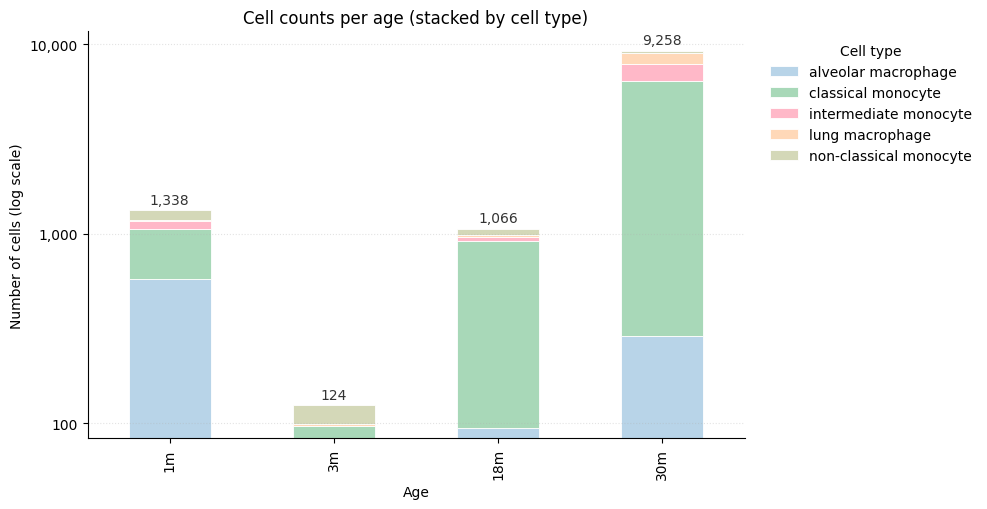

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import LogLocator, NullLocator, FuncFormatter

CELLTYPE_COLORS = {
    "alveolar macrophage": "#B8D4E8",
    "macrophage": "#FFD4A3",
    "monocyte": "#D4B8D8",
    "classical monocyte": "#A8D8B8",
    "intermediate monocyte": "#FFB8C8",
    "non-classical monocyte": "#D4D8B8",
    "Kupffer cell": "#B8D8D8",
    "lung macrophage": "#FFD8B8",
    "macrophage dendritic cell progenitor": "#C8B8E8",
}

def _order_ages_numeric(age_iter):
    def to_num(a):
        s = str(a).strip().lower()
        if s.endswith("m") and s[:-1].isdigit(): return int(s[:-1])
        if s.isdigit(): return int(s)
        return np.nan
    ages = pd.Index(sorted(set(map(str, age_iter))))
    nums = pd.Series([to_num(a) for a in ages], index=ages)
    return list(nums.sort_values().index) if nums.notna().all() else list(ages)

def _comma(x, _pos):  # 1000 -> "1,000"
    return f"{int(x):,}" if x >= 1 else f"{x:g}"

def plot_stacked_cell_counts(
    adata,
    celltypes_of_interest=None,
    out_path=None,
    bar_edge="white",
    dpi=300,
    yscale="log",         # "log" or "linear"
    show_values=True,
    zero_mode="nan"       # "nan" or "epsilon"
):
    obs = adata.obs.copy()
    if "cell_ontology_class" not in obs or "age" not in obs:
        raise ValueError("Need .obs['cell_ontology_class'] and .obs['age'].")

    if celltypes_of_interest is not None:
        obs = obs[obs["cell_ontology_class"].isin(celltypes_of_interest)].copy()

    obs["age"] = obs["age"].astype(str)
    ct = pd.crosstab(obs["age"], obs["cell_ontology_class"])
    age_order = _order_ages_numeric(ct.index)
    ct = ct.loc[age_order]

    cols = list(ct.columns)
    colors = [CELLTYPE_COLORS.get(c, "#CCCCCC") for c in cols]

    if yscale == "log":
        ct_plot = ct.replace(0, np.nan if zero_mode == "nan" else 0.5)
    else:
        ct_plot = ct

    fig, ax = plt.subplots(figsize=(10, 5.2))
    ct_plot.plot(kind="bar", stacked=True, ax=ax, color=colors, edgecolor=bar_edge, linewidth=0.6)

    # >>> Slim, readable Y axis <<<
    if yscale == "log":
        ax.set_yscale("log")
        # Major ticks at powers of 10 only (…100, 1000, 10000…)
        ax.yaxis.set_major_locator(LogLocator(base=10, subs=(1.0,), numticks=6))
        ax.yaxis.set_minor_locator(NullLocator())
        ax.yaxis.set_major_formatter(FuncFormatter(_comma))
        # Grid only on majors
        ax.grid(axis="y", which="major", linestyle=":", alpha=0.35)
    else:
        ax.grid(axis="y", linestyle=":", alpha=0.35)

    ax.set_xlabel("Age")
    ax.set_ylabel("Number of cells" + (" (log scale)" if yscale == "log" else ""))
    ax.set_title("Cell counts per age (stacked by cell type)")
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    # Totals on top of each bar (true totals, not transformed)
    if show_values:
        totals = ct.sum(axis=1).values
        tops = ct_plot.sum(axis=1).values
        for i, (t, ytop) in enumerate(zip(totals, tops)):
            if np.isnan(ytop) or ytop <= 0:  # all-zero stack
                continue
            # small vertical offset; multiplicative for log, additive for linear
            y_text = ytop * 1.04 if yscale == "log" else ytop + max(tops)*0.01
            ax.text(i, y_text, f"{int(t):,}", ha="center", va="bottom", fontsize=10, color="#333")

    # Legend outside
    leg = ax.legend(title="Cell type", bbox_to_anchor=(1.02, 1), loc="upper left", frameon=False)
    # for lh, ct_name in zip(leg.legendHandles, cols):
    #     lh.set_color(CELLTYPE_COLORS.get(ct_name, "#CCCCCC"))

    plt.tight_layout()
    if out_path:
        plt.savefig(out_path, dpi=dpi, bbox_inches="tight")
        png = out_path.rsplit(".", 1)[0] + ".png"
        plt.savefig(png, dpi=200, bbox_inches="tight")
        print(f"Saved: {out_path}\nSaved: {png}")
    plt.show()
# Example call (uses your existing 'adata' and CELLTYPES_OF_INTEREST):
plot_stacked_cell_counts(
    adata,
    CELLTYPES_OF_INTEREST,
    out_path=os.path.join(OUTPUT_FOLDER, "Lung_stacked_counts_by_age_logy.pdf"),
    yscale="log",          # switch to "linear" if you prefer
    zero_mode="nan",       # or "epsilon"
    show_values=True
)



In [ ]:
### Pathway Analysis ###

In [1]:
import os, re, glob
import pandas as pd

BASE_DIR = "/mnt/data/melhajjar/tabula_muris/all_tissues/scanvi_age_features_regression_model_final5_test2final_PLS_no1m_pres_final"
TISSUE   = "Lung"

rx = re.compile(rf"{re.escape(TISSUE)}_(.+?)_PLS_gene_strengths_full\.csv$")
pls_files = glob.glob(os.path.join(BASE_DIR, f"{TISSUE}_*_PLS_gene_strengths_full.csv"))

def save_universe_from_pls(ct, pls_path):
    df = pd.read_csv(pls_path, index_col=0)
    out = os.path.join(BASE_DIR, f"{TISSUE}_{ct}_GENE_UNIVERSE.csv")
    pd.Series(df.index.astype(str), name="gene").to_csv(out, index=False)
    print("universe saved (PLS):", out)

# first pass: use PLS file (best)
seen_cts = set()
for f in pls_files:
    m = rx.search(os.path.basename(f))
    if not m: continue
    ct = m.group(1)
    save_universe_from_pls(ct, f)
    seen_cts.add(ct)

# second pass: fill any missing using RF+perf union (proxy)
rf_files = glob.glob(os.path.join(BASE_DIR, f"{TISSUE}_*_RF_REG_feature_importances.csv"))
for rf in rf_files:
    ct = os.path.basename(rf).replace(f"{TISSUE}_","").replace("_RF_REG_feature_importances.csv","")
    if ct in seen_cts: continue
    uni_out = os.path.join(BASE_DIR, f"{TISSUE}_{ct}_GENE_UNIVERSE.csv")
    if os.path.exists(uni_out): continue
    imp = pd.read_csv(rf)
    perf_path = os.path.join(BASE_DIR, f"{TISSUE}_{ct}_gene_performance_ALL.csv")
    perf = pd.read_csv(perf_path) if os.path.exists(perf_path) else pd.DataFrame({"gene":[]})
    genes = pd.Index(imp["gene"].astype(str)).union(perf["gene"].astype(str)).unique()
    if len(genes)==0:
        print(f"⚠️ could not infer universe for {ct} (no files)"); continue
    pd.Series(genes, name="gene").to_csv(uni_out, index=False)
    print("universe saved (proxy):", uni_out)


universe saved (PLS): /mnt/data/melhajjar/tabula_muris/all_tissues/scanvi_age_features_regression_model_final5_test2final_PLS_no1m_pres_final/Lung_intermediate monocyte_GENE_UNIVERSE.csv
universe saved (PLS): /mnt/data/melhajjar/tabula_muris/all_tissues/scanvi_age_features_regression_model_final5_test2final_PLS_no1m_pres_final/Lung_non-classical monocyte_GENE_UNIVERSE.csv
universe saved (PLS): /mnt/data/melhajjar/tabula_muris/all_tissues/scanvi_age_features_regression_model_final5_test2final_PLS_no1m_pres_final/Lung_alveolar macrophage_GENE_UNIVERSE.csv
universe saved (PLS): /mnt/data/melhajjar/tabula_muris/all_tissues/scanvi_age_features_regression_model_final5_test2final_PLS_no1m_pres_final/Lung_classical monocyte_GENE_UNIVERSE.csv
universe saved (PLS): /mnt/data/melhajjar/tabula_muris/all_tissues/scanvi_age_features_regression_model_final5_test2final_PLS_no1m_pres_final/Lung_lung macrophage_GENE_UNIVERSE.csv


In [12]:
# ==== STEP 2 (robust ORA + preranked GSEA) ====
import os, glob, numpy as np, pandas as pd
import gseapy as gp

BASE_DIR = "/mnt/data/melhajjar/tabula_muris/all_tissues/scanvi_age_features_regression_model_final5_test2final_PLS_no1m_pres_final"
TISSUE   = "Lung"
TOP_FOR_ORA = 200

# --- discover installed libraries and pick robust defaults ---
libs = set(gp.get_library_name())
CANDIDATES_ORA  = [
    "GO_Biological_Process_2021",
    "WikiPathways_2019_Mouse",
    "KEGG_2019_Mouse",
    "Reactome_2016",
]
CANDIDATES_GSEA = CANDIDATES_ORA

ORA_LIBS  = [g for g in CANDIDATES_ORA  if g in libs]
GSEA_LIBS = [g for g in CANDIDATES_GSEA if g in libs]
if not ORA_LIBS:
    ORA_LIBS = [sorted(libs)[0]]
if not GSEA_LIBS:
    GSEA_LIBS = ORA_LIBS[:]

def celltypes_from_rf(base_dir, tissue):
    pats = glob.glob(os.path.join(base_dir, f"{tissue}_*_RF_feature_importances.csv"))
    return sorted({os.path.basename(p).replace(f"{tissue}_","").replace("_RF_feature_importances.csv","") for p in pats})

print("✅ Script started")
cts = celltypes_from_rf(BASE_DIR, TISSUE)
print("Discovered cell types:", cts)

for ct in cts:
    print(f"\n=== {ct} ===")
    imp_path  = os.path.join(BASE_DIR, f"{TISSUE}_{ct}_RF_feature_importances.csv")
    perf_path = os.path.join(BASE_DIR, f"{TISSUE}_{ct}_gene_performance_ALL.csv")
    uni_path  = os.path.join(BASE_DIR, f"{TISSUE}_{ct}_GENE_UNIVERSE.csv")

    if not os.path.exists(imp_path):
        print("  ⚠️ missing RF importances; skipping"); continue

    # --- load RF importances ---
    imp  = pd.read_csv(imp_path)

    # rename if gene column is "Unnamed: 0"
    if "Unnamed: 0" in imp.columns and "gene" not in imp.columns:
        imp = imp.rename(columns={"Unnamed: 0": "gene"})

    perf = pd.read_csv(perf_path) if os.path.exists(perf_path) else None

    # --- load gene universe ---
    bg = None
    if os.path.exists(uni_path):
        bg = pd.read_csv(uni_path)["gene"].astype(str).str.upper().dropna().unique().tolist()
    else:
        print("  ⚠️ no GENE_UNIVERSE.csv found — ORA will run without background")

    # ---------- ORA on RF-top genes ----------
    top_genes = (imp.sort_values("gini_importance", ascending=False)["gene"]
                   .astype(str).str.upper().dropna().head(TOP_FOR_ORA).tolist())
    try:
        enr = gp.enrichr(
            gene_list=top_genes,
            gene_sets=ORA_LIBS,
            organism="Mouse",
            background=bg,
            cutoff=0.05
        )
    except TypeError:
        enr = gp.enrichr(
            gene_list=top_genes,
            gene_sets=ORA_LIBS,
            organism="Mouse",
            cutoff=0.05
        )
    out_csv = os.path.join(BASE_DIR, f"{TISSUE}_{ct}_ORA_RFreg_top{TOP_FOR_ORA}.csv")
    enr.results.to_csv(out_csv, index=False)
    print("  ORA written:", out_csv)

    # ---------- preranked GSEA ----------
    if perf is None:
        print("  ⚠️ missing gene_performance_ALL.csv — skipping GSEA"); continue

    df = perf.merge(imp, on="gene", how="inner")
    df["gene_up"] = df["gene"].astype(str).str.upper()
    df["rank"] = np.sign(df["spearman_age"].fillna(0.0)) * df["gini_importance"].fillna(0.0)
    rnk_df = (df[["gene_up","rank"]]
                .dropna()
                .sort_values("rank", ascending=False)
                .groupby("gene_up", as_index=False)["rank"].max())

    rnk_path = os.path.join(BASE_DIR, f"{TISSUE}_{ct}_RF_REG_prerank.tsv")
    rnk_df.to_csv(rnk_path, sep="\t", index=False, header=False)

    pre = gp.prerank(
        rnk=rnk_path,
        gene_sets=GSEA_LIBS,
        min_size=5,
        max_size=5000,
        permutation_num=1000,
        outdir=os.path.join(BASE_DIR, f"{TISSUE}_{ct}_GSEA_prerank"),
        seed=0, no_plot=True, processes=1, format="png", verbose=True,
    )
    gsea_csv = os.path.join(BASE_DIR, f"{TISSUE}_{ct}_GSEA_prerank_results.csv")
    pre.res2d.to_csv(gsea_csv, index=False)
    print("  GSEA written:", gsea_csv)


✅ Script started
Discovered cell types: ['alveolar macrophage', 'classical monocyte', 'intermediate monocyte', 'lung macrophage', 'non-classical monocyte']

=== alveolar macrophage ===


/tmp/ipykernel_32382/2826884050.py:96: DeprecationWarning: processes is deprecated; use threads
  pre = gp.prerank(
2025-09-30 00:57:22,427 [INFO] Parsing data files for GSEA.............................
2025-09-30 00:57:22,428 [INFO] Enrichr library gene sets already downloaded in: /home/melhajjar/.cache/gseapy, use local file
2025-09-30 00:57:22,593 [INFO] Enrichr library gene sets already downloaded in: /home/melhajjar/.cache/gseapy, use local file
2025-09-30 00:57:22,595 [INFO] Enrichr library gene sets already downloaded in: /home/melhajjar/.cache/gseapy, use local file


  ORA written: /mnt/data/melhajjar/tabula_muris/all_tissues/scanvi_age_features_regression_model_final5_test2final_PLS_no1m_pres_final/Lung_alveolar macrophage_ORA_RFreg_top200.csv


2025-09-30 00:57:22,628 [INFO] 6507 gene_sets have been filtered out when max_size=5000 and min_size=5
2025-09-30 00:57:22,629 [INFO] 0008 gene_sets used for further statistical testing.....
2025-09-30 00:57:22,629 [INFO] Start to run GSEA...Might take a while..................
2025-09-30 00:57:22,652 [INFO] Congratulations. GSEApy runs successfully................



  GSEA written: /mnt/data/melhajjar/tabula_muris/all_tissues/scanvi_age_features_regression_model_final5_test2final_PLS_no1m_pres_final/Lung_alveolar macrophage_GSEA_prerank_results.csv

=== classical monocyte ===


/tmp/ipykernel_32382/2826884050.py:96: DeprecationWarning: processes is deprecated; use threads
  pre = gp.prerank(
2025-09-30 00:57:23,487 [INFO] Parsing data files for GSEA.............................
2025-09-30 00:57:23,488 [INFO] Enrichr library gene sets already downloaded in: /home/melhajjar/.cache/gseapy, use local file
2025-09-30 00:57:23,527 [INFO] Enrichr library gene sets already downloaded in: /home/melhajjar/.cache/gseapy, use local file
2025-09-30 00:57:23,529 [INFO] Enrichr library gene sets already downloaded in: /home/melhajjar/.cache/gseapy, use local file
2025-09-30 00:57:23,562 [INFO] 6498 gene_sets have been filtered out when max_size=5000 and min_size=5
2025-09-30 00:57:23,563 [INFO] 0017 gene_sets used for further statistical testing.....
2025-09-30 00:57:23,563 [INFO] Start to run GSEA...Might take a while..................
2025-09-30 00:57:23,604 [INFO] Congratulations. GSEApy runs successfully................



  ORA written: /mnt/data/melhajjar/tabula_muris/all_tissues/scanvi_age_features_regression_model_final5_test2final_PLS_no1m_pres_final/Lung_classical monocyte_ORA_RFreg_top200.csv
  GSEA written: /mnt/data/melhajjar/tabula_muris/all_tissues/scanvi_age_features_regression_model_final5_test2final_PLS_no1m_pres_final/Lung_classical monocyte_GSEA_prerank_results.csv

=== intermediate monocyte ===


/tmp/ipykernel_32382/2826884050.py:96: DeprecationWarning: processes is deprecated; use threads
  pre = gp.prerank(
2025-09-30 00:57:24,448 [INFO] Parsing data files for GSEA.............................
2025-09-30 00:57:24,449 [INFO] Enrichr library gene sets already downloaded in: /home/melhajjar/.cache/gseapy, use local file
2025-09-30 00:57:24,484 [INFO] Enrichr library gene sets already downloaded in: /home/melhajjar/.cache/gseapy, use local file
2025-09-30 00:57:24,487 [INFO] Enrichr library gene sets already downloaded in: /home/melhajjar/.cache/gseapy, use local file
2025-09-30 00:57:24,523 [INFO] 6490 gene_sets have been filtered out when max_size=5000 and min_size=5
2025-09-30 00:57:24,524 [INFO] 0025 gene_sets used for further statistical testing.....
2025-09-30 00:57:24,524 [INFO] Start to run GSEA...Might take a while..................
2025-09-30 00:57:24,574 [INFO] Congratulations. GSEApy runs successfully................



  ORA written: /mnt/data/melhajjar/tabula_muris/all_tissues/scanvi_age_features_regression_model_final5_test2final_PLS_no1m_pres_final/Lung_intermediate monocyte_ORA_RFreg_top200.csv
  GSEA written: /mnt/data/melhajjar/tabula_muris/all_tissues/scanvi_age_features_regression_model_final5_test2final_PLS_no1m_pres_final/Lung_intermediate monocyte_GSEA_prerank_results.csv

=== lung macrophage ===


/tmp/ipykernel_32382/2826884050.py:96: DeprecationWarning: processes is deprecated; use threads
  pre = gp.prerank(
2025-09-30 00:57:25,397 [INFO] Parsing data files for GSEA.............................
2025-09-30 00:57:25,398 [INFO] Enrichr library gene sets already downloaded in: /home/melhajjar/.cache/gseapy, use local file
2025-09-30 00:57:25,447 [INFO] Enrichr library gene sets already downloaded in: /home/melhajjar/.cache/gseapy, use local file
2025-09-30 00:57:25,450 [INFO] Enrichr library gene sets already downloaded in: /home/melhajjar/.cache/gseapy, use local file
2025-09-30 00:57:25,484 [INFO] 6509 gene_sets have been filtered out when max_size=5000 and min_size=5
2025-09-30 00:57:25,486 [INFO] 0006 gene_sets used for further statistical testing.....
2025-09-30 00:57:25,486 [INFO] Start to run GSEA...Might take a while..................
2025-09-30 00:57:25,512 [INFO] Congratulations. GSEApy runs successfully................



  ORA written: /mnt/data/melhajjar/tabula_muris/all_tissues/scanvi_age_features_regression_model_final5_test2final_PLS_no1m_pres_final/Lung_lung macrophage_ORA_RFreg_top200.csv
  GSEA written: /mnt/data/melhajjar/tabula_muris/all_tissues/scanvi_age_features_regression_model_final5_test2final_PLS_no1m_pres_final/Lung_lung macrophage_GSEA_prerank_results.csv

=== non-classical monocyte ===


/tmp/ipykernel_32382/2826884050.py:96: DeprecationWarning: processes is deprecated; use threads
  pre = gp.prerank(
2025-09-30 00:57:26,346 [INFO] Parsing data files for GSEA.............................
2025-09-30 00:57:26,347 [INFO] Enrichr library gene sets already downloaded in: /home/melhajjar/.cache/gseapy, use local file
2025-09-30 00:57:26,384 [INFO] Enrichr library gene sets already downloaded in: /home/melhajjar/.cache/gseapy, use local file
2025-09-30 00:57:26,386 [INFO] Enrichr library gene sets already downloaded in: /home/melhajjar/.cache/gseapy, use local file
2025-09-30 00:57:26,421 [INFO] 6473 gene_sets have been filtered out when max_size=5000 and min_size=5
2025-09-30 00:57:26,422 [INFO] 0042 gene_sets used for further statistical testing.....
2025-09-30 00:57:26,423 [INFO] Start to run GSEA...Might take a while..................
2025-09-30 00:57:26,492 [INFO] Congratulations. GSEApy runs successfully................



  ORA written: /mnt/data/melhajjar/tabula_muris/all_tissues/scanvi_age_features_regression_model_final5_test2final_PLS_no1m_pres_final/Lung_non-classical monocyte_ORA_RFreg_top200.csv
  GSEA written: /mnt/data/melhajjar/tabula_muris/all_tissues/scanvi_age_features_regression_model_final5_test2final_PLS_no1m_pres_final/Lung_non-classical monocyte_GSEA_prerank_results.csv


In [32]:
# ===== ORA + GSEA PLOTS (PDF, smaller fonts) + Directionality =====
import os, glob, numpy as np, pandas as pd
import matplotlib.pyplot as plt

BASE_DIR = "/mnt/data/melhajjar/tabula_muris/all_tissues/scanvi_age_features_regression_model_final5_test2final_PLS_no1m_pres_final"
TISSUE   = "Lung"
TOP_N    = 20  # how many terms to visualize

plt.rcParams.update({
    "pdf.fonttype": 42, "ps.fonttype": 42,
    "font.size": 8.5, "axes.titlesize": 10, "axes.labelsize": 9,
    "xtick.labelsize": 8, "ytick.labelsize": 8, "legend.fontsize": 8
})

def _cts_with_ora(base_dir, tissue):
    paths = glob.glob(os.path.join(base_dir, f"{tissue}_*_ORA_RFreg_top*.csv"))
    return sorted({os.path.basename(p).split("_ORA_")[0].replace(f"{tissue}_","") for p in paths})

def plot_ora_pdf(ct):
    # robust read (latest ORA CSV)
    ora_csvs = sorted(glob.glob(os.path.join(BASE_DIR, f"{TISSUE}_{ct}_ORA_RFreg_top*.csv")))
    if not ora_csvs: 
        print(f"[{ct}] No ORA CSV."); 
        return
    df = pd.read_csv(ora_csvs[-1])
    if df.empty:
        print(f"[{ct}] ORA empty.")
        return

    # pick top terms: prefer adj p<=0.05; else take top-N by adj p anyway
    col_adj = next((c for c in df.columns if "Adjusted" in c and "P" in c), None)
    col_name = "Term" if "Term" in df.columns else df.columns[0]
    if col_adj is None:
        print(f"[{ct}] Could not find Adjusted P-value column; using first numeric sort.")
        numcols = [c for c in df.columns if pd.api.types.is_numeric_dtype(df[c])]
        sortcol = numcols[0] if numcols else None
        sub = df.sort_values(sortcol).head(TOP_N) if sortcol else df.head(TOP_N)
    else:
        sig = df[df[col_adj] <= 0.05]
        sub = (sig if not sig.empty else df).sort_values(col_adj).head(TOP_N)

    if sub.empty:
        print(f"[{ct}] No terms to plot after fallback.")
        return

    out_pdf = os.path.join(BASE_DIR, f"{TISSUE}_{ct}_ORA_barplot_top{TOP_N}.pdf")
    # custom small-text barplot (horizontal)
    ylabels = sub[col_name].astype(str).tolist()[::-1]
    # most Enrichr outputs have "Combined Score" or "-log10(p)"; pick a good x
    xcol = "Combined Score" if "Combined Score" in sub.columns else ( "-log10(p-value)" if "-log10(p-value)" in sub.columns else ( "Odds Ratio" if "Odds Ratio" in sub.columns else ( "P-value" if "P-value" in sub.columns else None)))
    if xcol is None:  # fallback to smallest adj p
        x = -np.log10(sub[col_adj].clip(1e-300)).to_numpy()[::-1]
        xlabel = r"$-\log_{10}(\mathrm{AdjP})$"
    else:
        x = sub[xcol].to_numpy()[::-1]
        xlabel = xcol
    fig, ax = plt.subplots(figsize=(7.5, 4.5))
    ax.barh(range(len(ylabels)), x)
    ax.set_yticks(range(len(ylabels))); ax.set_yticklabels(ylabels)
    ax.set_xlabel(xlabel)
    ax.set_title(f"{TISSUE} — {ct} • ORA (Top {len(ylabels)})")
    ax.grid(axis="x", linestyle=":", alpha=0.4)
    fig.tight_layout()
    fig.savefig(out_pdf, dpi=300, bbox_inches="tight")
    plt.close(fig)
    print(f"[{ct}] ORA PDF:", out_pdf)

def plot_gsea_summary_pdf(ct):
    outdir = os.path.join(BASE_DIR, f"{TISSUE}_{ct}_GSEA_prerank")
    # gseapy writes a summary CSV named like this:
    rep_csv = os.path.join(outdir, "gseapy.prerank.gsea.report.csv")
    if not os.path.exists(rep_csv):
        # sometimes it is placed one level up if you used a different outdir—fallback:
        rep_glob = glob.glob(os.path.join(outdir, "*.csv"))
        if rep_glob: rep_csv = rep_glob[0]
        else:
            print(f"[{ct}] No GSEA report CSV found."); return
    df = pd.read_csv(rep_csv)
    if df.empty:
        print(f"[{ct}] GSEA report is empty."); return

    # choose top by FDR q-val; keep NES sign for direction
    # gseapy columns are typically: Term, NES, FDR q-val, pval, size, etc.
    col_term = "Term"
    col_nes  = "NES" if "NES" in df.columns else "nes"
    col_fdr  = "FDR q-val" if "FDR q-val" in df.columns else ("fdr" if "fdr" in df.columns else None)
    if col_fdr is None:
        sub = df.sort_values(col_nes, ascending=False)
    else:
        sub = df.sort_values(col_fdr).head(TOP_N)
    sub = sub.head(TOP_N).copy()

    # small, directional barplot: NES (color by sign)
    terms = sub[col_term].astype(str).tolist()[::-1]
    nes   = sub[col_nes].astype(float).to_numpy()[::-1]
    colors = ["#d84545" if v < 0 else "#2875d8" for v in nes]  # red=down with age, blue=up with age

    out_pdf = os.path.join(BASE_DIR, f"{TISSUE}_{ct}_GSEA_summary_top{len(terms)}.pdf")
    fig, ax = plt.subplots(figsize=(7.8, 4.6))
    ax.barh(range(len(terms)), nes, color=colors)
    ax.axvline(0, color="#333", lw=1)
    ax.set_yticks(range(len(terms))); ax.set_yticklabels(terms)
    ax.set_xlabel("NES (sign = direction vs age)")
    ttl = f"{TISSUE} — {ct} • GSEA (Top {len(terms)} by FDR)"
    ax.set_title(ttl)
    ax.grid(axis="x", linestyle=":", alpha=0.4)
    fig.tight_layout()
    fig.savefig(out_pdf, dpi=300, bbox_inches="tight")
    plt.close(fig)
    print(f"[{ct}] GSEA summary PDF:", out_pdf)

def directional_ora_pdfs(ct, top_from_rf=200):
    """Split RF genes by Spearman sign → two Enrichr ORAs → two PDFs."""
    imp_path  = os.path.join(BASE_DIR, f"{TISSUE}_{ct}_RF_REG_feature_importances.csv")
    perf_path = os.path.join(BASE_DIR, f"{TISSUE}_{ct}_gene_performance_ALL.csv")
    if not (os.path.exists(imp_path) and os.path.exists(perf_path)):
        print(f"[{ct}] Missing RF or performance CSV; skipping directional ORA.")
        return
    imp  = pd.read_csv(imp_path)
    perf = pd.read_csv(perf_path)

    # take top-by-Gini, then merge Spearman signs
    top = (imp.sort_values("gini_importance", ascending=False)
              .head(top_from_rf)[["gene","gini_importance"]])
    df = top.merge(perf[["gene","spearman_age"]], on="gene", how="left")
    df["gene_up"] = df["gene"].astype(str).str.upper()
    up_list   = df.loc[df["spearman_age"]>=0, "gene_up"].dropna().unique().tolist()
    down_list = df.loc[df["spearman_age"]<0,  "gene_up"].dropna().unique().tolist()

    # read ORA CSV to reuse its p-values/terms (alternatively: call gseapy.enrichr again)
    # here we’ll just create simple PDFs listing the genes used in each direction.
    for label, genes in [("UP_with_age", up_list), ("DOWN_with_age", down_list)]:
        out_pdf = os.path.join(BASE_DIR, f"{TISSUE}_{ct}_ORA_{label}_top{len(genes)}.pdf")
        fig, ax = plt.subplots(figsize=(7.5, 1 + 0.18*max(5, min(30, len(genes)))))
        ax.axis("off")
        ax.set_title(f"{TISSUE} — {ct} • Directional gene set: {label}", loc="left")
        txt = ", ".join(genes[:120]) + (" …" if len(genes)>120 else "")
        ax.text(0.01, 0.98, f"{len(genes)} genes\n\n{txt}", va="top", ha="left", wrap=True)
        fig.tight_layout()
        fig.savefig(out_pdf, dpi=300, bbox_inches="tight")
        plt.close(fig)
        print(f"[{ct}] Directional list PDF:", out_pdf)

# ---- run across cell types ----
for ct in _cts_with_ora(BASE_DIR, TISSUE):
    plot_ora_pdf(ct)
    plot_gsea_summary_pdf(ct)
    # optional: also generate directional gene PDFs (and/or plug these into Enrichr if you want)
    directional_ora_pdfs(ct)

[alveolar macrophage] ORA PDF: /mnt/data/melhajjar/tabula_muris/all_tissues/scanvi_age_features_regression_model_final5_test2final_PLS_no1m_pres_final/Lung_alveolar macrophage_ORA_barplot_top20.pdf
[alveolar macrophage] GSEA summary PDF: /mnt/data/melhajjar/tabula_muris/all_tissues/scanvi_age_features_regression_model_final5_test2final_PLS_no1m_pres_final/Lung_alveolar macrophage_GSEA_summary_top8.pdf
[alveolar macrophage] Missing RF or performance CSV; skipping directional ORA.
[classical monocyte] ORA PDF: /mnt/data/melhajjar/tabula_muris/all_tissues/scanvi_age_features_regression_model_final5_test2final_PLS_no1m_pres_final/Lung_classical monocyte_ORA_barplot_top20.pdf
[classical monocyte] GSEA summary PDF: /mnt/data/melhajjar/tabula_muris/all_tissues/scanvi_age_features_regression_model_final5_test2final_PLS_no1m_pres_final/Lung_classical monocyte_GSEA_summary_top17.pdf
[classical monocyte] Missing RF or performance CSV; skipping directional ORA.
[intermediate monocyte] ORA PDF: /mn

In [18]:
# === Pathway × Gene direction HEATMAP for ALL cell types ===
# Layout: [LEFT labels (right-aligned)] | [CENTER heatmap] | [RIGHT NES bars]
# Pure white background, masked zeros, Nature-style muted RdBu.

import os, re, glob, textwrap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import OrderedDict
from matplotlib.gridspec import GridSpec
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import transforms

# ---------- GLOBAL WHITE BG ----------
plt.rcParams.update({
    "figure.facecolor":  "white",
    "axes.facecolor":    "white",
    "savefig.facecolor": "white",
    "figure.edgecolor":  "white",
    "savefig.edgecolor": "white",
    "pdf.fonttype": 42,  # editable text
    "ps.fonttype":  42,
})

# -------- CONFIG --------
BASE_DIR = "/mnt/data/melhajjar/tabula_muris/all_tissues/scanvi_age_features_regression_model_final5_test2final_PLS_no1m_pres_final"
TISSUE   = "Lung"

TOP_PATHWAYS   = 10     # rows (by FDR if present else |NES|)
TOPK_PER_TERM  = 40     # genes per pathway (direction-aware)
MAX_COLS       = 120    # cap across pathways
COLS_PER_PAGE  = 40     # columns per PDF page

# Align heatmap columns to RF top-N genes (same order); set to None to disable
ALIGN_TO_RF_TOP = 20

# Nature-style palette (muted RdBu: red → off-white → blue)
NATURE_CMAP = LinearSegmentedColormap.from_list(
    "nature_rdbu", ["#b2182b", "#f7f7f7", "#2166ac"]
)
BAR_RED  = "#b2182b"
BAR_BLUE = "#2166ac"

# -------- Helpers --------
def read_rnk(p):
    df = None
    for sep in ["\t", ",", r"\s+"]:
        try:
            tmp = pd.read_csv(p, sep=sep, engine="python", header=None, names=["gene","score"])
            if tmp.shape[1] >= 2:
                df = tmp; break
        except Exception:
            continue
    if df is None:
        raise ValueError(f"Could not parse {p}")
    df = df.iloc[:, :2].dropna()
    df.columns = ["gene","score"]
    df["UP"] = df["gene"].astype(str).str.strip().str.upper()
    df = df.sort_values("score", ascending=False).drop_duplicates("UP", keep="first")
    scores = df.set_index("UP")["score"].astype(float).sort_values(ascending=False)
    case   = df.set_index("UP")["gene"].to_dict()
    return scores, case

def read_gmt(p):
    out = OrderedDict()
    with open(p) as fh:
        for line in fh:
            parts = line.rstrip("\n").split("\t")
            if len(parts) < 3: continue
            out[parts[0].strip()] = set(g.strip().upper() for g in parts[2:] if g.strip())
    return out

def norm_term(s):
    s = str(s)
    s = re.sub(r"\s*\(GO:\d+\)\s*$","", s)
    s = re.sub(r"^(GO Biological Process 20\d{2}|GO_Biological_Process_20\d{2}|KEGG(_20\d{2}(_Mouse)?)?|WikiPathways_20\d{2}(_Mouse)?)\s*", "", s)
    s = re.sub(r"[ _]+"," ", s).strip()
    return s

def title_case(s): return s.title()

def wrap_text(s, width=34):
    return "\n".join(textwrap.wrap(s, width=width, break_long_words=False)) or s

def map_terms(report_terms, gmt_terms):
    gnorm = {norm_term(k): k for k in gmt_terms}
    mapping = {}
    for rt in report_terms:
        if rt in gmt_terms: mapping[rt] = rt; continue
        rn = norm_term(rt)
        if rn in gnorm: mapping[rt] = gnorm[rn]; continue
        for k, orig in gnorm.items():
            if k.lower()==rn.lower() or k.lower() in rn.lower() or rn.lower() in k.lower():
                mapping[rt] = orig; break
    return mapping

def topk_directional(rnk, genes, nes, k):
    sub = rnk[rnk.index.isin(genes)]
    if sub.empty: return []
    # NES>0 pick most positive; NES<0 pick most negative
    sub = sub.sort_values(ascending=(nes < 0))
    return sub.head(k).index.tolist()

def process_celltype(ct):
    pfx   = os.path.join(BASE_DIR, f"{TISSUE}_{ct}")
    prdir = f"{pfx}_GSEA_prerank"
    rnk_path = os.path.join(prdir, "prerank_data.rnk")
    rep_path = os.path.join(prdir, "gseapy.gene_set.prerank.report.csv")
    gmt_path = os.path.join(prdir, "gene_sets.gmt")

    if not (os.path.exists(rnk_path) and os.path.exists(rep_path) and os.path.exists(gmt_path)):
        print(f"  ⚠️ Missing files for {ct}; skipping")
        return

    pdf_out = f"{pfx}_HEATMAP_pathway_x_gene_TOP{TOP_PATHWAYS}_K{TOPK_PER_TERM}.pdf"
    csv_out = f"{pfx}_HEATMAP_pathway_x_gene_table.csv"

    # ---- Load
    rnk, case = read_rnk(rnk_path)
    rep = pd.read_csv(rep_path)

    # NES / FDR columns
    nes_col = "NES" if "NES" in rep.columns else ("nes" if "nes" in rep.columns else None)
    fdr_col = None
    for cand in ["FDR q-val", "FDR", "fdr", "fdr_q_val", "fdr_q"]:
        if cand in rep.columns: fdr_col = cand; break
    if nes_col is None:
        print(f"  ⚠️ NES column missing in report for {ct}; skipping")
        return

    rep = rep.rename(columns={"Term":"term", nes_col:"NES"})
    rep["NES"] = pd.to_numeric(rep["NES"], errors="coerce")

    gs = read_gmt(gmt_path)

    # ---- choose pathways
    if fdr_col and fdr_col in rep.columns:
        rep = rep.sort_values(fdr_col)
    else:
        rep = rep.assign(absNES=rep["NES"].abs()).sort_values("absNES", ascending=False)

    mapping = map_terms(rep["term"].tolist(), list(gs.keys()))
    chosen = []
    for _, row in rep.iterrows():
        if len(chosen) >= TOP_PATHWAYS: break
        tr = row["term"]; tg = mapping.get(tr)
        if tg:
            qv = float(row.get(fdr_col, np.nan)) if (fdr_col and fdr_col in rep.columns) else np.nan
            chosen.append((tr, tg, float(row["NES"]), qv))

    if not chosen:
        print(f"  ⚠️ No pathways mapped for {ct}; skipping")
        return

    terms   = [c[0] for c in chosen]
    nesvals = np.array([c[2] for c in chosen])
    qvals   = np.array([c[3] for c in chosen])

    # ---- genes (direction-aware) and union from pathways
    term2genes = {tr: topk_directional(rnk, gs[tg], nes, TOPK_PER_TERM) for tr, tg, nes, _ in chosen}
    path_union = set(g for L in term2genes.values() for g in L)
    union = sorted(path_union, key=lambda g: abs(rnk.get(g,0.0)), reverse=True)[:MAX_COLS]

    # ---- OPTIONAL: align to RF top-N (same genes & order as RF plot)
    if ALIGN_TO_RF_TOP:
        rf_path1 = f"{pfx}_RF_feature_importances.csv"
        rf_path2 = f"{pfx}_RF_REG_feature_importances.csv"
        rf_path = rf_path1 if os.path.exists(rf_path1) else (rf_path2 if os.path.exists(rf_path2) else None)
        if rf_path:
            rf = pd.read_csv(rf_path)
            gene_col = "gene" if "gene" in rf.columns else rf.columns[0]  # handle "Unnamed: 0"
            rf_top = (rf.sort_values("gini_importance", ascending=False)[gene_col]
                        .astype(str).str.upper().head(ALIGN_TO_RF_TOP).tolist())
            rf_cols = [g for g in rf_top if g in path_union]  # keep RF order, restrict to enriched genes
            if len(rf_cols) >= max(20, int(0.25 * ALIGN_TO_RF_TOP)):
                union = rf_cols
        else:
            print(f"  ℹ️ RF importances not found for {ct}; keeping pathway-selected genes")

    col_labels = [case.get(g, g.title()) for g in union]
    row_labels = [wrap_text(title_case(norm_term(t))) for t in terms]

    # ---- matrix with signs (-1, 0, +1)
    M = np.zeros((len(terms), len(union)), dtype=int)
    for i, tr in enumerate(terms):
        picked = set(term2genes[tr])
        for j, g in enumerate(union):
            if g in picked:
                M[i, j] = 1 if rnk.get(g, 0.0) >= 0 else -1

    # ---- companion CSV
    pd.DataFrame({
        "term": [title_case(norm_term(t)) for t in terms],
        "NES": nesvals,
        "FDR_q": qvals,
        "genes_shown_in_order": [", ".join(case.get(g,g) for g in term2genes[t]) for t in terms],
    }).to_csv(csv_out, index=False)

    # ---- Plotting
    plt.rcParams.update({
        "axes.titlesize": 12, "axes.labelsize": 12,
        "xtick.labelsize": 9, "ytick.labelsize": 10,
    })

    pages = max(1, int(np.ceil(len(union)/COLS_PER_PAGE)))
    for p in range(pages):
        s, e = p*COLS_PER_PAGE, min(len(union), (p+1)*COLS_PER_PAGE)
        sub = M[:, s:e]; labs = col_labels[s:e]

        label_w, heat_w, bar_w = 2.6, min(21, 7.6 + 0.24*(e - s)), 2.9
        fig_w, fig_h = label_w + heat_w + bar_w, 0.54*len(terms) + 3.0

        fig = plt.figure(figsize=(fig_w, fig_h))
        gs  = GridSpec(1, 3, width_ratios=[label_w, heat_w, bar_w], wspace=0.02)

        # (1) LABEL PANEL — right-aligned names
        ax_lbl = fig.add_subplot(gs[0,0])
        y = np.arange(len(terms))
        ax_lbl.set_ylim(-0.5, len(terms)-0.5)
        ax_lbl.set_xlim(0, 1)
        ax_lbl.set_xticks([]); ax_lbl.set_yticks([])
        ax_lbl.tick_params(left=False, right=False, labelleft=False)
        for sp in ["top","right","bottom","left"]: ax_lbl.spines[sp].set_visible(False)

        trans = transforms.blended_transform_factory(ax_lbl.transAxes, ax_lbl.transData)
        for yi, lab in enumerate(row_labels):
            ax_lbl.text(0.98, yi, lab, transform=trans,
                        ha="right", va="center", fontsize=10, color="black", clip_on=False)

        # (2) HEATMAP
        ax_h = fig.add_subplot(gs[0,1], sharey=ax_lbl)
        cmap = NATURE_CMAP.copy(); cmap.set_bad(color="white")
        data = np.ma.masked_where(sub == 0, sub)
        im = ax_h.imshow(data[:, ::-1], aspect="auto", cmap=cmap, vmin=-1, vmax=1)
        ax_h.set_xticks(range(e - s))
        ax_h.set_xticklabels(labs[::-1], rotation=45, ha="right")
        ax_h.set_yticks(y); ax_h.set_yticklabels([])
        ax_h.set_xlabel("Genes")
        for sp in ["top","right"]: ax_h.spines[sp].set_visible(False)
        cbar = fig.colorbar(im, ax=ax_h, shrink=0.82, pad=0.012, ticks=[-1, 0, 1])
        cbar.ax.set_yticklabels(["↓ with age", "0", "↑ with age"])
        cbar.ax.set_facecolor("white")
        cbar.outline.set_edgecolor("black")

        # (3) NES BARS
        ax_b = fig.add_subplot(gs[0,2], sharey=ax_lbl)
        colors = [BAR_BLUE if v>0 else BAR_RED for v in nesvals]
        ax_b.barh(y, np.abs(nesvals), color=colors, height=0.8)
        max_abs = float(np.nanmax(np.abs(nesvals))) if np.isfinite(np.nanmax(np.abs(nesvals))) else 1.0
        for yi, val, col in zip(y, np.abs(nesvals), colors):
            txt = f"{val:.2f}"
            if val > 0.85*max_abs:
                ax_b.text(val-0.02*max_abs, yi, txt, va="center", ha="right", color="white", fontsize=9)
            else:
                ax_b.text(val+0.02*max_abs, yi, txt, va="center", ha="left", color=col, fontsize=9)
        ax_b.set_yticks(y); ax_b.set_yticklabels([]); ax_b.tick_params(axis="y", length=0)
        ax_b.set_xlabel("|NES|")
        for sp in ["top","right"]: ax_b.spines[sp].set_visible(False)

        fig.suptitle(f"{TISSUE} — {ct} • Pathway × Gene Direction Heatmap  •  Cols {s+1}-{e}/{len(union)}",
                     y=0.995, fontsize=12)
        fig.tight_layout(rect=[0,0,1,0.98])

        out_this = pdf_out if pages==1 else pdf_out.replace(".pdf", f".p{p+1}.pdf")
        fig.savefig(out_this, dpi=300, bbox_inches="tight")
        plt.close(fig)

    print(f"  ✅ Saved PDF(s): {pdf_out if pages==1 else pdf_out.replace('.pdf', '.p*.pdf')}")
    print(f"  💾 Saved table: {csv_out}")

# -------- Discover all cell types with GSEA outputs and run --------
print("🔎 Scanning for cell types…")
pr_dirs = glob.glob(os.path.join(BASE_DIR, f"{TISSUE}_*_GSEA_prerank"))
celltypes = [os.path.basename(d).replace(f"{TISSUE}_", "").replace("_GSEA_prerank", "") for d in pr_dirs]
celltypes = sorted(set(celltypes))
print("Found cell types:", celltypes if celltypes else "(none)")

for ct in celltypes:
    print(f"\n=== Processing {ct} ===")
    process_celltype(ct)


🔎 Scanning for cell types…
Found cell types: ['alveolar macrophage', 'classical monocyte', 'intermediate monocyte', 'lung macrophage', 'non-classical monocyte']

=== Processing alveolar macrophage ===


/tmp/ipykernel_32382/2474050010.py:262: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0,0,1,0.98])


  ✅ Saved PDF(s): /mnt/data/melhajjar/tabula_muris/all_tissues/scanvi_age_features_regression_model_final5_test2final_PLS_no1m_pres_final/Lung_alveolar macrophage_HEATMAP_pathway_x_gene_TOP10_K40.pdf
  💾 Saved table: /mnt/data/melhajjar/tabula_muris/all_tissues/scanvi_age_features_regression_model_final5_test2final_PLS_no1m_pres_final/Lung_alveolar macrophage_HEATMAP_pathway_x_gene_table.csv

=== Processing classical monocyte ===


/tmp/ipykernel_32382/2474050010.py:262: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0,0,1,0.98])


  ✅ Saved PDF(s): /mnt/data/melhajjar/tabula_muris/all_tissues/scanvi_age_features_regression_model_final5_test2final_PLS_no1m_pres_final/Lung_classical monocyte_HEATMAP_pathway_x_gene_TOP10_K40.pdf
  💾 Saved table: /mnt/data/melhajjar/tabula_muris/all_tissues/scanvi_age_features_regression_model_final5_test2final_PLS_no1m_pres_final/Lung_classical monocyte_HEATMAP_pathway_x_gene_table.csv

=== Processing intermediate monocyte ===


/tmp/ipykernel_32382/2474050010.py:262: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0,0,1,0.98])


  ✅ Saved PDF(s): /mnt/data/melhajjar/tabula_muris/all_tissues/scanvi_age_features_regression_model_final5_test2final_PLS_no1m_pres_final/Lung_intermediate monocyte_HEATMAP_pathway_x_gene_TOP10_K40.pdf
  💾 Saved table: /mnt/data/melhajjar/tabula_muris/all_tissues/scanvi_age_features_regression_model_final5_test2final_PLS_no1m_pres_final/Lung_intermediate monocyte_HEATMAP_pathway_x_gene_table.csv

=== Processing lung macrophage ===


/tmp/ipykernel_32382/2474050010.py:262: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0,0,1,0.98])


  ✅ Saved PDF(s): /mnt/data/melhajjar/tabula_muris/all_tissues/scanvi_age_features_regression_model_final5_test2final_PLS_no1m_pres_final/Lung_lung macrophage_HEATMAP_pathway_x_gene_TOP10_K40.pdf
  💾 Saved table: /mnt/data/melhajjar/tabula_muris/all_tissues/scanvi_age_features_regression_model_final5_test2final_PLS_no1m_pres_final/Lung_lung macrophage_HEATMAP_pathway_x_gene_table.csv

=== Processing non-classical monocyte ===


/tmp/ipykernel_32382/2474050010.py:262: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0,0,1,0.98])


  ✅ Saved PDF(s): /mnt/data/melhajjar/tabula_muris/all_tissues/scanvi_age_features_regression_model_final5_test2final_PLS_no1m_pres_final/Lung_non-classical monocyte_HEATMAP_pathway_x_gene_TOP10_K40.pdf
  💾 Saved table: /mnt/data/melhajjar/tabula_muris/all_tissues/scanvi_age_features_regression_model_final5_test2final_PLS_no1m_pres_final/Lung_non-classical monocyte_HEATMAP_pathway_x_gene_table.csv


In [30]:
# === Pathway × Gene direction HEATMAP for ALL cell types ===
# Layout: [LEFT labels (right-aligned)] | [CENTER heatmap] | [RIGHT NES bars]

import os, re, glob, textwrap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import OrderedDict
from matplotlib.gridspec import GridSpec
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import transforms

# ---------- GLOBAL WHITE BG ----------
plt.rcParams.update({
    "figure.facecolor":  "white",
    "axes.facecolor":    "white",
    "savefig.facecolor": "white",
    "figure.edgecolor":  "white",
    "savefig.edgecolor": "white",
    "pdf.fonttype": 42,
    "ps.fonttype":  42,
})

# -------- CONFIG --------
BASE_DIR = "/mnt/data/melhajjar/tabula_muris/all_tissues/scanvi_age_features_regression_model_final5_test2final_PLS_no1m_pres_final"
TISSUE   = "Lung"

TOP_PATHWAYS   = 10
TOPK_PER_TERM  = 40
MAX_COLS       = 120
COLS_PER_PAGE  = 40
ALIGN_TO_RF_TOP = 20

# Nature-style palette (muted RdBu: red → off-white → blue)
NATURE_CMAP = LinearSegmentedColormap.from_list("nature_rdbu", ["#b2182b", "#f7f7f7", "#2166ac"])
BAR_RED  = "#b2182b"
BAR_BLUE = "#2166ac"

# -------- Helpers --------
def read_rnk(p):
    for sep in ["\t", ",", r"\s+"]:
        try:
            df = pd.read_csv(p, sep=sep, engine="python", header=None, names=["gene","score"])
            if df.shape[1] >= 2:
                break
        except: continue
    else:
        raise ValueError(f"Could not parse {p}")
    df["UP"] = df["gene"].astype(str).str.strip().str.upper()
    df = df.sort_values("score", ascending=False).drop_duplicates("UP", keep="first")
    scores = df.set_index("UP")["score"].astype(float).sort_values(ascending=False)
    case   = df.set_index("UP")["gene"].to_dict()
    return scores, case

def read_gmt(p):
    out = OrderedDict()
    with open(p) as fh:
        for line in fh:
            parts = line.rstrip("\n").split("\t")
            if len(parts) >= 3:
                out[parts[0].strip()] = set(g.strip().upper() for g in parts[2:] if g.strip())
    return out

def norm_term(s):
    s = re.sub(r"\s*\(GO:\d+\)\s*$","", str(s))
    s = re.sub(r"^(GO Biological Process 20\d{2}|GO_Biological_Process_20\d{2}|KEGG(_20\d{2}(_Mouse)?)?|WikiPathways_20\d{2}(_Mouse)?)\s*", "", s)
    return re.sub(r"[ _]+"," ", s).strip()

def wrap_text(s, width=34): return "\n".join(textwrap.wrap(s, width=width, break_long_words=False)) or s
def title_case(s): return s.title()

def map_terms(report_terms, gmt_terms):
    gnorm = {norm_term(k): k for k in gmt_terms}
    mapping = {}
    for rt in report_terms:
        rn = norm_term(rt)
        mapping[rt] = gnorm.get(rn, rt)
    return mapping

def topk_directional(rnk, genes, nes, k):
    sub = rnk[rnk.index.isin(genes)]
    if sub.empty: return []
    sub = sub.sort_values(ascending=(nes < 0))
    return sub.head(k).index.tolist()

def process_celltype(ct):
    pfx   = os.path.join(BASE_DIR, f"{TISSUE}_{ct}")
    prdir = f"{pfx}_GSEA_prerank"
    rnk_path = os.path.join(prdir, "prerank_data.rnk")
    rep_path = os.path.join(prdir, "gseapy.gene_set.prerank.report.csv")
    gmt_path = os.path.join(prdir, "gene_sets.gmt")

    if not (os.path.exists(rnk_path) and os.path.exists(rep_path) and os.path.exists(gmt_path)):
        print(f"  ⚠️ Missing files for {ct}; skipping")
        return

    pdf_out = f"{pfx}_HEATMAP_pathway_x_gene_TOP{TOP_PATHWAYS}_K{TOPK_PER_TERM}.pdf"
    csv_out = f"{pfx}_HEATMAP_pathway_x_gene_table.csv"

    rnk, case = read_rnk(rnk_path)
    rep = pd.read_csv(rep_path)
    nes_col = next((col for col in ["NES", "nes"] if col in rep.columns), None)
    fdr_col = next((col for col in ["FDR q-val", "FDR", "fdr", "fdr_q_val", "fdr_q"] if col in rep.columns), None)
    if not nes_col:
        print(f"  ⚠️ NES column missing in report for {ct}; skipping")
        return

    rep = rep.rename(columns={"Term": "term", nes_col: "NES"})
    rep["NES"] = pd.to_numeric(rep["NES"], errors="coerce")
    gs = read_gmt(gmt_path)

    rep = rep.sort_values(fdr_col if fdr_col else "NES", ascending=False)
    mapping = map_terms(rep["term"], gs.keys())

    chosen = []
    for _, row in rep.iterrows():
        if len(chosen) >= TOP_PATHWAYS: break
        tr = row["term"]; tg = mapping.get(tr)
        if tg in gs:
            chosen.append((tr, tg, row["NES"], row.get(fdr_col, np.nan)))

    if not chosen:
        print(f"  ⚠️ No pathways mapped for {ct}; skipping")
        return

    terms   = [c[0] for c in chosen]
    nesvals = np.array([c[2] for c in chosen])
    qvals   = np.array([c[3] for c in chosen])

    term2genes = {tr: topk_directional(rnk, gs[tg], nes, TOPK_PER_TERM) for tr, tg, nes, _ in chosen}
    path_union = set(g for genes in term2genes.values() for g in genes)
    union = sorted(path_union, key=lambda g: abs(rnk.get(g, 0.0)), reverse=True)[:MAX_COLS]

    if ALIGN_TO_RF_TOP:
        for fname in [f"{pfx}_RF_feature_importances.csv", f"{pfx}_RF_REG_feature_importances.csv"]:
            if os.path.exists(fname):
                rf = pd.read_csv(fname)
                gene_col = "gene" if "gene" in rf.columns else rf.columns[0]
                rf_genes = rf.sort_values("gini_importance", ascending=False)[gene_col].astype(str).str.upper()
                rf_cols = [g for g in rf_genes if g in path_union][:ALIGN_TO_RF_TOP]
                if len(rf_cols) >= 5:
                    union = rf_cols
                break

    col_labels = [case.get(g, g.title()) for g in union]
    row_labels = [wrap_text(title_case(norm_term(t))) for t in terms]
    M = np.zeros((len(terms), len(union)), dtype=int)
    for i, tr in enumerate(terms):
        picked = set(term2genes[tr])
        for j, g in enumerate(union):
            if g in picked:
                M[i, j] = 1 if rnk.get(g, 0.0) >= 0 else -1

    pd.DataFrame({
        "term": row_labels,
        "NES": nesvals,
        "FDR_q": qvals,
        "genes_shown_in_order": [", ".join(case.get(g,g) for g in term2genes[t]) for t in terms],
    }).to_csv(csv_out, index=False)

    # ---- Plotting
    pages = int(np.ceil(len(union)/COLS_PER_PAGE))
    for p in range(pages):
        s, e = p*COLS_PER_PAGE, min(len(union), (p+1)*COLS_PER_PAGE)
        sub = M[:, s:e]; labs = col_labels[s:e]

        label_w, heat_w, bar_w = 2.6, min(21, 7.6 + 0.24*(e - s)), 2.9
        fig_w, fig_h = label_w + heat_w + bar_w, 0.54*len(terms) + 3.0

        fig = plt.figure(figsize=(fig_w, fig_h))
        gs  = GridSpec(1, 3, width_ratios=[label_w, heat_w, bar_w], wspace=0.02)

        ax_lbl = fig.add_subplot(gs[0,0])
        y = np.arange(len(terms))
        ax_lbl.set_ylim(-0.5, len(terms)-0.5)
        ax_lbl.axis("off")
        trans = transforms.blended_transform_factory(ax_lbl.transAxes, ax_lbl.transData)
        for yi, lab in enumerate(row_labels):
            ax_lbl.text(0.98, yi, lab, transform=trans, ha="right", va="center", fontsize=10, color="black")

        ax_h = fig.add_subplot(gs[0,1], sharey=ax_lbl)
        cmap = NATURE_CMAP.copy(); cmap.set_bad(color="white")
        data = np.ma.masked_where(sub == 0, sub)
        im = ax_h.imshow(data[:, ::-1], aspect="auto", cmap=cmap, vmin=-1, vmax=1)
        ax_h.set_xticks(range(e - s))
        ax_h.set_xticklabels(labs[::-1], rotation=45, ha="right")
        ax_h.set_yticks(y); ax_h.set_yticklabels([])
        ax_h.set_xlabel("Genes")
        for sp in ["top","right"]: ax_h.spines[sp].set_visible(False)
        cbar = fig.colorbar(im, ax=ax_h, shrink=0.82, pad=0.012, ticks=[-1, 0, 1])
        cbar.ax.set_yticklabels(["↓ with age", "0", "↑ with age"])
        cbar.outline.set_edgecolor("black")

        ax_b = fig.add_subplot(gs[0,2], sharey=ax_lbl)
        colors = [BAR_BLUE if v > 0 else BAR_RED for v in nesvals]
        ax_b.barh(y, nesvals, color=colors, height=0.8)
        for yi, val, col in zip(y, nesvals, colors):
            ha = "right" if val > 0 else "left"
            offset = -0.02 if val > 0 else 0.02
            ax_b.text(val + offset * abs(val), yi, f"{val:.2f}", va="center", ha=ha, color=col, fontsize=9)
        ax_b.axvline(0, color="black", lw=0.7)
        ax_b.set_yticks([])  # ⛔ Remove y-axis ticks
        ax_b.set_yticklabels([])  # ⛔ Remove y-axis labels
        ax_b.spines["left"].set_visible(False)  # ⛔ Remove y-axis spine
        for sp in ["top","right"]: ax_b.spines[sp].set_visible(False)
        ax_b.set_xlabel("NES")

        fig.suptitle(f"{TISSUE} — {ct} • Pathway × Gene Direction Heatmap  •  Cols {s+1}-{e}/{len(union)}",
                     y=0.995, fontsize=12)
        fig.tight_layout(rect=[0,0,1,0.98])

        out_this = pdf_out if pages==1 else pdf_out.replace(".pdf", f".p{p+1}.pdf")
        fig.savefig(out_this, dpi=300, bbox_inches="tight")
        plt.close(fig)

    print(f"  ✅ Saved PDF(s): {pdf_out if pages==1 else pdf_out.replace('.pdf', '.p*.pdf')}")
    print(f"  💾 Saved table: {csv_out}")

# -------- Discover cell types and run --------
print("🔎 Scanning for cell types…")
pr_dirs = glob.glob(os.path.join(BASE_DIR, f"{TISSUE}_*_GSEA_prerank"))
celltypes = sorted(set(os.path.basename(d).replace(f"{TISSUE}_", "").replace("_GSEA_prerank", "") for d in pr_dirs))
print("Found cell types:", celltypes if celltypes else "(none)")

for ct in celltypes:
    print(f"\n=== Processing {ct} ===")
    process_celltype(ct)


🔎 Scanning for cell types…
Found cell types: ['alveolar macrophage', 'classical monocyte', 'intermediate monocyte', 'lung macrophage', 'non-classical monocyte']

=== Processing alveolar macrophage ===


/tmp/ipykernel_32382/369356247.py:210: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0,0,1,0.98])


  ✅ Saved PDF(s): /mnt/data/melhajjar/tabula_muris/all_tissues/scanvi_age_features_regression_model_final5_test2final_PLS_no1m_pres_final/Lung_alveolar macrophage_HEATMAP_pathway_x_gene_TOP10_K40.pdf
  💾 Saved table: /mnt/data/melhajjar/tabula_muris/all_tissues/scanvi_age_features_regression_model_final5_test2final_PLS_no1m_pres_final/Lung_alveolar macrophage_HEATMAP_pathway_x_gene_table.csv

=== Processing classical monocyte ===


/tmp/ipykernel_32382/369356247.py:210: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0,0,1,0.98])


  ✅ Saved PDF(s): /mnt/data/melhajjar/tabula_muris/all_tissues/scanvi_age_features_regression_model_final5_test2final_PLS_no1m_pres_final/Lung_classical monocyte_HEATMAP_pathway_x_gene_TOP10_K40.pdf
  💾 Saved table: /mnt/data/melhajjar/tabula_muris/all_tissues/scanvi_age_features_regression_model_final5_test2final_PLS_no1m_pres_final/Lung_classical monocyte_HEATMAP_pathway_x_gene_table.csv

=== Processing intermediate monocyte ===


/tmp/ipykernel_32382/369356247.py:210: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0,0,1,0.98])


  ✅ Saved PDF(s): /mnt/data/melhajjar/tabula_muris/all_tissues/scanvi_age_features_regression_model_final5_test2final_PLS_no1m_pres_final/Lung_intermediate monocyte_HEATMAP_pathway_x_gene_TOP10_K40.pdf
  💾 Saved table: /mnt/data/melhajjar/tabula_muris/all_tissues/scanvi_age_features_regression_model_final5_test2final_PLS_no1m_pres_final/Lung_intermediate monocyte_HEATMAP_pathway_x_gene_table.csv

=== Processing lung macrophage ===


/tmp/ipykernel_32382/369356247.py:210: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0,0,1,0.98])


  ✅ Saved PDF(s): /mnt/data/melhajjar/tabula_muris/all_tissues/scanvi_age_features_regression_model_final5_test2final_PLS_no1m_pres_final/Lung_lung macrophage_HEATMAP_pathway_x_gene_TOP10_K40.pdf
  💾 Saved table: /mnt/data/melhajjar/tabula_muris/all_tissues/scanvi_age_features_regression_model_final5_test2final_PLS_no1m_pres_final/Lung_lung macrophage_HEATMAP_pathway_x_gene_table.csv

=== Processing non-classical monocyte ===


/tmp/ipykernel_32382/369356247.py:210: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0,0,1,0.98])


  ✅ Saved PDF(s): /mnt/data/melhajjar/tabula_muris/all_tissues/scanvi_age_features_regression_model_final5_test2final_PLS_no1m_pres_final/Lung_non-classical monocyte_HEATMAP_pathway_x_gene_TOP10_K40.pdf
  💾 Saved table: /mnt/data/melhajjar/tabula_muris/all_tissues/scanvi_age_features_regression_model_final5_test2final_PLS_no1m_pres_final/Lung_non-classical monocyte_HEATMAP_pathway_x_gene_table.csv


In [15]:
# RF Report from lung_calico.h5ad (no gene file, HVG instead)

import os, gc, warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.ticker import PercentFormatter
from itertools import cycle
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report, accuracy_score, f1_score

# --- Config ---
H5AD_PATH = "/mnt/data/melhajjar/tabula_muris/all_tissues/droplet_h5ad/lung_calico.h5ad"
SAVE_DIR = "/mnt/data/melhajjar/tabula_muris/all_tissues/rf_lung_calico"
TOP_N_GENES = 40
N_SPLITS = 5
RANDOM_SEED = 42
os.makedirs(SAVE_DIR, exist_ok=True)

celltypes = [
    "alveolar macrophage",
    "classical monocyte",
    "non-classical monocyte"
]

CELLTYPE_COLORS = {
    "alveolar macrophage": "#B8D4E8",
    "classical monocyte": "#A8D8B8",
    "non-classical monocyte": "#D4D8B8"
}
ROC_PASTELS = ["#AEC6CF", "#FFB347", "#B39EB5"]
BAR_EDGE = "white"
CM_CONF = "YlGnBu"

def plot_confusion_matrix_percent(ax, cm_counts, classes, title_prefix):
    cm = cm_counts / cm_counts.sum(axis=1, keepdims=True)
    im = ax.imshow(cm, cmap=CM_CONF, vmin=0.0, vmax=1.0)
    ax.set_xticks(range(len(classes)))
    ax.set_xticklabels(classes)
    ax.set_yticks(range(len(classes)))
    ax.set_yticklabels(classes)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")
    for i in range(len(classes)):
        for j in range(len(classes)):
            pct = int(round(cm[i, j] * 100))
            color = "white" if cm[i, j] > 0.5 else "black"
            ax.text(j, i, f"{pct}%", ha="center", va="center", color=color, fontsize=11)
    ax.set_title(f"{title_prefix}\nConfusion matrix (row-normalized)")
    cbar = plt.colorbar(im, ax=ax, format=PercentFormatter(xmax=1))
    cbar.set_label("Percentage", rotation=270, labelpad=12)

def plot_roc_pastels(ax, y_true, proba, classes):
    macro_auc = 0.0
    color_cycle = cycle(ROC_PASTELS)
    for i, cls in enumerate(classes):
        y_bin = (y_true == cls).astype(int)
        fpr, tpr, _ = roc_curve(y_bin, proba[:, i])
        roc_auc = auc(fpr, tpr)
        macro_auc += roc_auc
        ax.plot(fpr, tpr, lw=3.5, label=f"{cls} (AUC={roc_auc:.3f})", color=next(color_cycle))
    macro_auc /= len(classes)
    ax.plot([0, 1], [0, 1], "--", color="#999999", lw=1)
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_title(f"ROC (OvR) — macro AUC={macro_auc:.3f}")
    ax.legend(frameon=False, fontsize=9)
    return macro_auc

# --- Load AnnData ---
adata = sc.read_h5ad(H5AD_PATH)
assert "cell_type" in adata.obs and "age" in adata.obs

for ct in celltypes:
    adata_ct = adata[adata.obs["cell_type"] == ct].copy()
    adata_ct = adata_ct[adata_ct.obs["age"].isin(["young", "old"])].copy()

    if adata_ct.n_obs < 20:
        print(f"[{ct}] Skipped: only {adata_ct.n_obs} cells.")
        continue

    sc.pp.highly_variable_genes(adata_ct, n_top_genes=TOP_N_GENES, flavor="seurat_v3")
    genes = adata_ct.var[adata_ct.var["highly_variable"]].index.tolist()

    X = adata_ct[:, genes].X.toarray() if hasattr(adata_ct.X, "toarray") else adata_ct[:, genes].X
    y = adata_ct.obs["age"].values
    classes = np.unique(y)

    skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_SEED)
    rf = RandomForestClassifier(n_estimators=1000, random_state=RANDOM_SEED, n_jobs=-1, class_weight="balanced")

    y_true, y_pred = [], []
    y_prob = np.full((X.shape[0], len(classes)), np.nan)

    for tr, te in skf.split(X, y):
        rf.fit(X[tr], y[tr])
        pred = rf.predict(X[te])
        proba = rf.predict_proba(X[te])
        for j, c in enumerate(rf.classes_):
            col = np.where(classes == c)[0][0]
            y_prob[te, col] = proba[:, j]
        y_true.extend(y[te])
        y_pred.extend(pred)

    rf.fit(X, y)
    importances = pd.Series(rf.feature_importances_, index=genes).sort_values(ascending=False)

    tag = ct.replace(" ", "_").replace("-", "")
    pdf_path = os.path.join(SAVE_DIR, f"{tag}_RF_REPORT.pdf")

    with PdfPages(pdf_path) as pdf:
        fig, ax = plt.subplots(figsize=(5.4, 4.8))
        cm_counts = confusion_matrix(y_true, y_pred, labels=classes)
        plot_confusion_matrix_percent(ax, cm_counts, classes, ct)
        plt.tight_layout(); pdf.savefig(); plt.close()

        fig, ax = plt.subplots(figsize=(6, 5))
        macro_auc = plot_roc_pastels(ax, np.array(y_true), y_prob, classes)
        plt.tight_layout(); pdf.savefig(); plt.close()

        acc = accuracy_score(y_true, y_pred)
        f1m = f1_score(y_true, y_pred, average="macro")
        report = classification_report(y_true, y_pred, target_names=classes, digits=3)

        fig, ax = plt.subplots(figsize=(7.8, 6.0))
        ax.axis("off")
        summary = (f"{ct}\n\nAccuracy: {acc:.3f}\nMacro-F1: {f1m:.3f}\nAUC: {macro_auc:.3f}\n\n{report}")
        ax.text(0.02, 0.98, summary, ha="left", va="top", family="monospace", fontsize=10)
        plt.tight_layout(); pdf.savefig(); plt.close()

        topN = min(20, len(importances))
        fig, ax = plt.subplots(figsize=(7.0, 0.30 * topN + 2.0))
        importances.head(topN).iloc[::-1].plot.barh(ax=ax, color=CELLTYPE_COLORS[ct], edgecolor=BAR_EDGE)
        ax.set_xlabel("Gini Importance"); ax.set_title(f"{ct} • Feature Importances")
        ax.grid(axis="x", linestyle=":", alpha=0.5)
        plt.tight_layout(); pdf.savefig(); plt.close()

    print(f"✅ Saved: {pdf_path}")


✅ Saved: /mnt/data/melhajjar/tabula_muris/all_tissues/rf_lung_calico/alveolar_macrophage_RF_REPORT.pdf
✅ Saved: /mnt/data/melhajjar/tabula_muris/all_tissues/rf_lung_calico/classical_monocyte_RF_REPORT.pdf
✅ Saved: /mnt/data/melhajjar/tabula_muris/all_tissues/rf_lung_calico/nonclassical_monocyte_RF_REPORT.pdf


In [ ]:
# RF Report from lung_calico.h5ad (no gene file, HVG instead)

import os, gc, warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.ticker import PercentFormatter
from itertools import cycle
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report, accuracy_score, f1_score

# --- Config ---
H5AD_PATH = "/mnt/data/melhajjar/tabula_muris/all_tissues/droplet_h5ad/GSE124872_seurat_cells_annotated.h5ad"
SAVE_DIR = "/mnt/data/melhajjar/tabula_muris/all_tissues/rf_GSE124872"
TOP_N_GENES = 40
N_SPLITS = 5
RANDOM_SEED = 42
os.makedirs(SAVE_DIR, exist_ok=True)

celltypes = [
    "Interstitial_macrophages",
    "non-classical_monocyte_(Ly6c2-)",
    "Alveolar_macrophage"
]

CELLTYPE_COLORS = {
    "alveolar macrophage": "#B8D4E8",
    "classical monocyte": "#A8D8B8",
    "non-classical monocyte": "#D4D8B8"
}
ROC_PASTELS = ["#AEC6CF", "#FFB347", "#B39EB5"]
BAR_EDGE = "white"
CM_CONF = "YlGnBu"

def plot_confusion_matrix_percent(ax, cm_counts, classes, title_prefix):
    cm = cm_counts / cm_counts.sum(axis=1, keepdims=True)
    im = ax.imshow(cm, cmap=CM_CONF, vmin=0.0, vmax=1.0)
    ax.set_xticks(range(len(classes)))
    ax.set_xticklabels(classes)
    ax.set_yticks(range(len(classes)))
    ax.set_yticklabels(classes)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")
    for i in range(len(classes)):
        for j in range(len(classes)):
            pct = int(round(cm[i, j] * 100))
            color = "white" if cm[i, j] > 0.5 else "black"
            ax.text(j, i, f"{pct}%", ha="center", va="center", color=color, fontsize=11)
    ax.set_title(f"{title_prefix}\nConfusion matrix (row-normalized)")
    cbar = plt.colorbar(im, ax=ax, format=PercentFormatter(xmax=1))
    cbar.set_label("Percentage", rotation=270, labelpad=12)

def plot_roc_pastels(ax, y_true, proba, classes):
    macro_auc = 0.0
    color_cycle = cycle(ROC_PASTELS)
    for i, cls in enumerate(classes):
        y_bin = (y_true == cls).astype(int)
        fpr, tpr, _ = roc_curve(y_bin, proba[:, i])
        roc_auc = auc(fpr, tpr)
        macro_auc += roc_auc
        ax.plot(fpr, tpr, lw=3.5, label=f"{cls} (AUC={roc_auc:.3f})", color=next(color_cycle))
    macro_auc /= len(classes)
    ax.plot([0, 1], [0, 1], "--", color="#999999", lw=1)
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_title(f"ROC (OvR) — macro AUC={macro_auc:.3f}")
    ax.legend(frameon=False, fontsize=9)
    return macro_auc

# --- Load AnnData ---
adata = sc.read_h5ad(H5AD_PATH)
assert "cell_type" in adata.obs and "age" in adata.obs

for ct in celltypes:
    adata_ct = adata[adata.obs["cell_type"] == ct].copy()
    adata_ct = adata_ct[adata_ct.obs["age"].isin(["young", "old"])].copy()

    if adata_ct.n_obs < 20:
        print(f"[{ct}] Skipped: only {adata_ct.n_obs} cells.")
        continue

    sc.pp.highly_variable_genes(adata_ct, n_top_genes=TOP_N_GENES, flavor="seurat_v3")
    genes = adata_ct.var[adata_ct.var["highly_variable"]].index.tolist()

    X = adata_ct[:, genes].X.toarray() if hasattr(adata_ct.X, "toarray") else adata_ct[:, genes].X
    y = adata_ct.obs["age"].values
    classes = np.unique(y)

    skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_SEED)
    rf = RandomForestClassifier(n_estimators=1000, random_state=RANDOM_SEED, n_jobs=-1, class_weight="balanced")

    y_true, y_pred = [], []
    y_prob = np.full((X.shape[0], len(classes)), np.nan)

    for tr, te in skf.split(X, y):
        rf.fit(X[tr], y[tr])
        pred = rf.predict(X[te])
        proba = rf.predict_proba(X[te])
        for j, c in enumerate(rf.classes_):
            col = np.where(classes == c)[0][0]
            y_prob[te, col] = proba[:, j]
        y_true.extend(y[te])
        y_pred.extend(pred)

    rf.fit(X, y)
    importances = pd.Series(rf.feature_importances_, index=genes).sort_values(ascending=False)

    tag = ct.replace(" ", "_").replace("-", "")
    pdf_path = os.path.join(SAVE_DIR, f"{tag}_RF_REPORT.pdf")

    with PdfPages(pdf_path) as pdf:
        fig, ax = plt.subplots(figsize=(5.4, 4.8))
        cm_counts = confusion_matrix(y_true, y_pred, labels=classes)
        plot_confusion_matrix_percent(ax, cm_counts, classes, ct)
        plt.tight_layout(); pdf.savefig(); plt.close()

        fig, ax = plt.subplots(figsize=(6, 5))
        macro_auc = plot_roc_pastels(ax, np.array(y_true), y_prob, classes)
        plt.tight_layout(); pdf.savefig(); plt.close()

        acc = accuracy_score(y_true, y_pred)
        f1m = f1_score(y_true, y_pred, average="macro")
        report = classification_report(y_true, y_pred, target_names=classes, digits=3)

        fig, ax = plt.subplots(figsize=(7.8, 6.0))
        ax.axis("off")
        summary = (f"{ct}\n\nAccuracy: {acc:.3f}\nMacro-F1: {f1m:.3f}\nAUC: {macro_auc:.3f}\n\n{report}")
        ax.text(0.02, 0.98, summary, ha="left", va="top", family="monospace", fontsize=10)
        plt.tight_layout(); pdf.savefig(); plt.close()

        topN = min(20, len(importances))
        fig, ax = plt.subplots(figsize=(7.0, 0.30 * topN + 2.0))
        importances.head(topN).iloc[::-1].plot.barh(ax=ax, color=CELLTYPE_COLORS[ct], edgecolor=BAR_EDGE)
        ax.set_xlabel("Gini Importance"); ax.set_title(f"{ct} • Feature Importances")
        ax.grid(axis="x", linestyle=":", alpha=0.5)
        plt.tight_layout(); pdf.savefig(); plt.close()

    print(f"✅ Saved: {pdf_path}")


In [20]:
H5AD_PATH = "/mnt/data/melhajjar/tabula_muris/all_tissues/droplet_h5ad/GSE124872_seurat_cells_annotated.h5ad"

adata = sc.read_h5ad(H5AD_PATH)
adata.obs

,orig.ident,nCount_RNA,nFeature_RNA,RNA_snn_res.1,seurat_clusters,sig_Type_2_pneumocytes1,sig_Type_1_pneumocytes1,sig_Ciliated_cells1,sig_Club_cells1,sig_Goblet_cells1,...,RNA_snn_res.1.9,RNA_snn_res.2,RNA_snn_res.2.1,RNA_snn_res.2.2,RNA_snn_res.2.3,RNA_snn_res.2.4,cluster_name,celltype_fine,ident,sizeFactor
old_1:TTCCGTGCCCCT,old,10685.0,4250,4,20,0.543218,-0.356337,1.621948,1.251878,-0.191257,...,3,3,3,3,3,3,C3: Ciliated_cells,Ciliated_cells,20,13.036744
old_1:TTGCCCAATTAA,old,6856.0,3174,4,20,0.887311,-0.496332,0.969874,1.358415,-0.132401,...,3,3,3,3,3,3,C3: Ciliated_cells,Ciliated_cells,20,8.364990
old_1:AAGCCCAGCTAT,old,6124.0,1467,1,25,1.084597,-0.280647,-0.143938,1.815108,-0.059022,...,0,0,0,5,0,0,C0: Type_2_pneumocytes,B_cells,25,7.471879
old_1:GCACTTTAGAAT,old,4356.0,2345,4,20,0.942464,-0.455340,1.576844,1.491194,0.052953,...,3,3,3,3,3,3,C3: Ciliated_cells,Ciliated_cells,20,5.314746
old_1:TCCTGCTCCCTT,old,5291.0,2437,4,20,1.604276,-0.155259,1.251012,2.713147,0.108206,...,3,3,3,3,3,3,C3: Ciliated_cells,Ciliated_cells,20,6.455537
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
young_8:ATCAAGACAGTG,young,670.0,340,1,0,4.108296,-0.201810,-0.229982,2.054053,-0.005672,...,0,0,0,0,0,0,C0: Type_2_pneumocytes,Type_2_pneumocytes,0,0.817465
young_8:GACTGCGCATGG,young,263.0,223,4,6,-0.408535,-0.186609,-0.140734,2.505813,-0.022525,...,3,3,3,3,3,3,C3: Ciliated_cells,Ciliated_cells,6,0.320886
young_8:ATGACCGAATGT,young,436.0,240,0,0,4.071613,0.609102,-0.181941,1.370774,-0.019521,...,1,1,1,1,1,1,C1: Type_2_pneumocytes,Type_2_pneumocytes,0,0.531963
young_8:GTGTTTGGACCG,young,1080.0,667,11,16,0.566513,-0.281852,-0.316212,1.725272,-0.057229,...,15,15,14,14,13,13,C13,Mki67+_proliferating_cells,16,1.317706


In [30]:
# ===========================================================
# RF Report on Lung Aging Atlas Dataset using PLS-selected gene sets
#https://theislab.github.io/LungAgingAtlas/
# ===========================================================
import os, warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.ticker import PercentFormatter
from itertools import cycle
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report, accuracy_score, f1_score

# --- Config ---
H5AD_PATH = "/mnt/data/melhajjar/tabula_muris/all_tissues/droplet_h5ad/GSE124872_seurat_cells_annotated.h5ad"
GENE_DIR = "/mnt/data/melhajjar/tabula_muris/all_tissues/scanvi_age_features_regression_model_final5_test2final_PLS_no1m_pres_final"
SAVE_DIR = "/mnt/data/melhajjar/tabula_muris/all_tissues/rf_lung_calico_PLSgenes"
os.makedirs(SAVE_DIR, exist_ok=True)

N_SPLITS = 5
RANDOM_SEED = 42
BAR_EDGE = "white"
CM_CONF = "YlGnBu"
ROC_PASTELS = ["#AEC6CF", "#FFB347", "#B39EB5"]

# Map cell types → gene files
CELLTYPE_TO_FILE = {
    "non-classical_monocyte_(Ly6c2-)": "Lung_non-classical monocyte_age_driver_genes_top50.csv",
    "Alveolar_macrophage": "Lung_alveolar macrophage_age_driver_genes_top50.csv",
    "Interstitial_macrophages": "Lung_lung macrophage_age_driver_genes_top50.csv"
}

# Colors for feature importances per cell type
CELLTYPE_COLORS = {
    "non-classical_monocyte_(Ly6c2-)": "#D4D8B8",
    "Alveolar_macrophage": "#B8D4E8",
    "Interstitial_macrophages": "#FFD8B8"
}

def plot_confusion_matrix_percent(ax, cm_counts, classes, title_prefix):
    cm = cm_counts / cm_counts.sum(axis=1, keepdims=True)
    im = ax.imshow(cm, cmap=CM_CONF, vmin=0.0, vmax=1.0)
    ax.set_xticks(range(len(classes)))
    ax.set_xticklabels(classes)
    ax.set_yticks(range(len(classes)))
    ax.set_yticklabels(classes)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")
    for i in range(len(classes)):
        for j in range(len(classes)):
            pct = int(round(cm[i, j] * 100))
            color = "white" if cm[i, j] > 0.5 else "black"
            ax.text(j, i, f"{pct}%", ha="center", va="center", color=color, fontsize=11)
    ax.set_title(f"{title_prefix}\nConfusion matrix (row-normalized)")
    cbar = plt.colorbar(im, ax=ax, format=PercentFormatter(xmax=1))
    cbar.set_label("Percentage", rotation=270, labelpad=12)

def plot_roc_pastels(ax, y_true, proba, classes):
    macro_auc = 0.0
    color_cycle = cycle(ROC_PASTELS)
    for i, cls in enumerate(classes):
        y_bin = (y_true == cls).astype(int)
        fpr, tpr, _ = roc_curve(y_bin, proba[:, i])
        roc_auc = auc(fpr, tpr)
        macro_auc += roc_auc
        ax.plot(fpr, tpr, lw=3.5, label=f"{cls} (AUC={roc_auc:.3f})", color=next(color_cycle))
    macro_auc /= len(classes)
    ax.plot([0, 1], [0, 1], "--", color="#999999", lw=1)
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_title(f"ROC (OvR) — macro AUC={macro_auc:.3f}")
    ax.legend(frameon=False, fontsize=9)
    return macro_auc

# --- Load AnnData ---
adata = sc.read_h5ad(H5AD_PATH)
adata.obs['age'] = adata.obs['orig.ident']
assert "celltype_fine" in adata.obs and "age" in adata.obs

# --- Loop over cell types ---
for ct, filename in CELLTYPE_TO_FILE.items():
    gene_path = os.path.join(GENE_DIR, filename)
    if not os.path.exists(gene_path):
        print(f"[{ct}] Gene file not found: {filename}")
        continue
    genes_df = pd.read_csv(gene_path)
    if "gene" in genes_df.columns:
        genes = genes_df["gene"].astype(str).str.upper().tolist()
    else:
        genes = genes_df.iloc[:,0].astype(str).str.upper().tolist()

    adata_ct = adata[adata.obs["celltype_fine"] == ct].copy()
    adata_ct = adata_ct[adata_ct.obs["age"].isin(["young", "old"])].copy()

    if adata_ct.n_obs < 20:
        print(f"[{ct}] Skipped: only {adata_ct.n_obs} cells.")
        continue

    # keep only present genes
    genes_present = [g for g in genes if g in adata_ct.var_names]
    if len(genes_present) < 5:
        print(f"[{ct}] Too few genes present ({len(genes_present)})")
        continue

    X = adata_ct[:, genes_present].X.toarray() if hasattr(adata_ct.X, "toarray") else adata_ct[:, genes_present].X
    y = adata_ct.obs["age"].values
    classes = np.unique(y)

    skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_SEED)
    rf = RandomForestClassifier(n_estimators=1000, random_state=RANDOM_SEED, n_jobs=-1, class_weight="balanced")

    y_true, y_pred = [], []
    y_prob = np.full((X.shape[0], len(classes)), np.nan)

    for tr, te in skf.split(X, y):
        rf.fit(X[tr], y[tr])
        pred = rf.predict(X[te])
        proba = rf.predict_proba(X[te])
        for j, c in enumerate(rf.classes_):
            col = np.where(classes == c)[0][0]
            y_prob[te, col] = proba[:, j]
        y_true.extend(y[te])
        y_pred.extend(pred)

    rf.fit(X, y)
    importances = pd.Series(rf.feature_importances_, index=genes_present).sort_values(ascending=False)

    tag = ct.replace(" ", "_").replace("-", "")
    pdf_path = os.path.join(SAVE_DIR, f"{tag}_RF_REPORT.pdf")

    with PdfPages(pdf_path) as pdf:
        fig, ax = plt.subplots(figsize=(5.4, 4.8))
        cm_counts = confusion_matrix(y_true, y_pred, labels=classes)
        plot_confusion_matrix_percent(ax, cm_counts, classes, ct)
        plt.tight_layout(); pdf.savefig(); plt.close()

        fig, ax = plt.subplots(figsize=(6, 5))
        macro_auc = plot_roc_pastels(ax, np.array(y_true), y_prob, classes)
        plt.tight_layout(); pdf.savefig(); plt.close()

        acc = accuracy_score(y_true, y_pred)
        f1m = f1_score(y_true, y_pred, average="macro")
        report = classification_report(y_true, y_pred, target_names=classes, digits=3)

        fig, ax = plt.subplots(figsize=(7.8, 6.0))
        ax.axis("off")
        summary = (f"{ct}\n\nAccuracy: {acc:.3f}\nMacro-F1: {f1m:.3f}\nAUC: {macro_auc:.3f}\n\n{report}")
        ax.text(0.02, 0.98, summary, ha="left", va="top", family="monospace", fontsize=10)
        plt.tight_layout(); pdf.savefig(); plt.close()

        topN = min(20, len(importances))
        fig, ax = plt.subplots(figsize=(7.0, 0.30 * topN + 2.0))
        importances.head(topN).iloc[::-1].plot.barh(
            ax=ax, color=CELLTYPE_COLORS[ct], edgecolor=BAR_EDGE
        )
        ax.set_xlabel("Gini Importance"); ax.set_title(f"{ct} • Feature Importances")
        ax.grid(axis="x", linestyle=":", alpha=0.5)
        plt.tight_layout(); pdf.savefig(); plt.close()

    print(f"✅ Saved: {pdf_path}")


[non-classical_monocyte_(Ly6c2-)] Too few genes present (3)
[Alveolar_macrophage] Too few genes present (0)
[Interstitial_macrophages] Too few genes present (1)


In [4]:
# ============================================
# RF report (Lung) — robust CV + AUPRC + MCC
# - Auto-adjust CV folds to min(class count)
# - Confusion matrix in **counts**
# - PR & ROC curves
# - Reports Accuracy, Balanced Acc, Macro-F1, Macro AUC, Macro AP, MCC
# ============================================
import os, glob, gc, warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    confusion_matrix, roc_curve, auc, classification_report, accuracy_score,
    f1_score, balanced_accuracy_score, matthews_corrcoef,
    average_precision_score, precision_recall_curve
)
from sklearn.model_selection import StratifiedKFold

# -------------------------
# Config
# -------------------------
H5AD_FOLDER = "/mnt/data/melhajjar/tabula_muris/all_tissues/"
OUTPUT_FOLDER = "/mnt/data/melhajjar/tabula_muris/all_tissues/scanvi_age_features_regression_model_final5_test2final_PLS_no1m_pres_final_workingcopy"

CELLTYPES_OF_INTEREST = [
    "alveolar macrophage",
    "macrophage",
    "monocyte",
    "classical monocyte",
    "intermediate monocyte",
    "non-classical monocyte",
    "Kupffer cell",
    "lung macrophage",
    "macrophage dendritic cell progenitor"
]

CELLTYPE_COLORS = {
    "alveolar macrophage": "#B8D4E8",
    "macrophage": "#FFD4A3",
    "monocyte": "#D4B8D8",
    "classical monocyte": "#A8D8B8",
    "intermediate monocyte": "#FFB8C8",
    "non-classical monocyte": "#D4D8B8",
    "Kupffer cell": "#B8D8D8",
    "lung macrophage": "#FFD8B8",
    "macrophage dendritic cell progenitor": "#C8B8E8"
}

RANDOM_SEED = 0
N_SPLITS_TARGET = 5
RF_N_ESTIMATORS = 1000
RF_MAX_DEPTH = None
TOP_IMPORTANCE_PLOT = 20

ROC_COLORS = ["#9BBBD4","#F5B77D","#C2A9CF","#8FCEB2"]
PR_COLORS  = ["#9BBBD4","#F5B77D","#C2A9CF","#8FCEB2"]
BAR_EDGE = "white"

# -------------------------
# Helpers
# -------------------------
def to_num_age(a):
    s = str(a).strip().lower()
    if s.endswith("m") and s[:-1].isdigit():
        return int(s[:-1])
    if s.isdigit():
        return int(s)
    return np.nan

def numeric_age_array(age_labels):
    return np.array([to_num_age(a) for a in age_labels], dtype=float)

def find_lung_h5ad(folder):
    exact = os.path.join(folder, "Lung.h5ad")
    if os.path.exists(exact):
        return exact, "Lung"
    cands = [f for f in os.listdir(folder) if f.lower().endswith(".h5ad") and "lung" in f.lower()]
    if not cands:
        raise FileNotFoundError("Could not find a Lung .h5ad in H5AD_FOLDER")
    path = os.path.join(folder, cands[0])
    tissue = os.path.splitext(os.path.basename(path))[0]
    return path, tissue

def load_age_driver_genes(output_dir, tissue, celltype):
    pattern = os.path.join(output_dir, f"{tissue}_{celltype}_age_driver_genes_top*.csv")
    files = sorted(glob.glob(pattern))
    if not files:
        raise FileNotFoundError(f"No age_driver_genes CSV found with pattern: {pattern}")
    df = pd.read_csv(files[-1])
    genes = df["gene"].astype(str).tolist() if "gene" in df.columns else df.iloc[:,0].astype(str).tolist()
    return genes, files[-1]

def sort_age_labels(labels):
    order = {"1m":0, "3m":1, "18m":2, "30m":3}
    return sorted(labels, key=lambda x: order.get(str(x), 999))

def effective_cv_folds(y):
    # StratifiedKFold requires n_splits <= min class count
    _, counts = np.unique(y, return_counts=True)
    min_count = int(counts.min()) if len(counts) else 0
    return max(2, min(N_SPLITS_TARGET, min_count))

def plot_confusion_matrix_counts(ax, cm_counts, classes, title):
    im = ax.imshow(cm_counts, cmap="YlGnBu", vmin=0)
    ax.set_xticks(range(len(classes))); ax.set_xticklabels(classes)
    ax.set_yticks(range(len(classes))); ax.set_yticklabels(classes)
    ax.set_xlabel("Predicted"); ax.set_ylabel("True")
    for i in range(len(classes)):
        for j in range(len(classes)):
            ax.text(j, i, f"{cm_counts[i, j]}", ha="center", va="center",
                    color="white" if cm_counts[i, j] > cm_counts.max()*0.6 else "black", fontsize=11)
    ax.set_title(f"{title}\nConfusion matrix (counts)")
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04).set_label("Count")

# -------------------------
# Load and run per cell type
# -------------------------
h5ad_path, tissue = find_lung_h5ad(H5AD_FOLDER)
print(f"🫁 Using file: {h5ad_path} (tissue='{tissue}')")
adata = sc.read_h5ad(h5ad_path)

if "sex" in adata.obs.columns:
    adata = adata[adata.obs["sex"] != "female"].copy()

present = [ct for ct in adata.obs["cell_ontology_class"].unique() if ct in CELLTYPES_OF_INTEREST]
if not present:
    raise RuntimeError("None of the CELLTYPES_OF_INTEREST are present.")

for celltype in present:
    print(f"\n🔍 RF report for celltype: {celltype}")
    adata_ct = adata[adata.obs["cell_ontology_class"] == celltype].copy()
    if adata_ct.n_obs < 20:
        print(" ⚠️ Too few cells; skipping.")
        continue

    # labels
    adata_ct.obs["age"] = adata_ct.obs["age"].astype(str)
    age_str = adata_ct.obs["age"].values
    y_labels = np.array(sort_age_labels(age_str))  # ensure consistent string type
    # we want actual labels in original order; remap to simple array
    y_labels = age_str  # keep original strings (ordering handled later)
    classes = np.array(sort_age_labels(np.unique(y_labels)))

    # genes
    try:
        age_driver_genes, genes_csv = load_age_driver_genes(OUTPUT_FOLDER, tissue, celltype)
    except FileNotFoundError as e:
        print(" ⚠️", e); continue
    keep = [g for g in age_driver_genes if g in adata_ct.var_names]
    if not keep:
        print(" ⚠️ None of the selected genes found; skipping.")
        continue
    X = adata_ct[:, keep].X
    if hasattr(X, "toarray"): X = X.toarray()
    X = np.asarray(X, dtype=float)

    # RF
    rf = RandomForestClassifier(
        n_estimators=RF_N_ESTIMATORS,
        max_depth=RF_MAX_DEPTH,
        random_state=RANDOM_SEED,
        n_jobs=-1,
        class_weight="balanced"
    )

    # CV folds adjusted to min class count
    n_splits = effective_cv_folds(y_labels)
    if n_splits < 2:
        print(" ⚠️ Not enough examples per class for CV; skipping.")
        continue
    if n_splits < N_SPLITS_TARGET:
        print(f" ⚠️ Shrinking CV folds from {N_SPLITS_TARGET} → {n_splits} (limited by smallest class).")

    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_SEED)

    y_true, y_pred = [], []
    y_prob = np.full((X.shape[0], len(classes)), np.nan, dtype=float)

    for tr, te in skf.split(X, y_labels):
        rf.fit(X[tr], y_labels[tr])
        pred  = rf.predict(X[te])
        proba = rf.predict_proba(X[te])

        prob_full = np.zeros((len(te), len(classes)), dtype=float)
        for j, c in enumerate(rf.classes_):
            col = np.where(classes == c)[0][0]
            prob_full[:, col] = proba[:, j]

        y_true.extend(y_labels[te])
        y_pred.extend(pred)
        y_prob[te, :] = prob_full

    y_true = np.array(y_true, dtype=object)
    y_pred = np.array(y_pred, dtype=object)

    # Fit on all data for importances
    rf.fit(X, y_labels)
    importances = pd.Series(rf.feature_importances_, index=keep).sort_values(ascending=False)

    # ===== Metrics =====
    acc  = accuracy_score(y_true, y_pred)
    bacc = balanced_accuracy_score(y_true, y_pred)
    f1m  = f1_score(y_true, y_pred, average="macro")
    # OvR ROC AUC (macro)
    macro_auc = 0.0
    for i, cls in enumerate(classes):
        y_bin = (y_true == cls).astype(int)
        fpr, tpr, _ = roc_curve(y_bin, y_prob[:, i])
        macro_auc += auc(fpr, tpr)
    macro_auc /= len(classes)
    # OvR Average Precision (macro AUPRC)
    ap_per_class = []
    for i, cls in enumerate(classes):
        y_bin = (y_true == cls).astype(int)
        ap = average_precision_score(y_bin, y_prob[:, i])
        ap_per_class.append(ap)
    macro_ap = float(np.nanmean(ap_per_class))
    # MCC (multiclass)
    mcc = matthews_corrcoef(y_true, y_pred)

    # ===== PDF =====
    pdf_base = f"{tissue}_{celltype}_RF_REPORT_CLS_ONLY"
    pdf_path = os.path.join(OUTPUT_FOLDER, pdf_base + ".pdf")
    with PdfPages(pdf_path) as pdf:
        # Class counts
        uniq, cnts = np.unique(y_labels, return_counts=True)
        order = sort_age_labels(uniq)
        counts_sorted = [dict(zip(uniq, cnts))[k] for k in order]
        fig, ax = plt.subplots(figsize=(6,4))
        ax.bar(order, counts_sorted, color=CELLTYPE_COLORS.get(celltype, "#B8D4E8"),
               edgecolor=BAR_EDGE, linewidth=0.6)
        ymax = max(counts_sorted) if counts_sorted else 1
        for x, c in zip(order, counts_sorted):
            ax.text(x, c + 0.02*ymax, str(c), ha="center", va="bottom", fontsize=10)
        ax.set_title(f"{tissue} — {celltype} • Class counts (original)")
        ax.set_ylabel("# cells"); ax.grid(axis="y", linestyle=":", alpha=0.4)
        ax.spines["top"].set_visible(False); ax.spines["right"].set_visible(False)
        plt.tight_layout(); pdf.savefig(fig); plt.close(fig)

        # Confusion matrix (counts)
        cm_counts = confusion_matrix(y_true, y_pred, labels=classes)
        fig, ax = plt.subplots(figsize=(6,5))
        plot_confusion_matrix_counts(ax, cm_counts, classes, f"{tissue} — {celltype}")
        plt.tight_layout(); pdf.savefig(fig); plt.close(fig)

        # ROC
        fig, ax = plt.subplots(figsize=(6,5))
        for i, cls in enumerate(classes):
            y_bin = (y_true == cls).astype(int)
            fpr, tpr, _ = roc_curve(y_bin, y_prob[:, i])
            ax.plot(fpr, tpr, lw=2.5, label=f"{cls}")
        ax.plot([0,1],[0,1],'--',color="#999",lw=1)
        ax.set_xlabel("FPR"); ax.set_ylabel("TPR")
        ax.set_title(f"ROC (OvR) — macro AUC={macro_auc:.3f}")
        ax.legend(frameon=False, fontsize=9)
        plt.tight_layout(); pdf.savefig(fig); plt.close(fig)

        # PR
        fig, ax = plt.subplots(figsize=(6,5))
        for i, cls in enumerate(classes):
            y_bin = (y_true == cls).astype(int)
            prec, rec, _ = precision_recall_curve(y_bin, y_prob[:, i])
            ax.plot(rec, prec, lw=2.5, label=f"{cls} (AP={ap_per_class[i]:.3f})")
        ax.set_xlabel("Recall"); ax.set_ylabel("Precision")
        ax.set_title(f"PR (OvR) — macro AP={macro_ap:.3f}")
        ax.legend(frameon=False, fontsize=9)
        plt.tight_layout(); pdf.savefig(fig); plt.close(fig)

        # Text summary
        report = classification_report(y_true, y_pred, target_names=classes, digits=3)
        fig, ax = plt.subplots(figsize=(8,6)); ax.axis("off")
        txt = (f"{tissue} — {celltype}\nLabel mode: original\n\n"
               f"Accuracy: {acc:.3f}\n"
               f"Balanced accuracy: {bacc:.3f}\n"
               f"Macro-F1: {f1m:.3f}\n"
               f"Macro AUC (OvR): {macro_auc:.3f}\n"
               f"Macro AP (PR-AUC): {macro_ap:.3f}\n"
               f"MCC: {mcc:.3f}\n"
               f"Samples: {len(y_true)}\n\n{report}")
        ax.text(0.02, 0.98, txt, ha="left", va="top", family="monospace", fontsize=10)
        plt.tight_layout(); pdf.savefig(fig); plt.close(fig)

        # Importances
        topN = min(TOP_IMPORTANCE_PLOT, len(importances))
        fig, ax = plt.subplots(figsize=(7, 0.30*topN + 2.0))
        importances.head(topN).iloc[::-1].plot.barh(
            ax=ax, color=CELLTYPE_COLORS.get(celltype, "#B8D4E8"),
            edgecolor=BAR_EDGE, linewidth=0.4
        )
        ax.set_xlabel("Gini importance (MDI)")
        ax.set_title(f"{tissue} — {celltype}\nRandom Forest feature importances (top {topN})")
        ax.grid(axis="x", linestyle=":", alpha=0.5)
        plt.tight_layout(); pdf.savefig(fig); plt.close(fig)

    # CSV outputs
    proba_cols = [f"p_{c}" for c in classes]
    oof_df = pd.DataFrame(y_prob, columns=proba_cols)
    oof_df["true"] = y_true; oof_df["pred"] = y_pred
    oof_csv = os.path.join(OUTPUT_FOLDER, f"{tissue}_{celltype}_RF_OOF_predictions.csv")
    oof_df.to_csv(oof_csv, index=False)

    imp_csv = os.path.join(OUTPUT_FOLDER, f"{tissue}_{celltype}_RF_feature_importances.csv")
    importances.to_csv(imp_csv, header=["gini_importance"])

    print(f" ✅ RF report saved: {pdf_path}")
    print(f" 💾 OOF preds: {oof_csv}")
    print(f" 💾 Importances: {imp_csv}")

    del adata_ct, X, y_labels, y_true, y_pred, y_prob, importances
    gc.collect()

print("\n🎉 Done.")


🫁 Using file: /mnt/data/melhajjar/tabula_muris/all_tissues/Lung.h5ad (tissue='Lung')

🔍 RF report for celltype: classical monocyte
 ✅ RF report saved: /mnt/data/melhajjar/tabula_muris/all_tissues/scanvi_age_features_regression_model_final5_test2final_PLS_no1m_pres_final_workingcopy/Lung_classical monocyte_RF_REPORT_CLS_ONLY.pdf
 💾 OOF preds: /mnt/data/melhajjar/tabula_muris/all_tissues/scanvi_age_features_regression_model_final5_test2final_PLS_no1m_pres_final_workingcopy/Lung_classical monocyte_RF_OOF_predictions.csv
 💾 Importances: /mnt/data/melhajjar/tabula_muris/all_tissues/scanvi_age_features_regression_model_final5_test2final_PLS_no1m_pres_final_workingcopy/Lung_classical monocyte_RF_feature_importances.csv

🔍 RF report for celltype: non-classical monocyte
 ✅ RF report saved: /mnt/data/melhajjar/tabula_muris/all_tissues/scanvi_age_features_regression_model_final5_test2final_PLS_no1m_pres_final_workingcopy/Lung_non-classical monocyte_RF_REPORT_CLS_ONLY.pdf
 💾 OOF preds: /mnt/data/m

🫁 Using file: /mnt/data/melhajjar/tabula_muris/all_tissues/Lung.h5ad (tissue='Lung')

🔍 RF report for celltype: classical monocyte
 • Label mode: original (['1m', '3m', '18m', '30m'])
 ✓ Using 150 RF-selected genes (derived): Lung_classical monocyte_rf_genes_top150.csv

🔍 RF report for celltype: non-classical monocyte
 • Label mode: original (['1m', '3m', '18m', '30m'])
 ✓ Using 150 RF-selected genes (derived): Lung_non-classical monocyte_rf_genes_top150.csv

🔍 RF report for celltype: alveolar macrophage
 • Label mode: original (['1m', '3m', '18m', '30m'])
 ✓ Using 150 RF-selected genes (derived): Lung_alveolar macrophage_rf_genes_top150.csv

🔍 RF report for celltype: lung macrophage
 • Label mode: original (['1m', '3m', '18m', '30m'])
 ✓ Using 150 RF-selected genes (derived): Lung_lung macrophage_rf_genes_top150.csv

🔍 RF report for celltype: intermediate monocyte
 • Label mode: original (['1m', '18m', '30m'])
 ✓ Using 150 RF-selected genes (derived): Lung_intermediate monocyte_rf_gen

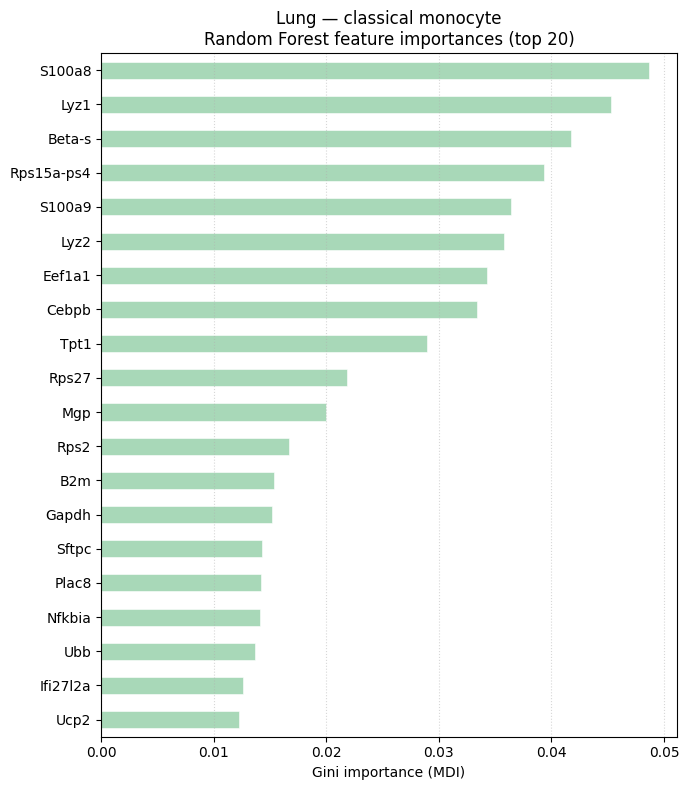

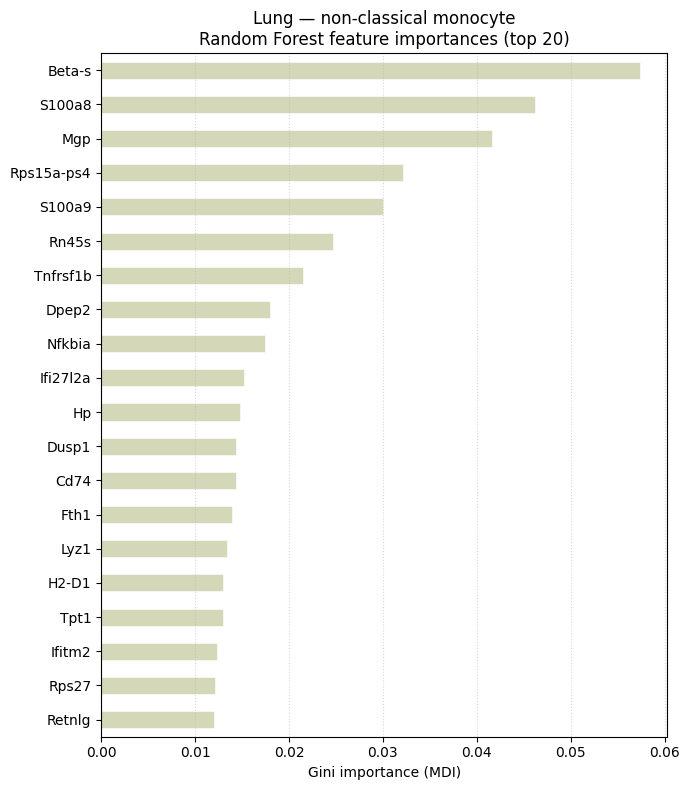

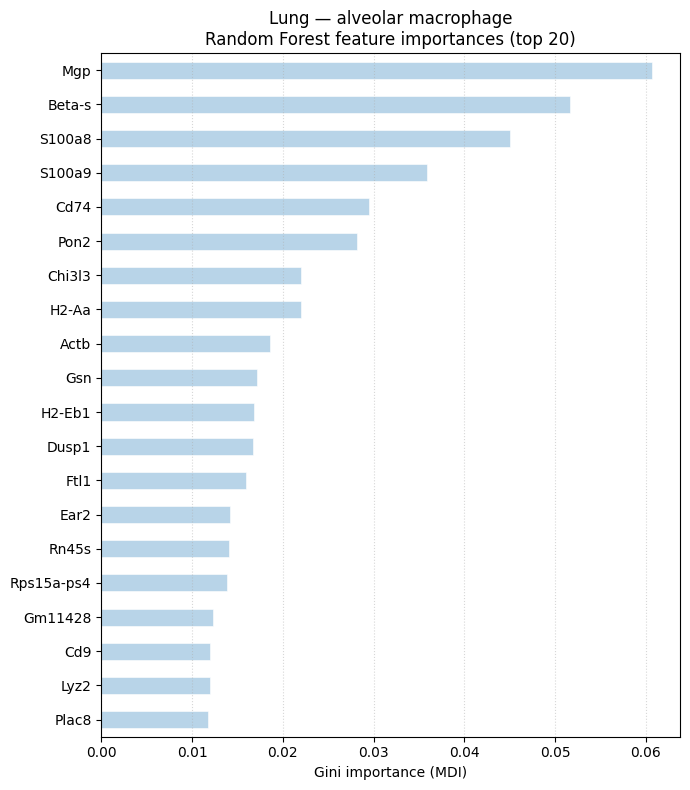

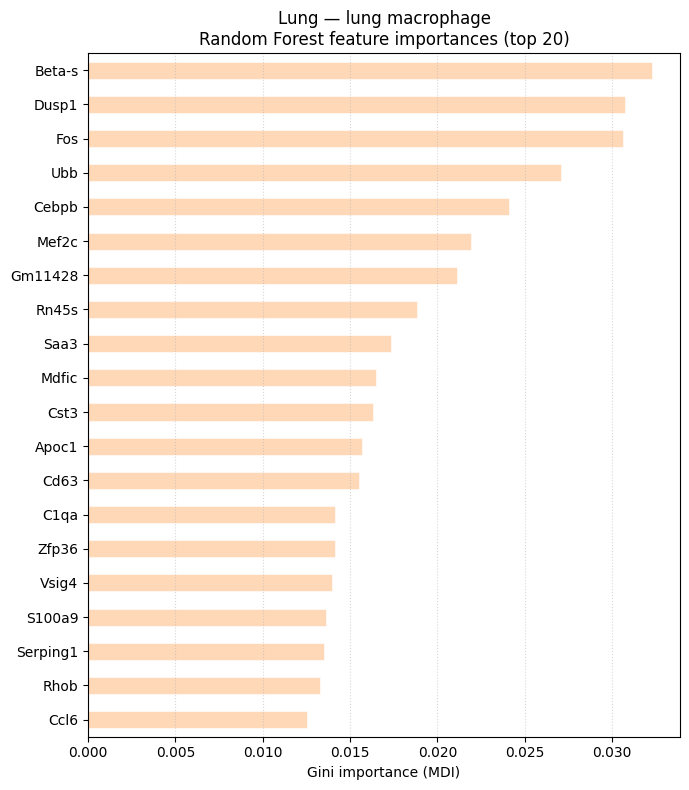

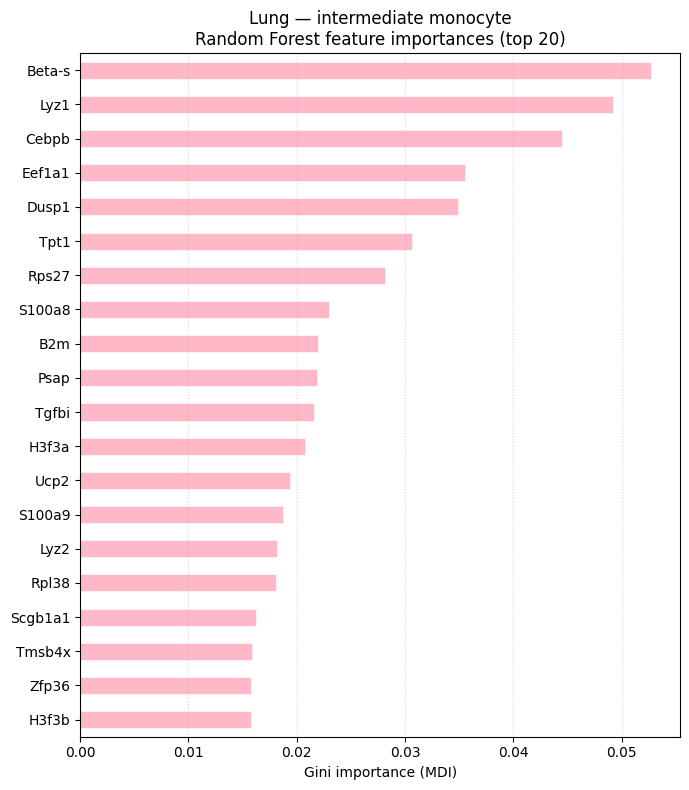

In [1]:
# ============================================
# FOLLOW-UP: RandomForest report using RF-selected genes (Lung only, CLS)
# - Learns RF genes per cell type via CV-averaged importances on HVGs
# - Saves top-N RF genes to CSV and reuses on subsequent runs
# - Confusion matrix in % (no decimals), coolwarm
# - ROC curves in pastel colors
# - Feature importance bar color = unique per cell type
# ============================================
import os, glob, gc, warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.ticker import PercentFormatter
from itertools import cycle
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report, accuracy_score, f1_score
from sklearn.model_selection import StratifiedKFold

# -------------------------
# Config
# -------------------------
H5AD_FOLDER = "/mnt/data/melhajjar/tabula_muris/all_tissues/"
OUTPUT_FOLDER = "/mnt/data/melhajjar/tabula_muris/all_tissues/scanvi_age_features_regression_model_final5_test2final_PLS_no1m_pres_final_workingcopy"

CELLTYPES_OF_INTEREST = [
    "alveolar macrophage",
    "macrophage",
    "monocyte",
    "classical monocyte",
    "intermediate monocyte",
    "non-classical monocyte",
    "Kupffer cell",
    "lung macrophage",
    "macrophage dendritic cell progenitor"
]

# Publication-ready pastel colors for each cell type
CELLTYPE_COLORS = {
    "alveolar macrophage": "#B8D4E8",           # Soft sky blue
    "macrophage": "#FFD4A3",                     # Peach
    "monocyte": "#D4B8D8",                       # Lavender
    "classical monocyte": "#A8D8B8",             # Mint green
    "intermediate monocyte": "#FFB8C8",          # Rose pink
    "non-classical monocyte": "#D4D8B8",         # Sage
    "Kupffer cell": "#B8D8D8",                   # Powder blue
    "lung macrophage": "#FFD8B8",                # Apricot
    "macrophage dendritic cell progenitor": "#C8B8E8"  # Periwinkle
}

RANDOM_SEED = 0
N_SPLITS = 5
RF_N_ESTIMATORS = 1000
RF_MAX_DEPTH = None
TOP_IMPORTANCE_PLOT = 20

# RF gene discovery settings
HVG_N_TOP = 3000          # how many HVGs to consider before RF
TOP_RF_GENES = 150        # how many RF-selected genes to use for final model

# Visuals
CM_NORMALIZE = "row"
CM_CONF = "YlGnBu"
ROC_PASTELS = [
    "#AEC6CF", "#FFB347", "#B39EB5", "#66C2A5", "#F49AC2",
    "#CFCFC4", "#BFD8B8", "#FFDAC1", "#E0BBE4", "#C7CEEA"
]
BAR_EDGE = "white"

np.random.seed(RANDOM_SEED)

# -------------------------
# Helpers
# -------------------------
def to_num_age(a):
    s = str(a).strip().lower()
    if s.endswith("m") and s[:-1].isdigit():
        return int(s[:-1])
    if s.isdigit():
        return int(s)
    return np.nan

def numeric_age_array(age_labels):
    return np.array([to_num_age(a) for a in age_labels], dtype=float)

def find_lung_h5ad(folder):
    exact = os.path.join(folder, "Lung.h5ad")
    if os.path.exists(exact):
        return exact, "Lung"
    cands = [f for f in os.listdir(folder) if f.lower().endswith(".h5ad") and "lung" in f.lower()]
    if not cands:
        raise FileNotFoundError("Could not find a Lung .h5ad in H5AD_FOLDER")
    path = os.path.join(folder, cands[0])
    tissue = os.path.splitext(os.path.basename(path))[0]
    return path, tissue

def choose_label_scheme(age_str_array):
    from collections import Counter
    y_orig = age_str_array.astype(str)
    cnt = Counter(y_orig)
    if len(cnt) >= 2 and min(cnt.values()) >= 2:
        return y_orig, "original"
    y_num = numeric_age_array(y_orig)
    qs = np.nanquantile(y_num, [1/3, 2/3])
    y_bin = np.array(["young" if a <= qs[0] else ("middle" if a <= qs[1] else "old") for a in y_num])
    return y_bin, "tertiles"

def sort_age_labels(labels):
    """Sort age labels in order: 1m, 3m, 18m, 30m"""
    age_order = {"1m": 0, "3m": 1, "18m": 2, "30m": 3,
                 "young": 0, "middle": 1, "old": 2}  # also handle tertiles
    sorted_labels = sorted(labels, key=lambda x: age_order.get(str(x).lower(), 999))
    return sorted_labels

def plot_confusion_matrix_percent(ax, cm_counts, classes, title_prefix):
    if CM_NORMALIZE == "row":
        denom = cm_counts.sum(axis=1, keepdims=True).astype(float)
        denom[denom == 0] = 1.0
        cm = cm_counts / denom
        norm_label = "row-normalized"
    elif CM_NORMALIZE == "col":
        denom = cm_counts.sum(axis=0, keepdims=True).astype(float)
        denom[denom == 0] = 1.0
        cm = cm_counts / denom
        norm_label = "column-normalized"
    else:
        total = cm_counts.sum()
        total = total if total > 0 else 1.0
        cm = cm_counts / total
        norm_label = "global-normalized"
    
    im = ax.imshow(cm, cmap=CM_CONF, vmin=0.0, vmax=1.0)
    ax.set_xticks(range(len(classes)))
    ax.set_xticklabels(classes, rotation=0)
    ax.set_yticks(range(len(classes)))
    ax.set_yticklabels(classes, rotation=0)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")
    
    for i in range(len(classes)):
        for j in range(len(classes)):
            pct = int(round(cm[i, j] * 100))
            color = "white" if cm[i, j] > 0.5 else "black"
            ax.text(j, i, f"{pct}%", ha="center", va="center", color=color, fontsize=11)
    
    ax.set_title(f"{title_prefix}\nConfusion matrix ({norm_label})")
    cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04, format=PercentFormatter(xmax=1))
    cbar.set_label("Percentage", rotation=270, labelpad=12)

def plot_roc_pastels(ax, y_true, proba, classes):
    macro_auc = 0.0
    color_cycle = cycle(ROC_PASTELS)
    for i, cls in enumerate(classes):
        y_bin = (y_true == cls).astype(int)
        # If a column is all-NaN (rare), skip gracefully
        col_idx = i
        if np.all(np.isnan(proba[:, col_idx])):
            continue
        fpr, tpr, _ = roc_curve(y_bin, np.nan_to_num(proba[:, col_idx], nan=0.0))
        roc_auc = auc(fpr, tpr)
        macro_auc += roc_auc
        ax.plot(fpr, tpr, lw=3.5, label=f"{cls} (AUC={roc_auc:.3f})", color=next(color_cycle))
    
    macro_auc /= max(1, len(classes))
    ax.plot([0,1],[0,1],"--",color="#999999", lw=1)
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_title(f"ROC (OvR) — macro AUC={macro_auc:.3f}")
    ax.legend(frameon=False, fontsize=9)
    return macro_auc

def _to_dense(X):
    return X.toarray() if hasattr(X, "toarray") else np.asarray(X, dtype=float)

def derive_or_load_rf_genes(output_dir, tissue, celltype, adata_ct, y_labels, n_splits, hvg_n_top, top_rf_genes):
    """
    Returns list of RF-selected genes. If a CSV already exists, loads it.
    Otherwise:
      1) compute HVGs within this cell type (Seurat v3, n_top=hvg_n_top)
      2) run StratifiedKFold RF on training folds, collect feature_importances_
      3) average importances, keep top top_rf_genes, save CSV
    """
    os.makedirs(output_dir, exist_ok=True)
    pattern = os.path.join(output_dir, f"{tissue}_{celltype}_rf_genes_top*.csv")
    files = sorted(glob.glob(pattern))

    if files:
        df = pd.read_csv(files[-1])
        genes = df["gene"].astype(str).tolist() if "gene" in df.columns else df.iloc[:,0].astype(str).tolist()
        return genes, files[-1], True

    # 1) HVGs
    ad = adata_ct.copy()
    # scale not required for RF; HVGs are just for pruning the search space
    sc.pp.highly_variable_genes(ad, flavor="seurat_v3", n_top_genes=min(hvg_n_top, adata_ct.n_vars), subset=True, inplace=True)

    X_all = _to_dense(ad.X)
    genes_all = ad.var_names.to_list()

    classes = np.unique(y_labels)
    if len(classes) < 2:
        return [], None, False

    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_SEED)
    agg_importance = np.zeros(X_all.shape[1], dtype=float)
    counts = np.zeros(X_all.shape[1], dtype=int)

    # 2) CV importances (train folds only)
    for tr, _te in skf.split(X_all, y_labels):
        rf = RandomForestClassifier(
            n_estimators=RF_N_ESTIMATORS,
            max_depth=RF_MAX_DEPTH,
            random_state=RANDOM_SEED,
            n_jobs=-1,
            class_weight="balanced"
        )
        rf.fit(X_all[tr], y_labels[tr])
        imp = rf.feature_importances_
        # accumulate
        agg_importance += imp
        counts += (imp > 0).astype(int)

    # 3) average & select
    with np.errstate(divide="ignore", invalid="ignore"):
        mean_importance = np.where(counts > 0, agg_importance / np.maximum(counts, 1), 0.0)

    imp_series = pd.Series(mean_importance, index=genes_all).sort_values(ascending=False)
    topN = min(top_rf_genes, imp_series.shape[0])
    top_genes = imp_series.head(topN).index.tolist()

    # save CSV
    out_csv = os.path.join(output_dir, f"{tissue}_{celltype}_rf_genes_top{topN}.csv")
    pd.DataFrame({"gene": top_genes, "mean_gini_importance": imp_series.head(topN).values}).to_csv(out_csv, index=False)
    return top_genes, out_csv, False

# -------------------------
# Load Lung and run per celltype
# -------------------------
h5ad_path, tissue = find_lung_h5ad(H5AD_FOLDER)
print(f"🫁 Using file: {h5ad_path} (tissue='{tissue}')")
adata = sc.read_h5ad(h5ad_path)

# Keep males only if present (matches your PLS run)
if "sex" in adata.obs.columns:
    adata = adata[adata.obs["sex"] != "female"].copy()

if "cell_ontology_class" not in adata.obs.columns:
    raise ValueError("Missing 'cell_ontology_class' in .obs.")

celltypes_present = [ct for ct in adata.obs["cell_ontology_class"].unique() if ct in CELLTYPES_OF_INTEREST]
if not celltypes_present:
    raise RuntimeError("None of the CELLTYPES_OF_INTEREST are present in this Lung file.")

for celltype in celltypes_present:
    print(f"\n🔍 RF report for celltype: {celltype}")
    adata_ct = adata[adata.obs["cell_ontology_class"] == celltype].copy()
    
    if adata_ct.n_obs < 20:
        print(" ⚠️ Too few cells; skipping.")
        continue
    
    # Age labels and numeric ages
    adata_ct.obs["age"] = adata_ct.obs["age"].astype(str)
    age_str = adata_ct.obs["age"].values
    num_age = numeric_age_array(age_str)
    valid = ~np.isnan(num_age)
    adata_ct = adata_ct[valid].copy()
    age_str = adata_ct.obs["age"].values
    num_age = num_age[valid]
    
    # Choose class labels (original if balanced enough; else tertiles)
    y_labels, label_mode = choose_label_scheme(age_str)
    classes = np.unique(y_labels)
    classes = np.array(sort_age_labels(classes))
    print(f" • Label mode: {label_mode} ({list(classes)})")
    
    if len(classes) < 2:
        print(" ⚠️ Only one class after labeling; skipping.")
        continue

    # =========================
    # RF-selected genes
    # =========================
    rf_genes, rf_csv, loaded = derive_or_load_rf_genes(
        OUTPUT_FOLDER, tissue, celltype, adata_ct, y_labels,
        n_splits=N_SPLITS, hvg_n_top=HVG_N_TOP, top_rf_genes=TOP_RF_GENES
    )
    if not rf_genes:
        print(" ⚠️ RF gene discovery returned no genes; skipping.")
        continue
    print(f" ✓ Using {len(rf_genes)} RF-selected genes ({'loaded' if loaded else 'derived'}): {os.path.basename(rf_csv) if rf_csv else 'in-memory'}")

    # Slice matrix to RF genes
    keep_genes = [g for g in rf_genes if g in adata_ct.var_names]
    if not keep_genes:
        print(" ⚠️ None of the RF-selected genes found in var_names; skipping.")
        continue
    
    X = adata_ct[:, keep_genes].X
    X = _to_dense(X)
    
    # Cell type color
    celltype_color = CELLTYPE_COLORS.get(celltype, "#FFB8A3")
    
    # -------------------------
    # 5-fold Stratified CV
    # -------------------------
    skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_SEED)
    rf = RandomForestClassifier(
        n_estimators=RF_N_ESTIMATORS,
        max_depth=RF_MAX_DEPTH,
        random_state=RANDOM_SEED,
        n_jobs=-1,
        class_weight="balanced"
    )
    
    y_true, y_pred = [], []
    y_prob = np.full((X.shape[0], len(classes)), np.nan, dtype=float)
    
    for fold, (tr, te) in enumerate(skf.split(X, y_labels), start=1):
        rf.fit(X[tr], y_labels[tr])
        pred = rf.predict(X[te])
        proba = rf.predict_proba(X[te])
        
        # map class order
        prob_full = np.zeros((len(te), len(classes)), dtype=float)
        for j, c in enumerate(rf.classes_):
            col = np.where(classes == c)[0][0]
            prob_full[:, col] = proba[:, j]
        
        y_true.extend(y_labels[te])
        y_pred.extend(pred)
        y_prob[te, :] = prob_full
    
    y_true = np.array(y_true, dtype=object)
    y_pred = np.array(y_pred, dtype=object)
    
    # Fit on all data for final importances (on the RF-selected gene space)
    rf.fit(X, y_labels)
    importances = pd.Series(rf.feature_importances_, index=keep_genes).sort_values(ascending=False)
    
    # -------------------------
    # PDF report
    # -------------------------
    pdf_base = f"{tissue}_{celltype}_RF_REPORT_CLS_ONLY_RFGENES"
    pdf_path = os.path.join(OUTPUT_FOLDER, pdf_base + ".pdf")
    
    with PdfPages(pdf_path) as pdf:
        # 1) Confusion matrix
        cm_counts = confusion_matrix(y_true, y_pred, labels=classes)
        fig, ax = plt.subplots(figsize=(5.4, 4.8))
        plot_confusion_matrix_percent(ax, cm_counts, classes, f"{tissue} – {celltype}")
        plt.tight_layout()
        pdf.savefig(fig)
        plt.close(fig)
        
        # 2) ROC curves
        fig, ax = plt.subplots(figsize=(5.8, 5.0))
        macro_auc = plot_roc_pastels(ax, y_true, y_prob, classes)
        plt.tight_layout()
        pdf.savefig(fig)
        plt.close(fig)
        
        # 3) Classification summary
        acc = accuracy_score(y_true, y_pred)
        f1m = f1_score(y_true, y_pred, average="macro")
        report = classification_report(y_true, y_pred, target_names=classes, digits=3)
        
        fig, ax = plt.subplots(figsize=(7.8, 6.0))
        ax.axis("off")
        txt = (f"{tissue} — {celltype}\n"
               f"Label mode: {label_mode}\n\n"
               f"Accuracy: {acc:.3f}\n"
               f"Macro-F1: {f1m:.3f}\n"
               f"Macro AUC (OvR): {macro_auc:.3f}\n"
               f"Samples: {len(y_true)}\n\n"
               f"{report}")
        ax.text(0.02, 0.98, txt, ha="left", va="top", family="monospace", fontsize=10)
        plt.tight_layout()
        pdf.savefig(fig)
        plt.close(fig)
        
        # 4) Class counts with sorted x-axis
        uniq_sorted = sort_age_labels(np.unique(y_labels))
        counts_dict = dict(zip(*np.unique(y_labels, return_counts=True)))
        counts_sorted = [counts_dict[label] for label in uniq_sorted]
        
        fig, ax = plt.subplots(figsize=(5.8, 3.8))
        ax.bar(uniq_sorted, counts_sorted, color=celltype_color, edgecolor=BAR_EDGE, linewidth=0.6)
        ax.set_title(f"{tissue} — {celltype} • Class counts ({label_mode})")
        ax.set_ylabel("# cells")
        ymax = max(counts_sorted) if counts_sorted else 1
        
        for x, c in zip(uniq_sorted, counts_sorted):
            ax.text(x, c + 0.02*ymax, str(c), ha="center", va="bottom", fontsize=9)
        
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.grid(axis="y", linestyle=":", alpha=0.4)
        plt.tight_layout()
        pdf.savefig(fig)
        plt.close(fig)
        
        # 5) Feature importance with cell type color
        topN = min(TOP_IMPORTANCE_PLOT, len(importances))
        fig, ax = plt.subplots(figsize=(7.0, 0.30*topN + 2.0))
        importances.head(topN).iloc[::-1].plot.barh(
            ax=ax, color=celltype_color, edgecolor=BAR_EDGE, linewidth=0.4
        )
        ax.set_xlabel("Gini importance (MDI)")
        ax.set_title(f"{tissue} — {celltype}\nRandom Forest feature importances (top {topN})")
        ax.grid(axis="x", linestyle=":", alpha=0.5)
        plt.tight_layout()
        pdf.savefig(fig)
        plt.close


In [12]:
# ============================================
# RF + Logistic Regression Comparison Report
# - Both models in same PDF for direct comparison
# - Auto-adjust CV folds to min(class count)
# - Confusion matrix in **counts**
# - PR & ROC curves for both models
# - Reports Accuracy, Balanced Acc, Macro-F1, Macro AUC, Macro AP, MCC
# ============================================
import os, glob, gc, warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    confusion_matrix, roc_curve, auc, classification_report, accuracy_score,
    f1_score, balanced_accuracy_score, matthews_corrcoef,
    average_precision_score, precision_recall_curve
)
from sklearn.model_selection import StratifiedKFold

# -------------------------
# Config
# -------------------------
H5AD_FOLDER = "/mnt/data/melhajjar/tabula_muris/all_tissues/"
OUTPUT_FOLDER = "/mnt/data/melhajjar/tabula_muris/all_tissues/scanvi_age_features_regression_model_final5_test2final_PLS_no1m_pres_final_workingcopy"

CELLTYPES_OF_INTEREST = [
    "alveolar macrophage",
    "macrophage",
    "monocyte",
    "classical monocyte",
    "intermediate monocyte",
    "non-classical monocyte",
    "Kupffer cell",
    "lung macrophage",
    "macrophage dendritic cell progenitor"
]

CELLTYPE_COLORS = {
    "alveolar macrophage": "#B8D4E8",
    "macrophage": "#FFD4A3",
    "monocyte": "#D4B8D8",
    "classical monocyte": "#A8D8B8",
    "intermediate monocyte": "#FFB8C8",
    "non-classical monocyte": "#D4D8B8",
    "Kupffer cell": "#B8D8D8",
    "lung macrophage": "#FFD8B8",
    "macrophage dendritic cell progenitor": "#C8B8E8"
}

RANDOM_SEED = 0
N_SPLITS_TARGET = 5
RF_N_ESTIMATORS = 1000
RF_MAX_DEPTH = None
TOP_IMPORTANCE_PLOT = 20

# Logistic Regression parameters
LR_C_VALUES = [0.01, 0.1, 1.0, 10.0]  # Try multiple regularization strengths

BAR_EDGE = "white"

# -------------------------
# Helpers
# -------------------------
def to_num_age(a):
    s = str(a).strip().lower()
    if s.endswith("m") and s[:-1].isdigit():
        return int(s[:-1])
    if s.isdigit():
        return int(s)
    return np.nan

def numeric_age_array(age_labels):
    return np.array([to_num_age(a) for a in age_labels], dtype=float)

def find_lung_h5ad(folder):
    exact = os.path.join(folder, "Lung.h5ad")
    if os.path.exists(exact):
        return exact, "Lung"
    cands = [f for f in os.listdir(folder) if f.lower().endswith(".h5ad") and "lung" in f.lower()]
    if not cands:
        raise FileNotFoundError("Could not find a Lung .h5ad in H5AD_FOLDER")
    path = os.path.join(folder, cands[0])
    tissue = os.path.splitext(os.path.basename(path))[0]
    return path, tissue

def load_age_driver_genes(output_dir, tissue, celltype):
    pattern = os.path.join(output_dir, f"{tissue}_{celltype}_age_driver_genes_top*.csv")
    files = sorted(glob.glob(pattern))
    if not files:
        raise FileNotFoundError(f"No age_driver_genes CSV found with pattern: {pattern}")
    df = pd.read_csv(files[-1])
    genes = df["gene"].astype(str).tolist() if "gene" in df.columns else df.iloc[:,0].astype(str).tolist()
    return genes, files[-1]

def sort_age_labels(labels):
    order = {"1m":0, "3m":1, "18m":2, "30m":3}
    return sorted(labels, key=lambda x: order.get(str(x), 999))

def effective_cv_folds(y):
    _, counts = np.unique(y, return_counts=True)
    min_count = int(counts.min()) if len(counts) else 0
    return max(2, min(N_SPLITS_TARGET, min_count))

def plot_confusion_matrix_counts(ax, cm_counts, classes, title):
    im = ax.imshow(cm_counts, cmap="YlGnBu", vmin=0)
    ax.set_xticks(range(len(classes))); ax.set_xticklabels(classes)
    ax.set_yticks(range(len(classes))); ax.set_yticklabels(classes)
    ax.set_xlabel("Predicted"); ax.set_ylabel("True")
    for i in range(len(classes)):
        for j in range(len(classes)):
            ax.text(j, i, f"{cm_counts[i, j]}", ha="center", va="center",
                    color="white" if cm_counts[i, j] > cm_counts.max()*0.6 else "black", fontsize=11)
    ax.set_title(f"{title}\nConfusion matrix (counts)")
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04).set_label("Count")

def train_and_evaluate_model(model, X, y_labels, classes, n_splits, model_name):
    """Generic training and evaluation for any sklearn classifier"""
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_SEED)
    
    y_true, y_pred = [], []
    y_prob = np.full((X.shape[0], len(classes)), np.nan, dtype=float)
    
    for tr, te in skf.split(X, y_labels):
        model.fit(X[tr], y_labels[tr])
        pred  = model.predict(X[te])
        proba = model.predict_proba(X[te])
        
        prob_full = np.zeros((len(te), len(classes)), dtype=float)
        for j, c in enumerate(model.classes_):
            col = np.where(classes == c)[0][0]
            prob_full[:, col] = proba[:, j]
        
        y_true.extend(y_labels[te])
        y_pred.extend(pred)
        y_prob[te, :] = prob_full
    
    y_true = np.array(y_true, dtype=object)
    y_pred = np.array(y_pred, dtype=object)
    
    # Metrics
    acc  = accuracy_score(y_true, y_pred)
    bacc = balanced_accuracy_score(y_true, y_pred)
    f1m  = f1_score(y_true, y_pred, average="macro")
    
    # OvR ROC AUC (macro)
    macro_auc = 0.0
    for i, cls in enumerate(classes):
        y_bin = (y_true == cls).astype(int)
        fpr, tpr, _ = roc_curve(y_bin, y_prob[:, i])
        macro_auc += auc(fpr, tpr)
    macro_auc /= len(classes)
    
    # OvR Average Precision (macro AUPRC)
    ap_per_class = []
    for i, cls in enumerate(classes):
        y_bin = (y_true == cls).astype(int)
        ap = average_precision_score(y_bin, y_prob[:, i])
        ap_per_class.append(ap)
    macro_ap = float(np.nanmean(ap_per_class))
    
    # MCC
    mcc = matthews_corrcoef(y_true, y_pred)
    
    results = {
        'y_true': y_true,
        'y_pred': y_pred,
        'y_prob': y_prob,
        'acc': acc,
        'bacc': bacc,
        'f1m': f1m,
        'macro_auc': macro_auc,
        'macro_ap': macro_ap,
        'ap_per_class': ap_per_class,
        'mcc': mcc,
        'model_name': model_name
    }
    
    return results

# -------------------------
# Load and run per cell type
# -------------------------
h5ad_path, tissue = find_lung_h5ad(H5AD_FOLDER)
print(f"🫁 Using file: {h5ad_path} (tissue='{tissue}')")
adata = sc.read_h5ad(h5ad_path)

adata = adata[adata.obs["age"] != "1m"].copy()

if "sex" in adata.obs.columns:
    adata = adata[adata.obs["sex"] != "female"].copy()

present = [ct for ct in adata.obs["cell_ontology_class"].unique() if ct in CELLTYPES_OF_INTEREST]
if not present:
    raise RuntimeError("None of the CELLTYPES_OF_INTEREST are present.")

for celltype in present:
    print(f"\n🔍 Processing celltype: {celltype}")
    adata_ct = adata[adata.obs["cell_ontology_class"] == celltype].copy()
    if adata_ct.n_obs < 20:
        print(" ⚠️ Too few cells; skipping.")
        continue
    
    # Labels
    adata_ct.obs["age"] = adata_ct.obs["age"].astype(str)
    age_str = adata_ct.obs["age"].values
    y_labels = age_str
    classes = np.array(sort_age_labels(np.unique(y_labels)))
    
    # Genes
    try:
        age_driver_genes, genes_csv = load_age_driver_genes(OUTPUT_FOLDER, tissue, celltype)
    except FileNotFoundError as e:
        print(" ⚠️", e); continue
    keep = [g for g in age_driver_genes if g in adata_ct.var_names]
    if not keep:
        print(" ⚠️ None of the selected genes found; skipping.")
        continue
    X = adata_ct[:, keep].X
    if hasattr(X, "toarray"): X = X.toarray()
    X = np.asarray(X, dtype=float)
    
    # CV folds
    n_splits = effective_cv_folds(y_labels)
    if n_splits < 2:
        print(" ⚠️ Not enough examples per class for CV; skipping.")
        continue
    if n_splits < N_SPLITS_TARGET:
        print(f" ⚠️ Shrinking CV folds from {N_SPLITS_TARGET} → {n_splits}")
    
    # ===== Train Random Forest =====
    print("   Training Random Forest...")
    rf = RandomForestClassifier(
        n_estimators=RF_N_ESTIMATORS,
        max_depth=RF_MAX_DEPTH,
        random_state=RANDOM_SEED,
        n_jobs=-1,
        class_weight="balanced"
    )
    rf_results = train_and_evaluate_model(rf, X, y_labels, classes, n_splits, "Random Forest")
    
    # Get RF importances
    rf.fit(X, y_labels)
    rf_importances = pd.Series(rf.feature_importances_, index=keep).sort_values(ascending=False)
    
    # ===== Train Logistic Regression (find best C) =====
    print("   Training Logistic Regression (testing regularization strengths)...")
    best_lr_results = None
    best_c = None
    best_auc = -1
    
    for c_val in LR_C_VALUES:
        lr = LogisticRegression(
            class_weight='balanced',
            max_iter=2000,
            multi_class='multinomial',
            solver='lbfgs',
            C=c_val,
            random_state=RANDOM_SEED
        )
        lr_results = train_and_evaluate_model(lr, X, y_labels, classes, n_splits, f"Logistic Regression (C={c_val})")
        
        if lr_results['macro_auc'] > best_auc:
            best_auc = lr_results['macro_auc']
            best_lr_results = lr_results
            best_c = c_val
    
    print(f"   Best Logistic Regression: C={best_c}, AUC={best_auc:.3f}")
    
    # Get LR coefficients
    lr_final = LogisticRegression(
        class_weight='balanced',
        max_iter=2000,
        multi_class='multinomial',
        solver='lbfgs',
        C=best_c,
        random_state=RANDOM_SEED
    )
    lr_final.fit(X, y_labels)
    # Average absolute coefficients across classes as "importance"
    lr_coef_importance = np.abs(lr_final.coef_).mean(axis=0)
    lr_importances = pd.Series(lr_coef_importance, index=keep).sort_values(ascending=False)
    
    # ===== PDF Report =====
    pdf_base = f"{tissue}_{celltype}_RF_LR_COMPARISON"
    pdf_path = os.path.join(OUTPUT_FOLDER, pdf_base + ".pdf")
    
    with PdfPages(pdf_path) as pdf:
        # Page 1: Class counts
        uniq, cnts = np.unique(y_labels, return_counts=True)
        order = sort_age_labels(uniq)
        counts_sorted = [dict(zip(uniq, cnts))[k] for k in order]
        fig, ax = plt.subplots(figsize=(6,4))
        ax.bar(order, counts_sorted, color=CELLTYPE_COLORS.get(celltype, "#B8D4E8"),
               edgecolor=BAR_EDGE, linewidth=0.6)
        ymax = max(counts_sorted) if counts_sorted else 1
        for x, c in zip(order, counts_sorted):
            ax.text(x, c + 0.02*ymax, str(c), ha="center", va="bottom", fontsize=10)
        ax.set_title(f"{tissue} — {celltype} • Class counts")
        ax.set_ylabel("# cells"); ax.grid(axis="y", linestyle=":", alpha=0.4)
        ax.spines["top"].set_visible(False); ax.spines["right"].set_visible(False)
        plt.tight_layout(); pdf.savefig(fig); plt.close(fig)
        
        # Page 2: Model Comparison Summary
        fig, ax = plt.subplots(figsize=(10, 6))
        ax.axis("off")
        
        comparison_text = f"""{tissue} — {celltype}
MODEL COMPARISON SUMMARY
{'='*60}

RANDOM FOREST:
  Accuracy:           {rf_results['acc']:.3f}
  Balanced Accuracy:  {rf_results['bacc']:.3f}
  Macro F1:           {rf_results['f1m']:.3f}
  Macro AUC (OvR):    {rf_results['macro_auc']:.3f}
  Macro AP (PR-AUC):  {rf_results['macro_ap']:.3f}
  MCC:                {rf_results['mcc']:.3f}

LOGISTIC REGRESSION (C={best_c}):
  Accuracy:           {best_lr_results['acc']:.3f}
  Balanced Accuracy:  {best_lr_results['bacc']:.3f}
  Macro F1:           {best_lr_results['f1m']:.3f}
  Macro AUC (OvR):    {best_lr_results['macro_auc']:.3f}
  Macro AP (PR-AUC):  {best_lr_results['macro_ap']:.3f}
  MCC:                {best_lr_results['mcc']:.3f}

IMPROVEMENT (LR vs RF):
  Δ AUC:              {best_lr_results['macro_auc'] - rf_results['macro_auc']:+.3f}
  Δ AP:               {best_lr_results['macro_ap'] - rf_results['macro_ap']:+.3f}
  Δ Balanced Acc:     {best_lr_results['bacc'] - rf_results['bacc']:+.3f}

Total samples: {len(y_labels)}
CV folds: {n_splits}
"""
        ax.text(0.05, 0.95, comparison_text, ha="left", va="top", 
                family="monospace", fontsize=11, transform=ax.transAxes)
        plt.tight_layout(); pdf.savefig(fig); plt.close(fig)
        
        # Page 3: RF Confusion Matrix
        cm_rf = confusion_matrix(rf_results['y_true'], rf_results['y_pred'], labels=classes)
        fig, ax = plt.subplots(figsize=(6,5))
        plot_confusion_matrix_counts(ax, cm_rf, classes, f"{tissue} — {celltype} (RF)")
        plt.tight_layout(); pdf.savefig(fig); plt.close(fig)
        
        # Page 4: LR Confusion Matrix
        cm_lr = confusion_matrix(best_lr_results['y_true'], best_lr_results['y_pred'], labels=classes)
        fig, ax = plt.subplots(figsize=(6,5))
        plot_confusion_matrix_counts(ax, cm_lr, classes, f"{tissue} — {celltype} (LR, C={best_c})")
        plt.tight_layout(); pdf.savefig(fig); plt.close(fig)
        
        # Page 5: ROC Comparison
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
        
        # RF ROC
        for i, cls in enumerate(classes):
            y_bin = (rf_results['y_true'] == cls).astype(int)
            fpr, tpr, _ = roc_curve(y_bin, rf_results['y_prob'][:, i])
            ax1.plot(fpr, tpr, lw=2.5, label=f"{cls}")
        ax1.plot([0,1],[0,1],'--',color="#999",lw=1)
        ax1.set_xlabel("FPR"); ax1.set_ylabel("TPR")
        ax1.set_title(f"Random Forest ROC\nmacro AUC={rf_results['macro_auc']:.3f}")
        ax1.legend(frameon=False, fontsize=9)
        
        # LR ROC
        for i, cls in enumerate(classes):
            y_bin = (best_lr_results['y_true'] == cls).astype(int)
            fpr, tpr, _ = roc_curve(y_bin, best_lr_results['y_prob'][:, i])
            ax2.plot(fpr, tpr, lw=2.5, label=f"{cls}")
        ax2.plot([0,1],[0,1],'--',color="#999",lw=1)
        ax2.set_xlabel("FPR"); ax2.set_ylabel("TPR")
        ax2.set_title(f"Logistic Regression ROC (C={best_c})\nmacro AUC={best_lr_results['macro_auc']:.3f}")
        ax2.legend(frameon=False, fontsize=9)
        
        plt.tight_layout(); pdf.savefig(fig); plt.close(fig)
        
        # Page 6: PR Comparison
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
        
        # RF PR
        for i, cls in enumerate(classes):
            y_bin = (rf_results['y_true'] == cls).astype(int)
            prec, rec, _ = precision_recall_curve(y_bin, rf_results['y_prob'][:, i])
            ax1.plot(rec, prec, lw=2.5, label=f"{cls} (AP={rf_results['ap_per_class'][i]:.3f})")
        ax1.set_xlabel("Recall"); ax1.set_ylabel("Precision")
        ax1.set_title(f"Random Forest PR\nmacro AP={rf_results['macro_ap']:.3f}")
        ax1.legend(frameon=False, fontsize=9)
        
        # LR PR
        for i, cls in enumerate(classes):
            y_bin = (best_lr_results['y_true'] == cls).astype(int)
            prec, rec, _ = precision_recall_curve(y_bin, best_lr_results['y_prob'][:, i])
            ax2.plot(rec, prec, lw=2.5, label=f"{cls} (AP={best_lr_results['ap_per_class'][i]:.3f})")
        ax2.set_xlabel("Recall"); ax2.set_ylabel("Precision")
        ax2.set_title(f"Logistic Regression PR (C={best_c})\nmacro AP={best_lr_results['macro_ap']:.3f}")
        ax2.legend(frameon=False, fontsize=9)
        
        plt.tight_layout(); pdf.savefig(fig); plt.close(fig)
        
        # Page 7: RF Classification Report
        report_rf = classification_report(rf_results['y_true'], rf_results['y_pred'], 
                                         target_names=classes, digits=3)
        fig, ax = plt.subplots(figsize=(8,6)); ax.axis("off")
        txt = f"RANDOM FOREST — Classification Report\n\n{report_rf}"
        ax.text(0.02, 0.98, txt, ha="left", va="top", family="monospace", fontsize=10)
        plt.tight_layout(); pdf.savefig(fig); plt.close(fig)
        
        # Page 8: LR Classification Report
        report_lr = classification_report(best_lr_results['y_true'], best_lr_results['y_pred'], 
                                         target_names=classes, digits=3)
        fig, ax = plt.subplots(figsize=(8,6)); ax.axis("off")
        txt = f"LOGISTIC REGRESSION (C={best_c}) — Classification Report\n\n{report_lr}"
        ax.text(0.02, 0.98, txt, ha="left", va="top", family="monospace", fontsize=10)
        plt.tight_layout(); pdf.savefig(fig); plt.close(fig)
        
        # Page 9: RF Feature Importances
        topN = min(TOP_IMPORTANCE_PLOT, len(rf_importances))
        fig, ax = plt.subplots(figsize=(7, 0.30*topN + 2.0))
        rf_importances.head(topN).iloc[::-1].plot.barh(
            ax=ax, color=CELLTYPE_COLORS.get(celltype, "#B8D4E8"),
            edgecolor=BAR_EDGE, linewidth=0.4
        )
        ax.set_xlabel("Gini importance (MDI)")
        ax.set_title(f"{tissue} — {celltype}\nRandom Forest feature importances (top {topN})")
        ax.grid(axis="x", linestyle=":", alpha=0.5)
        plt.tight_layout(); pdf.savefig(fig); plt.close(fig)
        
        # Page 10: LR Coefficient Importances
        topN = min(TOP_IMPORTANCE_PLOT, len(lr_importances))
        fig, ax = plt.subplots(figsize=(7, 0.30*topN + 2.0))
        lr_importances.head(topN).iloc[::-1].plot.barh(
            ax=ax, color=CELLTYPE_COLORS.get(celltype, "#B8D4E8"),
            edgecolor=BAR_EDGE, linewidth=0.4
        )
        ax.set_xlabel("Mean |coefficient|")
        ax.set_title(f"{tissue} — {celltype}\nLogistic Regression feature importances (top {topN})")
        ax.grid(axis="x", linestyle=":", alpha=0.5)
        plt.tight_layout(); pdf.savefig(fig); plt.close(fig)
    
    # CSV outputs
    # RF predictions
    proba_cols = [f"p_{c}" for c in classes]
    rf_oof = pd.DataFrame(rf_results['y_prob'], columns=proba_cols)
    rf_oof["true"] = rf_results['y_true']
    rf_oof["pred"] = rf_results['y_pred']
    rf_csv = os.path.join(OUTPUT_FOLDER, f"{tissue}_{celltype}_RF_predictions.csv")
    rf_oof.to_csv(rf_csv, index=False)
    
    # LR predictions
    lr_oof = pd.DataFrame(best_lr_results['y_prob'], columns=proba_cols)
    lr_oof["true"] = best_lr_results['y_true']
    lr_oof["pred"] = best_lr_results['y_pred']
    lr_csv = os.path.join(OUTPUT_FOLDER, f"{tissue}_{celltype}_LR_predictions.csv")
    lr_oof.to_csv(lr_csv, index=False)
    
    # Feature importances
    rf_imp_csv = os.path.join(OUTPUT_FOLDER, f"{tissue}_{celltype}_RF_importances.csv")
    rf_importances.to_csv(rf_imp_csv, header=["gini_importance"])
    
    lr_imp_csv = os.path.join(OUTPUT_FOLDER, f"{tissue}_{celltype}_LR_importances.csv")
    lr_importances.to_csv(lr_imp_csv, header=["mean_abs_coef"])
    
    print(f" ✅ Comparison report: {pdf_path}")
    print(f" 💾 RF predictions: {rf_csv}")
    print(f" 💾 LR predictions: {lr_csv}")
    print(f" 💾 RF importances: {rf_imp_csv}")
    print(f" 💾 LR importances: {lr_imp_csv}")
    
    del adata_ct, X, y_labels, rf_results, best_lr_results
    gc.collect()

print("\n🎉 Done.")

🫁 Using file: /mnt/data/melhajjar/tabula_muris/all_tissues/Lung.h5ad (tissue='Lung')

🔍 Processing celltype: classical monocyte
   Training Random Forest...
   Training Logistic Regression (testing regularization strengths)...
   Best Logistic Regression: C=1.0, AUC=0.610
 ✅ Comparison report: /mnt/data/melhajjar/tabula_muris/all_tissues/scanvi_age_features_regression_model_final5_test2final_PLS_no1m_pres_final_workingcopy/Lung_classical monocyte_RF_LR_COMPARISON.pdf
 💾 RF predictions: /mnt/data/melhajjar/tabula_muris/all_tissues/scanvi_age_features_regression_model_final5_test2final_PLS_no1m_pres_final_workingcopy/Lung_classical monocyte_RF_predictions.csv
 💾 LR predictions: /mnt/data/melhajjar/tabula_muris/all_tissues/scanvi_age_features_regression_model_final5_test2final_PLS_no1m_pres_final_workingcopy/Lung_classical monocyte_LR_predictions.csv
 💾 RF importances: /mnt/data/melhajjar/tabula_muris/all_tissues/scanvi_age_features_regression_model_final5_test2final_PLS_no1m_pres_final_w

In [1]:
# ============================================
# RF + Logistic Regression on POOLED macrophage/monocyte cells
# - Pools cell types (union) to address low per-subtype n
# - Merges marker panels across present cell types (union of CSV gene lists)
# - Single combined PDF with ROC/PR + confusion matrices
# - CSVs for OOF predictions and importances (RF & LR)
# ============================================
import os, glob, gc, warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    confusion_matrix, roc_curve, auc, classification_report, accuracy_score,
    f1_score, balanced_accuracy_score, matthews_corrcoef,
    average_precision_score, precision_recall_curve
)
from sklearn.model_selection import StratifiedKFold

# -------------------------
# Config
# -------------------------
H5AD_FOLDER = "/mnt/data/melhajjar/tabula_muris/all_tissues/"
OUTPUT_FOLDER = "/mnt/data/melhajjar/tabula_muris/all_tissues/scanvi_age_features_regression_model_final5_test2final_PLS_no1m_pres_final_workingcopy"

CELLTYPES_TO_POOL = [
    "alveolar macrophage",
    "macrophage",
    "monocyte",
    "classical monocyte",
    "intermediate monocyte",
    "non-classical monocyte",
    "Kupffer cell",
    "lung macrophage",
    "macrophage dendritic cell progenitor"
]

RANDOM_SEED = 0
N_SPLITS_TARGET = 5
RF_N_ESTIMATORS = 1000
RF_MAX_DEPTH = None
TOP_IMPORTANCE_PLOT = 30       # a bit larger since we merged panels
BAR_EDGE = "white"

# If True, restrict union to top-N genes per cell type (by CSV order).
# If None, take all from each CSV.
TOP_N_GENES_PER_CT = None

# -------------------------
# Helpers
# -------------------------
def sort_age_labels(labels):
    order = {"1m":0, "3m":1, "18m":2, "30m":3}
    return sorted(labels, key=lambda x: order.get(str(x), 999))

def effective_cv_folds(y):
    _, counts = np.unique(y, return_counts=True)
    min_count = int(counts.min()) if len(counts) else 0
    return max(2, min(N_SPLITS_TARGET, min_count))

def find_lung_h5ad(folder):
    exact = os.path.join(folder, "Lung.h5ad")
    if os.path.exists(exact):
        return exact, "Lung"
    cands = [f for f in os.listdir(folder) if f.lower().endswith(".h5ad") and "lung" in f.lower()]
    if not cands:
        raise FileNotFoundError("Could not find a Lung .h5ad in H5AD_FOLDER")
    path = os.path.join(folder, cands[0])
    tissue = os.path.splitext(os.path.basename(path))[0]
    return path, tissue

def load_age_driver_genes_one(output_dir, tissue, celltype, top_n=None):
    pattern = os.path.join(output_dir, f"{tissue}_{celltype}_age_driver_genes_top*.csv")
    files = sorted(glob.glob(pattern))
    if not files:
        return []
    df = pd.read_csv(files[-1])
    col = "gene" if "gene" in df.columns else df.columns[0]
    genes = df[col].astype(str).tolist()
    if top_n is not None:
        genes = genes[:top_n]
    return genes

def merge_marker_union(output_dir, tissue, present_cts, top_n=None):
    merged = set()
    provenance = {}
    for ct in present_cts:
        genes = load_age_driver_genes_one(output_dir, tissue, ct, top_n=top_n)
        if genes:
            merged.update(genes)
            provenance[ct] = len(genes)
    return list(merged), provenance

def plot_confusion_matrix_counts(ax, cm_counts, classes, title):
    im = ax.imshow(cm_counts, cmap="YlGnBu", vmin=0)
    ax.set_xticks(range(len(classes))); ax.set_xticklabels(classes)
    ax.set_yticks(range(len(classes))); ax.set_yticklabels(classes)
    ax.set_xlabel("Predicted"); ax.set_ylabel("True")
    for i in range(len(classes)):
        for j in range(len(classes)):
            val = cm_counts[i, j]
            ax.text(j, i, f"{val}", ha="center", va="center",
                    color="white" if val > cm_counts.max()*0.6 else "black", fontsize=11)
    ax.set_title(f"{title}\nConfusion matrix (counts)")
    cb = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cb.set_label("Count")

def train_and_evaluate_model(model, X, y_labels, classes, n_splits, model_name):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_SEED)
    y_true, y_pred = [], []
    y_prob = np.full((X.shape[0], len(classes)), np.nan, dtype=float)
    for tr, te in skf.split(X, y_labels):
        model.fit(X[tr], y_labels[tr])
        pred  = model.predict(X[te])
        proba = model.predict_proba(X[te])

        prob_full = np.zeros((len(te), len(classes)), dtype=float)
        for j, c in enumerate(model.classes_):
            col = np.where(classes == c)[0][0]
            prob_full[:, col] = proba[:, j]

        y_true.extend(y_labels[te])
        y_pred.extend(pred)
        y_prob[te, :] = prob_full

    y_true = np.array(y_true, dtype=object)
    y_pred = np.array(y_pred, dtype=object)

    acc  = accuracy_score(y_true, y_pred)
    bacc = balanced_accuracy_score(y_true, y_pred)
    f1m  = f1_score(y_true, y_pred, average="macro")

    macro_auc = 0.0
    for i, cls in enumerate(classes):
        y_bin = (y_true == cls).astype(int)
        fpr, tpr, _ = roc_curve(y_bin, y_prob[:, i])
        macro_auc += auc(fpr, tpr)
    macro_auc /= len(classes)

    ap_per_class = []
    for i, cls in enumerate(classes):
        y_bin = (y_true == cls).astype(int)
        ap = average_precision_score(y_bin, y_prob[:, i])
        ap_per_class.append(ap)
    macro_ap = float(np.nanmean(ap_per_class))

    mcc = matthews_corrcoef(y_true, y_pred)

    return {
        'y_true': y_true,
        'y_pred': y_pred,
        'y_prob': y_prob,
        'acc': acc,
        'bacc': bacc,
        'f1m': f1m,
        'macro_auc': macro_auc,
        'macro_ap': macro_ap,
        'ap_per_class': ap_per_class,
        'mcc': mcc,
        'model_name': model_name
    }

# -------------------------
# Load & pool cells
# -------------------------
h5ad_path, tissue = find_lung_h5ad(H5AD_FOLDER)
print(f"🫁 Using file: {h5ad_path} (tissue='{tissue}')")
adata = sc.read_h5ad(h5ad_path)

# Optional: male-only filter if needed (kept to match your previous runs)
if "sex" in adata.obs.columns:
    adata = adata[adata.obs["sex"] != "female"].copy()

if "cell_ontology_class" not in adata.obs.columns:
    raise KeyError("AnnData.obs must contain 'cell_ontology_class'")

present_cts = sorted([ct for ct in adata.obs["cell_ontology_class"].unique()
                      if ct in CELLTYPES_TO_POOL])
if not present_cts:
    raise RuntimeError("None of the requested macrophage/monocyte cell types are present.")

print("Pooling cell types:", present_cts)
adata_pool = adata[adata.obs["cell_ontology_class"].isin(present_cts)].copy()

# Labels
adata_pool.obs["age"] = adata_pool.obs["age"].astype(str)
y_labels = adata_pool.obs["age"].values
classes = np.array(sort_age_labels(np.unique(y_labels)))
print("Age classes in pooled data (sorted):", classes.tolist())

# -------------------------
# Merge markers (UNION across present cell types)
# -------------------------
merged_genes, provenance = merge_marker_union(
    OUTPUT_FOLDER, tissue, present_cts, top_n=TOP_N_GENES_PER_CT
)
print(f"Merged marker union size (pre-filter): {len(merged_genes)}")
if provenance:
    print("Gene counts per CT (from CSV):", provenance)

# Intersect with genes present in AnnData
keep = [g for g in merged_genes if g in adata_pool.var_names]
print(f"Markers present in AnnData: {len(keep)}")

if len(keep) == 0:
    raise RuntimeError("No merged markers found in AnnData.var_names — cannot proceed.")

X = adata_pool[:, keep].X
if hasattr(X, "toarray"):
    X = X.toarray()
X = np.asarray(X, dtype=float)

# -------------------------
# CV folds
# -------------------------
n_splits = effective_cv_folds(y_labels)
if n_splits < 2:
    raise RuntimeError("Not enough examples per class for CV.")
if n_splits < N_SPLITS_TARGET:
    print(f"⚠️ Shrinking CV folds from {N_SPLITS_TARGET} → {n_splits}")

# -------------------------
# Train RF
# -------------------------
print("Training Random Forest on pooled cells...")
rf = RandomForestClassifier(
    n_estimators=RF_N_ESTIMATORS,
    max_depth=RF_MAX_DEPTH,
    random_state=RANDOM_SEED,
    n_jobs=-1,
    class_weight="balanced"
)
rf_results = train_and_evaluate_model(rf, X, y_labels, classes, n_splits, "Random Forest")
rf.fit(X, y_labels)
rf_importances = pd.Series(rf.feature_importances_, index=keep).sort_values(ascending=False)

# -------------------------
# Train LR (choose best C)
# -------------------------
LR_C_VALUES = [0.01, 0.1, 1.0, 10.0]
print("Training Logistic Regression (grid over C) on pooled cells...")
best_lr_results, best_c, best_auc = None, None, -1
for c_val in LR_C_VALUES:
    lr = LogisticRegression(
        class_weight='balanced',
        max_iter=2000,
        multi_class='multinomial',
        solver='lbfgs',
        C=c_val,
        random_state=RANDOM_SEED
    )
    lr_results = train_and_evaluate_model(lr, X, y_labels, classes, n_splits,
                                          f"Logistic Regression (C={c_val})")
    if lr_results['macro_auc'] > best_auc:
        best_auc = lr_results['macro_auc']
        best_lr_results = lr_results
        best_c = c_val

print(f"Best LR C={best_c}, macro AUC={best_auc:.3f}")
lr_final = LogisticRegression(
    class_weight='balanced',
    max_iter=2000,
    multi_class='multinomial',
    solver='lbfgs',
    C=best_c,
    random_state=RANDOM_SEED
)
lr_final.fit(X, y_labels)
lr_coef_importance = np.abs(lr_final.coef_).mean(axis=0)
lr_importances = pd.Series(lr_coef_importance, index=keep).sort_values(ascending=False)

# -------------------------
# PDF Report
# -------------------------
pdf_base = f"{tissue}_Pooled_MacroMono_RF_LR_COMPARISON"
pdf_path = os.path.join(OUTPUT_FOLDER, pdf_base + ".pdf")

def page_counts(pdf):
    uniq, cnts = np.unique(y_labels, return_counts=True)
    order = sort_age_labels(uniq)
    counts_sorted = [dict(zip(uniq, cnts))[k] for k in order]
    fig, ax = plt.subplots(figsize=(6,4))
    ax.bar(order, counts_sorted, color="#B8D4E8", edgecolor=BAR_EDGE, linewidth=0.6)
    ymax = max(counts_sorted) if counts_sorted else 1
    for x, c in zip(order, counts_sorted):
        ax.text(x, c + 0.02*ymax, str(c), ha="center", va="bottom", fontsize=10)
    ax.set_title(f"{tissue} — Pooled Mac/Mono • Class counts")
    ax.set_ylabel("# cells"); ax.grid(axis="y", linestyle=":", alpha=0.4)
    ax.spines["top"].set_visible(False); ax.spines["right"].set_visible(False)
    plt.tight_layout(); pdf.savefig(fig); plt.close(fig)

def page_summary(pdf):
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.axis("off")
    comparison_text = f"""{tissue} — Pooled macrophage/monocyte
MODEL COMPARISON SUMMARY
{'='*60}

RANDOM FOREST:
  Accuracy:           {rf_results['acc']:.3f}
  Balanced Accuracy:  {rf_results['bacc']:.3f}
  Macro F1:           {rf_results['f1m']:.3f}
  Macro AUC (OvR):    {rf_results['macro_auc']:.3f}
  Macro AP (PR-AUC):  {rf_results['macro_ap']:.3f}
  MCC:                {rf_results['mcc']:.3f}

LOGISTIC REGRESSION (C={best_c}):
  Accuracy:           {best_lr_results['acc']:.3f}
  Balanced Accuracy:  {best_lr_results['bacc']:.3f}
  Macro F1:           {best_lr_results['f1m']:.3f}
  Macro AUC (OvR):    {best_lr_results['macro_auc']:.3f}
  Macro AP (PR-AUC):  {best_lr_results['macro_ap']:.3f}
  MCC:                {best_lr_results['mcc']:.3f}

IMPROVEMENT (LR vs RF):
  Δ AUC:              {best_lr_results['macro_auc'] - rf_results['macro_auc']:+.3f}
  Δ AP:               {best_lr_results['macro_ap'] - rf_results['macro_ap']:+.3f}
  Δ Balanced Acc:     {best_lr_results['bacc'] - rf_results['bacc']:+.3f}

Cells pooled from: {', '.join(present_cts)}
Merged marker union (in AnnData): {len(keep)} genes
Total samples: {len(y_labels)}    CV folds: {n_splits}
"""
    ax.text(0.05, 0.95, comparison_text, ha="left", va="top",
            family="monospace", fontsize=11, transform=ax.transAxes)
    plt.tight_layout(); pdf.savefig(fig); plt.close(fig)

def page_cm(pdf, results, title_suffix):
    cm = confusion_matrix(results['y_true'], results['y_pred'], labels=classes)
    fig, ax = plt.subplots(figsize=(6,5))
    plot_confusion_matrix_counts(ax, cm, classes, f"{tissue} — Pooled {title_suffix}")
    plt.tight_layout(); pdf.savefig(fig); plt.close(fig)

def page_roc_pr(pdf, rf_results, lr_results):
    # ROC
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    for i, cls in enumerate(classes):
        y_bin = (rf_results['y_true'] == cls).astype(int)
        fpr, tpr, _ = roc_curve(y_bin, rf_results['y_prob'][:, i])
        ax1.plot(fpr, tpr, lw=2.0, label=f"{cls}")
    ax1.plot([0,1],[0,1],'--',color="#999",lw=1)
    ax1.set_xlabel("FPR"); ax1.set_ylabel("TPR")
    ax1.set_title(f"RF ROC • macro AUC={rf_results['macro_auc']:.3f}")
    ax1.legend(frameon=False, fontsize=9)

    for i, cls in enumerate(classes):
        y_bin = (lr_results['y_true'] == cls).astype(int)
        fpr, tpr, _ = roc_curve(y_bin, lr_results['y_prob'][:, i])
        ax2.plot(fpr, tpr, lw=2.0, label=f"{cls}")
    ax2.plot([0,1],[0,1],'--',color="#999",lw=1)
    ax2.set_xlabel("FPR"); ax2.set_ylabel("TPR")
    ax2.set_title(f"LR ROC (C={best_c}) • macro AUC={lr_results['macro_auc']:.3f}")
    ax2.legend(frameon=False, fontsize=9)
    plt.tight_layout(); pdf.savefig(fig); plt.close(fig)

    # PR
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    for i, cls in enumerate(classes):
        y_bin = (rf_results['y_true'] == cls).astype(int)
        prec, rec, _ = precision_recall_curve(y_bin, rf_results['y_prob'][:, i])
        ax1.plot(rec, prec, lw=2.0, label=f"{cls} (AP={rf_results['ap_per_class'][i]:.3f})")
    ax1.set_xlabel("Recall"); ax1.set_ylabel("Precision")
    ax1.set_title(f"RF PR • macro AP={rf_results['macro_ap']:.3f}")
    ax1.legend(frameon=False, fontsize=9)

    for i, cls in enumerate(classes):
        y_bin = (lr_results['y_true'] == cls).astype(int)
        prec, rec, _ = precision_recall_curve(y_bin, lr_results['y_prob'][:, i])
        ax2.plot(rec, prec, lw=2.0, label=f"{cls} (AP={lr_results['ap_per_class'][i]:.3f})")
    ax2.set_xlabel("Recall"); ax2.set_ylabel("Precision")
    ax2.set_title(f"LR PR (C={best_c}) • macro AP={lr_results['macro_ap']:.3f}")
    ax2.legend(frameon=False, fontsize=9)
    plt.tight_layout(); pdf.savefig(fig); plt.close(fig)

def page_class_reports(pdf, results, title):
    rep = classification_report(results['y_true'], results['y_pred'],
                                target_names=classes, digits=3)
    fig, ax = plt.subplots(figsize=(8,6)); ax.axis("off")
    ax.text(0.02, 0.98, f"{title}\n\n{rep}", ha="left", va="top",
            family="monospace", fontsize=10)
    plt.tight_layout(); pdf.savefig(fig); plt.close(fig)

def page_importances(pdf, rf_imp, lr_imp):
    topN_rf = min(TOP_IMPORTANCE_PLOT, len(rf_imp))
    fig, ax = plt.subplots(figsize=(7, 0.30*topN_rf + 2.0))
    rf_imp.head(topN_rf).iloc[::-1].plot.barh(
        ax=ax, color="#B8D4E8", edgecolor=BAR_EDGE, linewidth=0.4
    )
    ax.set_xlabel("Gini importance (MDI)")
    ax.set_title(f"{tissue} — Pooled\nRandom Forest feature importances (top {topN_rf})")
    ax.grid(axis="x", linestyle=":", alpha=0.5)
    plt.tight_layout(); pdf.savefig(fig); plt.close(fig)

    topN_lr = min(TOP_IMPORTANCE_PLOT, len(lr_imp))
    fig, ax = plt.subplots(figsize=(7, 0.30*topN_lr + 2.0))
    lr_imp.head(topN_lr).iloc[::-1].plot.barh(
        ax=ax, color="#FFD4A3", edgecolor=BAR_EDGE, linewidth=0.4
    )
    ax.set_xlabel("Mean |coefficient|")
    ax.set_title(f"{tissue} — Pooled\nLogistic Regression feature importances (top {topN_lr})")
    ax.grid(axis="x", linestyle=":", alpha=0.5)
    plt.tight_layout(); pdf.savefig(fig); plt.close(fig)

with PdfPages(pdf_path) as pdf:
    page_counts(pdf)
    page_summary(pdf)
    page_cm(pdf, rf_results, "RF")
    page_cm(pdf, best_lr_results, f"LR (C={best_c})")
    page_roc_pr(pdf, rf_results, best_lr_results)
    page_class_reports(pdf, rf_results, "RANDOM FOREST — Classification Report")
    page_class_reports(pdf, best_lr_results, f"LOGISTIC REGRESSION (C={best_c}) — Classification Report")
    page_importances(pdf, rf_importances, lr_importances)

# -------------------------
# CSV outputs
# -------------------------
proba_cols = [f"p_{c}" for c in classes]

rf_oof = pd.DataFrame(rf_results['y_prob'], columns=proba_cols)
rf_oof["true"] = rf_results['y_true']
rf_oof["pred"] = rf_results['y_pred']
rf_csv = os.path.join(OUTPUT_FOLDER, f"{tissue}_Pooled_RF_predictions.csv")
rf_oof.to_csv(rf_csv, index=False)

lr_oof = pd.DataFrame(best_lr_results['y_prob'], columns=proba_cols)
lr_oof["true"] = best_lr_results['y_true']
lr_oof["pred"] = best_lr_results['y_pred']
lr_csv = os.path.join(OUTPUT_FOLDER, f"{tissue}_Pooled_LR_predictions.csv")
lr_oof.to_csv(lr_csv, index=False)

rf_imp_csv = os.path.join(OUTPUT_FOLDER, f"{tissue}_Pooled_RF_importances.csv")
rf_importances.to_csv(rf_imp_csv, header=["gini_importance"])

lr_imp_csv = os.path.join(OUTPUT_FOLDER, f"{tissue}_Pooled_LR_importances.csv")
lr_importances.to_csv(lr_imp_csv, header=["mean_abs_coef"])

print(f"\n✅ Pooled comparison PDF: {pdf_path}")
print(f"💾 RF predictions: {rf_csv}")
print(f"💾 LR predictions: {lr_csv}")
print(f"💾 RF importances: {rf_imp_csv}")
print(f"💾 LR importances: {lr_imp_csv}")
print("🎉 Done.")


🫁 Using file: /mnt/data/melhajjar/tabula_muris/all_tissues/Lung.h5ad (tissue='Lung')
Pooling cell types: ['alveolar macrophage', 'classical monocyte', 'intermediate monocyte', 'lung macrophage', 'non-classical monocyte']
Age classes in pooled data (sorted): ['1m', '3m', '18m', '30m']
Merged marker union size (pre-filter): 181
Gene counts per CT (from CSV): {'alveolar macrophage': 50, 'classical monocyte': 50, 'intermediate monocyte': 50, 'lung macrophage': 50, 'non-classical monocyte': 50}
Markers present in AnnData: 181
Training Random Forest on pooled cells...
Training Logistic Regression (grid over C) on pooled cells...
Best LR C=0.01, macro AUC=0.538

✅ Pooled comparison PDF: /mnt/data/melhajjar/tabula_muris/all_tissues/scanvi_age_features_regression_model_final5_test2final_PLS_no1m_pres_final_workingcopy/Lung_Pooled_MacroMono_RF_LR_COMPARISON.pdf
💾 RF predictions: /mnt/data/melhajjar/tabula_muris/all_tissues/scanvi_age_features_regression_model_final5_test2final_PLS_no1m_pres_fina

In [ ]:
# ============================================
# All Cells — RF & LR Age Classifier (No PLS)
# - Trains on ALL lung cells (no cell-type subset)
# - Optionally restricts to top HVGs (or use all genes)
# - Handles class imbalance with class_weight="balanced"
# - 5-fold StratifiedCV
# - Outputs a single multi-page PDF with:
#     * Class counts
#     * Model comparison summary
#     * Confusion matrices (counts)
#     * ROC & PR curves (OvR)
#     * Classification reports
#     * Feature importances (RF, LR | top 20)
# ============================================

import os, gc, warnings, datetime as dt
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    confusion_matrix, roc_curve, auc, classification_report,
    accuracy_score, f1_score, balanced_accuracy_score, matthews_corrcoef,
    average_precision_score, precision_recall_curve
)
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import label_binarize

# -------------------------
# Config
# -------------------------
H5AD_PATH       = "/mnt/data/melhajjar/tabula_muris/all_tissues/Lung.h5ad"  # <-- set this
AGE_KEY         = "age"                                # e.g., "1m","3m","18m","30m"
FILTER_MALE_ONLY= False                                # True to keep only male if "sex" in obs
USE_TOP_HVGS    = True                                 # False -> use ALL genes
N_HVGS          = 4000                                 # top HVGs
CV_FOLDS        = 5
RANDOM_STATE    = 42
LR_C            = 10.0                                 # LogisticRegression inverse regularization strength
RF_ESTIMATORS   = 600
RF_MAX_DEPTH    = None                                 # or e.g. 20
OUTPUT_DIR      = "./"                                 # where to save output PDF

# -------------------------
# Helpers
# -------------------------
def _ensure_dense(X):
    try:
        return X.toarray()
    except Exception:
        return np.asarray(X)

def _plot_class_counts(ax, y_classes, labels, title):
    counts = pd.value_counts(pd.Categorical(y_classes, categories=labels), sort=False)
    ax.bar(labels, counts.values)
    ax.set_title(title)
    ax.set_ylabel("# cells")
    ymax = counts.values.max() if len(counts) else 0
    for i, v in enumerate(counts.values):
        ax.text(i, v + max(1, ymax)*0.02, str(v), ha='center', va='bottom', fontsize=9)

def _macro_auc_ovr(y_true, probas, classes):
    """Macro AUC (OvR)."""
    Y = label_binarize(y_true, classes=classes)
    aucs = []
    for i, _ in enumerate(classes):
        fpr, tpr, _ = roc_curve(Y[:, i], probas[:, i])
        aucs.append(auc(fpr, tpr))
    return float(np.mean(aucs)), aucs

def _macro_ap_ovr(y_true, probas, classes):
    """Macro Average Precision (OvR)."""
    Y = label_binarize(y_true, classes=classes)
    aps = []
    for i, _ in enumerate(classes):
        aps.append(average_precision_score(Y[:, i], probas[:, i]))
    return float(np.mean(aps)), aps

def _plot_roc(ax, y_true, probas, classes, title_prefix):
    Y = label_binarize(y_true, classes=classes)
    aucs = []
    for i, cls in enumerate(classes):
        fpr, tpr, _ = roc_curve(Y[:, i], probas[:, i])
        ax.plot(fpr, tpr, label=str(cls))
        aucs.append(auc(fpr, tpr))
    ax.plot([0,1],[0,1], linestyle="--", linewidth=1)
    ax.set_title(f"{title_prefix} ROC\nmacro AUC={np.mean(aucs):.3f}")
    ax.set_xlabel("FPR"); ax.set_ylabel("TPR")
    ax.legend(title=None, prop={'size': 8})

def _plot_pr(ax, y_true, probas, classes, title_prefix):
    Y = label_binarize(y_true, classes=classes)
    aps = []
    for i, cls in enumerate(classes):
        precision, recall, _ = precision_recall_curve(Y[:, i], probas[:, i])
        ap = average_precision_score(Y[:, i], probas[:, i])
        ax.plot(recall, precision, label=f"{cls} (AP={ap:.3f})")
        aps.append(ap)
    ax.set_title(f"{title_prefix} PR\nmacro AP={np.mean(aps):.3f}")
    ax.set_xlabel("Recall"); ax.set_ylabel("Precision")
    ax.legend(title=None, prop={'size': 8})

def _plot_confusion(ax, y_true, y_pred, classes, title):
    cm = confusion_matrix(y_true, y_pred, labels=classes)
    im = ax.imshow(cm, aspect="auto")
    ax.set_title(title)
    ax.set_xlabel("Predicted"); ax.set_ylabel("True")
    ax.set_xticks(range(len(classes))); ax.set_yticks(range(len(classes)))
    ax.set_xticklabels(classes, rotation=0); ax.set_yticklabels(classes)
    # annotate counts
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, str(cm[i, j]), ha='center', va='center', fontsize=9)

def _top_rf_features(rf, feature_names, k=20):
    importances = getattr(rf, "feature_importances_", None)
    if importances is None:
        return []
    idx = np.argsort(importances)[::-1][:k]
    return list(zip(feature_names[idx], importances[idx]))

def _top_lr_features(lr, feature_names, k=20):
    # For multinomial OvR/ovr: coef_.shape = (n_classes, n_features)
    coefs = getattr(lr, "coef_", None)
    if coefs is None:
        return []
    abs_mean = np.mean(np.abs(coefs), axis=0)
    idx = np.argsort(abs_mean)[::-1][:k]
    return list(zip(feature_names[idx], abs_mean[idx]))

def _plot_top_features(ax, tuples, title, xlab):
    if not tuples:
        ax.text(0.5, 0.5, "N/A", ha='center', va='center')
        ax.set_title(title); ax.set_xlabel(xlab)
        return
    names, vals = zip(*tuples)
    y = np.arange(len(names))[::-1]
    ax.barh(y, vals)
    ax.set_yticks(y); ax.set_yticklabels(names, fontsize=8)
    ax.set_title(title); ax.set_xlabel(xlab)
    ax.invert_yaxis()

# -------------------------
# Load data
# -------------------------
print("[*] Loading AnnData:", H5AD_PATH)
adata = sc.read_h5ad(H5AD_PATH)
print(adata)

# optional: male only
if FILTER_MALE_ONLY and "sex" in adata.obs:
    before = adata.n_obs
    adata = adata[adata.obs["sex"] == "male"].copy()
    print(f"Filtered male-only: {before} -> {adata.n_obs}")
    
# Ensure AGE_KEY exists and not NA
assert AGE_KEY in adata.obs.columns, f"'{AGE_KEY}' not found in adata.obs"
adata = adata[~adata.obs[AGE_KEY].isna()].copy()

# -------------------------
# Feature space (HVGs or all)
# -------------------------
adata_X = adata
if USE_TOP_HVGS:
    print(f"Selecting top {N_HVGS} HVGs ...")
    sc.pp.highly_variable_genes(adata_X, n_top_genes=N_HVGS, flavor="seurat_v3")
    adata_X = adata_X[:, adata_X.var["highly_variable"]].copy()
    feature_names = adata_X.var_names.to_numpy()
else:
    feature_names = adata_X.var_names.to_numpy()

X = _ensure_dense(adata_X.X)
y = adata.obs[AGE_KEY].astype(str).to_numpy()

# preserve observed order
classes = list(pd.unique(y))
n_classes = len(classes)

print(f"Classes: {classes}")
counts = pd.value_counts(pd.Categorical(y, categories=classes), sort=False)
print("Class counts:\n", counts.to_string())

# -------------------------
# Models
# -------------------------
rf = RandomForestClassifier(
    n_estimators=RF_ESTIMATORS,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    max_depth=RF_MAX_DEPTH,
    class_weight="balanced"
)

lr = LogisticRegression(
    C=LR_C,
    penalty="l2",
    solver="lbfgs",
    multi_class="ovr",       # OvR for per-class ROC/PR
    max_iter=2000,
    class_weight="balanced",
    n_jobs=-1
)

# -------------------------
# CV & Evaluation
# -------------------------
skf = StratifiedKFold(n_splits=CV_FOLDS, shuffle=True, random_state=RANDOM_STATE)

def run_cv(model, name):
    y_true_all, y_pred_all, proba_all = [], [], []

    for fold, (tr, te) in enumerate(skf.split(X, y), 1):
        Xtr, Xte = X[tr], X[te]
        ytr, yte = y[tr], y[te]

        model.fit(Xtr, ytr)
        ypr = model.predict(Xte)

        if hasattr(model, "predict_proba"):
            p = model.predict_proba(Xte)
        else:
            if hasattr(model, "decision_function"):
                df = model.decision_function(Xte)
                exp_ = np.exp(df - df.max(axis=1, keepdims=True))
                p = exp_ / exp_.sum(axis=1, keepdims=True)
            else:
                p = label_binarize(ypr, classes=classes).astype(float)

        y_true_all.append(yte)
        y_pred_all.append(ypr)
        proba_all.append(p)

        print(f"[{name}] Fold {fold}/{CV_FOLDS} done.")

    y_true = np.concatenate(y_true_all)
    y_pred = np.concatenate(y_pred_all)
    probas = np.concatenate(proba_all, axis=0)

    acc  = accuracy_score(y_true, y_pred)
    bacc = balanced_accuracy_score(y_true, y_pred)
    mf1  = f1_score(y_true, y_pred, average="macro")
    mcc  = matthews_corrcoef(y_true, y_pred)
    mauc, per_cls_auc = _macro_auc_ovr(y_true, probas, classes)
    map_, per_cls_ap  = _macro_ap_ovr(y_true, probas, classes)

    # refit on full data to extract feature importance
    model.fit(X, y)

    results = {
        "y_true": y_true,
        "y_pred": y_pred,
        "probas": probas,
        "acc": acc, "bacc": bacc, "mf1": mf1, "mcc": mcc,
        "mauc": mauc, "per_cls_auc": per_cls_auc,
        "map": map_, "per_cls_ap": per_cls_ap,
        "model": model
    }
    return results

print("[*] Running CV for Random Forest ...")
rf_res = run_cv(rf, "RF")
gc.collect()

print("[*] Running CV for Logistic Regression ...")
lr_res = run_cv(lr, "LR")
gc.collect()

# -------------------------
# Build PDF
# -------------------------
ts = dt.datetime.now().strftime("%Y%m%d_%H%M%S")
pdf_path = os.path.join(OUTPUT_DIR, f"Lung_ALLCELLS_RF_LR_COMPARISON_{ts}.pdf")
with PdfPages(pdf_path) as pdf:
    # Page 1: class counts
    fig, ax = plt.subplots(figsize=(6,4), dpi=150)
    _plot_class_counts(ax, y, classes, "Lung  ALL CELLS  Class counts")
    pdf.savefig(fig); plt.close(fig)

    # Page 2: model comparison summary
    def _summary_block(title, res):
        return (
            f"{title}:\n"
            f"  Accuracy:           {res['acc']:.3f}\n"
            f"  Balanced Accuracy:  {res['bacc']:.3f}\n"
            f"  Macro F1:           {res['mf1']:.3f}\n"
            f"  Macro AUC (OvR):    {res['mauc']:.3f}\n"
            f"  Macro AP (PR-AUC):  {res['map']:.3f}\n"
            f"  MCC:                {res['mcc']:.3f}\n"
        )

    text = []
    text.append("LUNG  ALL CELLS\nMODEL COMPARISON SUMMARY")
    text.append("="*60)
    text.append(_summary_block("RANDOM FOREST", rf_res))
    text.append(_summary_block(f"LOGISTIC REGRESSION (C={LR_C})", lr_res))
    text.append("IMPROVEMENT (LR vs RF):")
    text.append(f"   AUC:              {lr_res['mauc'] - rf_res['mauc']:+.3f}")
    text.append(f"   AP:               {lr_res['map']  - rf_res['map']:+.3f}")
    text.append(f"   Balanced Acc:     {lr_res['bacc'] - rf_res['bacc']:+.3f}")
    text.append("")
    text.append(f"Total samples: {len(y)}")
    text.append(f"CV folds: {CV_FOLDS}")

    fig, ax = plt.subplots(figsize=(7.5, 5.5), dpi=150)
    ax.axis('off')
    ax.text(0.01, 0.98, "\n".join(text), va='top', ha='left', family="monospace", fontsize=9)
    pdf.savefig(fig); plt.close(fig)

    # Confusion matrices
    fig, axes = plt.subplots(1,2, figsize=(10,4), dpi=150)
    _plot_confusion(axes[0], rf_res["y_true"], rf_res["y_pred"], classes, "ALL CELLS (RF)\nConfusion matrix (counts)")
    _plot_confusion(axes[1], lr_res["y_true"], lr_res["y_pred"], classes, "ALL CELLS (LR)\nConfusion matrix (counts)")
    fig.tight_layout()
    pdf.savefig(fig); plt.close(fig)

    # ROC
    fig, axes = plt.subplots(1,2, figsize=(10,4), dpi=150)
    _plot_roc(axes[0], rf_res["y_true"], rf_res["probas"], classes, "Random Forest")
    _plot_roc(axes[1], lr_res["y_true"], lr_res["probas"], classes, f"Logistic Regression (C={LR_C})")
    fig.tight_layout()
    pdf.savefig(fig); plt.close(fig)

    # PR
    fig, axes = plt.subplots(1,2, figsize=(10,4), dpi=150)
    _plot_pr(axes[0], rf_res["y_true"], rf_res["probas"], classes, "Random Forest")
    _plot_pr(axes[1], lr_res["y_true"], lr_res["probas"], classes, f"Logistic Regression (C={LR_C})")
    fig.tight_layout()
    pdf.savefig(fig); plt.close(fig)

    # Classification reports (text pages)
    for name, res in [("RANDOM FOREST", rf_res), (f"LOGISTIC REGRESSION (C={LR_C})", lr_res)]:
        fig, ax = plt.subplots(figsize=(7.5, 5.5), dpi=150)
        ax.axis('off')
        rep = classification_report(res["y_true"], res["y_pred"], labels=classes, target_names=[str(c) for c in classes])
        ax.text(0.01, 0.98, f"{name}  Classification Report\n\n{rep}", va='top', ha='left', family="monospace", fontsize=9)
        pdf.savefig(fig); plt.close(fig)

    # Feature importances
    rf_top = _top_rf_features(rf_res["model"], feature_names, k=20)
    lr_top = _top_lr_features(lr_res["model"], feature_names, k=20)

    fig, axes = plt.subplots(1,2, figsize=(12,6), dpi=150)
    _plot_top_features(axes[0], rf_top, "ALL CELLS\nRandom Forest feature importances (top 20)", "Gini importance (MDI)")
    _plot_top_features(axes[1], lr_top, "ALL CELLS\nLogistic Regression feature importances (top 20)", "Mean |coefficient|")
    fig.tight_layout()
    pdf.savefig(fig); plt.close(fig)

print(f"[*] Saved: {pdf_path}")
print("[*] Done.")


[*] Loading AnnData: /mnt/data/melhajjar/tabula_muris/all_tissues/Lung.h5ad
AnnData object with n_obs × n_vars = 24540 × 20138
    obs: 'age', 'cell', 'cell_ontology_class', 'cell_ontology_id', 'free_annotation', 'method', 'mouse.id', 'n_genes', 'sex', 'subtissue', 'tissue', 'tissue_free_annotation'
    var: 'n_cells'
Selecting top 4000 HVGs ...
Classes: ['18m', '21m', '30m', '1m', '3m']
Class counts:
 18m     4376
21m     2951
30m    11093
1m      2508
3m      3612
[*] Running CV for Random Forest ...
[RF] Fold 1/5 done.
[RF] Fold 2/5 done.
[RF] Fold 3/5 done.
[RF] Fold 4/5 done.
[RF] Fold 5/5 done.
[*] Running CV for Logistic Regression ...


/bioinformatics/miniconda3/envs/scanpy_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/bioinformatics/miniconda3/envs/scanpy_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stab

[LR] Fold 1/5 done.


/bioinformatics/miniconda3/envs/scanpy_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/bioinformatics/miniconda3/envs/scanpy_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stab

[LR] Fold 2/5 done.


In [1]:
print("HI")

HI


In [1]:
# ============================================
# FAST RF (Male-only, no 1m) — Age Classifier
# - Keeps MALE mice only
# - Drops 1m group
# - Optional downsample to <= 2500 cells per age
# - Uses top HVGs (configurable) for speed
# - 5-fold Stratified CV
# - Outputs a compact PDF:
#     * Class counts (after filters)
#     * Model summary
#     * Confusion matrix (counts)
#     * ROC (with per-class AUC values)
#     * PR (OvR)
#     * Classification report
#     * Feature importances (top 20)
# ============================================

import os, gc, warnings, datetime as dt
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    confusion_matrix, roc_curve, auc, classification_report,
    accuracy_score, f1_score, balanced_accuracy_score, matthews_corrcoef,
    average_precision_score, precision_recall_curve
)
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import label_binarize

# -------------------------
# Config
# -------------------------
H5AD_PATH          = "/mnt/data/melhajjar/tabula_muris/all_tissues/Lung.h5ad"
AGE_KEY            = "age"
SEX_KEY            = "sex"
KEEP_SEX_VALUE     = "male"
DOWNSAMPLE         = True
TARGET_PER_CLASS   = 2500
USE_TOP_HVGS       = True
N_HVGS             = 3000
CV_FOLDS           = 5
RANDOM_STATE       = 42

# RF params
RF_ESTIMATORS      = 400
RF_MAX_DEPTH       = 20
RF_MIN_SAMPLES_LEAF= 2
RF_N_JOBS          = -1

OUTPUT_DIR         = "/mnt/data/melhajjar/tabula_muris/all_tissues/scanvi_age_features_regression_model_final5_test2final_PLS_no1m_pres_final_workingcopy"

# -------------------------
# Helpers
# -------------------------
def _ensure_dense(X):
    try: return X.toarray()
    except Exception: return np.asarray(X)

def _plot_class_counts(ax, y_classes, labels, title):
    counts = pd.value_counts(pd.Categorical(y_classes, categories=labels), sort=False)
    ax.bar(labels, counts.values)
    ax.set_title(title); ax.set_ylabel("# cells")
    ymax = counts.values.max() if len(counts) else 0
    for i, v in enumerate(counts.values):
        ax.text(i, v + max(1, ymax)*0.02, str(v), ha='center', va='bottom', fontsize=9)

def _plot_roc(ax, y_true, probas, classes, title_prefix):
    Y = label_binarize(y_true, classes=classes)
    for i, cls in enumerate(classes):
        fpr, tpr, _ = roc_curve(Y[:, i], probas[:, i])
        roc_auc = auc(fpr, tpr)
        ax.plot(fpr, tpr, label=f"{cls} (AUC={roc_auc:.3f})")
    ax.plot([0,1],[0,1], linestyle="--", linewidth=1)
    ax.set_title(f"{title_prefix} ROC")
    ax.set_xlabel("FPR"); ax.set_ylabel("TPR")
    ax.legend(title=None, prop={'size': 8})

def _plot_pr(ax, y_true, probas, classes, title_prefix):
    Y = label_binarize(y_true, classes=classes)
    aps = []
    for i, cls in enumerate(classes):
        precision, recall, _ = precision_recall_curve(Y[:, i], probas[:, i])
        ap = average_precision_score(Y[:, i], probas[:, i])
        ax.plot(recall, precision, label=f"{cls} (AP={ap:.3f})")
        aps.append(ap)
    ax.set_title(f"{title_prefix} PR\nmacro AP={np.mean(aps):.3f}")
    ax.set_xlabel("Recall"); ax.set_ylabel("Precision")
    ax.legend(title=None, prop={'size': 8})

def _plot_confusion(ax, y_true, y_pred, classes, title):
    cm = confusion_matrix(y_true, y_pred, labels=classes)
    ax.imshow(cm, aspect="auto")
    ax.set_title(title); ax.set_xlabel("Predicted"); ax.set_ylabel("True")
    ax.set_xticks(range(len(classes))); ax.set_yticks(range(len(classes)))
    ax.set_xticklabels(classes); ax.set_yticklabels(classes)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, str(cm[i, j]), ha='center', va='center', fontsize=9)

def _top_rf_features(rf, feature_names, k=20):
    importances = getattr(rf, "feature_importances_", None)
    if importances is None: return []
    idx = np.argsort(importances)[::-1][:k]
    return list(zip(feature_names[idx], importances[idx]))

def _plot_top_features(ax, tuples, title, xlab):
    if not tuples:
        ax.text(0.5, 0.5, "N/A", ha='center', va='center')
        ax.set_title(title); ax.set_xlabel(xlab); return
    names, vals = zip(*tuples)
    y = np.arange(len(names))[::-1]
    ax.barh(y, vals)
    ax.set_yticks(y); ax.set_yticklabels(names, fontsize=8)
    ax.set_title(title); ax.set_xlabel(xlab); ax.invert_yaxis()

def downsample_by_age(adata, age_key, target_n, random_state=42):
    rng = np.random.default_rng(random_state)
    ages = adata.obs[age_key].astype(str)
    keep_idx = []
    for a in pd.unique(ages):
        group_idx = np.where(ages.values == a)[0]
        if len(group_idx) <= target_n:
            pick = group_idx
        else:
            pick = rng.choice(group_idx, size=target_n, replace=False)
        keep_idx.append(pick)
    keep_idx = np.concatenate(keep_idx); keep_idx.sort()
    return adata[keep_idx].copy()

# -------------------------
# Load & filter
# -------------------------
adata = sc.read_h5ad(H5AD_PATH)

# male only
adata = adata[adata.obs[SEX_KEY].astype(str) == str(KEEP_SEX_VALUE)].copy()

adata = adata[adata.obs["age"] != "1m"].copy()


# optional downsample
# if DOWNSAMPLE:
#     adata = downsample_by_age(adata, AGE_KEY, TARGET_PER_CLASS, RANDOM_STATE)

# features
if USE_TOP_HVGS:
    sc.pp.highly_variable_genes(adata, n_top_genes=N_HVGS, flavor="seurat_v3")
    adata = adata[:, adata.var["highly_variable"]].copy()
feature_names = adata.var_names.to_numpy()

X = _ensure_dense(adata.X)
y = adata.obs[AGE_KEY].astype(str).to_numpy()
classes = list(pd.unique(y))

# -------------------------
# Model
# -------------------------
rf = RandomForestClassifier(
    n_estimators=RF_ESTIMATORS,
    random_state=RANDOM_STATE,
    n_jobs=RF_N_JOBS,
    max_depth=RF_MAX_DEPTH,
    min_samples_leaf=RF_MIN_SAMPLES_LEAF
)

# -------------------------
# CV & Eval
# -------------------------
skf = StratifiedKFold(n_splits=CV_FOLDS, shuffle=True, random_state=RANDOM_STATE)

y_true_all, y_pred_all, proba_all = [], [], []
for fold, (tr, te) in enumerate(skf.split(X, y), 1):
    rf.fit(X[tr], y[tr])
    ypr = rf.predict(X[te]); p = rf.predict_proba(X[te])
    y_true_all.append(y[te]); y_pred_all.append(ypr); proba_all.append(p)
    print(f"[RF] Fold {fold}/{CV_FOLDS} done.")

y_true = np.concatenate(y_true_all)
y_pred = np.concatenate(y_pred_all)
probas = np.concatenate(proba_all, axis=0)

# metrics
acc  = accuracy_score(y_true, y_pred)
bacc = balanced_accuracy_score(y_true, y_pred)
mf1  = f1_score(y_true, y_pred, average="macro")
mcc  = matthews_corrcoef(y_true, y_pred)

# final fit for importances
rf.fit(X, y)

# -------------------------
# PDF
# -------------------------
ts = dt.datetime.now().strftime("%Y%m%d_%H%M%S")
pdf_path = os.path.join(OUTPUT_DIR, f"Lung_MALEONLY_no1m_RF_{ts}.pdf")
with PdfPages(pdf_path) as pdf:
    # counts
    fig, ax = plt.subplots(figsize=(6,4), dpi=150)
    _plot_class_counts(ax, y, classes, "Class counts (male-only, no 1m)")
    pdf.savefig(fig); plt.close(fig)

    # summary
    text = (
        f"Random Forest (male-only, no 1m)\n"
        f"Accuracy:          {acc:.3f}\n"
        f"Balanced Accuracy: {bacc:.3f}\n"
        f"Macro F1:          {mf1:.3f}\n"
        f"MCC:               {mcc:.3f}\n"
        f"Samples: {len(y)} | Classes: {classes}\n"
    )
    fig, ax = plt.subplots(figsize=(7.5,5.5), dpi=150); ax.axis('off')
    ax.text(0.01, 0.98, text, va='top', ha='left', family="monospace", fontsize=9)
    pdf.savefig(fig); plt.close(fig)

    # confusion
    fig, ax = plt.subplots(figsize=(5.5,4.5), dpi=150)
    _plot_confusion(ax, y_true, y_pred, classes, "Confusion matrix (counts)")
    pdf.savefig(fig); plt.close(fig)

    # ROC with per-class AUC
    fig, ax = plt.subplots(figsize=(5.5,4.5), dpi=150)
    _plot_roc(ax, y_true, probas, classes, "Random Forest")
    pdf.savefig(fig); plt.close(fig)

    # PR
    fig, ax = plt.subplots(figsize=(5.5,4.5), dpi=150)
    _plot_pr(ax, y_true, probas, classes, "Random Forest")
    pdf.savefig(fig); plt.close(fig)

    # classification report
    fig, ax = plt.subplots(figsize=(7.5,5.5), dpi=150); ax.axis('off')
    rep = classification_report(y_true, y_pred, labels=classes, target_names=[str(c) for c in classes])
    ax.text(0.01, 0.98, f"Classification Report\n\n{rep}", va='top', ha='left', family="monospace", fontsize=9)
    pdf.savefig(fig); plt.close(fig)

    # features
    rf_top = _top_rf_features(rf, feature_names, k=20)
    fig, ax = plt.subplots(figsize=(8,6), dpi=150)
    _plot_top_features(ax, rf_top, "Top 20 RF features", "Gini importance")
    pdf.savefig(fig); plt.close(fig)

print(f"[*] Saved: {pdf_path}")


[RF] Fold 1/5 done.
[RF] Fold 2/5 done.
[RF] Fold 3/5 done.
[RF] Fold 4/5 done.
[RF] Fold 5/5 done.
[*] Saved: /mnt/data/melhajjar/tabula_muris/all_tissues/scanvi_age_features_regression_model_final5_test2final_PLS_no1m_pres_final_workingcopy/Lung_MALEONLY_no1m_RF_20251002_142931.pdf


In [2]:
# ============================================
# FAST RF (Male-only, no 1m) — with PLS biomarkers
# - Keeps MALE mice only
# - Drops 1m group
# - Optional downsample to <= 2500 cells per age
# - Baseline: RF on HVGs (or all genes)
# - PLS step: select biomarkers (VIP scores), then RF on biomarkers
# - 5-fold Stratified CV
# - Outputs one multi-page PDF comparing Baseline vs PLS biomarkers
# ============================================

import os, gc, warnings, datetime as dt
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    confusion_matrix, roc_curve, auc, classification_report,
    accuracy_score, f1_score, balanced_accuracy_score, matthews_corrcoef,
    average_precision_score, precision_recall_curve
)
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import label_binarize, StandardScaler
from sklearn.cross_decomposition import PLSRegression

# -------------------------
# Config
# -------------------------
H5AD_PATH           = "/mnt/data/melhajjar/tabula_muris/all_tissues/Lung.h5ad"
AGE_KEY             = "age"
SEX_KEY             = "sex"
KEEP_SEX_VALUE      = "male"

DROP_AGE_VALUES     = {"1m"}     # ages to remove entirely
DOWNSAMPLE          = True
TARGET_PER_CLASS    = 2500

# Baseline features
USE_TOP_HVGS        = True       # False -> use all genes as baseline
N_HVGS              = 3000

# PLS biomarker selection
RUN_PLS             = True
PLS_N_COMPONENTS    = 6          # tune if you like
PLS_TOP_GENES       = 400        # number of biomarkers to keep (by VIP)
PLS_SCALE_X         = True       # standardize genes before PLS (recommended)
PLS_STRATIFY_BY_AGE = False      # set True to compute PLS within CV folds (no leakage), but slower
# Note: If PLS_STRATIFY_BY_AGE=False, we compute PLS once on the full filtered set (like your prior workflow)
# to "prove PLS works" and then run RF on those biomarkers.

# CV / RF params
CV_FOLDS            = 5
RANDOM_STATE        = 42

RF_ESTIMATORS       = 400
RF_MAX_DEPTH        = 20
RF_MIN_SAMPLES_LEAF = 2
RF_N_JOBS           = -1

OUTPUT_DIR          = "/mnt/data/melhajjar/tabula_muris/all_tissues/scanvi_age_features_regression_model_final5_test2final_PLS_no1m_pres_final_workingcopy"

# -------------------------
# Helpers
# -------------------------
def _ensure_dense(X):
    try:
        return X.toarray()
    except Exception:
        return np.asarray(X)

def _plot_class_counts(ax, y_classes, labels, title):
    counts = pd.value_counts(pd.Categorical(y_classes, categories=labels), sort=False)
    ax.bar(labels, counts.values)
    ax.set_title(title); ax.set_ylabel("# cells")
    ymax = counts.values.max() if len(counts) else 0
    for i, v in enumerate(counts.values):
        ax.text(i, v + max(1, ymax)*0.02, str(v), ha='center', va='bottom', fontsize=9)

def _plot_roc(ax, y_true, probas, classes, title_prefix):
    Y = label_binarize(y_true, classes=classes)
    aucs = []
    for i, cls in enumerate(classes):
        fpr, tpr, _ = roc_curve(Y[:, i], probas[:, i])
        roc_auc = auc(fpr, tpr); aucs.append(roc_auc)
        ax.plot(fpr, tpr, label=f"{cls} (AUC={roc_auc:.3f})")
    ax.plot([0,1],[0,1], linestyle="--", linewidth=1)
    ax.set_title(f"{title_prefix} ROC  (macro AUC={np.mean(aucs):.3f})")
    ax.set_xlabel("FPR"); ax.set_ylabel("TPR")
    ax.legend(title=None, prop={'size': 8})

def _plot_pr(ax, y_true, probas, classes, title_prefix):
    Y = label_binarize(y_true, classes=classes)
    aps = []
    for i, cls in enumerate(classes):
        precision, recall, _ = precision_recall_curve(Y[:, i], probas[:, i])
        ap = average_precision_score(Y[:, i], probas[:, i]); aps.append(ap)
        ax.plot(recall, precision, label=f"{cls} (AP={ap:.3f})")
    ax.set_title(f"{title_prefix} PR  (macro AP={np.mean(aps):.3f})")
    ax.set_xlabel("Recall"); ax.set_ylabel("Precision")
    ax.legend(title=None, prop={'size': 8})

def _plot_confusion(ax, y_true, y_pred, classes, title):
    cm = confusion_matrix(y_true, y_pred, labels=classes)
    ax.imshow(cm, aspect="auto")
    ax.set_title(title); ax.set_xlabel("Predicted"); ax.set_ylabel("True")
    ax.set_xticks(range(len(classes))); ax.set_yticks(range(len(classes)))
    ax.set_xticklabels(classes); ax.set_yticklabels(classes)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, str(cm[i, j]), ha='center', va='center', fontsize=9)

def _top_rf_features(rf, feature_names, k=20):
    importances = getattr(rf, "feature_importances_", None)
    if importances is None: return []
    idx = np.argsort(importances)[::-1][:k]
    return list(zip(feature_names[idx], importances[idx]))

def _plot_top_features(ax, tuples, title, xlab):
    if not tuples:
        ax.text(0.5, 0.5, "N/A", ha='center', va='center')
        ax.set_title(title); ax.set_xlabel(xlab); return
    names, vals = zip(*tuples)
    y = np.arange(len(names))[::-1]
    ax.barh(y, vals)
    ax.set_yticks(y); ax.set_yticklabels(names, fontsize=8)
    ax.set_title(title); ax.set_xlabel(xlab); ax.invert_yaxis()

def downsample_by_age(adata, age_key, target_n, random_state=42):
    rng = np.random.default_rng(random_state)
    ages = adata.obs[age_key].astype(str)
    keep_idx = []
    for a in pd.unique(ages):
        group_idx = np.where(ages.values == a)[0]
        if len(group_idx) <= target_n:
            pick = group_idx
        else:
            pick = rng.choice(group_idx, size=target_n, replace=False)
        keep_idx.append(pick)
    keep_idx = np.concatenate(keep_idx); keep_idx.sort()
    return adata[keep_idx].copy()

# --- PLS utilities ---
def _one_hot_labels(y, classes):
    Y = np.zeros((len(y), len(classes)), dtype=float)
    m = {c:i for i,c in enumerate(classes)}
    for idx, lab in enumerate(y):
        Y[idx, m[lab]] = 1.0
    return Y

def _compute_pls_vip(pls, X, Y):
    """
    VIP scores for PLSRegression (Wold's VIP).
    X: (n_samples, n_features), Y: (n_samples, n_targets)
    Returns vip: (n_features,)
    """
    # Ensure numpy
    X = np.asarray(X, dtype=float)
    # T: scores, P: X loadings, Q: Y loadings, W: weights
    T = pls.x_scores_      # (n, A)
    P = pls.x_loadings_    # (p, A)
    Q = pls.y_loadings_    # (q, A)
    W = pls.x_weights_     # (p, A)
    # Explained Y variance per component
    # SSY per comp: sum of squares of T[:,a] * Q[:,a]^2 (across targets)
    ssy = []
    for a in range(Q.shape[1]):
        ssy_a = np.sum((T[:, a][:, None] @ Q[:, a][None, :])**2)
        ssy.append(ssy_a)
    ssy = np.array(ssy)   # shape (A,)
    ssy_tot = np.sum(ssy)
    p = W.shape[0]
    vip = np.zeros((p,))
    for j in range(p):
        wj = W[j, :]               # weights across components
        vip[j] = np.sqrt(p * np.sum(ssy * (wj**2) / np.sum(W**2, axis=0)) / ssy_tot)
    return vip

def select_pls_biomarkers(X, y, genes, classes, n_components=6, top_k=400, scale_x=True, random_state=42):
    """
    Compute PLS on full (filtered) set to select biomarkers by VIP.
    Returns indices and gene names of top_k biomarkers.
    """
    X_use = X.copy()
    if scale_x:
        scaler = StandardScaler(with_mean=True, with_std=True)
        X_use = scaler.fit_transform(X_use)

    Y = _one_hot_labels(y, classes)
    pls = PLSRegression(n_components=n_components, scale=False)  # already scaled if scale_x=True
    pls.fit(X_use, Y)

    vip = _compute_pls_vip(pls, X_use, Y)  # (n_genes,)
    idx = np.argsort(vip)[::-1][:top_k]
    return idx, genes[idx], vip

# -------------------------
# Load & filter
# -------------------------
adata = sc.read_h5ad(H5AD_PATH)

# male only
adata = adata[adata.obs[SEX_KEY].astype(str) == str(KEEP_SEX_VALUE)].copy()

# drop selected ages (e.g., 1m)
adata = adata[~adata.obs[AGE_KEY].astype(str).isin(DROP_AGE_VALUES)].copy()

# optional downsample per age
if DOWNSAMPLE:
    adata = downsample_by_age(adata, AGE_KEY, TARGET_PER_CLASS, RANDOM_STATE)

# -------------------------
# Feature space (Baseline)
# -------------------------
adata_b = adata.copy()
if USE_TOP_HVGS:
    sc.pp.highly_variable_genes(adata_b, n_top_genes=N_HVGS, flavor="seurat_v3")
    adata_b = adata_b[:, adata_b.var["highly_variable"]].copy()
genes_baseline = adata_b.var_names.to_numpy()

X_b = _ensure_dense(adata_b.X)
y = adata_b.obs[AGE_KEY].astype(str).to_numpy()
classes = list(pd.unique(y))

# -------------------------
# PLS biomarker selection (optional)
# -------------------------
pls_idx = None; genes_pls = None; vip_scores = None
if RUN_PLS:
    pls_idx, genes_pls, vip_scores = select_pls_biomarkers(
        X=X_b, y=y, genes=genes_baseline, classes=classes,
        n_components=PLS_N_COMPONENTS, top_k=PLS_TOP_GENES, scale_x=PLS_SCALE_X,
        random_state=RANDOM_STATE
    )

# -------------------------
# RF model
# -------------------------
def make_rf():
    return RandomForestClassifier(
        n_estimators=RF_ESTIMATORS,
        random_state=RANDOM_STATE,
        n_jobs=RF_N_JOBS,
        max_depth=RF_MAX_DEPTH,
        min_samples_leaf=RF_MIN_SAMPLES_LEAF
    )

skf = StratifiedKFold(n_splits=CV_FOLDS, shuffle=True, random_state=RANDOM_STATE)

def evaluate_with_features(Xmat, y, classes, feature_names, label):
    rf = make_rf()
    y_true_all, y_pred_all, proba_all = [], [], []
    for fold, (tr, te) in enumerate(skf.split(Xmat, y), 1):
        rf.fit(Xmat[tr], y[tr])
        ypr = rf.predict(Xmat[te]); p = rf.predict_proba(Xmat[te])
        y_true_all.append(y[te]); y_pred_all.append(ypr); proba_all.append(p)
        print(f"[RF-{label}] Fold {fold}/{CV_FOLDS} done.")
    y_true = np.concatenate(y_true_all)
    y_pred = np.concatenate(y_pred_all)
    probas = np.concatenate(proba_all, axis=0)

    acc  = accuracy_score(y_true, y_pred)
    bacc = balanced_accuracy_score(y_true, y_pred)
    mf1  = f1_score(y_true, y_pred, average="macro")
    mcc  = matthews_corrcoef(y_true, y_pred)

    # refit on full for importances
    rf.fit(Xmat, y)

    # compute macro AUC/AP
    Ybin = label_binarize(y_true, classes=classes)
    aucs = []; aps = []
    for i in range(len(classes)):
        fpr, tpr, _ = roc_curve(Ybin[:, i], probas[:, i])
        aucs.append(auc(fpr, tpr))
        aps.append(average_precision_score(Ybin[:, i], probas[:, i]))
    mauc = float(np.mean(aucs)); map_ = float(np.mean(aps))
    return {
        "y_true": y_true, "y_pred": y_pred, "probas": probas,
        "acc": acc, "bacc": bacc, "mf1": mf1, "mcc": mcc, "mauc": mauc, "map": map_,
        "rf": rf, "feature_names": feature_names
    }

# Baseline evaluation (HVGs or all genes)
res_base = evaluate_with_features(X_b, y, classes, genes_baseline, label="BASE")

# PLS biomarkers evaluation
res_pls = None
if RUN_PLS and pls_idx is not None and len(pls_idx) > 0:
    X_p = X_b[:, pls_idx]
    genes_p = genes_pls
    res_pls = evaluate_with_features(X_p, y, classes, genes_p, label="PLS")

# -------------------------
# Build PDF
# -------------------------
ts = dt.datetime.now().strftime("%Y%m%d_%H%M%S")
pdf_path = os.path.join(OUTPUT_DIR, f"Lung_MALEONLY_no1m_RF_withPLS_{ts}.pdf")
with PdfPages(pdf_path) as pdf:
    # Page 1: class counts
    fig, ax = plt.subplots(figsize=(6,4), dpi=150)
    title_counts = f"Class counts (male-only, no 1m)"
    if DOWNSAMPLE: title_counts += f"  (<= {TARGET_PER_CLASS}/age)"
    _plot_class_counts(ax, y, classes, title_counts)
    pdf.savefig(fig); plt.close(fig)

    # Page 2: Comparison summary
    def _fmt(res, tag):
        return (
            f"{tag}:\n"
            f"  Accuracy:           {res['acc']:.3f}\n"
            f"  Balanced Accuracy:  {res['bacc']:.3f}\n"
            f"  Macro F1:           {res['mf1']:.3f}\n"
            f"  Macro AUC (OvR):    {res['mauc']:.3f}\n"
            f"  Macro AP (PR-AUC):  {res['map']:.3f}\n"
            f"  MCC:                {res['mcc']:.3f}\n"
            f"  #Features:          {len(res['feature_names'])}\n"
        )
    text = []
    text.append("RF Comparison — Baseline vs PLS Biomarkers")
    text.append("="*60)
    text.append(_fmt(res_base, "BASELINE (HVGs)" if USE_TOP_HVGS else "BASELINE (All genes)"))
    if res_pls is not None:
        text.append(_fmt(res_pls, f"PLS biomarkers (top {PLS_TOP_GENES})"))
        text.append("IMPROVEMENT (PLS − Base):")
        text.append(f"   AUC:              {res_pls['mauc'] - res_base['mauc']:+.3f}")
        text.append(f"   AP:               {res_pls['map']  - res_base['map']:+.3f}")
        text.append(f"   Balanced Acc:     {res_pls['bacc'] - res_base['bacc']:+.3f}")
    text.append("")
    text.append(f"Samples: {len(y)} | Classes: {classes}")
    text.append(f"PLS: n_components={PLS_N_COMPONENTS}, top_k={PLS_TOP_GENES}, scale_x={PLS_SCALE_X}")
    fig, ax = plt.subplots(figsize=(7.5, 5.5), dpi=150); ax.axis('off')
    ax.text(0.01, 0.98, "\n".join(text), va='top', ha='left', family="monospace", fontsize=9)
    pdf.savefig(fig); plt.close(fig)

    # Page 3–4: Confusion matrices
    fig, axes = plt.subplots(1, 2 if res_pls is not None else 1, figsize=(10,4), dpi=150)
    if res_pls is None:
        axes = [axes]
    _plot_confusion(axes[0], res_base["y_true"], res_base["y_pred"], classes, "BASELINE — Confusion matrix")
    if res_pls is not None:
        _plot_confusion(axes[1], res_pls["y_true"], res_pls["y_pred"], classes, "PLS biomarkers — Confusion matrix")
    fig.tight_layout(); pdf.savefig(fig); plt.close(fig)

    # Page 5–6: ROC (with per-class AUC)
    fig, axes = plt.subplots(1, 2 if res_pls is not None else 1, figsize=(10,4), dpi=150)
    if res_pls is None:
        axes = [axes]
    _plot_roc(axes[0], res_base["y_true"], res_base["probas"], classes, "BASELINE")
    if res_pls is not None:
        _plot_roc(axes[1], res_pls["y_true"], res_pls["probas"], classes, "PLS biomarkers")
    fig.tight_layout(); pdf.savefig(fig); plt.close(fig)

    # Page 7–8: PR
    fig, axes = plt.subplots(1, 2 if res_pls is not None else 1, figsize=(10,4), dpi=150)
    if res_pls is None:
        axes = [axes]
    _plot_pr(axes[0], res_base["y_true"], res_base["probas"], classes, "BASELINE")
    if res_pls is not None:
        _plot_pr(axes[1], res_pls["y_true"], res_pls["probas"], classes, "PLS biomarkers")
    fig.tight_layout(); pdf.savefig(fig); plt.close(fig)

    # Page 9–10: Classification reports
    fig, axes = plt.subplots(1, 2 if res_pls is not None else 1, figsize=(12,5.5), dpi=150)
    if res_pls is None:
        axes = [axes]
    axes[0].axis('off')
    rep_base = classification_report(res_base["y_true"], res_base["y_pred"], labels=classes, target_names=[str(c) for c in classes])
    axes[0].text(0.01, 0.98, f"BASELINE — Classification Report\n\n{rep_base}", va='top', ha='left', family="monospace", fontsize=9)
    if res_pls is not None:
        axes[1].axis('off')
        rep_pls = classification_report(res_pls["y_true"], res_pls["y_pred"], labels=classes, target_names=[str(c) for c in classes])
        axes[1].text(0.01, 0.98, f"PLS biomarkers — Classification Report\n\n{rep_pls}", va='top', ha='left', family="monospace", fontsize=9)
    pdf.savefig(fig); plt.close(fig)

    # Page 11–12: Feature importances (RF)
    fig, axes = plt.subplots(1, 2 if res_pls is not None else 1, figsize=(12,6), dpi=150)
    if res_pls is None:
        axes = [axes]
    rf_top_base = _top_rf_features(res_base["rf"], res_base["feature_names"], k=20)
    _plot_top_features(axes[0], rf_top_base, "BASELINE — RF feature importances (top 20)", "Gini importance (MDI)")
    if res_pls is not None:
        rf_top_pls = _top_rf_features(res_pls["rf"], res_pls["feature_names"], k=20)
        _plot_top_features(axes[1], rf_top_pls, "PLS biomarkers — RF feature importances (top 20)", "Gini importance (MDI)")
    fig.tight_layout(); pdf.savefig(fig); plt.close(fig)

    # Page 13: PLS VIP table (top 40) — if available
    if res_pls is not None and vip_scores is not None:
        top_show = min(40, len(genes_pls))
        idx_show = np.argsort(vip_scores)[::-1][:top_show]
        fig, ax = plt.subplots(figsize=(7.5, 5.5), dpi=150)
        ax.axis('off')
        lines = ["Top PLS VIP genes:"]
        for rank, j in enumerate(idx_show, 1):
            lines.append(f"{rank:>3}. {genes_baseline[j]}  (VIP={vip_scores[j]:.3f})")
        ax.text(0.01, 0.98, "\n".join(lines), va='top', ha='left', family="monospace", fontsize=9)
        pdf.savefig(fig); plt.close(fig)

print(f"[*] Saved: {pdf_path}")
print("[*] Done.")


[RF-BASE] Fold 1/5 done.
[RF-BASE] Fold 2/5 done.
[RF-BASE] Fold 3/5 done.
[RF-BASE] Fold 4/5 done.
[RF-BASE] Fold 5/5 done.
[RF-PLS] Fold 1/5 done.
[RF-PLS] Fold 2/5 done.
[RF-PLS] Fold 3/5 done.
[RF-PLS] Fold 4/5 done.
[RF-PLS] Fold 5/5 done.
[*] Saved: /mnt/data/melhajjar/tabula_muris/all_tissues/scanvi_age_features_regression_model_final5_test2final_PLS_no1m_pres_final_workingcopy/Lung_MALEONLY_no1m_RF_withPLS_20251002_144729.pdf
[*] Done.


In [3]:
# ============================================
# FAST RF (Male-only, no 1m) — with PLS biomarkers (Pretty Plots)
# - Male-only, drop 1m, optional downsampling
# - Baseline: RF on HVGs (or all genes)
# - PLS: derive VIP biomarkers, RF on biomarkers
# - 5-fold Stratified CV
# - Outputs a single polished PDF comparing Baseline vs PLS
# ============================================

import os, gc, warnings, datetime as dt
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    confusion_matrix, roc_curve, auc, classification_report,
    accuracy_score, f1_score, balanced_accuracy_score, matthews_corrcoef,
    average_precision_score, precision_recall_curve
)
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import label_binarize, StandardScaler
from sklearn.cross_decomposition import PLSRegression

# -------------------------
# Config
# -------------------------
H5AD_PATH           = "/mnt/data/melhajjar/tabula_muris/all_tissues/Lung.h5ad"
AGE_KEY             = "age"
SEX_KEY             = "sex"
KEEP_SEX_VALUE      = "male"

DROP_AGE_VALUES     = {"1m"}      # ages to remove entirely
DOWNSAMPLE          = True
TARGET_PER_CLASS    = 2500

# Baseline features
USE_TOP_HVGS        = True        # False -> use all genes as baseline
N_HVGS              = 3000

# PLS biomarker selection
RUN_PLS             = True
PLS_N_COMPONENTS    = 6           # tune if you like
PLS_TOP_GENES       = 400         # number of biomarkers to keep (by VIP)
PLS_SCALE_X         = True        # standardize genes before PLS (recommended)
PLS_STRATIFY_BY_AGE = False       # set True to compute PLS inside CV folds (no leakage), slower

# CV / RF params
CV_FOLDS            = 5
RANDOM_STATE        = 42

RF_ESTIMATORS       = 400
RF_MAX_DEPTH        = 20
RF_MIN_SAMPLES_LEAF = 2
RF_N_JOBS           = -1

OUTPUT_DIR          = "/mnt/data/melhajjar/tabula_muris/all_tissues/scanvi_age_features_regression_model_final5_test2final_PLS_no1m_pres_final_workingcopy"

# -------------------------
# Plot styling helpers
# -------------------------
mpl.rcParams.update({
    "figure.dpi": 150,
    "axes.titlesize": 12,
    "axes.labelsize": 11,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
    "legend.fontsize": 9,
    "font.family": "DejaVu Sans",
})

def _clean_axes(ax, grid=True):
    for spine in ["top", "right"]:
        ax.spines[spine].set_visible(False)
    if grid:
        ax.grid(True, alpha=0.25, linewidth=0.8)

def _ensure_dense(X):
    try: return X.toarray()
    except Exception: return np.asarray(X)

def _bar_with_labels(ax, cats, counts, title, ylabel="# cells"):
    ax.bar(cats, counts)
    ax.set_title(title); ax.set_ylabel(ylabel)
    _clean_axes(ax, grid=False)
    ymax = counts.max() if len(counts) else 0
    for i, v in enumerate(counts):
        ax.text(i, v + max(1, ymax)*0.02, f"{int(v):,}", ha='center', va='bottom', fontsize=9)

def _metrics_table(ax, rows, title):
    ax.axis("off")
    ax.set_title(title, loc="left", pad=6)
    col_labels = ["Metric", "Baseline", "PLS biomarkers"]
    table_data = [[k, f"{v[0]:.3f}", ("" if v[1] is None else f"{v[1]:.3f}")] for k, v in rows]
    the_table = ax.table(cellText=table_data, colLabels=col_labels, loc="center")
    the_table.auto_set_font_size(False); the_table.set_fontsize(9)
    the_table.scale(1, 1.2)

def _confusion_heatmap(ax, y_true, y_pred, classes, title):
    cm = confusion_matrix(y_true, y_pred, labels=classes)
    cmn = cm.astype(float) / cm.sum(axis=1, keepdims=True)
    im = ax.imshow(cmn, aspect="auto", cmap="Blues", vmin=0, vmax=1)
    ax.set_title(title); ax.set_xlabel("Predicted"); ax.set_ylabel("True")
    ax.set_xticks(range(len(classes))); ax.set_yticks(range(len(classes)))
    ax.set_xticklabels(classes); ax.set_yticklabels(classes)
    # annotate with counts and %
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, f"{cm[i,j]:,}\n({cmn[i,j]*100:.1f}%)",
                    ha='center', va='center', fontsize=8)
    _clean_axes(ax, grid=False)
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04, label="Row-normalized")

def _roc_plot(ax, y_true, probas, classes, title_prefix):
    Y = label_binarize(y_true, classes=classes)
    aucs = []
    for i, cls in enumerate(classes):
        fpr, tpr, _ = roc_curve(Y[:, i], probas[:, i])
        roc_auc = auc(fpr, tpr); aucs.append(roc_auc)
        ax.plot(fpr, tpr, lw=1.6, label=f"{cls} (AUC={roc_auc:.3f})")
    ax.plot([0,1],[0,1], linestyle="--", linewidth=1)
    ax.set_title(f"{title_prefix} ROC  (macro AUC={np.mean(aucs):.3f})")
    ax.set_xlabel("False Positive Rate"); ax.set_ylabel("True Positive Rate")
    _clean_axes(ax, grid=True)
    ax.legend(loc="center left", bbox_to_anchor=(1.02, 0.5), frameon=False)

def _pr_plot(ax, y_true, probas, classes, title_prefix):
    Y = label_binarize(y_true, classes=classes)
    aps = []
    for i, cls in enumerate(classes):
        precision, recall, _ = precision_recall_curve(Y[:, i], probas[:, i])
        ap = average_precision_score(Y[:, i], probas[:, i]); aps.append(ap)
        ax.plot(recall, precision, lw=1.6, label=f"{cls} (AP={ap:.3f})")
    ax.set_title(f"{title_prefix} PR  (macro AP={np.mean(aps):.3f})")
    ax.set_xlabel("Recall"); ax.set_ylabel("Precision")
    ax.set_xlim(0,1); ax.set_ylim(0,1.05)
    _clean_axes(ax, grid=True)
    ax.legend(loc="center left", bbox_to_anchor=(1.02, 0.5), frameon=False)

def _top_bars(ax, tuples, title, xlab, max_items=20):
    if not tuples:
        ax.text(0.5, 0.5, "N/A", ha='center', va='center')
        ax.set_title(title); ax.set_xlabel(xlab); return
    names, vals = zip(*tuples[:max_items])
    y = np.arange(len(names))[::-1]
    ax.barh(y, vals)
    ax.set_yticks(y); ax.set_yticklabels(names, fontsize=8)
    ax.set_title(title); ax.set_xlabel(xlab)
    ax.invert_yaxis()
    _clean_axes(ax, grid=True)
    for yi, v in zip(y, vals):
        ax.text(v, yi, f" {v:.3f}", va="center", ha="left", fontsize=8)

def _top_rf_features(rf, feature_names, k=20):
    importances = getattr(rf, "feature_importances_", None)
    if importances is None: return []
    idx = np.argsort(importances)[::-1][:k]
    return list(zip(feature_names[idx], importances[idx]))

def downsample_by_age(adata, age_key, target_n, random_state=42):
    rng = np.random.default_rng(random_state)
    ages = adata.obs[age_key].astype(str)
    keep_idx = []
    for a in pd.unique(ages):
        gidx = np.where(ages.values == a)[0]
        pick = gidx if len(gidx) <= target_n else rng.choice(gidx, size=target_n, replace=False)
        keep_idx.append(pick)
    keep_idx = np.concatenate(keep_idx); keep_idx.sort()
    return adata[keep_idx].copy()

# --- PLS utilities ---
def _one_hot_labels(y, classes):
    Y = np.zeros((len(y), len(classes)), dtype=float)
    m = {c:i for i,c in enumerate(classes)}
    for idx, lab in enumerate(y): Y[idx, m[lab]] = 1.0
    return Y

def _compute_pls_vip(pls, X, Y):
    # Wold's VIP
    X = np.asarray(X, dtype=float)
    T = pls.x_scores_; Q = pls.y_loadings_; W = pls.x_weights_
    ssy = []
    for a in range(Q.shape[1]):
        ssy_a = np.sum((T[:, a][:, None] @ Q[:, a][None, :])**2)
        ssy.append(ssy_a)
    ssy = np.array(ssy); ssy_tot = np.sum(ssy); p = W.shape[0]
    vip = np.zeros((p,))
    denom = np.sum(W**2, axis=0)
    for j in range(p):
        vip[j] = np.sqrt(p * np.sum(ssy * (W[j,:]**2) / denom) / ssy_tot)
    return vip

def select_pls_biomarkers(X, y, genes, classes, n_components=6, top_k=400, scale_x=True):
    X_use = X.copy()
    if scale_x:
        scaler = StandardScaler(with_mean=True, with_std=True)
        X_use = scaler.fit_transform(X_use)
    Y = _one_hot_labels(y, classes)
    pls = PLSRegression(n_components=n_components, scale=False)
    pls.fit(X_use, Y)
    vip = _compute_pls_vip(pls, X_use, Y)
    idx = np.argsort(vip)[::-1][:top_k]
    return idx, genes[idx], vip

# -------------------------
# Load & filter
# -------------------------
adata = sc.read_h5ad(H5AD_PATH)
adata = adata[adata.obs[SEX_KEY].astype(str) == str(KEEP_SEX_VALUE)].copy()
adata = adata[~adata.obs[AGE_KEY].astype(str).isin(DROP_AGE_VALUES)].copy()
if DOWNSAMPLE:
    adata = downsample_by_age(adata, AGE_KEY, TARGET_PER_CLASS, RANDOM_STATE)

# -------------------------
# Feature space (Baseline)
# -------------------------
adata_b = adata.copy()
if USE_TOP_HVGS:
    sc.pp.highly_variable_genes(adata_b, n_top_genes=N_HVGS, flavor="seurat_v3")
    adata_b = adata_b[:, adata_b.var["highly_variable"]].copy()
genes_baseline = adata_b.var_names.to_numpy()

X_b = _ensure_dense(adata_b.X)
y = adata_b.obs[AGE_KEY].astype(str).to_numpy()
classes = list(pd.unique(y))

# -------------------------
# PLS biomarker selection (global — to mirror prior workflow)
# -------------------------
pls_idx = None; genes_pls = None; vip_scores = None
if RUN_PLS:
    pls_idx, genes_pls, vip_scores = select_pls_biomarkers(
        X=X_b, y=y, genes=genes_baseline, classes=classes,
        n_components=PLS_N_COMPONENTS, top_k=PLS_TOP_GENES, scale_x=PLS_SCALE_X
    )

# -------------------------
# RF model & evaluation
# -------------------------
def make_rf():
    return RandomForestClassifier(
        n_estimators=RF_ESTIMATORS,
        random_state=RANDOM_STATE,
        n_jobs=RF_N_JOBS,
        max_depth=RF_MAX_DEPTH,
        min_samples_leaf=RF_MIN_SAMPLES_LEAF
    )

skf = StratifiedKFold(n_splits=CV_FOLDS, shuffle=True, random_state=RANDOM_STATE)

def evaluate_with_features(Xmat, y, classes, feature_names, label):
    rf = make_rf()
    y_true_all, y_pred_all, proba_all = [], [], []
    for fold, (tr, te) in enumerate(skf.split(Xmat, y), 1):
        rf.fit(Xmat[tr], y[tr])
        ypr = rf.predict(Xmat[te]); p = rf.predict_proba(Xmat[te])
        y_true_all.append(y[te]); y_pred_all.append(ypr); proba_all.append(p)
        print(f"[RF-{label}] Fold {fold}/{CV_FOLDS} done.")
    y_true = np.concatenate(y_true_all)
    y_pred = np.concatenate(y_pred_all)
    probas = np.concatenate(proba_all, axis=0)

    acc  = accuracy_score(y_true, y_pred)
    bacc = balanced_accuracy_score(y_true, y_pred)
    mf1  = f1_score(y_true, y_pred, average="macro")
    mcc  = matthews_corrcoef(y_true, y_pred)

    rf.fit(Xmat, y)  # final fit for importances

    # macro AUC / AP
    Ybin = label_binarize(y_true, classes=classes)
    aucs = []; aps = []
    for i in range(len(classes)):
        fpr, tpr, _ = roc_curve(Ybin[:, i], probas[:, i])
        aucs.append(auc(fpr, tpr))
        aps.append(average_precision_score(Ybin[:, i], probas[:, i]))
    mauc = float(np.mean(aucs)); map_ = float(np.mean(aps))
    return {
        "y_true": y_true, "y_pred": y_pred, "probas": probas,
        "acc": acc, "bacc": bacc, "mf1": mf1, "mcc": mcc, "mauc": mauc, "map": map_,
        "rf": rf, "feature_names": feature_names
    }

# Baseline evaluation (HVGs or all genes)
res_base = evaluate_with_features(X_b, y, classes, genes_baseline, label="BASE")

# PLS biomarkers evaluation
res_pls = None
if RUN_PLS and pls_idx is not None and len(pls_idx) > 0:
    X_p = X_b[:, pls_idx]
    res_pls = evaluate_with_features(X_p, y, classes, genes_pls, label="PLS")

# -------------------------
# Build Pretty PDF
# -------------------------
ts = dt.datetime.now().strftime("%Y%m%d_%H%M%S")
pdf_path = os.path.join(OUTPUT_DIR, f"Lung_MALEONLY_no1m_RF_withPLS_PRETTY_{ts}.pdf")
with PdfPages(pdf_path) as pdf:
    # Page 1: Class counts
    cats = classes
    counts = pd.value_counts(pd.Categorical(y, categories=cats), sort=False).values
    fig, ax = plt.subplots(figsize=(6.2, 4.2))
    title = "Class counts (male-only, no 1m" + (f", ≤{TARGET_PER_CLASS}/age" if DOWNSAMPLE else "") + ")"
    _bar_with_labels(ax, cats, counts, title)
    fig.tight_layout(); pdf.savefig(fig); plt.close(fig)

    # Page 2: Metrics table (Baseline vs PLS)
    rows = [
        ("Accuracy", (res_base["acc"], None if res_pls is None else res_pls["acc"])),
        ("Balanced Accuracy", (res_base["bacc"], None if res_pls is None else res_pls["bacc"])),
        ("Macro F1", (res_base["mf1"], None if res_pls is None else res_pls["mf1"])),
        ("Macro AUC (OvR)", (res_base["mauc"], None if res_pls is None else res_pls["mauc"])),
        ("Macro AP (PR-AUC)", (res_base["map"], None if res_pls is None else res_pls["map"])),
        ("MCC", (res_base["mcc"], None if res_pls is None else res_pls["mcc"])),
        ("# Features", (len(res_base["feature_names"]), None if res_pls is None else len(res_pls["feature_names"]))),
    ]
    fig, ax = plt.subplots(figsize=(7.6, 4.0))
    _metrics_table(ax, rows, "RF Comparison — Baseline vs PLS biomarkers")
    fig.tight_layout(); pdf.savefig(fig); plt.close(fig)

    # Page 3–4: Confusion matrices
    cols = 2 if res_pls is not None else 1
    fig, axes = plt.subplots(1, cols, figsize=(6.5*cols, 4.5))
    if cols == 1: axes = [axes]
    _confusion_heatmap(axes[0], res_base["y_true"], res_base["y_pred"], classes, "Confusion (Baseline)")
    if res_pls is not None:
        _confusion_heatmap(axes[1], res_pls["y_true"], res_pls["y_pred"], classes, "Confusion (PLS biomarkers)")
    fig.tight_layout(); pdf.savefig(fig); plt.close(fig)

    # Page 5–6: ROC
    fig, axes = plt.subplots(1, cols, figsize=(6.5*cols, 4.5))
    if cols == 1: axes = [axes]
    _roc_plot(axes[0], res_base["y_true"], res_base["probas"], classes, "Baseline")
    if res_pls is not None:
        _roc_plot(axes[1], res_pls["y_true"], res_pls["probas"], classes, "PLS biomarkers")
    fig.tight_layout(rect=[0,0,0.88,1]); pdf.savefig(fig); plt.close(fig)

    # Page 7–8: PR
    fig, axes = plt.subplots(1, cols, figsize=(6.5*cols, 4.5))
    if cols == 1: axes = [axes]
    _pr_plot(axes[0], res_base["y_true"], res_base["probas"], classes, "Baseline")
    if res_pls is not None:
        _pr_plot(axes[1], res_pls["y_true"], res_pls["probas"], classes, "PLS biomarkers")
    fig.tight_layout(rect=[0,0,0.88,1]); pdf.savefig(fig); plt.close(fig)

    # Page 9–10: RF Feature importances (top 20)
    fig, axes = plt.subplots(1, cols, figsize=(7.0*cols, 6.0))
    if cols == 1: axes = [axes]
    _top_bars(axes[0], _top_rf_features(res_base["rf"], res_base["feature_names"], k=20),
              "RF feature importances — Baseline (top 20)", "Gini importance")
    if res_pls is not None:
        _top_bars(axes[1], _top_rf_features(res_pls["rf"], res_pls["feature_names"], k=20),
                  "RF feature importances — PLS biomarkers (top 20)", "Gini importance")
    fig.tight_layout(); pdf.savefig(fig); plt.close(fig)

    # Page 11: PLS VIPs (top 40)
    if res_pls is not None and vip_scores is not None:
        top_show = min(40, len(genes_pls))
        idx_show = np.argsort(vip_scores)[::-1][:top_show]
        names = [genes_baseline[j] for j in idx_show]
        vals = [vip_scores[j] for j in idx_show]
        fig, ax = plt.subplots(figsize=(7.0, 7.5))
        _top_bars(ax, list(zip(names, vals)), f"PLS VIP — top {top_show}", "VIP score", max_items=top_show)
        fig.tight_layout(); pdf.savefig(fig); plt.close(fig)

print(f"[*] Saved: {pdf_path}")
print("[*] Done.")


[RF-BASE] Fold 1/5 done.
[RF-BASE] Fold 2/5 done.
[RF-BASE] Fold 3/5 done.
[RF-BASE] Fold 4/5 done.
[RF-BASE] Fold 5/5 done.
[RF-PLS] Fold 1/5 done.
[RF-PLS] Fold 2/5 done.
[RF-PLS] Fold 3/5 done.
[RF-PLS] Fold 4/5 done.
[RF-PLS] Fold 5/5 done.
[*] Saved: /mnt/data/melhajjar/tabula_muris/all_tissues/scanvi_age_features_regression_model_final5_test2final_PLS_no1m_pres_final_workingcopy/Lung_MALEONLY_no1m_RF_withPLS_PRETTY_20251002_213322.pdf
[*] Done.


In [11]:
# ============================================
# Lung — Male-only, no 1m
# RF Classifier (Baseline + PLS VIP) + PLS Regression (months, CV)
# Pastel per-age colors across ALL plots; NO DOWNSAMPLING
# PLS scatter: filled circles per age color, ONLY identity line, legend inside (no box)
# Extra page with overall + per-age metrics
# + Cell-type audit using cell_ontology_class
# ============================================

import os, gc, warnings, datetime as dt
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    confusion_matrix, roc_curve, auc, classification_report,
    accuracy_score, f1_score, balanced_accuracy_score, matthews_corrcoef,
    average_precision_score, precision_recall_curve
)
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import label_binarize, StandardScaler
from sklearn.cross_decomposition import PLSRegression
from scipy.stats import pearsonr

# -------------------------
# Config (edit paths)
# -------------------------
H5AD_PATH           = "/mnt/data/melhajjar/tabula_muris/all_tissues/Lung.h5ad"   # <--- set
OUTPUT_DIR          = "/mnt/data/melhajjar/tabula_muris/all_tissues/scanvi_age_features_regression_model_final5_test2final_PLS_no1m_pres_final_workingcopy"

AGE_KEY             = "age"
SEX_KEY             = "sex"
KEEP_SEX_VALUE      = "male"
DROP_AGE_VALUES     = {"1m"}

DOWNSAMPLE          = False        # <- NO CELL-COUNT THRESHOLD
TARGET_PER_CLASS    = None         # unused

USE_TOP_HVGS        = True
N_HVGS              = 3000

# PLS VIP for RF classifier
RUN_PLS_VIP         = True
PLS_N_COMPONENTS    = 6
PLS_TOP_GENES       = 400
PLS_SCALE_X         = True

# PLS regression (continuous age)
RUN_PLS_REG         = True
PLS_REG_COMPONENTS  = 6
PLS_REG_SCALE_X     = True

CV_FOLDS            = 5
RANDOM_STATE        = 42

RF_ESTIMATORS       = 400
RF_MAX_DEPTH        = 20
RF_MIN_SAMPLES_LEAF = 2
RF_N_JOBS           = -1

# -------------------------
# Plot styling (clean)
# -------------------------
mpl.rcParams.update({
    "figure.dpi": 150,
    "axes.titlesize": 12,
    "axes.labelsize": 11,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
    "legend.fontsize": 9,
    "font.family": "DejaVu Sans",
})

def _nature_axes(ax):
    for s in ["top", "right"]:
        ax.spines[s].set_visible(False)
    ax.spines["left"].set_linewidth(1.0)
    ax.spines["bottom"].set_linewidth(1.0)
    ax.tick_params(width=1.0, length=4)

# -------------------------
# Generic helpers
# -------------------------
def _ensure_dense(X):
    try: return X.toarray()
    except Exception: return np.asarray(X)

# Pastel palette (with forced 30m = purple), applied consistently everywhere
def _numeric_month(x):
    s = str(x).strip().lower()
    return float(s[:-1]) if s.endswith("m") else float(s)

def _pastel_palette_from_classes(classes_sorted):
    # soft pastels
    base = ["#A6CEE3", "#FDBF6F", "#B2DF8A", "#CAB2D6", "#F4A6B3", "#B2E2E2"]
    pal = {c: base[i % len(base)] for i, c in enumerate(classes_sorted)}
    # Force "30m" (or 30/30.0) to purple
    for key in ["30m", 30, 30.0]:
        if key in pal:
            pal[key] = "#CAB2D6"
    return pal

def _bar_by_age(ax, classes, counts, title, pal):
    colors = [pal[c] for c in classes]
    ax.bar(range(len(classes)), counts, color=colors, edgecolor="#333333", linewidth=0.6)
    ax.set_xticks(range(len(classes))); ax.set_xticklabels(classes)
    _nature_axes(ax)
    ax.set_title(title); ax.set_ylabel("# cells")
    ymax = counts.max() if len(counts) else 0
    for i, v in enumerate(counts):
        ax.text(i, v + max(1, ymax)*0.02, f"{int(v):,}", ha='center', va='bottom', fontsize=9)

def _metrics_table(ax, rows, title):
    ax.axis("off")
    ax.set_title(title, loc="left", pad=6)
    col_labels = ["Metric", "Baseline", "PLS biomarkers"]
    table_data = [[k, f"{v[0]:.3f}", ("" if v[1] is None else f"{v[1]:.3f}")] for k, v in rows]
    the_table = ax.table(cellText=table_data, colLabels=col_labels, loc="center")
    the_table.auto_set_font_size(False); the_table.set_fontsize(9)
    the_table.scale(1, 1.2)

def _confusion_heatmap(ax, y_true, y_pred, classes, title):
    cm = confusion_matrix(y_true, y_pred, labels=classes)
    cmn = cm.astype(float) / cm.sum(axis=1, keepdims=True)
    im = ax.imshow(cmn, aspect="auto", cmap="Blues", vmin=0, vmax=1)
    _nature_axes(ax)
    ax.set_title(title); ax.set_xlabel("Predicted"); ax.set_ylabel("True")
    ax.set_xticks(range(len(classes))); ax.set_yticks(range(len(classes)))
    ax.set_xticklabels(classes); ax.set_yticklabels(classes)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, f"{cm[i,j]:,}\n({cmn[i,j]*100:.1f}%)",
                    ha='center', va='center', fontsize=8)
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04, label="Row-normalized")

def _roc_plot(ax, y_true, probas, classes, title_prefix, pal):
    Y = label_binarize(y_true, classes=classes)
    aucs = []
    for i, cls in enumerate(classes):
        fpr, tpr, _ = roc_curve(Y[:, i], probas[:, i])
        roc_auc = auc(fpr, tpr); aucs.append(roc_auc)
        ax.plot(fpr, tpr, lw=1.6, color=pal[cls], label=f"{cls} (AUC={roc_auc:.3f})")
    ax.plot([0,1],[0,1], linestyle="--", linewidth=1, color="#666")
    _nature_axes(ax)
    ax.set_title(f"{title_prefix} ROC  (macro AUC={np.mean(aucs):.3f})")
    ax.set_xlabel("False Positive Rate"); ax.set_ylabel("True Positive Rate")
    ax.legend(frameon=False, loc="lower right")

def _pr_plot(ax, y_true, probas, classes, title_prefix, pal):
    Y = label_binarize(y_true, classes=classes)
    aps = []
    for i, cls in enumerate(classes):
        precision, recall, _ = precision_recall_curve(Y[:, i], probas[:, i])
        ap = average_precision_score(Y[:, i], probas[:, i]); aps.append(ap)
        ax.plot(recall, precision, lw=1.6, color=pal[cls], label=f"{cls} (AP={ap:.3f})")
    _nature_axes(ax)
    ax.set_title(f"{title_prefix} PR  (macro AP={np.mean(aps):.3f})")
    ax.set_xlabel("Recall"); ax.set_ylabel("Precision")
    ax.set_xlim(0,1); ax.set_ylim(0,1.05)
    ax.legend(frameon=False, loc="lower left")

def _top_bars(ax, tuples, title, xlab, max_items=20):
    if not tuples:
        ax.text(0.5, 0.5, "N/A", ha='center', va='center')
        ax.set_title(title); ax.set_xlabel(xlab); return
    names, vals = zip(*tuples[:max_items])
    y = np.arange(len(names))[::-1]
    ax.barh(y, vals, color="#A6CEE3", edgecolor="#333333", linewidth=0.6)
    _nature_axes(ax)
    ax.set_yticks(y); ax.set_yticklabels(names, fontsize=8)
    ax.set_title(title); ax.set_xlabel(xlab)
    ax.invert_yaxis()
    for yi, v in zip(y, vals):
        ax.text(v, yi, f" {v:.3f}", va="center", ha="left", fontsize=8)

def _top_rf_features(rf, feature_names, k=20):
    importances = getattr(rf, "feature_importances_", None)
    if importances is None: return []
    idx = np.argsort(importances)[::-1][:k]
    return list(zip(feature_names[idx], importances[idx]))

# -------------------------
# PLS VIP utilities
# -------------------------
def _one_hot_labels(y, classes):
    Y = np.zeros((len(y), len(classes)), dtype=float)
    m = {c:i for i,c in enumerate(classes)}
    for idx, lab in enumerate(y): Y[idx, m[lab]] = 1.0
    return Y

def select_pls_biomarkers(X, y, genes, classes, n_components=6, top_k=400, scale_x=True):
    # Wold VIP computation
    def _compute_pls_vip(pls, X, Y):
        X = np.asarray(X, dtype=float)
        T = pls.x_scores_; Q = pls.y_loadings_; W = pls.x_weights_
        ssy = []
        for a in range(Q.shape[1]):
            ssy_a = np.sum((T[:, a][:, None] @ Q[:, a][None, :])**2)
            ssy.append(ssy_a)
        ssy = np.array(ssy); ssy_tot = np.sum(ssy); p = W.shape[0]
        vip = np.zeros((p,))
        denom = np.sum(W**2, axis=0)
        for j in range(p):
            vip[j] = np.sqrt(p * np.sum(ssy * (W[j,:]**2) / denom) / ssy_tot)
        return vip

    X_use = X.copy()
    if scale_x:
        scaler = StandardScaler(with_mean=True, with_std=True)
        X_use = scaler.fit_transform(X_use)
    Y = _one_hot_labels(y, classes)
    pls = PLSRegression(n_components=n_components, scale=False)
    pls.fit(X_use, Y)
    vip = _compute_pls_vip(pls, X_use, Y)
    idx = np.argsort(vip)[::-1][:top_k]
    return idx, genes[idx], vip

# -------------------------
# PLS Regression plot — filled circles, identity line only
# -------------------------
def _to_months(labels):
    def _coerce(x):
        if isinstance(x, (int, float, np.number)): return float(x)
        s = str(x).strip().lower()
        if s.endswith("m"): s = s[:-1]
        return float(s)
    return np.array([_coerce(x) for x in labels], dtype=float)

def _plot_pred_vs_true_pub_identity_only(
    ax,
    y_true_labels,
    y_pred_months,
    class_order=None,
    title="PLS Regression (CV): Predicted vs True Age",
    jitter=0.20,
    point_size=16,        # slightly larger filled circles
    point_alpha=0.55,
    mean_ms=9,            # mean markers slightly larger
    palette=None,
    annotate_means=True,
    seed=0,
):
    rng = np.random.default_rng(seed)
    x_true = _to_months(y_true_labels)
    y_pred = np.asarray(y_pred_months, float)

    if class_order is None:
        classes = np.sort(np.unique(x_true))
    else:
        classes = _to_months(class_order)

    if palette is None:
        palette = _pastel_palette_from_classes(classes)

    # jitter & scatter per class — filled circles
    x_jit = x_true + rng.uniform(-jitter, jitter, size=len(x_true))
    for c in classes:
        m = (x_true == c)
        if m.any():
            ax.scatter(
                x_jit[m], y_pred[m],
                s=point_size, alpha=point_alpha,
                c=[palette[c]], marker='o',
                edgecolors='none'  # filled, no border
            )

    # per-class mean ± SD — filled in class color with black edge
    for c in classes:
        ys = y_pred[x_true == c]
        if ys.size == 0: 
            continue
        mu = float(ys.mean())
        sd = float(ys.std(ddof=1)) if ys.size > 1 else 0.0
        ax.errorbar([c], [mu], yerr=[[sd],[sd]], fmt='o', ms=mean_ms,
                    color=palette[c], mec="black", mfc=palette[c], mew=0.6,
                    ecolor=palette[c], elinewidth=1.1, capsize=3, capthick=1.1, zorder=5)
        if annotate_means:
            ax.text(c + 0.25, mu, f"μ={mu:.1f} m", va="center", ha="left",
                    color="#333333", fontsize=10)

    # limits
    xmin, xmax = classes.min() - 1, classes.max() + 1
    y_min = np.percentile(y_pred, 1)
    y_max = np.percentile(y_pred, 99)
    y_pad = 0.06 * (y_max - y_min + 1e-9)
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(y_min - y_pad, y_max + y_pad)

    # ONLY identity line (dark gray)
    ax.plot([xmin, xmax], [xmin, xmax], ls=(0,(4,3)), lw=1.2, color="#222222", alpha=0.9, label="y = x")

    # cosmetics & legend inside (no box)
    _nature_axes(ax)
    ax.set_xlabel("True Age (months)")
    ax.set_ylabel("Predicted Age (months)")
    ax.set_title(title)

    # legend entries (ages + y=x)
    handles = []
    labels = []
    for c in classes:
        h = plt.Line2D([0], [0], marker='o', linestyle='None',
                       markersize=6, markerfacecolor=palette[c], markeredgewidth=0)
        handles.append(h); labels.append(f"{int(c)} m")
    handles.append(plt.Line2D([0,1],[0,1], color="#222222", lw=1.2, linestyle=(0,(4,3))))
    labels.append("y = x")
    ax.legend(handles, labels, frameon=False, loc="upper left")

# -------------------------
# Load & filter
# -------------------------
print("[*] Loading:", H5AD_PATH)
adata = sc.read_h5ad(H5AD_PATH)
adata = adata[adata.obs[SEX_KEY].astype(str) == str(KEEP_SEX_VALUE)].copy()
adata = adata[~adata.obs[AGE_KEY].astype(str).isin(DROP_AGE_VALUES)].copy()
# NO DOWNSAMPLING

# ========= Confirm cell types used (fixed column) =========
CELLTYPE_KEY = "cell_ontology_class"
if CELLTYPE_KEY not in adata.obs.columns:
    raise KeyError(f"'{CELLTYPE_KEY}' not found in adata.obs. Available: {list(adata.obs.columns)}")

ct_counts = (
    adata.obs[CELLTYPE_KEY]
         .astype(str)
         .value_counts()
         .sort_index()
)
print("\n[Cell-type audit]")
print(f"Using cell-type column: '{CELLTYPE_KEY}'")
print("Cell types included (male-only, no 1m):")
print(ct_counts.to_string())

# counts per (cell type × age)
age_key = AGE_KEY
tab = (
    adata.obs[[age_key, CELLTYPE_KEY]]
         .astype(str)
         .value_counts()
         .sort_index()
         .rename("n")
         .reset_index()
         .pivot(index=CELLTYPE_KEY, columns=age_key, values="n")
         .fillna(0)
         .astype(int)
)
print("\nCells per (cell type × age):")
print(tab.to_string())

# Save to CSV
os.makedirs(OUTPUT_DIR, exist_ok=True)
ct_counts.to_csv(os.path.join(OUTPUT_DIR, "cells_by_celltype_male_no1m.csv"), header=["n"])
tab.to_csv(os.path.join(OUTPUT_DIR, "cells_by_celltype_by_age_male_no1m.csv"))
print("[*] Saved:",
      os.path.join(OUTPUT_DIR, "cells_by_celltype_male_no1m.csv"), "and",
      os.path.join(OUTPUT_DIR, "cells_by_celltype_by_age_male_no1m.csv"))

# -------------------------
# Feature space (Baseline)
# -------------------------
adata_b = adata.copy()
if USE_TOP_HVGS:
    sc.pp.highly_variable_genes(adata_b, n_top_genes=N_HVGS, flavor="seurat_v3")
    adata_b = adata_b[:, adata_b.var["highly_variable"]].copy()
genes_baseline = adata_b.var_names.to_numpy()

X_b = _ensure_dense(adata_b.X)
y_cls = adata_b.obs[AGE_KEY].astype(str).to_numpy()
classes = list(pd.unique(y_cls))
# consistent order for palette assignment and legends
classes_sorted = sorted(classes, key=_numeric_month)
palette = _pastel_palette_from_classes(classes_sorted)
print("Classes:", classes_sorted)

# Numeric age for PLS regression
def _age_to_months(arr):
    return np.array([_numeric_month(s) for s in arr], float)
y_months = _age_to_months(y_cls)

# -------------------------
# PLS VIP for RF classifier
# -------------------------
pls_idx = None; genes_pls = None; vip_scores = None
if RUN_PLS_VIP:
    print("[*] Computing PLS VIP for RF biomarkers ...")
    pls_idx, genes_pls, vip_scores = select_pls_biomarkers(
        X=X_b, y=y_cls, genes=genes_baseline, classes=classes,
        n_components=PLS_N_COMPONENTS, top_k=PLS_TOP_GENES, scale_x=PLS_SCALE_X
    )
    print(f"Selected {len(pls_idx)} biomarkers.")

# -------------------------
# RF model & CV eval
# -------------------------
def make_rf():
    return RandomForestClassifier(
        n_estimators=RF_ESTIMATORS,
        random_state=RANDOM_STATE,
        n_jobs=RF_N_JOBS,
        max_depth=RF_MAX_DEPTH,
        min_samples_leaf=RF_MIN_SAMPLES_LEAF
    )

skf = StratifiedKFold(n_splits=CV_FOLDS, shuffle=True, random_state=RANDOM_STATE)

def evaluate_rf(Xmat, y_labels, classes, feature_names, label):
    rf = make_rf()
    y_true_all, y_pred_all, proba_all = [], [], []
    for fold, (tr, te) in enumerate(skf.split(Xmat, y_labels), 1):
        rf.fit(Xmat[tr], y_labels[tr])
        ypr = rf.predict(Xmat[te]); p = rf.predict_proba(Xmat[te])
        y_true_all.append(y_labels[te]); y_pred_all.append(ypr); proba_all.append(p)
        print(f"[RF-{label}] Fold {fold}/{CV_FOLDS} done.")
    y_true = np.concatenate(y_true_all); y_pred = np.concatenate(y_pred_all)
    probas = np.concatenate(proba_all, axis=0)

    acc  = accuracy_score(y_true, y_pred)
    bacc = balanced_accuracy_score(y_true, y_pred)
    mf1  = f1_score(y_true, y_pred, average="macro")
    mcc  = matthews_corrcoef(y_true, y_pred)

    rf.fit(Xmat, y_labels)
    Ybin = label_binarize(y_true, classes=classes)
    aucs, aps = [], []
    for i in range(len(classes)):
        fpr, tpr, _ = roc_curve(Ybin[:, i], probas[:, i])
        aucs.append(auc(fpr, tpr))
        aps.append(average_precision_score(Ybin[:, i], probas[:, i]))
    mauc = float(np.mean(aucs)); map_ = float(np.mean(aps))
    return {
        "y_true": y_true, "y_pred": y_pred, "probas": probas,
        "acc": acc, "bacc": bacc, "mf1": mf1, "mcc": mcc, "mauc": mauc, "map": map_,
        "rf": rf, "feature_names": feature_names
    }

print("[*] Evaluating Baseline RF ...")
res_base = evaluate_rf(X_b, y_cls, classes, genes_baseline, label="BASE")

res_plsRF = None
if RUN_PLS_VIP and pls_idx is not None and len(pls_idx) > 0:
    print("[*] Evaluating RF on PLS VIP biomarkers ...")
    X_p = X_b[:, pls_idx]
    res_plsRF = evaluate_rf(X_p, y_cls, classes, genes_pls, label="PLS")

# -------------------------
# PLS Regression (continuous age, CV)
# -------------------------
pls_reg_results = None
if RUN_PLS_REG:
    print("[*] Running PLS Regression (CV) ...")
    y_true_all, y_pred_all = [], []
    for fold, (tr, te) in enumerate(skf.split(X_b, y_cls), 1):
        Xtr, Xte = X_b[tr], X_b[te]
        ytr, yte = y_months[tr], y_months[te]

        if PLS_REG_SCALE_X:
            scaler = StandardScaler(with_mean=True, with_std=True)
            Xtr = scaler.fit_transform(Xtr)
            Xte = scaler.transform(Xte)

        plsR = PLSRegression(n_components=PLS_REG_COMPONENTS, scale=False)
        plsR.fit(Xtr, ytr.reshape(-1, 1))
        yhat = plsR.predict(Xte).ravel()

        y_true_all.append(yte); y_pred_all.append(yhat)
        print(f"[PLS-REG] Fold {fold}/{CV_FOLDS} done.")

    y_true_pls = np.concatenate(y_true_all)
    y_pred_pls = np.concatenate(y_pred_all)

    # overall metrics
    r, p = pearsonr(y_true_pls, y_pred_pls)
    mae = float(np.mean(np.abs(y_pred_pls - y_true_pls)))
    rmse = float(np.sqrt(np.mean((y_pred_pls - y_true_pls)**2)))
    # per-age metrics
    ages_unique = np.sort(np.unique(y_true_pls))
    per_age = []
    for a in ages_unique:
        m = (y_true_pls == a)
        err = y_pred_pls[m] - y_true_pls[m]
        per_age.append({
            "age": a, "n": int(m.sum()),
            "MAE": float(np.mean(np.abs(err))) if m.sum() else np.nan,
            "bias": float(np.mean(err)) if m.sum() else np.nan,
            "SD": float(np.std(err, ddof=1)) if m.sum() > 1 else 0.0
        })

    pls_reg_results = {
        "y_true_months": y_true_pls,
        "y_pred_months": y_pred_pls,
        "r": float(r), "p": float(p),
        "mae": mae, "rmse": rmse,
        "per_age": per_age
    }

# -------------------------
# Export VIP CSVs
# -------------------------
if RUN_PLS_VIP and vip_scores is not None:
    ts_csv = dt.datetime.now().strftime("%Y%m%d_%H%M%S")
    vip_df = pd.DataFrame({"gene": genes_baseline, "VIP": vip_scores})
    vip_df["rank"] = vip_df["VIP"].rank(method="first", ascending=False).astype(int)
    sel = set(genes_pls) if genes_pls is not None else set()
    vip_df["selected_biomarker"] = vip_df["gene"].isin(sel)
    vip_df["VIP_ge_1"] = vip_df["VIP"] >= 1.0
    os.makedirs(OUTPUT_DIR, exist_ok=True)
    vip_df.sort_values("VIP", ascending=False).to_csv(os.path.join(OUTPUT_DIR, f"PLS_VIP_allgenes_{ts_csv}.csv"), index=False)
    vip_df[vip_df["selected_biomarker"]].to_csv(os.path.join(OUTPUT_DIR, f"PLS_VIP_selected_{ts_csv}.csv"), index=False)

# -------------------------
# Build PDF
# -------------------------
ts = dt.datetime.now().strftime("%Y%m%d_%H%M%S")
pdf_path = os.path.join(OUTPUT_DIR, f"Lung_MALEONLY_no1m_PUB_pastel_noCap_{ts}.pdf")
os.makedirs(OUTPUT_DIR, exist_ok=True)
with PdfPages(pdf_path) as pdf:
    # Page 1: Class counts (pastel per-age), NO cap note
    cats = classes_sorted
    counts = pd.value_counts(pd.Categorical(y_cls, categories=cats), sort=False).values
    fig, ax = plt.subplots(figsize=(6.4, 4.3))
    _bar_by_age(ax, cats, counts, "Class counts (male-only, no 1m)", palette)
    fig.tight_layout(); pdf.savefig(fig); plt.close(fig)

    # Page 2: RF metrics summary table
    rows = [
        ("Accuracy", (res_base["acc"], None if res_plsRF is None else res_plsRF["acc"])),
        ("Balanced Accuracy", (res_base["bacc"], None if res_plsRF is None else res_plsRF["bacc"])),
        ("Macro F1", (res_base["mf1"], None if res_plsRF is None else res_plsRF["mf1"])),
        ("Macro AUC (OvR)", (res_base["mauc"], None if res_plsRF is None else res_plsRF["mauc"])),
        ("Macro AP (PR-AUC)", (res_base["map"], None if res_plsRF is None else res_plsRF["map"])),
        ("MCC", (res_base["mcc"], None if res_plsRF is None else res_plsRF["mcc"])),
        ("# Features", (len(res_base["feature_names"]), None if res_plsRF is None else len(res_plsRF["feature_names"]))),
    ]
    fig, ax = plt.subplots(figsize=(7.6, 4.0))
    _metrics_table(ax, rows, "RF Comparison — Baseline vs PLS VIP biomarkers")
    fig.tight_layout(); pdf.savefig(fig); plt.close(fig)

    # Page 3–4: Confusions
    cols = 2 if res_plsRF is not None else 1
    fig, axes = plt.subplots(1, cols, figsize=(6.5*cols, 4.5))
    if cols == 1: axes = [axes]
    _confusion_heatmap(axes[0], res_base["y_true"], res_base["y_pred"], classes, "Confusion (Baseline RF)")
    if res_plsRF is not None:
        _confusion_heatmap(axes[1], res_plsRF["y_true"], res_plsRF["y_pred"], classes, "Confusion (RF on PLS VIP)")
    fig.tight_layout(); pdf.savefig(fig); plt.close(fig)

    # Page 5–6: ROC (use same palette)
    fig, axes = plt.subplots(1, cols, figsize=(6.5*cols, 4.5))
    if cols == 1: axes = [axes]
    _roc_plot(axes[0], res_base["y_true"], res_base["probas"], classes, "Baseline RF", palette)
    if res_plsRF is not None:
        _roc_plot(axes[1], res_plsRF["y_true"], res_plsRF["probas"], classes, "RF on PLS VIP", palette)
    fig.tight_layout(); pdf.savefig(fig); plt.close(fig)

    # Page 7–8: PR (use same palette)
    fig, axes = plt.subplots(1, cols, figsize=(6.5*cols, 4.5))
    if cols == 1: axes = [axes]
    _pr_plot(axes[0], res_base["y_true"], res_base["probas"], classes, "Baseline RF", palette)
    if res_plsRF is not None:
        _pr_plot(axes[1], res_plsRF["y_true"], res_plsRF["probas"], classes, "RF on PLS VIP", palette)
    fig.tight_layout(); pdf.savefig(fig); plt.close(fig)

    # Page 9–10: RF top features (pastel bars)
    fig, axes = plt.subplots(1, cols, figsize=(7.0*cols, 6.0))
    if cols == 1: axes = [axes]
    _top_bars(axes[0], _top_rf_features(res_base["rf"], res_base["feature_names"], k=20),
              "RF feature importances — Baseline (top 20)", "Gini importance")
    if res_plsRF is not None:
        _top_bars(axes[1], _top_rf_features(res_plsRF["rf"], res_plsRF["feature_names"], k=20),
                  "RF feature importances — PLS VIP (top 20)", "Gini importance")
    fig.tight_layout(); pdf.savefig(fig); plt.close(fig)

    # Page 11: PLS Regression scatter — filled circles, identity line; legend inside
    if RUN_PLS_REG and pls_reg_results is not None:
        fig, ax = plt.subplots(figsize=(7.2, 5.8))
        order = [float(_numeric_month(c)) for c in classes_sorted]
        # remap palette to numeric keys used in the plot function
        pal_numeric = {float(_numeric_month(k)): v for k, v in palette.items()}
        _plot_pred_vs_true_pub_identity_only(
            ax,
            y_true_labels = pls_reg_results["y_true_months"],
            y_pred_months = pls_reg_results["y_pred_months"],
            class_order   = order,
            title         = "PLS Regression (CV): Predicted vs True Age",
            palette       = pal_numeric,
            jitter        = 0.16,
            annotate_means=True
        )
        fig.tight_layout(); pdf.savefig(fig); plt.close(fig)

    # Page 12: PLS Regression metrics (overall + per-age)
    if RUN_PLS_REG and pls_reg_results is not None:
        fig, ax = plt.subplots(figsize=(7.6, 5.2))
        ax.axis("off")
        lines = []
        lines.append("PLS Regression Performance (using PLS-selected biomarkers)")
        lines.append("="*60)
        lines.append(f"Overall:")
        lines.append(f"  Pearson r: {pls_reg_results['r']:.3f}")
        lines.append(f"  R² (r²):   {pls_reg_results['r']**2:.3f}")
        lines.append(f"  MAE:       {pls_reg_results['mae']:.2f} months")
        lines.append(f"  RMSE:      {pls_reg_results['rmse']:.2f} months")
        lines.append(f"  n cells:   {len(pls_reg_results['y_true_months']):,}")
        lines.append("")
        lines.append("Per-age (true months):")
        for rec in pls_reg_results["per_age"]:
            lines.append(f"  {int(rec['age']):>2} m  |  n={rec['n']:<5}  MAE={rec['MAE']:.2f}  Bias={rec['bias']:+.2f}  SD(error)={rec['SD']:.2f}")
        ax.text(0.01, 0.98, "\n".join(lines), va="top", ha="left", family="DejaVu Sans Mono", fontsize=9)
        fig.tight_layout(); pdf.savefig(fig); plt.close(fig)

print(f"[*] Saved PDF: {pdf_path}")
print("[*] Done.")


[*] Loading: /mnt/data/melhajjar/tabula_muris/all_tissues/Lung.h5ad

[Cell-type audit]
Using cell-type column: 'cell_ontology_class'
Cell types included (male-only, no 1m):
cell_ontology_class
B cell                                              538
CD4-positive, alpha-beta T cell                     141
CD8-positive, alpha-beta T cell                     358
NK cell                                             536
T cell                                              108
adventitial cell                                    412
alveolar macrophage                                 467
basophil                                             64
bronchial smooth muscle cell                        954
ciliated columnar cell of tracheobronchial tree      40
classical monocyte                                 6921
club cell of bronchiole                               7
dendritic cell                                       22
endothelial cell of lymphatic vessel                 19
fibroblast of lung     

In [12]:
# ============================================
# Which cell types drive the global PLS biomarkers?
# - Male-only, drop 1m (same filters as your main run)
# - Compute GLOBAL PLS VIP genes once on ALL cells (top_k)
# - For EACH cell_ontology_class with >= 2 age classes:
#     * RF (age classifier) using the GLOBAL biomarkers -> macro AUC, etc.
#     * PLS Regression (months) using the GLOBAL biomarkers -> r, R², MAE, RMSE
# - Auto CV folds per type: n_splits = min(5, min_per_class), require n_splits >= 2
# - Output:
#     * CSV: per_celltype_signal_metrics.csv
#     * PDF: Lung_MALEONLY_no1m_celltype_drivers_<ts>.pdf
# ============================================

import os, warnings, datetime as dt
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.backends.backend_pdf import PdfPages

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    roc_curve, auc, accuracy_score, f1_score, balanced_accuracy_score,
    matthews_corrcoef, average_precision_score
)
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import label_binarize, StandardScaler
from sklearn.cross_decomposition import PLSRegression
from scipy.stats import pearsonr

# -------------------------
# Config (match your main analysis)
# -------------------------
H5AD_PATH    = "/mnt/data/melhajjar/tabula_muris/all_tissues/Lung.h5ad"
OUTPUT_DIR   = "/mnt/data/melhajjar/tabula_muris/all_tissues/scanvi_age_features_regression_model_final5_test2final_PLS_no1m_pres_final_workingcopy"

AGE_KEY      = "age"
SEX_KEY      = "sex"
KEEP_SEX     = "male"
DROP_AGES    = {"1m"}
CELLTYPE_KEY = "cell_ontology_class"

USE_TOP_HVGS = True
N_HVGS       = 3000

# GLOBAL PLS VIP (defines the universal biomarker panel used in per-type eval)
PLS_N_COMPONENTS = 6
PLS_TOP_GENES    = 400
PLS_SCALE_X      = True

# CV / RF
GLOBAL_MAX_FOLDS    = 5   # upper bound; per-type folds auto-shrink to min class count
RANDOM_STATE        = 42
RF_ESTIMATORS       = 400
RF_MAX_DEPTH        = 20
RF_MIN_SAMPLES_LEAF = 2
RF_N_JOBS           = -1

mpl.rcParams.update({
    "figure.dpi": 150,
    "axes.titlesize": 12,
    "axes.labelsize": 11,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
    "legend.fontsize": 9,
    "font.family": "DejaVu Sans",
})

def _nature_axes(ax):
    for s in ["top", "right"]:
        ax.spines[s].set_visible(False)
    ax.spines["left"].set_linewidth(1.0)
    ax.spines["bottom"].set_linewidth(1.0)
    ax.tick_params(width=1.0, length=4)

def _ensure_dense(X):
    try: return X.toarray()
    except Exception: return np.asarray(X)

def _numeric_month(x):
    s = str(x).strip().lower()
    return float(s[:-1]) if s.endswith("m") else float(s)

# --------- PLS VIP utilities ----------
def _one_hot_labels(y, classes):
    Y = np.zeros((len(y), len(classes)), dtype=float)
    m = {c:i for i,c in enumerate(classes)}
    for i, lab in enumerate(y):
        Y[i, m[lab]] = 1.0
    return Y

def _compute_pls_vip(pls, X, Y):
    X = np.asarray(X, dtype=float)
    T = pls.x_scores_; Q = pls.y_loadings_; W = pls.x_weights_
    ssy = []
    for a in range(Q.shape[1]):
        ssy_a = np.sum((T[:, a][:, None] @ Q[:, a][None, :])**2)
        ssy.append(ssy_a)
    ssy = np.array(ssy)
    ssy_tot = np.sum(ssy)
    p = W.shape[0]
    vip = np.zeros((p,))
    denom = np.sum(W**2, axis=0)
    for j in range(p):
        vip[j] = np.sqrt(p * np.sum(ssy * (W[j,:]**2) / denom) / ssy_tot)
    return vip

def select_pls_biomarkers(X, y, genes, classes, n_components=6, top_k=400, scale_x=True):
    X_use = X.copy()
    if scale_x:
        scaler = StandardScaler(with_mean=True, with_std=True)
        X_use = scaler.fit_transform(X_use)
    Y = _one_hot_labels(y, classes)
    pls = PLSRegression(n_components=n_components, scale=False)
    pls.fit(X_use, Y)
    vip = _compute_pls_vip(pls, X_use, Y)
    idx = np.argsort(vip)[::-1][:top_k]
    return idx, genes[idx], vip

# --------- RF / PLS helpers ----------
def make_rf():
    return RandomForestClassifier(
        n_estimators=RF_ESTIMATORS,
        random_state=RANDOM_STATE,
        n_jobs=RF_N_JOBS,
        max_depth=RF_MAX_DEPTH,
        min_samples_leaf=RF_MIN_SAMPLES_LEAF
    )

def eval_rf_cv_with_splits(X, y, classes_for_binarize, skf):
    rf = make_rf()
    y_true_all, y_pred_all, proba_all = [], [], []
    for tr, te in skf.split(X, y):
        rf.fit(X[tr], y[tr])
        y_true_all.append(y[te])
        y_pred_all.append(rf.predict(X[te]))
        proba_all.append(rf.predict_proba(X[te]))
    y_true = np.concatenate(y_true_all)
    y_pred = np.concatenate(y_pred_all)
    probas = np.concatenate(proba_all, axis=0)

    acc  = accuracy_score(y_true, y_pred)
    bacc = balanced_accuracy_score(y_true, y_pred)
    mf1  = f1_score(y_true, y_pred, average="macro")
    mcc  = matthews_corrcoef(y_true, y_pred)

    # One-vs-rest ROC-AUC & PR-AUC using the *local* label space seen in CV
    uniq = np.array(sorted(pd.unique(y_true), key=_numeric_month), dtype=object)
    Ybin = label_binarize(y_true, classes=uniq)
    aucs, aps = [], []
    for i in range(len(uniq)):
        fpr, tpr, _ = roc_curve(Ybin[:, i], probas[:, i])
        aucs.append(auc(fpr, tpr))
        aps.append(average_precision_score(Ybin[:, i], probas[:, i]))
    mauc = float(np.mean(aucs)) if len(aucs) else np.nan
    map_ = float(np.mean(aps))  if len(aps)  else np.nan
    return {"acc":acc, "bacc":bacc, "mf1":mf1, "mcc":mcc, "mauc":mauc, "map":map_}

def eval_pls_reg_cv_with_splits(X, y_months, y_classes, n_components=6, scale_x=True, skf=None):
    # Use the same stratified splits (by class) so regression eval is class-balanced
    y_true_all, y_pred_all = [], []
    for tr, te in skf.split(X, y_classes):
        Xtr, Xte = X[tr], X[te]
        ytr, yte = y_months[tr], y_months[te]
        if scale_x:
            scaler = StandardScaler(with_mean=True, with_std=True)
            Xtr = scaler.fit_transform(Xtr)
            Xte = scaler.transform(Xte)
        pls = PLSRegression(n_components=n_components, scale=False)
        pls.fit(Xtr, ytr.reshape(-1,1))
        yhat = pls.predict(Xte).ravel()
        y_true_all.append(yte); y_pred_all.append(yhat)
    y_true = np.concatenate(y_true_all)
    y_pred = np.concatenate(y_pred_all)
    r, p = pearsonr(y_true, y_pred)
    mae = float(np.mean(np.abs(y_pred - y_true)))
    rmse = float(np.sqrt(np.mean((y_pred - y_true)**2)))
    return {"r": float(r), "R2": float(r**2), "MAE": mae, "RMSE": rmse}

# -------------------------
# Load + filter (male-only, drop 1m), then HVGs (baseline space)
# -------------------------
print("[*] Loading:", H5AD_PATH)
adata = sc.read_h5ad(H5AD_PATH)

for key in (SEX_KEY, AGE_KEY, CELLTYPE_KEY):
    if key not in adata.obs.columns:
        raise KeyError(f"'{key}' not in adata.obs")

adata = adata[adata.obs[SEX_KEY].astype(str) == str(KEEP_SEX)].copy()
adata = adata[~adata.obs[AGE_KEY].astype(str).isin(DROP_AGES)].copy()

adata_b = adata.copy()
if USE_TOP_HVGS:
    sc.pp.highly_variable_genes(adata_b, n_top_genes=N_HVGS, flavor="seurat_v3")
    adata_b = adata_b[:, adata_b.var["highly_variable"]].copy()

genes_baseline = adata_b.var_names.to_numpy()
X_b = _ensure_dense(adata_b.X)
y_lbl = adata_b.obs[AGE_KEY].astype(str).to_numpy()
y_months = np.array([_numeric_month(s) for s in y_lbl], float)
classes_global = list(pd.unique(y_lbl))
classes_global_sorted = sorted(classes_global, key=_numeric_month)

print(f"Cells after filters (male-only, no 1m): {adata_b.n_obs:,}")
print(f"Genes in baseline space: {adata_b.n_vars:,}")
print("Global age classes:", classes_global_sorted)

# -------------------------
# GLOBAL PLS VIP panel (on ALL filtered cells)
# -------------------------
print("[*] Computing GLOBAL PLS VIP genes ...")
pls_idx, genes_pls, vip_scores = select_pls_biomarkers(
    X=X_b, y=y_lbl, genes=genes_baseline, classes=classes_global,
    n_components=PLS_N_COMPONENTS, top_k=PLS_TOP_GENES, scale_x=PLS_SCALE_X
)
print(f"Selected {len(pls_idx)} global biomarkers.")

# -------------------------
# Per–cell-type evaluation using the GLOBAL panel
# -------------------------
records = []
skipped = []

cell_types = sorted(adata_b.obs[CELLTYPE_KEY].astype(str).unique())
for ct in cell_types:
    m = (adata_b.obs[CELLTYPE_KEY].astype(str).values == ct)
    n_ct = int(m.sum())

    X_ct_full = X_b[m, :]
    y_ct_lbl  = y_lbl[m]
    y_ct_mos  = y_months[m]

    uniq_age = pd.Index(sorted(pd.unique(y_ct_lbl), key=_numeric_month))
    if len(uniq_age) < 2:
        skipped.append((ct, n_ct, "Needs >= 2 age classes"))
        continue

    # class counts and min per-class
    cls_counts = pd.Series(y_ct_lbl).value_counts()
    min_per_class = int(cls_counts.min())

    # choose safe CV folds (at least 2, at most GLOBAL_MAX_FOLDS, at most min_per_class)
    n_splits_local = max(2, min(GLOBAL_MAX_FOLDS, min_per_class))
    if n_splits_local < 2:
        skipped.append((ct, n_ct, "Insufficient samples per class for 2-fold CV"))
        continue

    # slice to GLOBAL biomarker columns
    X_ct = X_ct_full[:, pls_idx]

    # set up stratified folds by age labels
    skf_local = StratifiedKFold(n_splits=n_splits_local, shuffle=True, random_state=RANDOM_STATE)

    try:
        rf_m = eval_rf_cv_with_splits(X_ct, y_ct_lbl, classes_for_binarize=uniq_age.tolist(), skf=skf_local)
        pls_m = eval_pls_reg_cv_with_splits(X_ct, y_ct_mos, y_ct_lbl, n_components=PLS_N_COMPONENTS,
                                            scale_x=PLS_SCALE_X, skf=skf_local)
        records.append({
            "cell_type": ct,
            "n_cells": n_ct,
            "n_splits": n_splits_local,
            "age_classes": "|".join(map(str, uniq_age.tolist())),
            "min_per_class": min_per_class,
            "RF_acc": rf_m["acc"],
            "RF_bacc": rf_m["bacc"],
            "RF_macroF1": rf_m["mf1"],
            "RF_macroAUC": rf_m["mauc"],
            "RF_macroAP": rf_m["map"],
            "RF_MCC": rf_m["mcc"],
            "PLS_r": pls_m["r"],
            "PLS_R2": pls_m["R2"],
            "PLS_MAE": pls_m["MAE"],
            "PLS_RMSE": pls_m["RMSE"],
        })
        print(f"[OK] {ct}: n={n_ct}, classes={list(uniq_age)}, splits={n_splits_local}, AUC={rf_m['mauc']:.3f}, R2={pls_m['R2']:.3f}")
    except Exception as e:
        skipped.append((ct, n_ct, f"Error during CV: {e}"))

# -------------------------
# Save CSV + Build PDF report
# -------------------------
os.makedirs(OUTPUT_DIR, exist_ok=True)
ts = dt.datetime.now().strftime("%Y%m%d_%H%M%S")
csv_path = os.path.join(OUTPUT_DIR, f"per_celltype_signal_metrics_{ts}.csv")
pdf_path = os.path.join(OUTPUT_DIR, f"Lung_MALEONLY_no1m_celltype_drivers_{ts}.pdf")

df = pd.DataFrame.from_records(records).sort_values(["RF_macroAUC","PLS_R2","n_cells"], ascending=[False, False, False])
df.to_csv(csv_path, index=False)

print(f"[*] Wrote CSV: {csv_path}")

def _barh(ax, names, vals, title, xlabel, color="#4C78A8"):
    y = np.arange(len(names))[::-1]
    ax.barh(y, vals, color=color)
    ax.set_yticks(y); ax.set_yticklabels(names, fontsize=8)
    _nature_axes(ax)
    ax.set_title(title); ax.set_xlabel(xlabel)
    ax.invert_yaxis()

with PdfPages(pdf_path) as pdf:
    # Page 1: Overview
    fig, ax = plt.subplots(figsize=(8.2, 5.4))
    ax.axis("off")
    lines = []
    lines.append("Cell-type drivers of GLOBAL PLS biomarkers")
    lines.append("="*60)
    lines.append(f"Filters: sex == '{KEEP_SEX}', ages not in {sorted(DROP_AGES)}")
    lines.append(f"Baseline space: {'HVGs' if USE_TOP_HVGS else 'All genes'} (n_genes={adata_b.n_vars:,})")
    lines.append(f"GLOBAL PLS VIP: n_components={PLS_N_COMPONENTS}, top_k={PLS_TOP_GENES}, scale_x={PLS_SCALE_X}")
    lines.append("")
    lines.append("Per–cell-type inclusion rules:")
    lines.append("  • Must have ≥ 2 age classes")
    lines.append("  • CV folds per type = min(5, min_per_class), but ≥ 2")
    lines.append("")
    lines.append(f"Total cells after filters: {adata_b.n_obs:,}")
    lines.append(f"Cell types evaluated: {len(df)} / {len(cell_types)}")
    ax.text(0.02, 0.98, "\n".join(lines), va="top", ha="left", family="DejaVu Sans Mono", fontsize=9)
    pdf.savefig(fig); plt.close(fig)

    # Page 2: Top cell types (table)
    fig, ax = plt.subplots(figsize=(8.2, 5.4))
    ax.axis("off")
    ax.set_title("Top cell types by RF macro AUC (using GLOBAL biomarkers)", loc="left", pad=6)
    show = df.head(18).copy()
    table_data = []
    for _, r in show.iterrows():
        table_data.append([
            r["cell_type"],
            int(r["n_cells"]),
            r["n_splits"],
            r["age_classes"],
            f"{r['RF_macroAUC']:.3f}",
            f"{r['RF_macroF1']:.3f}",
            f"{r['PLS_R2']:.3f}",
            f"{r['PLS_MAE']:.2f}",
        ])
    col_labels = ["cell_type","n","CV folds","ages","RF AUC","RF F1","PLS R²","PLS MAE"]
    the_table = ax.table(cellText=table_data, colLabels=col_labels, loc="center")
    the_table.auto_set_font_size(False); the_table.set_fontsize(8)
    the_table.scale(1, 1.2)
    pdf.savefig(fig); plt.close(fig)

    # Page 3: RF macro AUC (barh)
    fig, ax = plt.subplots(figsize=(8.0, max(3.5, 0.25*len(df)+1.5)))
    names = df["cell_type"].tolist()
    vals  = df["RF_macroAUC"].tolist()
    _barh(ax, names, vals, "RF macro AUC by cell type (GLOBAL biomarker panel)", "macro AUC")
    fig.tight_layout(); pdf.savefig(fig); plt.close(fig)

    # Page 4: PLS R² (barh)
    fig, ax = plt.subplots(figsize=(8.0, max(3.5, 0.25*len(df)+1.5)))
    _barh(ax, names, df["PLS_R2"].tolist(), "PLS regression R² by cell type (GLOBAL biomarker panel)", "R²")
    fig.tight_layout(); pdf.savefig(fig); plt.close(fig)

    # Page 5: Per-type class counts
    fig, ax = plt.subplots(figsize=(8.2, 5.4))
    ax.axis("off")
    ax.set_title("Per–cell-type age-class coverage (counts)", loc="left", pad=6)
    lines = []
    for ct in df["cell_type"].tolist():
        m = (adata_b.obs[CELLTYPE_KEY].astype(str).values == ct)
        ages = pd.Series(adata_b.obs[AGE_KEY].astype(str).values[m])
        counts = ages.value_counts().sort_index()
        lines.append(f"{ct}: " + ", ".join([f"{k}:{v}" for k,v in counts.items()]))
    ax.text(0.02, 0.98, "\n".join(lines[:30]), va="top", ha="left", family="DejaVu Sans Mono", fontsize=8)  # first 30 lines
    pdf.savefig(fig); plt.close(fig)

    # Page 6: Skipped cell types (if any)
    fig, ax = plt.subplots(figsize=(8.2, 5.4))
    ax.axis("off")
    ax.set_title("Skipped cell types", loc="left", pad=6)
    if skipped:
        sk_lines = [f"{ct}  (n={n})  — {reason}" for (ct, n, reason) in skipped]
        ax.text(0.02, 0.98, "\n".join(sk_lines), va="top", ha="left", family="DejaVu Sans Mono", fontsize=9)
    else:
        ax.text(0.02, 0.98, "None", va="top", ha="left", fontsize=11)
    pdf.savefig(fig); plt.close(fig)

print(f"[*] Wrote PDF: {pdf_path}")
print("[*] Done.")


[*] Loading: /mnt/data/melhajjar/tabula_muris/all_tissues/Lung.h5ad
Cells after filters (male-only, no 1m): 16,228
Genes in baseline space: 3,000
Global age classes: ['3m', '18m', '30m']
[*] Computing GLOBAL PLS VIP genes ...
Selected 400 global biomarkers.
[OK] B cell: n=538, classes=['3m', '18m', '30m'], splits=5, AUC=0.343, R2=0.352
[OK] NK cell: n=536, classes=['3m', '18m', '30m'], splits=5, AUC=0.276, R2=0.506
[OK] T cell: n=108, classes=['3m', '18m', '30m'], splits=2, AUC=0.329, R2=0.167
[OK] adventitial cell: n=412, classes=['3m', '18m', '30m'], splits=5, AUC=0.345, R2=0.410
[OK] alveolar macrophage: n=467, classes=['3m', '18m', '30m'], splits=5, AUC=0.252, R2=0.554
[OK] basophil: n=64, classes=['3m', '18m', '30m'], splits=5, AUC=0.263, R2=0.290
[OK] bronchial smooth muscle cell: n=954, classes=['3m', '18m', '30m'], splits=2, AUC=0.330, R2=0.520
[OK] ciliated columnar cell of tracheobronchial tree: n=40, classes=['3m', '18m', '30m'], splits=3, AUC=0.322, R2=0.342
[OK] classical 

In [16]:
# ============================================
# Leave-One-Cell-Type-Out (LOCTO) analysis
# Male-only, drop 1m; HVGs baseline
# For each cell_ontology_class:
#   - Hold it out as test
#   - Compute PLS VIP on train-only (no leakage)
#   - Train RF classifier (age) on train-only; eval on held-out
#   - Train PLS regression (months) on train-only; eval on held-out
# Outputs:
#   - CSV: locto_celltype_metrics_<ts>.csv
#   - PDF: Lung_MALEONLY_no1m_LOCTO_<ts>.pdf
# ============================================

import os, warnings, datetime as dt
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    roc_curve, auc, accuracy_score, f1_score, balanced_accuracy_score,
    matthews_corrcoef, average_precision_score
)
from sklearn.preprocessing import label_binarize, StandardScaler
from sklearn.cross_decomposition import PLSRegression
from scipy.stats import pearsonr

# -------------------------
# Config (match your main run)
# -------------------------
H5AD_PATH    = "/mnt/data/melhajjar/tabula_muris/all_tissues/Lung.h5ad"
OUTPUT_DIR   = "/mnt/data/melhajjar/tabula_muris/all_tissues/scanvi_age_features_regression_model_final5_test2final_PLS_no1m_pres_final_workingcopy"

AGE_KEY      = "age"
SEX_KEY      = "sex"
KEEP_SEX     = "male"
DROP_AGES    = {"1m"}
CELLTYPE_KEY = "cell_ontology_class"

USE_TOP_HVGS = True
N_HVGS       = 3000

PLS_N_COMPONENTS = 6
PLS_TOP_GENES    = 400
PLS_SCALE_X      = True

RANDOM_STATE        = 42
RF_ESTIMATORS       = 400
RF_MAX_DEPTH        = 20
RF_MIN_SAMPLES_LEAF = 2
RF_N_JOBS           = -1

# Styling
mpl.rcParams.update({
    "figure.dpi": 150,
    "axes.titlesize": 12,
    "axes.labelsize": 11,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
    "legend.fontsize": 9,
    "font.family": "DejaVu Sans",
})

def _nature_axes(ax):
    for s in ["top", "right"]:
        ax.spines[s].set_visible(False)
    ax.spines["left"].set_linewidth(1.0)
    ax.spines["bottom"].set_linewidth(1.0)
    ax.tick_params(width=1.0, length=4)

def _ensure_dense(X):
    try: return X.toarray()
    except Exception: return np.asarray(X)

def _numeric_month(x):
    s = str(x).strip().lower()
    return float(s[:-1]) if s.endswith("m") else float(s)

# --------- PLS VIP utilities ----------
def _one_hot_labels(y, classes):
    Y = np.zeros((len(y), len(classes)), dtype=float)
    m = {c:i for i,c in enumerate(classes)}
    for i, lab in enumerate(y):
        Y[i, m[lab]] = 1.0
    return Y

def _compute_pls_vip(pls, X, Y):
    X = np.asarray(X, dtype=float)
    T = pls.x_scores_; Q = pls.y_loadings_; W = pls.x_weights_
    ssy = []
    for a in range(Q.shape[1]):
        ssy_a = np.sum((T[:, a][:, None] @ Q[:, a][None, :])**2)
        ssy.append(ssy_a)
    ssy = np.array(ssy)
    ssy_tot = np.sum(ssy)
    p = W.shape[0]
    vip = np.zeros((p,))
    denom = np.sum(W**2, axis=0)
    for j in range(p):
        vip[j] = np.sqrt(p * np.sum(ssy * (W[j,:]**2) / denom) / ssy_tot)
    return vip

def select_pls_biomarkers(X, y, genes, classes, n_components=6, top_k=400, scale_x=True):
    X_use = X.copy()
    if scale_x:
        scaler = StandardScaler(with_mean=True, with_std=True)
        X_use = scaler.fit_transform(X_use)
    Y = _one_hot_labels(y, classes)
    pls = PLSRegression(n_components=n_components, scale=False)
    pls.fit(X_use, Y)
    vip = _compute_pls_vip(pls, X_use, Y)
    idx = np.argsort(vip)[::-1][:top_k]
    return idx, genes[idx], vip

def make_rf():
    return RandomForestClassifier(
        n_estimators=RF_ESTIMATORS,
        random_state=RANDOM_STATE,
        n_jobs=RF_N_JOBS,
        max_depth=RF_MAX_DEPTH,
        min_samples_leaf=RF_MIN_SAMPLES_LEAF
    )

# --------- Robust RF eval on held-out test ----------
def _eval_rf_test(Xtr, ytr, Xte, yte):
    # If train has <2 classes, ROC/AP undefined; produce basic metrics only
    tr_unique = np.unique(ytr)
    if tr_unique.size < 2:
        ypr = np.repeat(tr_unique[0], len(yte))
        acc  = accuracy_score(yte, ypr)
        bacc = balanced_accuracy_score(yte, ypr)
        mf1  = f1_score(yte, ypr, average="macro", zero_division=0)
        mcc  = matthews_corrcoef(yte, ypr) if len(np.unique(ypr)) > 1 else 0.0
        return {"acc":acc, "bacc":bacc, "mf1":mf1, "mcc":mcc, "mauc":np.nan, "map":np.nan}

    rf = make_rf()
    rf.fit(Xtr, ytr)
    ypr   = rf.predict(Xte)
    proba = rf.predict_proba(Xte)          # (n_test, n_train_classes)
    train_classes = rf.classes_            # order of proba columns

    acc  = accuracy_score(yte, ypr)
    bacc = balanced_accuracy_score(yte, ypr)
    mf1  = f1_score(yte, ypr, average="macro", zero_division=0)
    mcc  = matthews_corrcoef(yte, ypr) if len(np.unique(ypr)) > 1 else 0.0

    # Compute ROC/AP only over classes present in BOTH train and test
    test_unique = np.array(sorted(pd.unique(yte), key=_numeric_month), dtype=object)
    common = [c for c in test_unique if c in set(train_classes)]
    if len(common) < 2:
        # Not enough overlapping classes to compute ROC/AP safely
        return {"acc":acc, "bacc":bacc, "mf1":mf1, "mcc":mcc, "mauc":np.nan, "map":np.nan}

    # Reindex proba columns to match 'common'
    col_idx = [np.where(train_classes == c)[0][0] for c in common if c in train_classes]
    if len(col_idx) < 2:
        return {"acc":acc, "bacc":bacc, "mf1":mf1, "mcc":mcc, "mauc":np.nan, "map":np.nan}
    proba_common = proba[:, col_idx]
    if proba_common.ndim != 2 or proba_common.shape[1] < 2:
        return {"acc":acc, "bacc":bacc, "mf1":mf1, "mcc":mcc, "mauc":np.nan, "map":np.nan}

    Ybin = label_binarize(yte, classes=common)

    aucs, aps = [], []
    for i in range(len(common)):
        try:
            fpr, tpr, _ = roc_curve(Ybin[:, i], proba_common[:, i])
            aucs.append(auc(fpr, tpr))
            aps.append(average_precision_score(Ybin[:, i], proba_common[:, i]))
        except Exception:
            # Any per-class failure -> skip that class
            continue

    mauc = float(np.mean(aucs)) if len(aucs) >= 1 else np.nan
    map_ = float(np.mean(aps))  if len(aps)  >= 1 else np.nan

    return {"acc":acc, "bacc":bacc, "mf1":mf1, "mcc":mcc, "mauc":mauc, "map":map_}

def _eval_pls_reg_test(Xtr, ytr_months, Xte, yte_months, n_components=6, scale_x=True):
    if scale_x:
        scaler = StandardScaler(with_mean=True, with_std=True)
        Xtr = scaler.fit_transform(Xtr)
        Xte = scaler.transform(Xte)
    pls = PLSRegression(n_components=n_components, scale=False)
    pls.fit(Xtr, ytr_months.reshape(-1,1))
    yhat = pls.predict(Xte).ravel()
    r, p = pearsonr(yte_months, yhat) if len(yhat) > 1 else (np.nan, np.nan)
    mae = float(np.mean(np.abs(yhat - yte_months))) if len(yhat) else np.nan
    rmse = float(np.sqrt(np.mean((yhat - yte_months)**2))) if len(yhat) else np.nan
    return {"r": float(r), "R2": float(r**2) if np.isfinite(r) else np.nan, "MAE": mae, "RMSE": rmse}

# -------------------------
# Load + filter + HVGs
# -------------------------
print("[*] Loading:", H5AD_PATH)
adata = sc.read_h5ad(H5AD_PATH)

for key in (SEX_KEY, AGE_KEY, CELLTYPE_KEY):
    if key not in adata.obs.columns:
        raise KeyError(f"'{key}' not in adata.obs")

adata = adata[adata.obs[SEX_KEY].astype(str) == str(KEEP_SEX)].copy()
adata = adata[~adata.obs[AGE_KEY].astype(str).isin(DROP_AGES)].copy()

adata_b = adata.copy()
if USE_TOP_HVGS:
    sc.pp.highly_variable_genes(adata_b, n_top_genes=N_HVGS, flavor="seurat_v3")
    adata_b = adata_b[:, adata_b.var["highly_variable"]].copy()

genes_baseline = adata_b.var_names.to_numpy()
X_all = _ensure_dense(adata_b.X)
y_all = adata_b.obs[AGE_KEY].astype(str).to_numpy()
y_mo  = np.array([_numeric_month(s) for s in y_all], float)
ct_all = adata_b.obs[CELLTYPE_KEY].astype(str).to_numpy()

classes_global = list(pd.unique(y_all))
classes_global_sorted = sorted(classes_global, key=_numeric_month)

print(f"Total cells (male-only, no 1m, HVGs): {adata_b.n_obs:,}")
print(f"Genes in baseline space: {adata_b.n_vars:,}")
print("Global age classes:", classes_global_sorted)

# -------------------------
# LOCTO loop
# -------------------------
records = []
skipped = []

cell_types = sorted(pd.unique(ct_all))
for ct in cell_types:
    test_idx  = (ct_all == ct)
    train_idx = ~test_idx

    n_train = int(train_idx.sum())
    n_test  = int(test_idx.sum())
    if n_test < 5 or n_train < 10:
        skipped.append((ct, n_test, "Too few cells in test or train"))
        continue

    Xtr, ytr, ytr_m = X_all[train_idx], y_all[train_idx], y_mo[train_idx]
    Xte, yte, yte_m = X_all[test_idx],  y_all[test_idx],  y_mo[test_idx]

    # need ≥2 age classes in train and test
    tr_classes = sorted(pd.unique(ytr), key=_numeric_month)
    te_classes = sorted(pd.unique(yte), key=_numeric_month)
    if len(tr_classes) < 2:
        skipped.append((ct, n_test, "Train needs ≥2 age classes"))
        continue
    if len(te_classes) < 2:
        skipped.append((ct, n_test, "Test (held-out type) needs ≥2 age classes"))
        continue

    # Compute PLS VIP on TRAIN-ONLY (no leakage)
    try:
        pls_idx, genes_pls, vip = select_pls_biomarkers(
            X=Xtr, y=ytr, genes=genes_baseline, classes=tr_classes,
            n_components=PLS_N_COMPONENTS, top_k=PLS_TOP_GENES, scale_x=PLS_SCALE_X
        )
    except Exception as e:
        skipped.append((ct, n_test, f"PLS selection failed: {e}"))
        continue

    # Slice to biomarker columns
    Xtr_bm = Xtr[:, pls_idx]
    Xte_bm = Xte[:, pls_idx]

    # RF on train-only, evaluate on held-out
    rf_res = _eval_rf_test(Xtr_bm, ytr, Xte_bm, yte)

    # PLS regression (months) train-only, eval on held-out
    pls_res = _eval_pls_reg_test(Xtr_bm, ytr_m, Xte_bm, yte_m,
                                 n_components=PLS_N_COMPONENTS, scale_x=PLS_SCALE_X)

    records.append({
        "held_out_cell_type": ct,
        "n_train": n_train,
        "n_test": n_test,
        "train_age_classes": "|".join(map(str, tr_classes)),
        "test_age_classes":  "|".join(map(str, te_classes)),
        "PLS_top_k": PLS_TOP_GENES,
        "RF_acc": rf_res["acc"],
        "RF_bacc": rf_res["bacc"],
        "RF_macroF1": rf_res["mf1"],
        "RF_macroAUC": rf_res["mauc"],
        "RF_macroAP": rf_res["map"],
        "RF_MCC": rf_res["mcc"],
        "PLS_r":  pls_res["r"],
        "PLS_R2": pls_res["R2"],
        "PLS_MAE": pls_res["MAE"],
        "PLS_RMSE": pls_res["RMSE"],
    })
    print(f"[LOCTO] {ct:>30s} | test n={n_test:>5} | AUC={rf_res['mauc'] if pd.notna(rf_res['mauc']) else float('nan'):.3f} | R²={pls_res['R2'] if pd.notna(pls_res['R2']) else float('nan'):.3f}")

# -------------------------
# Save CSV + PDF
# -------------------------
os.makedirs(OUTPUT_DIR, exist_ok=True)
ts = dt.datetime.now().strftime("%Y%m%d_%H%M%S")
csv_path = os.path.join(OUTPUT_DIR, f"locto_celltype_metrics_{ts}.csv")
pdf_path = os.path.join(OUTPUT_DIR, f"Lung_MALEONLY_no1m_LOCTO_{ts}.pdf")

df = pd.DataFrame.from_records(records)
if not df.empty:
    df = df.sort_values(["RF_macroAUC","PLS_R2","n_test"], ascending=[False, False, False])
df.to_csv(csv_path, index=False)
print(f"[*] Wrote CSV: {csv_path}")

def _barh(ax, names, vals, title, xlabel, color="#4C78A8"):
    y = np.arange(len(names))[::-1]
    ax.barh(y, vals, color=color)
    ax.set_yticks(y); ax.set_yticklabels(names, fontsize=8)
    _nature_axes(ax)
    ax.set_title(title); ax.set_xlabel(xlabel)
    ax.invert_yaxis()

with PdfPages(pdf_path) as pdf:
    # Page 1: Overview
    fig, ax = plt.subplots(figsize=(8.2, 5.4))
    ax.axis("off")
    lines = []
    lines.append("Leave-One-Cell-Type-Out (LOCTO) — Drivers of Age Signal")
    lines.append("="*60)
    lines.append(f"Filters: sex == '{KEEP_SEX}', ages not in {sorted(DROP_AGES)}")
    lines.append(f"Baseline space: {'HVGs' if USE_TOP_HVGS else 'All genes'} (n_genes={adata_b.n_vars:,})")
    lines.append(f"PLS VIP per fold: n_components={PLS_N_COMPONENTS}, top_k={PLS_TOP_GENES}, scale_x={PLS_SCALE_X}")
    lines.append("For each cell_ontology_class:")
    lines.append("  • Held out as test")
    lines.append("  • PLS VIP selected on TRAIN-ONLY (no leakage)")
    lines.append("  • RF (age classification) and PLS regression (months) trained on TRAIN, evaluated on TEST")
    lines.append("")
    lines.append(f"Total cells: {adata_b.n_obs:,}")
    lines.append(f"Cell types with results: {len(df)} / {len(cell_types)}")
    ax.text(0.02, 0.98, "\n".join(lines), va="top", ha="left", family="DejaVu Sans Mono", fontsize=9)
    pdf.savefig(fig); plt.close(fig)

    # Page 2: Ranked table (top 18 by AUC)
    fig, ax = plt.subplots(figsize=(8.4, 5.4))
    ax.axis("off")
    ax.set_title("Top held-out cell types by RF macro AUC", loc="left", pad=6)
    show = df.head(18).copy() if not df.empty else pd.DataFrame()
    if not show.empty:
        table_data = []
        for _, r in show.iterrows():
            table_data.append([
                r["held_out_cell_type"],
                int(r["n_train"]), int(r["n_test"]),
                r["test_age_classes"],
                f"{r['RF_macroAUC']:.3f}" if pd.notna(r["RF_macroAUC"]) else "NA",
                f"{r['RF_macroF1']:.3f}" if pd.notna(r["RF_macroF1"]) else "NA",
                f"{r['PLS_R2']:.3f}"      if pd.notna(r["PLS_R2"])      else "NA",
                f"{r['PLS_MAE']:.2f}"     if pd.notna(r["PLS_MAE"])     else "NA",
            ])
        col_labels = ["held-out cell type","n_train","n_test","test ages","RF AUC","RF F1","PLS R²","PLS MAE"]
        the_table = ax.table(cellText=table_data, colLabels=col_labels, loc="center")
        the_table.auto_set_font_size(False); the_table.set_fontsize(8)
        the_table.scale(1, 1.2)
    else:
        ax.text(0.02, 0.95, "No eligible cell types produced results.", fontsize=11)
    pdf.savefig(fig); plt.close(fig)

    # Page 3: RF macro AUC (barh)
    if not df.empty:
        fig, ax = plt.subplots(figsize=(8.0, max(3.5, 0.25*len(df)+1.5)))
        _barh(ax, df["held_out_cell_type"].tolist(), df["RF_macroAUC"].fillna(0).tolist(),
              "LOCTO — RF macro AUC (test on held-out type)", "macro AUC")
        fig.tight_layout(); pdf.savefig(fig); plt.close(fig)

    # Page 4: PLS R² (barh)
    if not df.empty:
        fig, ax = plt.subplots(figsize=(8.0, max(3.5, 0.25*len(df)+1.5)))
        _barh(ax, df["held_out_cell_type"].tolist(), df["PLS_R2"].fillna(0).tolist(),
              "LOCTO — PLS regression R² (test on held-out type)", "R²")
        fig.tight_layout(); pdf.savefig(fig); plt.close(fig)

    # Page 5: Coverage + skipped
    fig, ax = plt.subplots(figsize=(8.4, 5.4))
    ax.axis("off")
    ax.set_title("Coverage & Skipped cell types", loc="left", pad=6)
    lines = []
    lines.append("Test coverage by held-out type (age classes present):")
    for ct in df["held_out_cell_type"].tolist() if not df.empty else []:
        te_mask = (ct_all == ct)
        ages = pd.Series(y_all[te_mask])
        counts = ages.value_counts().sort_index()
        lines.append(f"  {ct}: " + ", ".join([f"{k}:{v}" for k,v in counts.items()]))
    if skipped:
        lines.append("")
        lines.append("Skipped (reason):")
        for (ct, n, reason) in skipped:
            lines.append(f"  {ct} (test n={n}): {reason}")
    ax.text(0.02, 0.98, "\n".join(lines) if lines else "No coverage to display.", 
            va="top", ha="left", family="DejaVu Sans Mono", fontsize=9)
    pdf.savefig(fig); plt.close(fig)

print(f"[*] Wrote CSV: {csv_path}")
print(f"[*] Wrote PDF: {pdf_path}")
print("[*] Done.")


[*] Loading: /mnt/data/melhajjar/tabula_muris/all_tissues/Lung.h5ad
Total cells (male-only, no 1m, HVGs): 16,228
Genes in baseline space: 3,000
Global age classes: ['3m', '18m', '30m']
[LOCTO]                         B cell | test n=  538 | AUC=0.988 | R²=0.108
[LOCTO] CD4-positive, alpha-beta T cell | test n=  141 | AUC=0.986 | R²=0.168
[LOCTO] CD8-positive, alpha-beta T cell | test n=  358 | AUC=0.012 | R²=0.088
[LOCTO]                        NK cell | test n=  536 | AUC=0.976 | R²=0.227
[LOCTO]                         T cell | test n=  108 | AUC=0.983 | R²=0.358
[LOCTO]               adventitial cell | test n=  412 | AUC=0.977 | R²=0.104
[LOCTO]            alveolar macrophage | test n=  467 | AUC=0.916 | R²=0.183
[LOCTO]                       basophil | test n=   64 | AUC=0.988 | R²=0.295
[LOCTO]   bronchial smooth muscle cell | test n=  954 | AUC=0.979 | R²=0.185
[LOCTO] ciliated columnar cell of tracheobronchial tree | test n=   40 | AUC=1.000 | R²=0.247
[LOCTO]             classi

In [18]:
# ============================================
# Leave-One-Cell-Type-Out (LOCTO) analysis
# Male-only, drop 1m; HVGs baseline
# For each cell_ontology_class:
#   - Hold it out as test
#   - Compute PLS VIP on train-only (no leakage)
#   - Train RF classifier (age) on train-only; eval on held-out
#   - Train PLS regression (months) on train-only; eval on held-out
# Outputs:
#   - CSV: locto_celltype_metrics_<ts>.csv
#   - PDF: Lung_MALEONLY_no1m_LOCTO_<ts>.pdf
# ============================================

import os, warnings, datetime as dt
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    roc_curve, auc, accuracy_score, f1_score, balanced_accuracy_score,
    matthews_corrcoef, average_precision_score
)
from sklearn.preprocessing import label_binarize, StandardScaler
from sklearn.cross_decomposition import PLSRegression
from scipy.stats import pearsonr

# -------------------------
# Config (match your main run)
# -------------------------
H5AD_PATH    = "/mnt/data/melhajjar/tabula_muris/all_tissues/Lung.h5ad"
OUTPUT_DIR   = "/mnt/data/melhajjar/tabula_muris/all_tissues/scanvi_age_features_regression_model_final5_test2final_PLS_no1m_pres_final_workingcopy"

AGE_KEY      = "age"
SEX_KEY      = "sex"
KEEP_SEX     = "male"
DROP_AGES    = {"1m"}
CELLTYPE_KEY = "cell_ontology_class"

USE_TOP_HVGS = True
N_HVGS       = 3000

PLS_N_COMPONENTS = 6
PLS_TOP_GENES    = 400
PLS_SCALE_X      = True

RANDOM_STATE        = 42
RF_ESTIMATORS       = 400
RF_MAX_DEPTH        = 20
RF_MIN_SAMPLES_LEAF = 2
RF_N_JOBS           = -1

# Styling
mpl.rcParams.update({
    "figure.dpi": 150,
    "axes.titlesize": 12,
    "axes.labelsize": 11,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
    "legend.fontsize": 9,
    "font.family": "DejaVu Sans",
})

def _nature_axes(ax):
    for s in ["top", "right"]:
        ax.spines[s].set_visible(False)
    ax.spines["left"].set_linewidth(1.0)
    ax.spines["bottom"].set_linewidth(1.0)
    ax.tick_params(width=1.0, length=4)

def _ensure_dense(X):
    try:
        return X.toarray()
    except Exception:
        return np.asarray(X)

def _numeric_month(x):
    s = str(x).strip().lower()
    return float(s[:-1]) if s.endswith("m") else float(s)

# --------- PLS VIP utilities ----------
def _one_hot_labels(y, classes):
    Y = np.zeros((len(y), len(classes)), dtype=float)
    m = {c:i for i,c in enumerate(classes)}
    for i, lab in enumerate(y):
        Y[i, m[lab]] = 1.0
    return Y

def _compute_pls_vip(pls, X, Y):
    X = np.asarray(X, dtype=float)
    T = pls.x_scores_; Q = pls.y_loadings_; W = pls.x_weights_
    ssy = []
    for a in range(Q.shape[1]):
        ssy_a = np.sum((T[:, a][:, None] @ Q[:, a][None, :])**2)
        ssy.append(ssy_a)
    ssy = np.array(ssy)
    ssy_tot = np.sum(ssy)
    p = W.shape[0]
    vip = np.zeros((p,))
    denom = np.sum(W**2, axis=0)
    for j in range(p):
        vip[j] = np.sqrt(p * np.sum(ssy * (W[j,:]**2) / denom) / ssy_tot)
    return vip

def select_pls_biomarkers(X, y, genes, classes, n_components=6, top_k=400, scale_x=True):
    X_use = X.copy()
    if scale_x:
        scaler = StandardScaler(with_mean=True, with_std=True)
        X_use = scaler.fit_transform(X_use)
    Y = _one_hot_labels(y, classes)
    pls = PLSRegression(n_components=n_components, scale=False)
    pls.fit(X_use, Y)
    vip = _compute_pls_vip(pls, X_use, Y)
    idx = np.argsort(vip)[::-1][:top_k]
    return idx, genes[idx], vip

def make_rf():
    return RandomForestClassifier(
        n_estimators=RF_ESTIMATORS,
        random_state=RANDOM_STATE,
        n_jobs=RF_N_JOBS,
        max_depth=RF_MAX_DEPTH,
        min_samples_leaf=RF_MIN_SAMPLES_LEAF
    )

# --------- Robust RF eval on held-out test ----------
def _eval_rf_test(Xtr, ytr, Xte, yte):
    rf = make_rf()

    # Need ≥2 classes in TRAIN to learn a classifier at all
    tr_unique = np.unique(ytr)
    if tr_unique.size < 2:
        maj = pd.Series(ytr).value_counts().idxmax()
        ypr = np.array([maj] * len(yte))
        acc  = accuracy_score(yte, ypr)
        bacc = balanced_accuracy_score(yte, ypr)
        mf1  = f1_score(yte, ypr, average="macro", zero_division=0)
        mcc  = matthews_corrcoef(yte, ypr) if len(np.unique(ypr)) > 1 else 0.0
        return {
            "acc": acc, "bacc": bacc, "mf1": mf1, "mcc": mcc,
            "mauc": np.nan, "map": np.nan,
            "y_true": yte, "y_pred": ypr,
            "proba": None, "proba_classes": None,
            "plot_classes": np.array(sorted(pd.unique(yte), key=_numeric_month), dtype=object)
        }

    # Fit on train
    rf.fit(Xtr, ytr)
    ypr   = rf.predict(Xte)
    proba = rf.predict_proba(Xte)          # (n_test, n_train_classes)
    tr_classes = rf.classes_               # np.array of labels in order of proba columns

    # Basic metrics always available
    acc  = accuracy_score(yte, ypr)
    bacc = balanced_accuracy_score(yte, ypr)
    mf1  = f1_score(yte, ypr, average="macro", zero_division=0)
    mcc  = matthews_corrcoef(yte, ypr) if len(np.unique(ypr)) > 1 else 0.0

    # Classes present in BOTH train (rf.classes_) and test
    te_unique = np.array(sorted(pd.unique(yte), key=_numeric_month), dtype=object)
    common = [c for c in te_unique if c in set(tr_classes)]

    # If <2 overlap, ROC/PR not defined
    if len(common) < 2:
        return {
            "acc": acc, "bacc": bacc, "mf1": mf1, "mcc": mcc,
            "mauc": np.nan, "map": np.nan,
            "y_true": yte, "y_pred": ypr,
            "proba": None, "proba_classes": None,
            "plot_classes": te_unique
        }

    # Align proba columns to the 'common' class order
    idx_map = {c: i for i, c in enumerate(tr_classes)}
    col_idx = [idx_map[c] for c in common]
    proba_common = proba[:, col_idx]                # shape: (n_test, len(common))

    # Binarize y_true on the same 'common' order
    Ybin = label_binarize(yte, classes=common)      # shape: (n_test, len(common))

    # Compute AUC/AP only for classes that have both positives and negatives
    aucs, aps = [], []
    for i, cls in enumerate(common):
        yi = Ybin[:, i]
        if yi.max() == yi.min():    # all 0s or all 1s -> undefined ROC/PR
            continue
        fpr, tpr, _ = roc_curve(yi, proba_common[:, i])
        aucs.append(auc(fpr, tpr))

        from sklearn.metrics import precision_recall_curve
        precision, recall, _ = precision_recall_curve(yi, proba_common[:, i])
        aps.append(average_precision_score(yi, proba_common[:, i]))

    mauc = float(np.mean(aucs)) if len(aucs) else np.nan
    map_ = float(np.mean(aps))  if len(aps)  else np.nan

    return {
        "acc": acc, "bacc": bacc, "mf1": mf1, "mcc": mcc,
        "mauc": mauc, "map": map_,
        "y_true": yte, "y_pred": ypr,
        "proba": proba_common if len(aucs) else None,
        "proba_classes": np.array(common, dtype=object) if len(aucs) else None,
        "plot_classes": te_unique
    }

def _eval_pls_reg_test(Xtr, ytr_months, Xte, yte_months, n_components=6, scale_x=True):
    if scale_x:
        scaler = StandardScaler(with_mean=True, with_std=True)
        Xtr = scaler.fit_transform(Xtr)
        Xte = scaler.transform(Xte)
    pls = PLSRegression(n_components=n_components, scale=False)
    pls.fit(Xtr, ytr_months.reshape(-1,1))
    yhat = pls.predict(Xte).ravel()
    r, p = pearsonr(yte_months, yhat) if len(yhat) > 1 else (np.nan, np.nan)
    mae = float(np.mean(np.abs(yhat - yte_months))) if len(yhat) else np.nan
    rmse = float(np.sqrt(np.mean((yhat - yte_months)**2))) if len(yhat) else np.nan
    return {"r": float(r), "R2": (float(r**2) if np.isfinite(r) else np.nan), "MAE": mae, "RMSE": rmse}

# -------------------------
# Load + filter + HVGs
# -------------------------
print("[*] Loading:", H5AD_PATH)
adata = sc.read_h5ad(H5AD_PATH)

for key in (SEX_KEY, AGE_KEY, CELLTYPE_KEY):
    if key not in adata.obs.columns:
        raise KeyError(f"'{key}' not in adata.obs")

adata = adata[adata.obs[SEX_KEY].astype(str) == str(KEEP_SEX)].copy()
adata = adata[~adata.obs[AGE_KEY].astype(str).isin(DROP_AGES)].copy()

adata_b = adata.copy()
if USE_TOP_HVGS:
    sc.pp.highly_variable_genes(adata_b, n_top_genes=N_HVGS, flavor="seurat_v3")
    adata_b = adata_b[:, adata_b.var["highly_variable"]].copy()

genes_baseline = adata_b.var_names.to_numpy()
X_all = _ensure_dense(adata_b.X)
y_all = adata_b.obs[AGE_KEY].astype(str).to_numpy()
y_mo  = np.array([_numeric_month(s) for s in y_all], float)
ct_all = adata_b.obs[CELLTYPE_KEY].astype(str).to_numpy()

classes_global = list(pd.unique(y_all))
classes_global_sorted = sorted(classes_global, key=_numeric_month)

print(f"Total cells (male-only, no 1m, HVGs): {adata_b.n_obs:,}")
print(f"Genes in baseline space: {adata_b.n_vars:,}")
print("Global age classes:", classes_global_sorted)

# -------------------------
# LOCTO loop
# -------------------------
records = []
skipped = []

cell_types = sorted(pd.unique(ct_all))
for ct in cell_types:
    test_idx  = (ct_all == ct)
    train_idx = ~test_idx

    n_train = int(train_idx.sum())
    n_test  = int(test_idx.sum())
    if n_test < 5 or n_train < 10:
        skipped.append((ct, n_test, "Too few cells in test or train"))
        continue

    Xtr, ytr, ytr_m = X_all[train_idx], y_all[train_idx], y_mo[train_idx]
    Xte, yte, yte_m = X_all[test_idx],  y_all[test_idx],  y_mo[test_idx]

    # need ≥2 age classes in train and test
    tr_classes = sorted(pd.unique(ytr), key=_numeric_month)
    te_classes = sorted(pd.unique(yte), key=_numeric_month)
    if len(tr_classes) < 2:
        skipped.append((ct, n_test, "Train needs ≥2 age classes"))
        continue
    if len(te_classes) < 2:
        skipped.append((ct, n_test, "Test (held-out type) needs ≥2 age classes"))
        continue

    # Compute PLS VIP on TRAIN-ONLY (no leakage)
    try:
        pls_idx, genes_pls, vip = select_pls_biomarkers(
            X=Xtr, y=ytr, genes=genes_baseline, classes=tr_classes,
            n_components=PLS_N_COMPONENTS, top_k=PLS_TOP_GENES, scale_x=PLS_SCALE_X
        )
    except Exception as e:
        skipped.append((ct, n_test, f"PLS selection failed: {e}"))
        continue

    # Slice to biomarker columns
    Xtr_bm = Xtr[:, pls_idx]
    Xte_bm = Xte[:, pls_idx]

    # RF on train-only, evaluate on held-out
    rf_res = _eval_rf_test(Xtr_bm, ytr, Xte_bm, yte)

    # PLS regression (months) train-only, eval on held-out
    pls_res = _eval_pls_reg_test(Xtr_bm, ytr_m, Xte_bm, yte_m,
                                 n_components=PLS_N_COMPONENTS, scale_x=PLS_SCALE_X)

    records.append({
        "held_out_cell_type": ct,
        "n_train": n_train,
        "n_test": n_test,
        "train_age_classes": "|".join(map(str, tr_classes)),
        "test_age_classes":  "|".join(map(str, te_classes)),
        "PLS_top_k": PLS_TOP_GENES,
        "RF_acc": rf_res["acc"],
        "RF_bacc": rf_res["bacc"],
        "RF_macroF1": rf_res["mf1"],
        "RF_macroAUC": rf_res["mauc"],
        "RF_macroAP": rf_res["map"],
        "RF_MCC": rf_res["mcc"],
        "PLS_r":  pls_res["r"],
        "PLS_R2": pls_res["R2"],
        "PLS_MAE": pls_res["MAE"],
        "PLS_RMSE": pls_res["RMSE"],
    })
    auc_disp = (f"{rf_res['mauc']:.3f}" if np.isfinite(rf_res["mauc"]) else "NA")
    r2_disp  = (f"{pls_res['R2']:.3f}" if np.isfinite(pls_res["R2"]) else "NA")
    print(f"[LOCTO] {ct:>30s} | test n={n_test:>5} | AUC={auc_disp} | R²={r2_disp}")

# -------------------------
# Save CSV + PDF
# -------------------------
os.makedirs(OUTPUT_DIR, exist_ok=True)
ts = dt.datetime.now().strftime("%Y%m%d_%H%M%S")
csv_path = os.path.join(OUTPUT_DIR, f"locto_celltype_metrics_{ts}.csv")
pdf_path = os.path.join(OUTPUT_DIR, f"Lung_MALEONLY_no1m_LOCTO_{ts}.pdf")

df = pd.DataFrame.from_records(records)
if not df.empty:
    df = df.sort_values(["RF_macroAUC","PLS_R2","n_test"], ascending=[False, False, False])
df.to_csv(csv_path, index=False)
print(f"[*] Wrote CSV: {csv_path}")

def _barh(ax, names, vals, title, xlabel, color="#4C78A8"):
    y = np.arange(len(names))[::-1]
    ax.barh(y, vals, color=color)
    ax.set_yticks(y); ax.set_yticklabels(names, fontsize=8)
    _nature_axes(ax)
    ax.set_title(title); ax.set_xlabel(xlabel)
    ax.invert_yaxis()

with PdfPages(pdf_path) as pdf:
    # Page 1: Overview
    fig, ax = plt.subplots(figsize=(8.2, 5.4))
    ax.axis("off")
    lines = []
    lines.append("Leave-One-Cell-Type-Out (LOCTO) — Drivers of Age Signal")
    lines.append("="*60)
    lines.append(f"Filters: sex == '{KEEP_SEX}', ages not in {sorted(DROP_AGES)}")
    lines.append(f"Baseline space: {'HVGs' if USE_TOP_HVGS else 'All genes'} (n_genes={adata_b.n_vars:,})")
    lines.append(f"PLS VIP per fold: n_components={PLS_N_COMPONENTS}, top_k={PLS_TOP_GENES}, scale_x={PLS_SCALE_X}")
    lines.append("For each cell_ontology_class:")
    lines.append("  • Held out as test")
    lines.append("  • PLS VIP selected on TRAIN-ONLY (no leakage)")
    lines.append("  • RF (age classification) and PLS regression (months) trained on TRAIN, evaluated on TEST")
    lines.append("")
    lines.append(f"Total cells: {adata_b.n_obs:,}")
    lines.append(f"Cell types with results: {len(df)} / {len(cell_types)}")
    ax.text(0.02, 0.98, "\n".join(lines), va="top", ha="left", family="DejaVu Sans Mono", fontsize=9)
    pdf.savefig(fig); plt.close(fig)

    # Page 2: Ranked table (top 18 by AUC)
    fig, ax = plt.subplots(figsize=(8.4, 5.4))
    ax.axis("off")
    ax.set_title("Top held-out cell types by RF macro AUC", loc="left", pad=6)
    show = df.head(18).copy() if not df.empty else pd.DataFrame()
    if not show.empty:
        table_data = []
        for _, r in show.iterrows():
            table_data.append([
                r["held_out_cell_type"],
                int(r["n_train"]), int(r["n_test"]),
                r["test_age_classes"],
                (f"{r['RF_macroAUC']:.3f}" if pd.notna(r["RF_macroAUC"]) else "NA"),
                (f"{r['RF_macroF1']:.3f}" if pd.notna(r["RF_macroF1"]) else "NA"),
                (f"{r['PLS_R2']:.3f}"      if pd.notna(r["PLS_R2"])      else "NA"),
                (f"{r['PLS_MAE']:.2f}"     if pd.notna(r["PLS_MAE"])     else "NA"),
            ])
        col_labels = ["held-out cell type","n_train","n_test","test ages","RF AUC","RF F1","PLS R²","PLS MAE"]
        the_table = ax.table(cellText=table_data, colLabels=col_labels, loc="center")
        the_table.auto_set_font_size(False); the_table.set_fontsize(8)
        the_table.scale(1, 1.2)
    else:
        ax.text(0.02, 0.95, "No eligible cell types produced results.", fontsize=11)
    pdf.savefig(fig); plt.close(fig)

    # Page 3: RF macro AUC (barh)
    if not df.empty:
        fig, ax = plt.subplots(figsize=(8.0, max(3.5, 0.25*len(df)+1.5)))
        _barh(ax, df["held_out_cell_type"].tolist(), df["RF_macroAUC"].fillna(0).tolist(),
              "LOCTO — RF macro AUC (test on held-out type)", "macro AUC")
        fig.tight_layout(); pdf.savefig(fig); plt.close(fig)

    # Page 4: PLS R² (barh)
    if not df.empty:
        fig, ax = plt.subplots(figsize=(8.0, max(3.5, 0.25*len(df)+1.5)))
        _barh(ax, df["held_out_cell_type"].tolist(), df["PLS_R2"].fillna(0).tolist(),
              "LOCTO — PLS regression R² (test on held-out type)", "R²")
        fig.tight_layout(); pdf.savefig(fig); plt.close(fig)

    # Page 5: Coverage + skipped
    fig, ax = plt.subplots(figsize=(8.4, 5.4))
    ax.axis("off")
    ax.set_title("Coverage & Skipped cell types", loc="left", pad=6)
    lines = []
    lines.append("Test coverage by held-out type (age classes present):")
    for ct in df["held_out_cell_type"].tolist() if not df.empty else []:
        te_mask = (ct_all == ct)
        ages = pd.Series(y_all[te_mask])
        counts = ages.value_counts().sort_index()
        lines.append(f"  {ct}: " + ", ".join([f"{k}:{v}" for k,v in counts.items()]))
    if skipped:
        lines.append("")
        lines.append("Skipped (reason):")
        for (ct, n, reason) in skipped:
            lines.append(f"  {ct} (test n={n}): {reason}")
    ax.text(0.02, 0.98, "\n".join(lines) if lines else "No coverage to display.", 
            va="top", ha="left", family="DejaVu Sans Mono", fontsize=9)
    pdf.savefig(fig); plt.close(fig)

print(f"[*] Wrote PDF: {pdf_path}")
print("[*] Done.")


[*] Loading: /mnt/data/melhajjar/tabula_muris/all_tissues/Lung.h5ad
Total cells (male-only, no 1m, HVGs): 16,228
Genes in baseline space: 3,000
Global age classes: ['3m', '18m', '30m']
[LOCTO]                         B cell | test n=  538 | AUC=0.988 | R²=0.108
[LOCTO] CD4-positive, alpha-beta T cell | test n=  141 | AUC=0.986 | R²=0.168


IndexError: index 1 is out of bounds for axis 1 with size 1

In [1]:
# ============================================
# Leave-One-Cell-Type-Out (LOCTO) analysis
# Male-only, drop 1m; HVGs baseline
# For each cell_ontology_class:
#   - Hold it out as test
#   - Compute PLS VIP on train-only (no leakage)
#   - Train RF classifier (age) on train-only; eval on held-out
#   - Train PLS regression (months) on train-only; eval on held-out
# Outputs:
#   - CSV: locto_celltype_metrics_<ts>.csv
#   - PDF: Lung_MALEONLY_no1m_LOCTO_<ts>.pdf
# ============================================

import os, warnings, datetime as dt
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    roc_curve, auc, accuracy_score, f1_score, balanced_accuracy_score,
    matthews_corrcoef, average_precision_score, precision_recall_curve
)
from sklearn.preprocessing import label_binarize, StandardScaler
from sklearn.cross_decomposition import PLSRegression
from scipy.stats import pearsonr

# -------------------------
# Config (match your main run)
# -------------------------
H5AD_PATH    = "/mnt/data/melhajjar/tabula_muris/all_tissues/Lung.h5ad"
OUTPUT_DIR   = "/mnt/data/melhajjar/tabula_muris/all_tissues/scanvi_age_features_regression_model_final5_test2final_PLS_no1m_pres_final_workingcopy"

AGE_KEY      = "age"
SEX_KEY      = "sex"
KEEP_SEX     = "male"
DROP_AGES    = {"1m"}
CELLTYPE_KEY = "cell_ontology_class"

USE_TOP_HVGS = True
N_HVGS       = 3000

PLS_N_COMPONENTS = 6
PLS_TOP_GENES    = 400
PLS_SCALE_X      = True

RANDOM_STATE        = 42
RF_ESTIMATORS       = 400
RF_MAX_DEPTH        = 20
RF_MIN_SAMPLES_LEAF = 2
RF_N_JOBS           = -1

# Styling
mpl.rcParams.update({
    "figure.dpi": 150,
    "axes.titlesize": 12,
    "axes.labelsize": 11,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
    "legend.fontsize": 9,
    "font.family": "DejaVu Sans",
})

def _nature_axes(ax):
    for s in ["top", "right"]:
        ax.spines[s].set_visible(False)
    ax.spines["left"].set_linewidth(1.0)
    ax.spines["bottom"].set_linewidth(1.0)
    ax.tick_params(width=1.0, length=4)

def _ensure_dense(X):
    try: return X.toarray()
    except Exception: return np.asarray(X)

def _numeric_month(x):
    s = str(x).strip().lower()
    return float(s[:-1]) if s.endswith("m") else float(s)

# --------- PLS VIP utilities ----------
def _one_hot_labels(y, classes):
    Y = np.zeros((len(y), len(classes)), dtype=float)
    m = {c:i for i,c in enumerate(classes)}
    for i, lab in enumerate(y):
        Y[i, m[lab]] = 1.0
    return Y

def _compute_pls_vip(pls, X, Y):
    X = np.asarray(X, dtype=float)
    T = pls.x_scores_; Q = pls.y_loadings_; W = pls.x_weights_
    ssy = []
    for a in range(Q.shape[1]):
        ssy_a = np.sum((T[:, a][:, None] @ Q[:, a][None, :])**2)
        ssy.append(ssy_a)
    ssy = np.array(ssy)
    ssy_tot = np.sum(ssy)
    p = W.shape[0]
    vip = np.zeros((p,))
    denom = np.sum(W**2, axis=0)
    for j in range(p):
        vip[j] = np.sqrt(p * np.sum(ssy * (W[j,:]**2) / denom) / ssy_tot)
    return vip

def select_pls_biomarkers(X, y, genes, classes, n_components=6, top_k=400, scale_x=True):
    X_use = X.copy()
    if scale_x:
        scaler = StandardScaler(with_mean=True, with_std=True)
        X_use = scaler.fit_transform(X_use)
    Y = _one_hot_labels(y, classes)
    pls = PLSRegression(n_components=n_components, scale=False)
    pls.fit(X_use, Y)
    vip = _compute_pls_vip(pls, X_use, Y)
    idx = np.argsort(vip)[::-1][:top_k]
    return idx, genes[idx], vip

def make_rf():
    return RandomForestClassifier(
        n_estimators=RF_ESTIMATORS,
        random_state=RANDOM_STATE,
        n_jobs=RF_N_JOBS,
        max_depth=RF_MAX_DEPTH,
        min_samples_leaf=RF_MIN_SAMPLES_LEAF
    )

# --------- Robust RF eval on held-out test ----------
def _eval_rf_test(Xtr, ytr, Xte, yte):
    """
    Safe evaluation that handles:
      - train with <2 classes,
      - test with <2 classes,
      - classes present in test but not in train,
      - avoids shape traps in OvR AUC/AP.
    Returns metrics + y_true/y_pred and aligned proba (or None).
    """
    tr_unique = np.unique(ytr)
    if tr_unique.size < 2:
        # Degenerate: predict train majority always
        maj = pd.Series(ytr).value_counts().idxmax()
        ypr = np.array([maj] * len(yte))
        acc  = accuracy_score(yte, ypr)
        bacc = balanced_accuracy_score(yte, ypr)
        mf1  = f1_score(yte, ypr, average="macro", zero_division=0)
        mcc  = matthews_corrcoef(yte, ypr) if len(np.unique(ypr)) > 1 else 0.0
        return {
            "acc": acc, "bacc": bacc, "mf1": mf1, "mcc": mcc,
            "mauc": np.nan, "map": np.nan,
            "y_true": yte, "y_pred": ypr,
            "proba": None, "proba_classes": None,
            "plot_classes": np.array(sorted(pd.unique(yte), key=_numeric_month), dtype=object)
        }

    rf = make_rf()
    rf.fit(Xtr, ytr)
    ypr   = rf.predict(Xte)
    proba = rf.predict_proba(Xte)          # (n_test, n_train_classes)
    tr_classes = rf.classes_               # order of proba columns

    acc  = accuracy_score(yte, ypr)
    bacc = balanced_accuracy_score(yte, ypr)
    mf1  = f1_score(yte, ypr, average="macro", zero_division=0)
    mcc  = matthews_corrcoef(yte, ypr) if len(np.unique(ypr)) > 1 else 0.0

    # Classes present in BOTH train and test
    te_unique = np.array(sorted(pd.unique(yte), key=_numeric_month), dtype=object)
    common = [c for c in te_unique if c in set(tr_classes)]
    if len(common) < 2:
        return {
            "acc": acc, "bacc": bacc, "mf1": mf1, "mcc": mcc,
            "mauc": np.nan, "map": np.nan,
            "y_true": yte, "y_pred": ypr,
            "proba": None, "proba_classes": None,
            "plot_classes": te_unique
        }

    # Align probability columns to 'common' order
    idx_map = {c: i for i, c in enumerate(tr_classes)}
    col_idx = [idx_map[c] for c in common]
    proba_common = proba[:, col_idx]

    # SAFE AUC/AP per class (no label_binarize shape pitfalls)
    aucs, aps = [], []          # <-- fixed unpacking bug (was "aucs, aps = []")
    for j, cls in enumerate(common):
        yi = (yte == cls).astype(int)      # 0/1 vector for this class
        if yi.max() == yi.min():
            # all 0s or all 1s in test for this class -> skip
            continue
        scores = proba_common[:, j]
        fpr, tpr, _ = roc_curve(yi, scores)
        aucs.append(auc(fpr, tpr))
        precision, recall, _ = precision_recall_curve(yi, scores)
        aps.append(average_precision_score(yi, scores))

    mauc = float(np.mean(aucs)) if aucs else np.nan
    map_ = float(np.mean(aps))  if aps  else np.nan

    return {
        "acc": acc, "bacc": bacc, "mf1": mf1, "mcc": mcc,
        "mauc": mauc, "map": map_,
        "y_true": yte, "y_pred": ypr,
        "proba": proba_common, "proba_classes": np.array(common, dtype=object),
        "plot_classes": te_unique
    }

def _eval_pls_reg_test(Xtr, ytr_months, Xte, yte_months, n_components=6, scale_x=True):
    if scale_x:
        scaler = StandardScaler(with_mean=True, with_std=True)
        Xtr = scaler.fit_transform(Xtr)
        Xte = scaler.transform(Xte)
    pls = PLSRegression(n_components=n_components, scale=False)
    pls.fit(Xtr, ytr_months.reshape(-1,1))
    yhat = pls.predict(Xte).ravel()
    r, p = pearsonr(yte_months, yhat) if len(yhat) > 1 else (np.nan, np.nan)
    mae = float(np.mean(np.abs(yhat - yte_months))) if len(yhat) else np.nan
    rmse = float(np.sqrt(np.mean((yhat - yte_months)**2))) if len(yhat) else np.nan
    return {"r": float(r), "R2": float(r**2) if np.isfinite(r) else np.nan, "MAE": mae, "RMSE": rmse}

# -------------------------
# Load + filter + HVGs
# -------------------------
print("[*] Loading:", H5AD_PATH)
adata = sc.read_h5ad(H5AD_PATH)

for key in (SEX_KEY, AGE_KEY, CELLTYPE_KEY):
    if key not in adata.obs.columns:
        raise KeyError(f"'{key}' not in adata.obs")

adata = adata[adata.obs[SEX_KEY].astype(str) == str(KEEP_SEX)].copy()
adata = adata[~adata.obs[AGE_KEY].astype(str).isin(DROP_AGES)].copy()

adata_b = adata.copy()
if USE_TOP_HVGS:
    sc.pp.highly_variable_genes(adata_b, n_top_genes=N_HVGS, flavor="seurat_v3")
    adata_b = adata_b[:, adata_b.var["highly_variable"]].copy()

genes_baseline = adata_b.var_names.to_numpy()
X_all = _ensure_dense(adata_b.X)
y_all = adata_b.obs[AGE_KEY].astype(str).to_numpy()
y_mo  = np.array([_numeric_month(s) for s in y_all], float)
ct_all = adata_b.obs[CELLTYPE_KEY].astype(str).to_numpy()

classes_global = list(pd.unique(y_all))
classes_global_sorted = sorted(classes_global, key=_numeric_month)

print(f"Total cells (male-only, no 1m, HVGs): {adata_b.n_obs:,}")
print(f"Genes in baseline space: {adata_b.n_vars:,}")
print("Global age classes:", classes_global_sorted)

# -------------------------
# LOCTO loop
# -------------------------
records = []
skipped = []

cell_types = sorted(pd.unique(ct_all))
for ct in cell_types:
    test_idx  = (ct_all == ct)
    train_idx = ~test_idx

    n_train = int(train_idx.sum())
    n_test  = int(test_idx.sum())
    if n_test < 5 or n_train < 10:
        skipped.append((ct, n_test, "Too few cells in test or train"))
        continue

    Xtr, ytr, ytr_m = X_all[train_idx], y_all[train_idx], y_mo[train_idx]
    Xte, yte, yte_m = X_all[test_idx],  y_all[test_idx],  y_mo[test_idx]

    # need ≥2 age classes in train and test
    tr_classes = sorted(pd.unique(ytr), key=_numeric_month)
    te_classes = sorted(pd.unique(yte), key=_numeric_month)
    if len(tr_classes) < 2:
        skipped.append((ct, n_test, "Train needs ≥2 age classes"))
        continue
    if len(te_classes) < 2:
        skipped.append((ct, n_test, "Test (held-out type) needs ≥2 age classes"))
        continue

    # Compute PLS VIP on TRAIN-ONLY (no leakage)
    try:
        pls_idx, genes_pls, vip = select_pls_biomarkers(
            X=Xtr, y=ytr, genes=genes_baseline, classes=tr_classes,
            n_components=PLS_N_COMPONENTS, top_k=PLS_TOP_GENES, scale_x=PLS_SCALE_X
        )
    except Exception as e:
        skipped.append((ct, n_test, f"PLS selection failed: {e}"))
        continue

    # Slice to biomarker columns
    Xtr_bm = Xtr[:, pls_idx]
    Xte_bm = Xte[:, pls_idx]

    # RF on train-only, evaluate on held-out
    rf_res = _eval_rf_test(Xtr_bm, ytr, Xte_bm, yte)

    # PLS regression (months) train-only, eval on held-out
    pls_res = _eval_pls_reg_test(Xtr_bm, ytr_m, Xte_bm, yte_m,
                                 n_components=PLS_N_COMPONENTS, scale_x=PLS_SCALE_X)

    records.append({
        "held_out_cell_type": ct,
        "n_train": n_train,
        "n_test": n_test,
        "train_age_classes": "|".join(map(str, tr_classes)),
        "test_age_classes":  "|".join(map(str, te_classes)),
        "PLS_top_k": PLS_TOP_GENES,
        "RF_acc": rf_res["acc"],
        "RF_bacc": rf_res["bacc"],
        "RF_macroF1": rf_res["mf1"],
        "RF_macroAUC": rf_res["mauc"],
        "RF_macroAP": rf_res["map"],
        "RF_MCC": rf_res["mcc"],
        "PLS_r":  pls_res["r"],
        "PLS_R2": pls_res["R2"],
        "PLS_MAE": pls_res["MAE"],
        "PLS_RMSE": pls_res["RMSE"],
    })
    auc_disp = rf_res['mauc'] if pd.notna(rf_res['mauc']) else float('nan')
    r2_disp  = pls_res['R2'] if pd.notna(pls_res['R2']) else float('nan')
    print(f"[LOCTO] {ct:>30s} | test n={n_test:>5} | AUC={auc_disp:.3f} | R²={r2_disp:.3f}")

# -------------------------
# Save CSV + PDF
# -------------------------
os.makedirs(OUTPUT_DIR, exist_ok=True)
ts = dt.datetime.now().strftime("%Y%m%d_%H%M%S")
csv_path = os.path.join(OUTPUT_DIR, f"locto_celltype_metrics_{ts}.csv")
pdf_path = os.path.join(OUTPUT_DIR, f"Lung_MALEONLY_no1m_LOCTO_{ts}.pdf")

df = pd.DataFrame.from_records(records)
if not df.empty:
    df = df.sort_values(["RF_macroAUC","PLS_R2","n_test"], ascending=[False, False, False])
df.to_csv(csv_path, index=False)
print(f"[*] Wrote CSV: {csv_path}")

def _barh(ax, names, vals, title, xlabel, color="#4C78A8"):
    y = np.arange(len(names))[::-1]
    ax.barh(y, vals, color=color)
    ax.set_yticks(y); ax.set_yticklabels(names, fontsize=8)
    _nature_axes(ax)
    ax.set_title(title); ax.set_xlabel(xlabel)
    ax.invert_yaxis()

with PdfPages(pdf_path) as pdf:
    # Page 1: Overview
    fig, ax = plt.subplots(figsize=(8.2, 5.4))
    ax.axis("off")
    lines = []
    lines.append("Leave-One-Cell-Type-Out (LOCTO) — Drivers of Age Signal")
    lines.append("="*60)
    lines.append(f"Filters: sex == '{KEEP_SEX}', ages not in {sorted(DROP_AGES)}")
    lines.append(f"Baseline space: {'HVGs' if USE_TOP_HVGS else 'All genes'} (n_genes={adata_b.n_vars:,})")
    lines.append(f"PLS VIP per fold: n_components={PLS_N_COMPONENTS}, top_k={PLS_TOP_GENES}, scale_x={PLS_SCALE_X}")
    lines.append("For each cell_ontology_class:")
    lines.append("  • Held out as test")
    lines.append("  • PLS VIP selected on TRAIN-ONLY (no leakage)")
    lines.append("  • RF (age classification) and PLS regression (months) trained on TRAIN, evaluated on TEST")
    lines.append("")
    lines.append(f"Total cells: {adata_b.n_obs:,}")
    lines.append(f"Cell types with results: {len(df)} / {len(cell_types)}")
    ax.text(0.02, 0.98, "\n".join(lines), va="top", ha="left", family="DejaVu Sans Mono", fontsize=9)
    pdf.savefig(fig); plt.close(fig)

    # Page 2: Ranked table (top 18 by AUC)
    fig, ax = plt.subplots(figsize=(8.4, 5.4))
    ax.axis("off")
    ax.set_title("Top held-out cell types by RF macro AUC", loc="left", pad=6)
    show = df.head(18).copy() if not df.empty else pd.DataFrame()
    if not show.empty:
        table_data = []
        for _, r in show.iterrows():
            table_data.append([
                r["held_out_cell_type"],
                int(r["n_train"]), int(r["n_test"]),
                r["test_age_classes"],
                f"{r['RF_macroAUC']:.3f}" if pd.notna(r["RF_macroAUC"]) else "NA",
                f"{r['RF_macroF1']:.3f}" if pd.notna(r["RF_macroF1"]) else "NA",
                f"{r['PLS_R2']:.3f}"      if pd.notna(r["PLS_R2"])      else "NA",
                f"{r['PLS_MAE']:.2f}"     if pd.notna(r["PLS_MAE"])     else "NA",
            ])
        col_labels = ["held-out cell type","n_train","n_test","test ages","RF AUC","RF F1","PLS R²","PLS MAE"]
        the_table = ax.table(cellText=table_data, colLabels=col_labels, loc="center")
        the_table.auto_set_font_size(False); the_table.set_fontsize(8)
        the_table.scale(1, 1.2)
    else:
        ax.text(0.02, 0.95, "No eligible cell types produced results.", fontsize=11)
    pdf.savefig(fig); plt.close(fig)

    # Page 3: RF macro AUC (barh)
    if not df.empty:
        fig, ax = plt.subplots(figsize=(8.0, max(3.5, 0.25*len(df)+1.5)))
        _barh(ax, df["held_out_cell_type"].tolist(), df["RF_macroAUC"].fillna(0).tolist(),
              "LOCTO — RF macro AUC (test on held-out type)", "macro AUC")
        fig.tight_layout(); pdf.savefig(fig); plt.close(fig)

    # Page 4: PLS R² (barh)
    if not df.empty:
        fig, ax = plt.subplots(figsize=(8.0, max(3.5, 0.25*len(df)+1.5)))
        _barh(ax, df["held_out_cell_type"].tolist(), df["PLS_R2"].fillna(0).tolist(),
              "LOCTO — PLS regression R² (test on held-out type)", "R²")
        fig.tight_layout(); pdf.savefig(fig); plt.close(fig)

    # Page 5: Coverage + skipped
    fig, ax = plt.subplots(figsize=(8.4, 5.4))
    ax.axis("off")
    ax.set_title("Coverage & Skipped cell types", loc="left", pad=6)
    lines = []
    lines.append("Test coverage by held-out type (age classes present):")
    for ct in df["held_out_cell_type"].tolist() if not df.empty else []:
        te_mask = (ct_all == ct)
        ages = pd.Series(y_all[te_mask])
        counts = ages.value_counts().sort_index()
        lines.append(f"  {ct}: " + ", ".join([f"{k}:{v}" for k,v in counts.items()]))
    if skipped:
        lines.append("")
        lines.append("Skipped (reason):")
        for (ct, n, reason) in skipped:
            lines.append(f"  {ct} (test n={n}): {reason}")
    ax.text(0.02, 0.98, "\n".join(lines) if lines else "No coverage to display.", 
            va="top", ha="left", family="DejaVu Sans Mono", fontsize=9)
    pdf.savefig(fig); plt.close(fig)

print(f"[*] Wrote PDF: {pdf_path}")
print("[*] Done.")


[*] Loading: /mnt/data/melhajjar/tabula_muris/all_tissues/Lung.h5ad
Total cells (male-only, no 1m, HVGs): 16,228
Genes in baseline space: 3,000
Global age classes: ['3m', '18m', '30m']
[LOCTO]                         B cell | test n=  538 | AUC=0.988 | R²=0.108
[LOCTO] CD4-positive, alpha-beta T cell | test n=  141 | AUC=0.986 | R²=0.168
[LOCTO] CD8-positive, alpha-beta T cell | test n=  358 | AUC=0.987 | R²=0.088
[LOCTO]                        NK cell | test n=  536 | AUC=0.976 | R²=0.227
[LOCTO]                         T cell | test n=  108 | AUC=0.983 | R²=0.358
[LOCTO]               adventitial cell | test n=  412 | AUC=0.977 | R²=0.104
[LOCTO]            alveolar macrophage | test n=  467 | AUC=0.916 | R²=0.183
[LOCTO]                       basophil | test n=   64 | AUC=0.988 | R²=0.295
[LOCTO]   bronchial smooth muscle cell | test n=  954 | AUC=0.979 | R²=0.185
[LOCTO] ciliated columnar cell of tracheobronchial tree | test n=   40 | AUC=1.000 | R²=0.247
[LOCTO]             classi

In [3]:
# ============================================
# Lung — Male-only, no 1m
# Unified Report: RF (Baseline + PLS-VIP) + PLS Regression (CV)
# + Leave-One-Cell-Type-Out (LOCTO)
# Pastel per-age colors; PLS scatter has ONLY identity line; legends inside.
# Outputs ONE PDF + a LOCTO CSV.
# ============================================

import os, warnings, datetime as dt
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    confusion_matrix, roc_curve, auc, classification_report,
    accuracy_score, f1_score, balanced_accuracy_score, matthews_corrcoef,
    average_precision_score, precision_recall_curve
)
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import label_binarize, StandardScaler
from sklearn.cross_decomposition import PLSRegression
from scipy.stats import pearsonr

# -------------------------
# Config (edit paths)
# -------------------------
H5AD_PATH           = "/mnt/data/melhajjar/tabula_muris/all_tissues/Lung.h5ad"
OUTPUT_DIR          = "/mnt/data/melhajjar/tabula_muris/all_tissues/scanvi_age_features_regression_model_final5_test2final_PLS_no1m_pres_final_workingcopy"

AGE_KEY             = "age"
SEX_KEY             = "sex"
KEEP_SEX_VALUE      = "male"
DROP_AGE_VALUES     = {"1m"}
CELLTYPE_KEY        = "cell_ontology_class"   # << used for LOCTO

DOWNSAMPLE          = False
USE_TOP_HVGS        = True
N_HVGS              = 3000

# PLS VIP for RF classifier
RUN_PLS_VIP         = True
PLS_N_COMPONENTS    = 6
PLS_TOP_GENES       = 400
PLS_SCALE_X         = True

# PLS regression (continuous age)
RUN_PLS_REG         = True
PLS_REG_COMPONENTS  = 6
PLS_REG_SCALE_X     = True

CV_FOLDS            = 5
RANDOM_STATE        = 42

RF_ESTIMATORS       = 400
RF_MAX_DEPTH        = 20
RF_MIN_SAMPLES_LEAF = 2
RF_N_JOBS           = -1

# -------------------------
# Plot styling
# -------------------------
mpl.rcParams.update({
    "figure.dpi": 150,
    "axes.titlesize": 12,
    "axes.labelsize": 11,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
    "legend.fontsize": 9,
    "font.family": "DejaVu Sans",
})

def _nature_axes(ax):
    for s in ["top", "right"]:
        ax.spines[s].set_visible(False)
    ax.spines["left"].set_linewidth(1.0)
    ax.spines["bottom"].set_linewidth(1.0)
    ax.tick_params(width=1.0, length=4)

# -------------------------
# Helpers
# -------------------------
def _ensure_dense(X):
    try: return X.toarray()
    except Exception: return np.asarray(X)

def _numeric_month(x):
    s = str(x).strip().lower()
    return float(s[:-1]) if s.endswith("m") else float(s)

# consistent pastel palette with 30m forced to purple
def _pastel_palette_from_classes(classes_sorted):
    base = ["#A6CEE3", "#FDBF6F", "#B2DF8A", "#CAB2D6", "#F4A6B3", "#B2E2E2"]
    pal = {c: base[i % len(base)] for i, c in enumerate(classes_sorted)}
    for key in ["30m", 30, 30.0]:
        if key in pal:
            pal[key] = "#CAB2D6"  # purple for 30m
    return pal

def _bar_by_age(ax, classes, counts, title, pal):
    colors = [pal[c] for c in classes]
    ax.bar(range(len(classes)), counts, color=colors, edgecolor="#333333", linewidth=0.6)
    ax.set_xticks(range(len(classes))); ax.set_xticklabels(classes)
    _nature_axes(ax)
    ax.set_title(title); ax.set_ylabel("# cells")
    ymax = counts.max() if len(counts) else 0
    for i, v in enumerate(counts):
        ax.text(i, v + max(1, ymax)*0.02, f"{int(v):,}", ha='center', va='bottom', fontsize=9)

def _metrics_table(ax, rows, title):
    ax.axis("off")
    ax.set_title(title, loc="left", pad=6)
    col_labels = ["Metric", "RF Baseline", "RF PLS-VIP", "PLS Reg (overall)"]
    table_data = [[k,
                   f"{v[0]:.3f}" if v[0] is not None else "",
                   f"{v[1]:.3f}" if v[1] is not None else "",
                   f"{v[2]:.3f}" if v[2] is not None else ""] for k, v in rows]
    the_table = ax.table(cellText=table_data, colLabels=col_labels, loc="center")
    the_table.auto_set_font_size(False); the_table.set_fontsize(9)
    the_table.scale(1, 1.2)

def _confusion_heatmap(ax, y_true, y_pred, classes, title):
    cm = confusion_matrix(y_true, y_pred, labels=classes)
    cmn = cm.astype(float) / cm.sum(axis=1, keepdims=True)
    im = ax.imshow(cmn, aspect="auto", cmap="Blues", vmin=0, vmax=1)
    _nature_axes(ax)
    ax.set_title(title); ax.set_xlabel("Predicted"); ax.set_ylabel("True")
    ax.set_xticks(range(len(classes))); ax.set_yticks(range(len(classes)))
    ax.set_xticklabels(classes); ax.set_yticklabels(classes)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, f"{cm[i,j]:,}\n({cmn[i,j]*100:.1f}%)",
                    ha='center', va='center', fontsize=8)
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04, label="Row-normalized")

def _roc_plot(ax, y_true, probas, classes, title_prefix, pal):
    Y = label_binarize(y_true, classes=classes)
    aucs = []
    for i, cls in enumerate(classes):
        fpr, tpr, _ = roc_curve(Y[:, i], probas[:, i])
        roc_auc = auc(fpr, tpr); aucs.append(roc_auc)
        ax.plot(fpr, tpr, lw=1.6, color=pal[cls], label=f"{cls} (AUC={roc_auc:.3f})")
    ax.plot([0,1],[0,1], linestyle="--", linewidth=1, color="#666")
    _nature_axes(ax)
    ax.set_title(f"{title_prefix} ROC  (macro AUC={np.mean(aucs):.3f})")
    ax.set_xlabel("False Positive Rate"); ax.set_ylabel("True Positive Rate")
    ax.legend(frameon=False, loc="lower right")

def _pr_plot(ax, y_true, probas, classes, title_prefix, pal):
    Y = label_binarize(y_true, classes=classes)
    aps = []
    for i, cls in enumerate(classes):
        precision, recall, _ = precision_recall_curve(Y[:, i], probas[:, i])
        ap = average_precision_score(Y[:, i], probas[:, i]); aps.append(ap)
        ax.plot(recall, precision, lw=1.6, color=pal[cls], label=f"{cls} (AP={ap:.3f})")
    _nature_axes(ax)
    ax.set_title(f"{title_prefix} PR  (macro AP={np.mean(aps):.3f})")
    ax.set_xlabel("Recall"); ax.set_ylabel("Precision")
    ax.set_xlim(0,1); ax.set_ylim(0,1.05)
    ax.legend(frameon=False, loc="lower left")

def _top_bars(ax, tuples, title, xlab, max_items=20):
    if not tuples:
        ax.text(0.5, 0.5, "N/A", ha='center', va='center')
        ax.set_title(title); ax.set_xlabel(xlab); return
    names, vals = zip(*tuples[:max_items])
    y = np.arange(len(names))[::-1]
    ax.barh(y, vals, color="#A6CEE3", edgecolor="#333333", linewidth=0.6)
    _nature_axes(ax)
    ax.set_yticks(y); ax.set_yticklabels(names, fontsize=8)
    ax.set_title(title); ax.set_xlabel(xlab)
    ax.invert_yaxis()
    for yi, v in zip(y, vals):
        ax.text(v, yi, f" {v:.3f}", va="center", ha="left", fontsize=8)

def _top_rf_features(rf, feature_names, k=20):
    importances = getattr(rf, "feature_importances_", None)
    if importances is None: return []
    idx = np.argsort(importances)[::-1][:k]
    return list(zip(feature_names[idx], importances[idx]))

# -------------------------
# PLS VIP utilities
# -------------------------
def _one_hot_labels(y, classes):
    Y = np.zeros((len(y), len(classes)), dtype=float)
    m = {c:i for i,c in enumerate(classes)}
    for idx, lab in enumerate(y): Y[idx, m[lab]] = 1.0
    return Y

def select_pls_biomarkers(X, y, genes, classes, n_components=6, top_k=400, scale_x=True):
    # Wold VIP
    def _compute_pls_vip(pls, X, Y):
        X = np.asarray(X, dtype=float)
        T = pls.x_scores_; Q = pls.y_loadings_; W = pls.x_weights_
        ssy = []
        for a in range(Q.shape[1]):
            ssy_a = np.sum((T[:, a][:, None] @ Q[:, a][None, :])**2)
            ssy.append(ssy_a)
        ssy = np.array(ssy); ssy_tot = np.sum(ssy); p = W.shape[0]
        vip = np.zeros((p,))
        denom = np.sum(W**2, axis=0)
        for j in range(p):
            vip[j] = np.sqrt(p * np.sum(ssy * (W[j,:]**2) / denom) / ssy_tot)
        return vip

    X_use = X.copy()
    if scale_x:
        scaler = StandardScaler(with_mean=True, with_std=True)
        X_use = scaler.fit_transform(X_use)
    Y = _one_hot_labels(y, classes)
    pls = PLSRegression(n_components=n_components, scale=False)
    pls.fit(X_use, Y)
    vip = _compute_pls_vip(pls, X_use, Y)
    idx = np.argsort(vip)[::-1][:top_k]
    return idx, genes[idx], vip

# -------------------------
# PLS Regression scatter — filled circles, identity only
# -------------------------
def _to_months(labels):
    def _coerce(x):
        if isinstance(x, (int, float, np.number)): return float(x)
        s = str(x).strip().lower()
        if s.endswith("m"): s = s[:-1]
        return float(s)
    return np.array([_coerce(x) for x in labels], dtype=float)

def _plot_pred_vs_true_pub_identity_only(
    ax,
    y_true_labels,
    y_pred_months,
    class_order=None,
    title="PLS Regression (CV): Predicted vs True Age",
    jitter=0.18,
    point_size=14,
    point_alpha=0.55,
    mean_ms=9,
    palette=None,
    annotate_means=True,
    seed=0,
):
    rng = np.random.default_rng(seed)
    x_true = _to_months(y_true_labels)
    y_pred = np.asarray(y_pred_months, float)

    if class_order is None:
        classes = np.sort(np.unique(x_true))
    else:
        classes = _to_months(class_order)

    if palette is None:
        palette = _pastel_palette_from_classes(classes)

    x_jit = x_true + rng.uniform(-jitter, jitter, size=len(x_true))
    for c in classes:
        m = (x_true == c)
        if m.any():
            ax.scatter(x_jit[m], y_pred[m], s=point_size, alpha=point_alpha,
                       c=[palette[c]], marker='o', edgecolors='none')

    for c in classes:
        ys = y_pred[x_true == c]
        if ys.size == 0: 
            continue
        mu = float(ys.mean())
        sd = float(ys.std(ddof=1)) if ys.size > 1 else 0.0
        ax.errorbar([c], [mu], yerr=[[sd],[sd]], fmt='o', ms=mean_ms,
                    color=palette[c], mec="black", mfc=palette[c], mew=0.6,
                    ecolor=palette[c], elinewidth=1.1, capsize=3, capthick=1.1, zorder=5)
        if annotate_means:
            ax.text(c + 0.25, mu, f"μ={mu:.1f} m", va="center", ha="left",
                    color="#333333", fontsize=10)

    xmin, xmax = classes.min() - 1, classes.max() + 1
    y_min = np.percentile(y_pred, 1)
    y_max = np.percentile(y_pred, 99)
    y_pad = 0.06 * (y_max - y_min + 1e-9)
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(y_min - y_pad, y_max + y_pad)

    ax.plot([xmin, xmax], [xmin, xmax], ls=(0,(4,3)), lw=1.2, color="#222222", alpha=0.9, label="y = x")

    _nature_axes(ax)
    ax.set_xlabel("True Age (months)")
    ax.set_ylabel("Predicted Age (months)")
    ax.set_title(title)

    handles, labels = [], []
    for c in classes:
        h = plt.Line2D([0], [0], marker='o', linestyle='None',
                       markersize=6, markerfacecolor=palette[c], markeredgewidth=0)
        handles.append(h); labels.append(f"{int(c)} m")
    handles.append(plt.Line2D([0,1],[0,1], color="#222222", lw=1.2, linestyle=(0,(4,3))))
    labels.append("y = x")
    ax.legend(handles, labels, frameon=False, loc="upper left")

# -------------------------
# Load & filter (GLOBAL)
# -------------------------
print("[*] Loading:", H5AD_PATH)
adata = sc.read_h5ad(H5AD_PATH)
for col in [AGE_KEY, SEX_KEY, CELLTYPE_KEY]:
    if col not in adata.obs.columns:
        raise KeyError(f"Missing column in adata.obs: {col}")

adata = adata[adata.obs[SEX_KEY].astype(str) == str(KEEP_SEX_VALUE)].copy()
adata = adata[~adata.obs[AGE_KEY].astype(str).isin(DROP_AGE_VALUES)].copy()

# Baseline feature space
adata_b = adata.copy()
if USE_TOP_HVGS:
    sc.pp.highly_variable_genes(adata_b, n_top_genes=N_HVGS, flavor="seurat_v3")
    adata_b = adata_b[:, adata_b.var["highly_variable"]].copy()
genes_baseline = adata_b.var_names.to_numpy()

X_b = _ensure_dense(adata_b.X)
y_cls = adata_b.obs[AGE_KEY].astype(str).to_numpy()
classes = list(pd.unique(y_cls))
classes_sorted = sorted(classes, key=_numeric_month)
palette = _pastel_palette_from_classes(classes_sorted)
ct_all = adata_b.obs[CELLTYPE_KEY].astype(str).to_numpy()

print(f"Total cells (male-only, no 1m, HVGs): {adata_b.n_obs:,}")
print(f"Genes in baseline space: {adata_b.n_vars:,}")
print("Global age classes:", classes_sorted)

def _age_to_months(arr):
    return np.array([_numeric_month(s) for s in arr], float)
y_months = _age_to_months(y_cls)

# -------------------------
# GLOBAL: PLS VIP selection for RF
# -------------------------
pls_idx = genes_pls = vip_scores = None
if RUN_PLS_VIP:
    print("[*] Computing PLS VIP for RF biomarkers (global) ...")
    pls_idx, genes_pls, vip_scores = select_pls_biomarkers(
        X=X_b, y=y_cls, genes=genes_baseline, classes=classes,
        n_components=PLS_N_COMPONENTS, top_k=PLS_TOP_GENES, scale_x=PLS_SCALE_X
    )
    print(f"Selected {len(pls_idx)} biomarkers.")

# -------------------------
# GLOBAL: RF CV evaluation
# -------------------------
def make_rf():
    return RandomForestClassifier(
        n_estimators=RF_ESTIMATORS,
        random_state=RANDOM_STATE,
        n_jobs=RF_N_JOBS,
        max_depth=RF_MAX_DEPTH,
        min_samples_leaf=RF_MIN_SAMPLES_LEAF
    )

skf = StratifiedKFold(n_splits=CV_FOLDS, shuffle=True, random_state=RANDOM_STATE)

def evaluate_rf(Xmat, y_labels, classes, feature_names, label):
    rf = make_rf()
    y_true_all, y_pred_all, proba_all = [], [], []
    for fold, (tr, te) in enumerate(skf.split(Xmat, y_labels), 1):
        rf.fit(Xmat[tr], y_labels[tr])
        ypr = rf.predict(Xmat[te]); p = rf.predict_proba(Xmat[te])
        y_true_all.append(y_labels[te]); y_pred_all.append(ypr); proba_all.append(p)
        print(f"[RF-{label}] Fold {fold}/{CV_FOLDS} done.")
    y_true = np.concatenate(y_true_all)
    y_pred = np.concatenate(y_pred_all)
    probas = np.concatenate(proba_all, axis=0)

    acc  = accuracy_score(y_true, y_pred)
    bacc = balanced_accuracy_score(y_true, y_pred)
    mf1  = f1_score(y_true, y_pred, average="macro")
    mcc  = matthews_corrcoef(y_true, y_pred)

    rf.fit(Xmat, y_labels)
    Ybin = label_binarize(y_true, classes=classes)
    aucs, aps = [], []
    for i in range(len(classes)):
        fpr, tpr, _ = roc_curve(Ybin[:, i], probas[:, i])
        aucs.append(auc(fpr, tpr))
        aps.append(average_precision_score(Ybin[:, i], probas[:, i]))
    mauc = float(np.mean(aucs)); map_ = float(np.mean(aps))
    return {
        "y_true": y_true, "y_pred": y_pred, "probas": probas,
        "acc": acc, "bacc": bacc, "mf1": mf1, "mcc": mcc, "mauc": mauc, "map": map_,
        "rf": rf, "feature_names": feature_names
    }

print("[*] Evaluating Baseline RF ...")
res_base = evaluate_rf(X_b, y_cls, classes, genes_baseline, label="BASE")

res_plsRF = None
if RUN_PLS_VIP and pls_idx is not None and len(pls_idx) > 0:
    print("[*] Evaluating RF on PLS VIP biomarkers ...")
    X_p = X_b[:, pls_idx]
    res_plsRF = evaluate_rf(X_p, y_cls, classes, genes_pls, label="PLS")

# -------------------------
# GLOBAL: PLS Regression (CV) on baseline features
# -------------------------
pls_reg_results = None
if RUN_PLS_REG:
    print("[*] Running PLS Regression (CV, baseline HVGs) ...")
    y_true_all, y_pred_all = [], []
    for fold, (tr, te) in enumerate(skf.split(X_b, y_cls), 1):
        Xtr, Xte = X_b[tr], X_b[te]
        ytr, yte = y_months[tr], y_months[te]

        if PLS_REG_SCALE_X:
            scaler = StandardScaler(with_mean=True, with_std=True)
            Xtr = scaler.fit_transform(Xtr)
            Xte = scaler.transform(Xte)

        plsR = PLSRegression(n_components=PLS_REG_COMPONENTS, scale=False)
        plsR.fit(Xtr, ytr.reshape(-1, 1))
        yhat = plsR.predict(Xte).ravel()

        y_true_all.append(yte); y_pred_all.append(yhat)
        print(f"[PLS-REG] Fold {fold}/{CV_FOLDS} done.")

    y_true_pls = np.concatenate(y_true_all)
    y_pred_pls = np.concatenate(y_pred_all)

    r, p = pearsonr(y_true_pls, y_pred_pls)
    mae = float(np.mean(np.abs(y_pred_pls - y_true_pls)))
    rmse = float(np.sqrt(np.mean((y_pred_pls - y_true_pls)**2)))

    ages_unique = np.sort(np.unique(y_true_pls))
    per_age = []
    for a in ages_unique:
        m = (y_true_pls == a)
        err = y_pred_pls[m] - y_true_pls[m]
        per_age.append({
            "age": a, "n": int(m.sum()),
            "MAE": float(np.mean(np.abs(err))) if m.sum() else np.nan,
            "bias": float(np.mean(err)) if m.sum() else np.nan,
            "SD": float(np.std(err, ddof=1)) if m.sum() > 1 else 0.0
        })

    pls_reg_results = {
        "y_true_months": y_true_pls,
        "y_pred_months": y_pred_pls,
        "r": float(r), "p": float(p),
        "mae": mae, "rmse": rmse,
        "per_age": per_age
    }

# -------------------------
# LOCTO: Leave-One-Cell-Type-Out
# -------------------------
def _eval_rf_test_locto(Xtr, ytr, Xte, yte):
    # Train RF on train-only
    uniq_tr = np.unique(ytr)
    rf = make_rf()
    rf.fit(Xtr, ytr)
    ypr = rf.predict(Xte)
    proba = rf.predict_proba(Xte)
    train_classes = rf.classes_

    acc  = accuracy_score(yte, ypr)
    bacc = balanced_accuracy_score(yte, ypr)
    mf1  = f1_score(yte, ypr, average="macro", zero_division=0)
    mcc  = matthews_corrcoef(yte, ypr) if len(np.unique(ypr)) > 1 else 0.0

    # AUC/AP over intersection of test+train classes; safe per-class computation
    test_unique = np.unique(yte)
    common = [c for c in test_unique if c in set(train_classes)]
    aucs, aps = [], []
    if len(common) >= 2:
        col_idx = [np.where(train_classes == c)[0][0] for c in common]
        proba_common = proba[:, col_idx]
        for j, cls in enumerate(common):
            yi = (yte == cls).astype(int)
            # Need both positives and negatives to define ROC/PR
            if yi.max() == yi.min():
                continue
            pi = proba_common[:, j]
            fpr, tpr, _ = roc_curve(yi, pi)
            aucs.append(auc(fpr, tpr))
            aps.append(average_precision_score(yi, pi))
    mauc = float(np.mean(aucs)) if len(aucs) else np.nan
    map_ = float(np.mean(aps))  if len(aps)  else np.nan
    return {"acc":acc, "bacc":bacc, "mf1":mf1, "mcc":mcc, "mauc":mauc, "map":map_}

def _eval_pls_reg_test_locto(Xtr, ytr_months, Xte, yte_months, n_components=6, scale_x=True):
    if scale_x:
        scaler = StandardScaler(with_mean=True, with_std=True)
        Xtr = scaler.fit_transform(Xtr)
        Xte = scaler.transform(Xte)
    pls = PLSRegression(n_components=n_components, scale=False)
    pls.fit(Xtr, ytr_months.reshape(-1,1))
    yhat = pls.predict(Xte).ravel()
    if len(yhat) > 1:
        r, _ = pearsonr(yte_months, yhat)
        R2 = float(r**2)
    else:
        r, R2 = np.nan, np.nan
    mae = float(np.mean(np.abs(yhat - yte_months))) if len(yhat) else np.nan
    rmse = float(np.sqrt(np.mean((yhat - yte_months)**2))) if len(yhat) else np.nan
    return {"r": float(r), "R2": R2, "MAE": mae, "RMSE": rmse}

# Prepare matrices shared with LOCTO
X_all = X_b
y_all = y_cls
y_all_m = y_months
ct_all = ct_all
genes_baseline = genes_baseline  # (explicit for clarity)

records = []
skipped = []

cell_types = sorted(pd.unique(ct_all))
print(f"[*] LOCTO over {len(cell_types)} cell types ...")
for ct in cell_types:
    test_idx  = (ct_all == ct)
    train_idx = ~test_idx

    n_train = int(train_idx.sum())
    n_test  = int(test_idx.sum())
    if n_test < 5 or n_train < 10:
        skipped.append((ct, n_test, "Too few cells in test or train"))
        continue

    Xtr, ytr, ytr_m = X_all[train_idx], y_all[train_idx], y_all_m[train_idx]
    Xte, yte, yte_m = X_all[test_idx],  y_all[test_idx],  y_all_m[test_idx]

    # need ≥2 age classes in train/test for meaningful eval
    tr_classes = sorted(pd.unique(ytr), key=_numeric_month)
    te_classes = sorted(pd.unique(yte), key=_numeric_month)
    if len(tr_classes) < 2:
        skipped.append((ct, n_test, "Train needs ≥2 age classes"))
        continue
    if len(te_classes) < 2:
        skipped.append((ct, n_test, "Test (held-out type) needs ≥2 age classes"))
        continue

    # PLS VIP on TRAIN-ONLY
    try:
        locto_idx, locto_genes, _vip = select_pls_biomarkers(
            X=Xtr, y=ytr, genes=genes_baseline, classes=tr_classes,
            n_components=PLS_N_COMPONENTS, top_k=PLS_TOP_GENES, scale_x=PLS_SCALE_X
        )
    except Exception as e:
        skipped.append((ct, n_test, f"PLS selection failed: {e}"))
        continue

    Xtr_bm = Xtr[:, locto_idx]
    Xte_bm = Xte[:, locto_idx]

    # RF eval on held-out
    rf_res  = _eval_rf_test_locto(Xtr_bm, ytr, Xte_bm, yte)
    # PLS regression eval on held-out (months)
    pls_res = _eval_pls_reg_test_locto(Xtr_bm, ytr_m, Xte_bm, yte_m,
                                       n_components=PLS_N_COMPONENTS, scale_x=PLS_SCALE_X)

    records.append({
        "held_out_cell_type": ct,
        "n_train": n_train,
        "n_test": n_test,
        "train_age_classes": "|".join(map(str, tr_classes)),
        "test_age_classes":  "|".join(map(str, te_classes)),
        "PLS_top_k": PLS_TOP_GENES,
        "RF_acc": rf_res["acc"],
        "RF_bacc": rf_res["bacc"],
        "RF_macroF1": rf_res["mf1"],
        "RF_macroAUC": rf_res["mauc"],
        "RF_macroAP": rf_res["map"],
        "RF_MCC": rf_res["mcc"],
        "PLS_r":  pls_res["r"],
        "PLS_R2": pls_res["R2"],
        "PLS_MAE": pls_res["MAE"],
        "PLS_RMSE": pls_res["RMSE"],
    })
    auc_show = "NA" if np.isnan(rf_res["mauc"]) else f"{rf_res['mauc']:.3f}"
    r2_show  = "NA" if np.isnan(pls_res["R2"]) else f"{pls_res['R2']:.3f}"
    print(f"[LOCTO] {ct:>30s} | test n={n_test:>5} | AUC={auc_show} | R²={r2_show}")

# LOCTO dataframe + CSV
os.makedirs(OUTPUT_DIR, exist_ok=True)
ts = dt.datetime.now().strftime("%Y%m%d_%H%M%S")
locto_csv_path = os.path.join(OUTPUT_DIR, f"locto_celltype_metrics_{ts}.csv")
df_locto = pd.DataFrame.from_records(records)
if not df_locto.empty:
    df_locto = df_locto.sort_values(["RF_macroAUC","PLS_R2","n_test"], ascending=[False, False, False])
df_locto.to_csv(locto_csv_path, index=False)
print(f"[*] Wrote LOCTO CSV: {locto_csv_path}")

# -------------------------
# PDF helpers for LOCTO
# -------------------------
def _barh(ax, names, vals, title, xlabel, color="#4C78A8"):
    y = np.arange(len(names))[::-1]
    ax.barh(y, vals, color=color)
    ax.set_yticks(y); ax.set_yticklabels(names, fontsize=8)
    _nature_axes(ax)
    ax.set_title(title); ax.set_xlabel(xlabel)
    ax.invert_yaxis()

# -------------------------
# Build unified PDF (GLOBAL + LOCTO)
# -------------------------
pdf_path = os.path.join(OUTPUT_DIR, f"Lung_MALEONLY_no1m_UNIFIED_LOCTO_{ts}.pdf")

with PdfPages(pdf_path) as pdf:
    # Page 1: Class counts
    cats = classes_sorted
    counts = pd.value_counts(pd.Categorical(y_cls, categories=cats), sort=False).values
    fig, ax = plt.subplots(figsize=(6.4, 4.3))
    _bar_by_age(ax, cats, counts, "Class counts (male-only, no 1m)", palette)
    fig.tight_layout(); pdf.savefig(fig); plt.close(fig)

    # Page 2: Metrics table (RF baseline vs PLS-VIP) + overall PLS reg
    rf_base = res_base
    rf_pls  = res_plsRF if res_plsRF is not None else None
    rows = [
        ("Accuracy",            (rf_base["acc"],  None if rf_pls is None else rf_pls["acc"],  None)),
        ("Balanced Accuracy",   (rf_base["bacc"], None if rf_pls is None else rf_pls["bacc"], None)),
        ("Macro F1",            (rf_base["mf1"],  None if rf_pls is None else rf_pls["mf1"],  None)),
        ("Macro AUC (OvR)",     (rf_base["mauc"], None if rf_pls is None else rf_pls["mauc"], None)),
        ("Macro AP (PR-AUC)",   (rf_base["map"],  None if rf_pls is None else rf_pls["map"],  None)),
        ("MCC",                 (rf_base["mcc"],  None if rf_pls is None else rf_pls["mcc"],  None)),
        ("# Features",          (len(rf_base["feature_names"]),
                                 None if rf_pls is None else len(rf_pls["feature_names"]),
                                 None)),
        ("PLS r",               (None, None, None if pls_reg_results is None else pls_reg_results["r"])),
        ("PLS R²",              (None, None, None if pls_reg_results is None else pls_reg_results["r"]**2)),
        ("PLS MAE (months)",    (None, None, None if pls_reg_results is None else pls_reg_results["mae"])),
        ("PLS RMSE (months)",   (None, None, None if pls_reg_results is None else pls_reg_results["rmse"])),
    ]
    fig, ax = plt.subplots(figsize=(7.8, 4.4))
    _metrics_table(ax, rows, "GLOBAL — RF (Baseline vs PLS-VIP) and PLS Regression (overall)")
    fig.tight_layout(); pdf.savefig(fig); plt.close(fig)

    # Page 3: Confusions
    cols = 2 if res_plsRF is not None else 1
    fig, axes = plt.subplots(1, cols, figsize=(6.5*cols, 4.6))
    if cols == 1: axes = [axes]
    _confusion_heatmap(axes[0], rf_base["y_true"], rf_base["y_pred"], classes, "Confusion — Baseline RF")
    if res_plsRF is not None:
        _confusion_heatmap(axes[1], res_plsRF["y_true"], res_plsRF["y_pred"], classes, "Confusion — RF on PLS-VIP")
    fig.tight_layout(); pdf.savefig(fig); plt.close(fig)

    # Page 4: ROC
    fig, axes = plt.subplots(1, cols, figsize=(6.5*cols, 4.6))
    if cols == 1: axes = [axes]
    _roc_plot(axes[0], rf_base["y_true"], rf_base["probas"], classes, "Baseline RF", palette)
    if res_plsRF is not None:
        _roc_plot(axes[1], res_plsRF["y_true"], res_plsRF["probas"], classes, "RF on PLS-VIP", palette)
    fig.tight_layout(); pdf.savefig(fig); plt.close(fig)

    # Page 5: PR
    fig, axes = plt.subplots(1, cols, figsize=(6.5*cols, 4.6))
    if cols == 1: axes = [axes]
    _pr_plot(axes[0], rf_base["y_true"], rf_base["probas"], classes, "Baseline RF", palette)
    if res_plsRF is not None:
        _pr_plot(axes[1], res_plsRF["y_true"], res_plsRF["probas"], classes, "RF on PLS-VIP", palette)
    fig.tight_layout(); pdf.savefig(fig); plt.close(fig)

    # Page 6–7: RF top features
    fig, axes = plt.subplots(1, cols, figsize=(7.2*cols, 6.0))
    if cols == 1: axes = [axes]
    _top_bars(axes[0], _top_rf_features(rf_base["rf"], rf_base["feature_names"], k=20),
              "RF feature importances — Baseline (top 20)", "Gini importance")
    if res_plsRF is not None:
        _top_bars(axes[1], _top_rf_features(res_plsRF["rf"], res_plsRF["feature_names"], k=20),
                  "RF feature importances — PLS-VIP (top 20)", "Gini importance")
    fig.tight_layout(); pdf.savefig(fig); plt.close(fig)

    # Page 8: PLS regression scatter
    if RUN_PLS_REG and pls_reg_results is not None:
        fig, ax = plt.subplots(figsize=(7.4, 5.8))
        order = [float(_numeric_month(c)) for c in classes_sorted]
        pal_numeric = {float(_numeric_month(k)): v for k, v in palette.items()}
        _plot_pred_vs_true_pub_identity_only(
            ax,
            y_true_labels = pls_reg_results["y_true_months"],
            y_pred_months = pls_reg_results["y_pred_months"],
            class_order   = order,
            title         = "PLS Regression (CV): Predicted vs True Age",
            palette       = pal_numeric,
            jitter        = 0.16,
            annotate_means=True
        )
        fig.tight_layout(); pdf.savefig(fig); plt.close(fig)

    # Page 9: PLS regression per-age metrics
    if RUN_PLS_REG and pls_reg_results is not None:
        fig, ax = plt.subplots(figsize=(7.8, 5.2))
        ax.axis("off")
        lines = []
        lines.append("PLS Regression performance (CV predictions on HVGs)")
        lines.append("="*60)
        lines.append(f"Overall:")
        lines.append(f"  Pearson r: {pls_reg_results['r']:.3f}")
        lines.append(f"  R² (r²):   {pls_reg_results['r']**2:.3f}")
        lines.append(f"  MAE:       {pls_reg_results['mae']:.2f} months")
        lines.append(f"  RMSE:      {pls_reg_results['rmse']:.2f} months")
        lines.append(f"  n cells:   {len(pls_reg_results['y_true_months']):,}")
        lines.append("")
        lines.append("Per-age breakdown:")
        for rec in pls_reg_results["per_age"]:
            lines.append(f"  {int(rec['age']):>2} m  |  n={rec['n']:<5}  MAE={rec['MAE']:.2f}  Bias={rec['bias']:+.2f}  SD(error)={rec['SD']:.2f}")
        ax.text(0.02, 0.98, "\n".join(lines), va="top", ha="left",
                family="DejaVu Sans Mono", fontsize=9)
        fig.tight_layout(); pdf.savefig(fig); plt.close(fig)

    # ----- LOCTO section -----
    # Page 10: LOCTO overview
    fig, ax = plt.subplots(figsize=(8.2, 5.4))
    ax.axis("off")
    lines = []
    lines.append("Leave-One-Cell-Type-Out (LOCTO) — Drivers of Age Signal")
    lines.append("="*60)
    lines.append(f"Filters: sex == '{KEEP_SEX_VALUE}', ages not in {sorted(DROP_AGE_VALUES)}")
    lines.append(f"Baseline space: {'HVGs' if USE_TOP_HVGS else 'All genes'} (n_genes={adata_b.n_vars:,})")
    lines.append(f"Per-CT loop:")
    lines.append("  • Hold that cell type out as TEST")
    lines.append("  • PLS-VIP selected on TRAIN-ONLY (no leakage)")
    lines.append("  • RF (age classification) and PLS regression (months) trained on TRAIN, evaluated on TEST")
    lines.append("")
    lines.append(f"Total cells: {adata_b.n_obs:,}")
    lines.append(f"Cell types with results: {len(df_locto)} / {len(cell_types)}")
    if skipped:
        lines.append(f"Skipped CTs: {len(skipped)} (see last LOCTO page)")
    ax.text(0.02, 0.98, "\n".join(lines), va="top", ha="left", family="DejaVu Sans Mono", fontsize=9)
    fig.tight_layout(); pdf.savefig(fig); plt.close(fig)

    # Page 11: Ranked table (top 18 by RF AUC)
    fig, ax = plt.subplots(figsize=(8.6, 5.6))
    ax.axis("off")
    ax.set_title("Top held-out cell types by RF macro AUC", loc="left", pad=6)
    show = df_locto.head(18).copy() if not df_locto.empty else pd.DataFrame()
    if not show.empty:
        table_data = []
        for _, r in show.iterrows():
            table_data.append([
                r["held_out_cell_type"],
                int(r["n_train"]), int(r["n_test"]),
                r["test_age_classes"],
                "NA" if pd.isna(r["RF_macroAUC"]) else f"{r['RF_macroAUC']:.3f}",
                "NA" if pd.isna(r["RF_macroF1"]) else f"{r['RF_macroF1']:.3f}",
                "NA" if pd.isna(r["PLS_R2"]) else f"{r['PLS_R2']:.3f}",
                "NA" if pd.isna(r["PLS_MAE"]) else f"{r['PLS_MAE']:.2f}",
            ])
        col_labels = ["held-out cell type","n_train","n_test","test ages","RF AUC","RF F1","PLS R²","PLS MAE"]
        the_table = ax.table(cellText=table_data, colLabels=col_labels, loc="center")
        the_table.auto_set_font_size(False); the_table.set_fontsize(8)
        the_table.scale(1, 1.2)
    else:
        ax.text(0.02, 0.95, "No eligible cell types produced results.", fontsize=11)
    fig.tight_layout(); pdf.savefig(fig); plt.close(fig)

    # Page 12: RF macro AUC (barh)
    if not df_locto.empty:
        fig, ax = plt.subplots(figsize=(8.2, max(3.8, 0.27*len(df_locto)+1.8)))
        _barh(ax, df_locto["held_out_cell_type"].tolist(), df_locto["RF_macroAUC"].fillna(0).tolist(),
              "LOCTO — RF macro AUC (test on held-out type)", "macro AUC")
        fig.tight_layout(); pdf.savefig(fig); plt.close(fig)

    # Page 13: PLS R² (barh)
    if not df_locto.empty:
        fig, ax = plt.subplots(figsize=(8.2, max(3.8, 0.27*len(df_locto)+1.8)))
        _barh(ax, df_locto["held_out_cell_type"].tolist(), df_locto["PLS_R2"].fillna(0).tolist(),
              "LOCTO — PLS regression R² (test on held-out type)", "R²")
        fig.tight_layout(); pdf.savefig(fig); plt.close(fig)

    # Page 14: Coverage + skipped
    fig, ax = plt.subplots(figsize=(8.6, 5.6))
    ax.axis("off")
    ax.set_title("LOCTO — Coverage & Skipped cell types", loc="left", pad=6)
    lines = []
    lines.append("Test coverage by held-out type (age classes present; counts):")
    if not df_locto.empty:
        for ct in df_locto["held_out_cell_type"].tolist():
            te_mask = (ct_all == ct)
            ages = pd.Series(y_all[te_mask])
            counts = ages.value_counts().sort_index()
            lines.append(f"  {ct}: " + ", ".join([f"{k}:{v}" for k,v in counts.items()]))
    if skipped:
        lines.append("")
        lines.append("Skipped (reason):")
        for (ct, n, reason) in skipped:
            lines.append(f"  {ct} (test n={n}): {reason}")
    ax.text(0.02, 0.98, "\n".join(lines) if lines else "No coverage to display.", 
            va="top", ha="left", family="DejaVu Sans Mono", fontsize=9)
    fig.tight_layout(); pdf.savefig(fig); plt.close(fig)

print(f"[*] Saved unified PDF (GLOBAL + LOCTO): {pdf_path}")
print("[*] Done.")


[*] Loading: /mnt/data/melhajjar/tabula_muris/all_tissues/Lung.h5ad
Total cells (male-only, no 1m, HVGs): 16,228
Genes in baseline space: 3,000
Global age classes: ['3m', '18m', '30m']
[*] Computing PLS VIP for RF biomarkers (global) ...
Selected 400 biomarkers.
[*] Evaluating Baseline RF ...
[RF-BASE] Fold 1/5 done.
[RF-BASE] Fold 2/5 done.
[RF-BASE] Fold 3/5 done.
[RF-BASE] Fold 4/5 done.
[RF-BASE] Fold 5/5 done.
[*] Evaluating RF on PLS VIP biomarkers ...
[RF-PLS] Fold 1/5 done.
[RF-PLS] Fold 2/5 done.
[RF-PLS] Fold 3/5 done.
[RF-PLS] Fold 4/5 done.
[RF-PLS] Fold 5/5 done.
[*] Running PLS Regression (CV, baseline HVGs) ...
[PLS-REG] Fold 1/5 done.
[PLS-REG] Fold 2/5 done.
[PLS-REG] Fold 3/5 done.
[PLS-REG] Fold 4/5 done.
[PLS-REG] Fold 5/5 done.
[*] LOCTO over 30 cell types ...
[LOCTO]                         B cell | test n=  538 | AUC=0.988 | R²=0.108
[LOCTO] CD4-positive, alpha-beta T cell | test n=  141 | AUC=0.986 | R²=0.168
[LOCTO] CD8-positive, alpha-beta T cell | test n=  35

In [6]:
# ============================================
# Pathway analysis for identified biomarkers (robust to Enrichr name drift)
# Auto-detects valid libraries, prefers Mouse, falls back to Human
# Saves CSVs per library + one-page PDF summary
# ============================================

import os, glob, sys, datetime as dt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

# ----- gseapy import/installation -----
try:
    import gseapy as gp
except Exception:
    import subprocess
    print("[*] Installing gseapy ...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "--quiet", "gseapy>=1.1.0"])
    import gseapy as gp

# ---------- Inputs ----------
try:
    OUTPUT_DIR
except NameError:
    OUTPUT_DIR = "/mnt/data/melhajjar/tabula_muris/all_tissues/scanvi_age_features_regression_model_final5_test2final_PLS_no1m_pres_final_workingcopy/results_pathway"
os.makedirs(OUTPUT_DIR, exist_ok=True)

PATHWAY_OUT_DIR = os.path.join(OUTPUT_DIR, "pathway_enrichment")
os.makedirs(PATHWAY_OUT_DIR, exist_ok=True)

# Use genes_pls from memory if present, else load the latest selected file
def _load_selected_genes_from_disk():
    patt = os.path.join(OUTPUT_DIR, "PLS_VIP_selected_*.csv")
    cand = sorted(glob.glob(patt))
    if not cand:
        return None
    df = pd.read_csv(cand[-1])
    col = "gene" if "gene" in df.columns else df.columns[0]
    return df[col].astype(str).dropna().unique().tolist()

try:
    gene_list = [str(g).strip() for g in genes_pls if isinstance(g, str)]
    print(f"[*] Using {len(gene_list)} PLS-VIP genes from memory.")
except NameError:
    gene_list = _load_selected_genes_from_disk()
    if not gene_list:
        raise FileNotFoundError("No genes found: define genes_pls or write PLS_VIP_selected_*.csv first.")
    print(f"[*] Using {len(gene_list)} PLS-VIP genes from latest CSV.")
gene_list = [g.upper() for g in gene_list if g]

# ---------- Pick valid Enrichr libraries dynamically ----------
def pick_enrichr_libraries(prefer_mouse=True):
    """
    Query Enrichr for library names and pick best matches for:
      - Hallmark
      - GO Biological Process
      - KEGG
      - Reactome
    Preference: Mouse library when available; otherwise Human/unspecified.
    """
    try:
        libs = gp.get_library_name()  # may raise if offline
    except Exception as e:
        raise RuntimeError(
            "Could not fetch Enrichr library names (are you offline?). "
            f"Original error: {e}"
        )

    libs_lower = [l.lower() for l in libs]

    def choose(keyword, prefer_mouse=True):
        cands = [(l, l.lower()) for l in libs if keyword.lower() in l.lower()]
        if not cands:
            return None
        # prefer mouse
        if prefer_mouse:
            mouse = [l for l, lo in cands if "mouse" in lo or "mus" in lo]
            if mouse:
                # pick the newest-looking one (max by digits)
                return sorted(mouse, key=lambda s: ''.join([c for c in s if c.isdigit()]), reverse=True)[0]
        # otherwise prefer human/unspecified
        humanish = [l for l, lo in cands if "mouse" not in lo]
        if humanish:
            return sorted(humanish, key=lambda s: ''.join([c for c in s if c.isdigit()]), reverse=True)[0]
        # fallback to anything
        return cands[0][0]

    picks = {
        "Hallmark": choose("hallmark", prefer_mouse=False),  # MSigDB is usually species-agnostic
        "GO_BP":    choose("go_biological_process", prefer_mouse=False),
        "KEGG":     choose("kegg", prefer_mouse=True),
        "Reactome": choose("reactome", prefer_mouse=False),
    }
    # Drop Nones
    picks = {k:v for k,v in picks.items() if v is not None}
    if not picks:
        raise RuntimeError("No suitable Enrichr libraries found. Check connectivity.")
    return picks

try:
    picks = pick_enrichr_libraries(prefer_mouse=True)
    print("[*] Using Enrichr libraries:")
    for k, v in picks.items():
        print(f"   - {k}: {v}")
except RuntimeError as e:
    print(str(e))
    print("\n>>> If you are offline, Enrichr will not work. "
          "Consider an offline alternative (e.g., gseapy.gsea with local GMT or fgsea).")
    raise

# Decide organism flag. If any picked lib mentions mouse, use Mouse; else Human.
organism = "Mouse" if any("mouse" in v.lower() for v in picks.values()) else "Human"
print(f"[*] Enrichr organism flag: {organism}")

# ---------- Run enrichment ----------
def run_enrichment_dynamic(genes, picked_libs_dict, organism="Mouse",
                           min_set=5, max_set=3000, top_n_plot=12):
    all_results = {}
    for tag, libname in picked_libs_dict.items():
        print(f"[*] Enriching in {tag}: {libname}")
        enr = gp.enrichr(
            gene_list=genes,
            gene_sets=libname,
            organism=organism,
            outdir=None,
            cutoff=1.0,
            no_plot=True,
        )
        df = enr.results.copy() if hasattr(enr, "results") else pd.DataFrame()
        if not df.empty:
            # Parse Overlap to sizes
            def _parse_kn(s):
                try:
                    k, n = str(s).split("/")
                    return int(k), int(n)
                except:
                    return np.nan, np.nan
            if "Overlap" in df.columns:
                kn = df["Overlap"].map(_parse_kn)
                df["k_in_list"] = [x[0] for x in kn]
                df["set_size"]  = [x[1] for x in kn]
                df = df[(df["set_size"] >= min_set) & (df["set_size"] <= max_set)].copy()

            # Sort
            asc = [True]
            sort_cols = ["Adjusted P-value"] if "Adjusted P-value" in df.columns else []
            if "Combined Score" in df.columns:
                sort_cols.append("Combined Score")
                asc = [True, False]
            if sort_cols:
                df = df.sort_values(sort_cols, ascending=asc).reset_index(drop=True)

            # Save CSV
            ts = dt.datetime.now().strftime("%Y%m%d_%H%M%S")
            csv_path = os.path.join(PATHWAY_OUT_DIR, f"enrich_{tag}_{ts}.csv")
            df.to_csv(csv_path, index=False)
            print(f"    -> {csv_path}")

        all_results[tag] = df
    return all_results

results = run_enrichment_dynamic(
    gene_list, picks, organism=organism, min_set=5, max_set=3000, top_n_plot=12
)

# ---------- Plot compact summary ----------
def _dotplot(ax, df, title, top_n=12):
    if df is None or df.empty:
        ax.axis("off")
        ax.set_title(f"{title}: no results")
        return
    show = df.head(top_n).copy()
    if "Adjusted P-value" in show.columns:
        show["neglog10_q"] = -np.log10(show["Adjusted P-value"].replace(0, 1e-300))
    elif "P-value" in show.columns:
        show["neglog10_q"] = -np.log10(show["P-value"].replace(0, 1e-300))
    else:
        show["neglog10_q"] = np.arange(len(show))[::-1]
    if {"k_in_list","set_size"}.issubset(show.columns):
        show["gene_ratio"] = show["k_in_list"] / show["set_size"].replace(0, np.nan)
    else:
        show["gene_ratio"] = np.nan
    show["Term_short"] = show["Term"].astype(str).str.replace(r"\s+\(GO:.*\)$", "", regex=True)

    y = np.arange(len(show))[::-1]
    sc = ax.scatter(
        show["neglog10_q"], y,
        s=(show["gene_ratio"].fillna(0.0) * 600) + 30, alpha=0.85
    )
    ax.set_yticks(y)
    ax.set_yticklabels(show["Term_short"], fontsize=8)
    ax.set_xlabel(r"$-\log_{10}(\mathrm{adj}\ p)$")
    ax.set_title(title)
    for s in ["top","right"]:
        ax.spines[s].set_visible(False)
    ax.spines["left"].set_linewidth(1.0)
    ax.spines["bottom"].set_linewidth(1.0)
    ax.tick_params(width=1.0, length=4)
    ax.text(0.99, 0.02, "Bubble size = gene ratio", ha="right", va="bottom",
            transform=ax.transAxes, fontsize=8)

pdf_summary = os.path.join(PATHWAY_OUT_DIR, f"enrich_summary_{dt.datetime.now().strftime('%Y%m%d_%H%M%S')}.pdf")
with PdfPages(pdf_summary) as pdf:
    # Title page
    fig, ax = plt.subplots(figsize=(8.5, 5.0))
    ax.axis("off")
    lines = []
    lines.append("Pathway enrichment summary for PLS-VIP genes")
    lines.append("="*60)
    lines.append(f"n genes: {len(gene_list)}")
    lines.append("Libraries used:")
    for k, v in picks.items():
        lines.append(f"  • {k}: {v}")
    lines.append(f"Organism flag: {organism}")
    ax.text(0.02, 0.98, "\n".join(lines), va="top", ha="left",
            family="DejaVu Sans Mono", fontsize=9)
    pdf.savefig(fig); plt.close(fig)

    # One panel per picked library (up to 4)
    names = list(picks.keys())
    n = len(names)
    cols = 2
    rows = int(np.ceil(n/cols))
    fig, axes = plt.subplots(rows, cols, figsize=(10.5, 4.5*rows))
    axes = np.array(axes).reshape(rows, cols)
    for i, tag in enumerate(names):
        r, c = divmod(i, cols)
        _dotplot(axes[r, c], results.get(tag), f"{tag} — top terms", top_n=12)
    # hide any unused axes
    for j in range(i+1, rows*cols):
        r, c = divmod(j, cols)
        axes[r, c].axis("off")
    fig.tight_layout()
    pdf.savefig(fig); plt.close(fig)

print(f"[*] Pathway CSVs in: {PATHWAY_OUT_DIR}")
print(f"[*] Pathway summary PDF: {pdf_summary}")

# ---------- Offline note ----------
# If you see errors about fetching library names or Enrichr requests failing,
# you're likely offline or behind a firewall. In that case, consider an offline
# approach:
#   - Export a ranking (e.g., |VIP| or RF importance) and run gseapy.gsea()
#     with local GMT gene sets from MSigDB (requires license) or Reactome .gmt files.
#   - Or use clusterProfiler/fgsea in R with local gene sets.


[*] Using 400 PLS-VIP genes from memory.
[*] Using Enrichr libraries:
   - Hallmark: MSigDB_Hallmark_2020
   - GO_BP: GO_Biological_Process_2025
   - KEGG: KEGG_2019_Mouse
   - Reactome: Reactome_Pathways_2024
[*] Enrichr organism flag: Mouse
[*] Enriching in Hallmark: MSigDB_Hallmark_2020
    -> /mnt/data/melhajjar/tabula_muris/all_tissues/scanvi_age_features_regression_model_final5_test2final_PLS_no1m_pres_final_workingcopy/pathway_enrichment/enrich_Hallmark_20251003_162950.csv
[*] Enriching in GO_BP: GO_Biological_Process_2025
    -> /mnt/data/melhajjar/tabula_muris/all_tissues/scanvi_age_features_regression_model_final5_test2final_PLS_no1m_pres_final_workingcopy/pathway_enrichment/enrich_GO_BP_20251003_162951.csv
[*] Enriching in KEGG: KEGG_2019_Mouse
    -> /mnt/data/melhajjar/tabula_muris/all_tissues/scanvi_age_features_regression_model_final5_test2final_PLS_no1m_pres_final_workingcopy/pathway_enrichment/enrich_KEGG_20251003_162951.csv
[*] Enriching in Reactome: Reactome_Pathways

In [4]:
# ============================================
# Pathway analysis for identified biomarkers (robust to Enrichr name drift)
# One-figure-per-page PDF (title + 1 page per library)
# Auto-detects valid libraries, prefers Mouse, falls back to Human
# Saves CSVs per library + multi-page PDF summary
# ============================================

import os, glob, sys, datetime as dt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

# ----- gseapy import/installation -----
try:
    import gseapy as gp
except Exception:
    import subprocess
    print("[*] Installing gseapy ...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "--quiet", "gseapy>=1.1.0"])
    import gseapy as gp

# ---------- Inputs ----------
try:
    OUTPUT_DIR
except NameError:
    OUTPUT_DIR = "/mnt/data/melhajjar/tabula_muris/all_tissues/scanvi_age_features_regression_model_final5_test2final_PLS_no1m_pres_final_workingcopy/results_pathway"
os.makedirs(OUTPUT_DIR, exist_ok=True)

PATHWAY_OUT_DIR = os.path.join(OUTPUT_DIR, "pathway_enrichment")
os.makedirs(PATHWAY_OUT_DIR, exist_ok=True)

# Use genes_pls from memory if present, else load the latest selected file
def _load_selected_genes_from_disk():
    patt = os.path.join(OUTPUT_DIR, "PLS_VIP_selected_*.csv")
    cand = sorted(glob.glob(patt))
    if not cand:
        return None
    df = pd.read_csv(cand[-1])
    col = "gene" if "gene" in df.columns else df.columns[0]
    return df[col].astype(str).dropna().unique().tolist()

try:
    gene_list = [str(g).strip() for g in genes_pls if isinstance(g, str)]
    print(f"[*] Using {len(gene_list)} PLS-VIP genes from memory.")
except NameError:
    gene_list = _load_selected_genes_from_disk()
    if not gene_list:
        raise FileNotFoundError("No genes found: define genes_pls or write PLS_VIP_selected_*.csv first.")
    print(f"[*] Using {len(gene_list)} PLS-VIP genes from latest CSV.")
gene_list = [g.upper() for g in gene_list if g]

# ---------- Pick valid Enrichr libraries dynamically ----------
def pick_enrichr_libraries(prefer_mouse=True):
    """
    Query Enrichr for library names and pick best matches for:
      - Hallmark
      - GO Biological Process
      - KEGG
      - Reactome
    Preference: Mouse library when available; otherwise Human/unspecified.
    """
    try:
        libs = gp.get_library_name()  # may raise if offline
    except Exception as e:
        raise RuntimeError(
            "Could not fetch Enrichr library names (are you offline?). "
            f"Original error: {e}"
        )

    def choose(keyword, prefer_mouse=True):
        cands = [l for l in libs if keyword.lower() in l.lower()]
        if not cands:
            return None
        if prefer_mouse:
            mouse = [l for l in cands if ("mouse" in l.lower() or "mus" in l.lower())]
            if mouse:
                return sorted(mouse, key=lambda s: ''.join([c for c in s if c.isdigit()]), reverse=True)[0]
        humanish = [l for l in cands if "mouse" not in l.lower()]
        if humanish:
            return sorted(humanish, key=lambda s: ''.join([c for c in s if c.isdigit()]), reverse=True)[0]
        return cands[0]

    picks = {
        "Hallmark": choose("hallmark", prefer_mouse=False),            # MSigDB hallmark is species-agnostic
        "GO_BP":    choose("go_biological_process", prefer_mouse=False),
        "KEGG":     choose("kegg", prefer_mouse=True),
        "Reactome": choose("reactome", prefer_mouse=False),
    }
    picks = {k: v for k, v in picks.items() if v is not None}
    if not picks:
        raise RuntimeError("No suitable Enrichr libraries found. Check connectivity.")
    return picks

try:
    picks = pick_enrichr_libraries(prefer_mouse=True)
    print("[*] Using Enrichr libraries:")
    for k, v in picks.items():
        print(f"   - {k}: {v}")
except RuntimeError as e:
    print(str(e))
    print("\n>>> If you are offline, Enrichr will not work. "
          "Consider an offline alternative (e.g., gseapy.gsea with local GMT or fgsea).")
    raise

# Decide organism flag. If any picked lib mentions mouse, use Mouse; else Human.
organism = "Mouse" if any("mouse" in v.lower() for v in picks.values()) else "Human"
print(f"[*] Enrichr organism flag: {organism}")

# ---------- Run enrichment ----------
def run_enrichment_dynamic(genes, picked_libs_dict, organism="Mouse",
                           min_set=5, max_set=3000):
    all_results = {}
    for tag, libname in picked_libs_dict.items():
        print(f"[*] Enriching in {tag}: {libname}")
        enr = gp.enrichr(
            gene_list=genes,
            gene_sets=libname,
            organism=organism,
            outdir=None,
            cutoff=1.0,
            no_plot=True,
        )
        df = enr.results.copy() if hasattr(enr, "results") else pd.DataFrame()
        if not df.empty:
            # Parse Overlap to sizes
            def _parse_kn(s):
                try:
                    k, n = str(s).split("/")
                    return int(k), int(n)
                except:
                    return np.nan, np.nan
            if "Overlap" in df.columns:
                kn = df["Overlap"].map(_parse_kn)
                df["k_in_list"] = [x[0] for x in kn]
                df["set_size"]  = [x[1] for x in kn]
                df = df[(df["set_size"] >= min_set) & (df["set_size"] <= max_set)].copy()

            # Sort by adj p (asc) then combined score (desc) if present
            sort_cols, asc = [], []
            if "Adjusted P-value" in df.columns:
                sort_cols.append("Adjusted P-value"); asc.append(True)
            if "Combined Score" in df.columns:
                sort_cols.append("Combined Score"); asc.append(False)
            if sort_cols:
                df = df.sort_values(sort_cols, ascending=asc).reset_index(drop=True)

            # Save CSV
            ts = dt.datetime.now().strftime("%Y%m%d_%H%M%S")
            csv_path = os.path.join(PATHWAY_OUT_DIR, f"enrich_{tag}_{ts}.csv")
            df.to_csv(csv_path, index=False)
            print(f"    -> {csv_path}")

        all_results[tag] = df
    return all_results

results = run_enrichment_dynamic(
    gene_list, picks, organism=organism, min_set=5, max_set=3000
)

# ---------- Plot helper ----------
def _dotplot(ax, df, title, top_n=12):
    if df is None or df.empty:
        ax.axis("off")
        ax.set_title(f"{title}: no results")
        return
    show = df.head(top_n).copy()
    if "Adjusted P-value" in show.columns:
        show["neglog10_q"] = -np.log10(show["Adjusted P-value"].replace(0, 1e-300))
    elif "P-value" in show.columns:
        show["neglog10_q"] = -np.log10(show["P-value"].replace(0, 1e-300))
    else:
        show["neglog10_q"] = np.arange(len(show))[::-1]

    if {"k_in_list","set_size"}.issubset(show.columns):
        show["gene_ratio"] = show["k_in_list"] / show["set_size"].replace(0, np.nan)
    else:
        show["gene_ratio"] = np.nan

    show["Term_short"] = show["Term"].astype(str).str.replace(r"\s+\(GO:.*\)$", "", regex=True)
    y = np.arange(len(show))[::-1]

    ax.scatter(show["neglog10_q"], y, s=(show["gene_ratio"].fillna(0.0) * 600) + 30, alpha=0.85)
    ax.set_yticks(y)
    ax.set_yticklabels(show["Term_short"], fontsize=8)
    ax.set_xlabel(r"$-\log_{10}(\mathrm{adj}\ p)$")
    ax.set_title(title)
    for s in ["top","right"]:
        ax.spines[s].set_visible(False)
    ax.spines["left"].set_linewidth(1.0)
    ax.spines["bottom"].set_linewidth(1.0)
    ax.tick_params(width=1.0, length=4)
    ax.text(0.99, 0.02, "Bubble size = gene ratio", ha="right", va="bottom",
            transform=ax.transAxes, fontsize=8)

# ---------- Multi-page PDF (one figure per page) ----------
pdf_summary = os.path.join(PATHWAY_OUT_DIR, f"enrich_summary_{dt.datetime.now().strftime('%Y%m%d_%H%M%S')}.pdf")
with PdfPages(pdf_summary) as pdf:
    # Title page
    fig, ax = plt.subplots(figsize=(8.5, 5.0))
    ax.axis("off")
    lines = []
    lines.append("Pathway enrichment summary for PLS-VIP genes")
    lines.append("="*60)
    lines.append(f"n genes: {len(gene_list)}")
    lines.append("Libraries used:")
    for k, v in picks.items():
        lines.append(f"  • {k}: {v}")
    lines.append(f"Organism flag: {organism}")
    ax.text(0.02, 0.98, "\n".join(lines), va="top", ha="left",
            family="DejaVu Sans Mono", fontsize=9)
    pdf.savefig(fig); plt.close(fig)

    # One FULL page per picked library
    for tag in picks.keys():
        fig, ax = plt.subplots(figsize=(10.5, 6.5))
        _dotplot(ax, results.get(tag), f"{tag} — top terms", top_n=12)
        fig.tight_layout()
        pdf.savefig(fig); plt.close(fig)

print(f"[*] Pathway CSVs in: {PATHWAY_OUT_DIR}")
print(f"[*] Pathway summary PDF: {pdf_summary}")

# ---------- Offline note ----------
# If you see errors about fetching library names or Enrichr requests failing,
# you're likely offline or behind a firewall. In that case, consider an offline
# approach:
#   - Export a ranking (e.g., |VIP| or RF importance) and run gseapy.gsea()
#     with local GMT gene sets from MSigDB (requires license) or Reactome .gmt files.
#   - Or use clusterProfiler/fgsea in R with local gene sets.


FileNotFoundError: No genes found: define genes_pls or write PLS_VIP_selected_*.csv first.

In [3]:
# ============================================
# Pathway analysis (PLS-VIP genes) — Nature-Comms style
# - Dynamic Enrichr library selection (mouse-preferred)
# - CSV per library + multi-page PDF (one figure per page)
# - High-quality dot plots (vector PDF) + optional 600 dpi PNG
# ============================================

import os, glob, sys, datetime as dt
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import textwrap

# ----- gseapy import/installation -----
try:
    import gseapy as gp
except Exception:
    import subprocess
    print("[*] Installing gseapy ...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "--quiet", "gseapy>=1.1.0"])
    import gseapy as gp

# ---------- Global "Nature-style" rcParams ----------
mpl.rcParams.update({
    "figure.dpi": 150,
    "savefig.dpi": 300,
    "savefig.bbox": "tight",
    "savefig.pad_inches": 0.04,
    "pdf.fonttype": 42,             # embed TrueType for Illustrator compatibility
    "ps.fonttype": 42,
    "font.sans-serif": ["Arial", "DejaVu Sans", "Liberation Sans"],
    "font.size": 9.5,
    "axes.titlesize": 11,
    "axes.labelsize": 9.5,
    "axes.linewidth": 1.0,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
    "xtick.direction": "in",
    "ytick.direction": "in",
    "xtick.major.width": 1.0,
    "ytick.major.width": 1.0,
    "legend.frameon": False,
})

# ---------- Inputs ----------
try:
    OUTPUT_DIR
except NameError:
    OUTPUT_DIR = "/mnt/data/melhajjar/tabula_muris/all_tissues/scanvi_age_features_regression_model_final5_test2final_PLS_no1m_pres_final_workingcopy/results_pathway"
os.makedirs(OUTPUT_DIR, exist_ok=True)

PATHWAY_OUT_DIR = os.path.join(OUTPUT_DIR, "pathway_enrichment")
os.makedirs(PATHWAY_OUT_DIR, exist_ok=True)

# Use genes_pls from memory if present, else load the latest selected file
def _load_selected_genes_from_disk():
    patt = os.path.join(OUTPUT_DIR, "PLS_VIP_selected_*.csv")
    cand = sorted(glob.glob(patt))
    if not cand:
        return None
    df = pd.read_csv(cand[-1])
    col = "gene" if "gene" in df.columns else df.columns[0]
    return df[col].astype(str).dropna().unique().tolist()

try:
    gene_list = [str(g).strip() for g in genes_pls if isinstance(g, str)]
    print(f"[*] Using {len(gene_list)} PLS-VIP genes from memory.")
except NameError:
    gene_list = _load_selected_genes_from_disk()
    if not gene_list:
        raise FileNotFoundError("No genes found: define genes_pls or write PLS_VIP_selected_*.csv first.")
    print(f"[*] Using {len(gene_list)} PLS-VIP genes from latest CSV.")
gene_list = [g.upper() for g in gene_list if g]

# ---------- Pick valid Enrichr libraries dynamically ----------
def pick_enrichr_libraries(prefer_mouse=True):
    """
    Query Enrichr for library names and pick best matches for:
      - Hallmark
      - GO Biological Process
      - KEGG
      - Reactome
    Preference: Mouse library when available; otherwise Human/unspecified.
    """
    try:
        libs = gp.get_library_name()  # may raise if offline
    except Exception as e:
        raise RuntimeError(
            "Could not fetch Enrichr library names (are you offline?). "
            f"Original error: {e}"
        )

    def choose(keyword, prefer_mouse=True):
        cands = [l for l in libs if keyword.lower() in l.lower()]
        if not cands:
            return None
        if prefer_mouse:
            mouse = [l for l in cands if ("mouse" in l.lower() or "mus" in l.lower())]
            if mouse:
                return sorted(mouse, key=lambda s: ''.join([c for c in s if c.isdigit()]), reverse=True)[0]
        humanish = [l for l in cands if "mouse" not in l.lower()]
        if humanish:
            return sorted(humanish, key=lambda s: ''.join([c for c in s if c.isdigit()]), reverse=True)[0]
        return cands[0]

    picks = {
        "Hallmark": choose("hallmark", prefer_mouse=False),            # species-agnostic in MSigDB
        "GO_BP":    choose("go_biological_process", prefer_mouse=False),
        "KEGG":     choose("kegg", prefer_mouse=True),
        "Reactome": choose("reactome", prefer_mouse=False),
    }
    picks = {k: v for k, v in picks.items() if v is not None}
    if not picks:
        raise RuntimeError("No suitable Enrichr libraries found. Check connectivity.")
    return picks

try:
    picks = pick_enrichr_libraries(prefer_mouse=True)
    print("[*] Using Enrichr libraries:")
    for k, v in picks.items():
        print(f"   - {k}: {v}")
except RuntimeError as e:
    print(str(e))
    print("\n>>> If you are offline, Enrichr will not work. "
          "Consider an offline alternative (e.g., gseapy.gsea with local GMT or fgsea).")
    raise

# Decide organism flag. If any picked lib mentions mouse, use Mouse; else Human.
organism = "Mouse" if any("mouse" in v.lower() for v in picks.values()) else "Human"
print(f"[*] Enrichr organism flag: {organism}")

# ---------- Enrichment ----------
def run_enrichment_dynamic(genes, picked_libs_dict, organism="Mouse",
                           min_set=5, max_set=3000):
    all_results = {}
    for tag, libname in picked_libs_dict.items():
        print(f"[*] Enriching in {tag}: {libname}")
        enr = gp.enrichr(
            gene_list=genes,
            gene_sets=libname,
            organism=organism,
            outdir=None,
            cutoff=1.0,
            no_plot=True,
        )
        df = enr.results.copy() if hasattr(enr, "results") else pd.DataFrame()
        if not df.empty:
            # Parse Overlap to sizes
            def _parse_kn(s):
                try:
                    k, n = str(s).split("/")
                    return int(k), int(n)
                except:
                    return np.nan, np.nan
            if "Overlap" in df.columns:
                kn = df["Overlap"].map(_parse_kn)
                df["k_in_list"] = [x[0] for x in kn]
                df["set_size"]  = [x[1] for x in kn]
                df = df[(df["set_size"] >= min_set) & (df["set_size"] <= max_set)].copy()

            # Sort by adj p (asc) then combined score (desc) if present
            sort_cols, asc = [], []
            if "Adjusted P-value" in df.columns:
                sort_cols.append("Adjusted P-value"); asc.append(True)
            if "Combined Score" in df.columns:
                sort_cols.append("Combined Score"); asc.append(False)
            if sort_cols:
                df = df.sort_values(sort_cols, ascending=asc).reset_index(drop=True)

            # Save CSV
            ts = dt.datetime.now().strftime("%Y%m%d_%H%M%S")
            csv_path = os.path.join(PATHWAY_OUT_DIR, f"enrich_{tag}_{ts}.csv")
            df.to_csv(csv_path, index=False)
            print(f"    -> {csv_path}")

        all_results[tag] = df
    return all_results

results = run_enrichment_dynamic(
    gene_list, picks, organism=organism, min_set=5, max_set=3000
)

# ---------- Plot helper (Nature-style dot plot) ----------
def _dotplot(ax, df, title, top_n=12):
    """
    Nature-Comms-ready compact dot plot.
    - left-aligned title
    - bubble legend for gene ratio
    - wrapped y tick labels
    """
    if df is None or df.empty:
        ax.axis("off")
        ax.text(0.0, 0.98, f"{title}\n(no enriched terms)",
                ha="left", va="top", weight="bold", fontsize=11, transform=ax.transAxes)
        return

    show = df.head(top_n).copy()

    # -log10(adj p)
    if "Adjusted P-value" in show.columns:
        show["neglog10_q"] = -np.log10(show["Adjusted P-value"].replace(0, 1e-300))
    elif "P-value" in show.columns:
        show["neglog10_q"] = -np.log10(show["P-value"].replace(0, 1e-300))
    else:
        show["neglog10_q"] = np.arange(len(show))[::-1]

    # gene ratio
    if {"k_in_list", "set_size"}.issubset(show.columns):
        show["gene_ratio"] = (show["k_in_list"] /
                              show["set_size"].replace(0, np.nan))
    else:
        show["gene_ratio"] = np.nan

    # short names + wrapping
    term_col = "Term" if "Term" in show.columns else show.columns[0]
    show["Term_short"] = (show[term_col].astype(str)
                          .str.replace(r"\s+\(GO:.*\)$", "", regex=True))
    wrapped = [textwrap.fill(t, width=28, break_long_words=False) for t in show["Term_short"]]

    # sort by significance so the most significant is at top
    show = show.sort_values("neglog10_q", ascending=False).reset_index(drop=True)
    y = np.arange(len(show))[::-1]

    # bubble scaling (cap extremes so one term doesn't dwarf others)
    if show["gene_ratio"].notna().any():
        cap = np.nanpercentile(show["gene_ratio"], 95)
        r = show["gene_ratio"].fillna(0.0).clip(upper=cap)
    else:
        r = show["gene_ratio"].fillna(0.0)
    sizes = (r * 900) + 30

    sc = ax.scatter(
        show["neglog10_q"], y,
        s=sizes,
        alpha=0.9,
        linewidths=0.8,
        edgecolors="0.3"
    )

    # axes cosmetics
    ax.set_yticks(y)
    ax.set_yticklabels(wrapped, ha="right")
    ax.set_xlabel(r"$-\log_{10}(\mathrm{adj}\ p)$")
    ax.set_title(title, loc="left", pad=6)

    for s in ["top", "right"]:
        ax.spines[s].set_visible(False)
    ax.spines["left"].set_linewidth(1.0)
    ax.spines["bottom"].set_linewidth(1.0)
    ax.tick_params(width=1.0, length=4)

    # expand x lim slightly for label breathing room
    x0, x1 = np.nanmin(show["neglog10_q"]), np.nanmax(show["neglog10_q"])
    ax.set_xlim(left=max(0, x0 - 0.5), right=x1 + 0.8)

    # subtle x grid for readability
    ax.grid(axis="x", linestyle="-", linewidth=0.3, color="0.85", zorder=0)

    # bubble legend for gene ratio
    if show["gene_ratio"].notna().any() and show["gene_ratio"].max() > 0:
        legend_vals = np.linspace(float(show["gene_ratio"].min()),
                                  float(show["gene_ratio"].max()), 3)
        legend_vals = np.round(legend_vals, 2)
        handles = [plt.scatter([], [], s=(v * 900) + 30, edgecolors="0.3", linewidths=0.8)
                   for v in legend_vals]
        ax.legend(handles, [f"{v:.2f}" for v in legend_vals],
                  title="Gene ratio", loc="lower right", borderpad=0.2,
                  labelspacing=0.6, handletextpad=0.6, borderaxespad=0.3,
                  fontsize=8, title_fontsize=8)

# ---------- Multi-page PDF (one figure per page) ----------
pdf_summary = os.path.join(PATHWAY_OUT_DIR, f"enrich_summary_{dt.datetime.now().strftime('%Y%m%d_%H%M%S')}.pdf")
with PdfPages(pdf_summary) as pdf:
    # Title page
    fig, ax = plt.subplots(figsize=(10.0, 6.0))
    ax.axis("off")
    lines = []
    lines.append("Pathway enrichment summary for PLS-VIP genes")
    lines.append("—")
    lines.append(f"n genes: {len(gene_list)}")
    lines.append("Libraries used:")
    for k, v in picks.items():
        lines.append(f"  • {k}: {v}")
    lines.append(f"Organism flag: {organism}")
    ax.text(0.0, 1.0, "\n".join(lines), va="top", ha="left",
            family="DejaVu Sans", fontsize=10)
    pdf.savefig(fig); plt.close(fig)

    # One FULL page per library
    for tag in picks.keys():
        fig, ax = plt.subplots(figsize=(10.0, 6.0))
        _dotplot(ax, results.get(tag), f"{tag} — top terms", top_n=12)
        fig.tight_layout(pad=0.6)
        pdf.savefig(fig); plt.close(fig)

print(f"[*] Pathway CSVs in: {PATHWAY_OUT_DIR}")
print(f"[*] Pathway summary PDF: {pdf_summary}")

# ---------- Optional: 600 dpi PNG export of Hallmark panel ----------
hallmark = results.get("Hallmark")
if hallmark is not None and not hallmark.empty:
    fig, ax = plt.subplots(figsize=(10.0, 6.0))
    _dotplot(ax, hallmark, "Hallmark — top terms", top_n=12)
    fig.tight_layout(pad=0.6)
    png_path = os.path.join(PATHWAY_OUT_DIR, "hallmark_top_terms_600dpi.png")
    fig.savefig(png_path, dpi=600)
    plt.close(fig)
    print(f"[*] Saved {png_path}")

# ---------- Offline note ----------
# If Enrichr calls fail (e.g., offline/firewall), switch to an offline approach:
#   - Export a ranking (|VIP| or RF importance) and run gseapy.gsea() with local GMTs
#     from MSigDB (license) or Reactome .gmt files.
#   - Or use fgsea/clusterProfiler in R with local gene sets.


FileNotFoundError: No genes found: define genes_pls or write PLS_VIP_selected_*.csv first.

In [10]:
# ============================================
# Pathway analysis (PLS-VIP genes) — Nature-Comms style
# - Dynamic Enrichr library selection (mouse-preferred)
# - CSV per library + multi-page PDF (one figure per page)
# - Clean dot plots (vector PDF) + optional 600 dpi PNG
# - Fixed light-blue bubble color (consistent across pages)
# ============================================

import os, glob, sys, datetime as dt
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import textwrap

# ----- gseapy import/installation -----
try:
    import gseapy as gp
except Exception:
    import subprocess
    print("[*] Installing gseapy ...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "--quiet", "gseapy>=1.1.0"])
    import gseapy as gp

# ---------- Global "Nature-style" rcParams ----------
mpl.rcParams.update({
    "figure.dpi": 150,
    "savefig.dpi": 300,
    "savefig.bbox": "tight",
    "savefig.pad_inches": 0.04,
    "pdf.fonttype": 42,             # embed TrueType for Illustrator compatibility
    "ps.fonttype": 42,
    "font.sans-serif": ["Arial", "DejaVu Sans", "Liberation Sans"],
    "font.size": 9.5,
    "axes.titlesize": 11,
    "axes.labelsize": 9.5,
    "axes.linewidth": 1.0,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
    "xtick.direction": "in",
    "ytick.direction": "in",
    "xtick.major.width": 1.0,
    "ytick.major.width": 1.0,
    "legend.frameon": False,
})

# ---------- Fixed palette (consistent bubbles) ----------
COLOR_BUBBLE = "#FA8072"   # light blue
EDGE_BUBBLE  = "#C55A4E"   # slightly darker edge

# ---------- Inputs ----------
try:
    OUTPUT_DIR
except NameError:
    OUTPUT_DIR = "/mnt/data/melhajjar/tabula_muris/all_tissues/scanvi_age_features_regression_model_final5_test2final_PLS_no1m_pres_final_workingcopy/results_pathway"
os.makedirs(OUTPUT_DIR, exist_ok=True)

PATHWAY_OUT_DIR = os.path.join(OUTPUT_DIR, "pathway_enrichment")
os.makedirs(PATHWAY_OUT_DIR, exist_ok=True)

# Use genes_pls from memory if present, else load the latest selected file
def _load_selected_genes_from_disk():
    patt = os.path.join(OUTPUT_DIR, "PLS_VIP_selected_*.csv")
    cand = sorted(glob.glob(patt))
    if not cand:
        return None
    df = pd.read_csv(cand[-1])
    col = "gene" if "gene" in df.columns else df.columns[0]
    return df[col].astype(str).dropna().unique().tolist()

try:
    gene_list = [str(g).strip() for g in genes_pls if isinstance(g, str)]
    print(f"[*] Using {len(gene_list)} PLS-VIP genes from memory.")
except NameError:
    gene_list = _load_selected_genes_from_disk()
    if not gene_list:
        raise FileNotFoundError("No genes found: define genes_pls or write PLS_VIP_selected_*.csv first.")
    print(f"[*] Using {len(gene_list)} PLS-VIP genes from latest CSV.")
gene_list = [g.upper() for g in gene_list if g]

# ---------- Pick valid Enrichr libraries dynamically ----------
def pick_enrichr_libraries(prefer_mouse=True):
    """
    Query Enrichr for library names and pick best matches for:
      - Hallmark
      - GO Biological Process
      - KEGG
      - Reactome
    Preference: Mouse library when available; otherwise Human/unspecified.
    """
    try:
        libs = gp.get_library_name()  # may raise if offline
    except Exception as e:
        raise RuntimeError(
            "Could not fetch Enrichr library names (are you offline?). "
            f"Original error: {e}"
        )

    def choose(keyword, prefer_mouse=True):
        cands = [l for l in libs if keyword.lower() in l.lower()]
        if not cands:
            return None
        if prefer_mouse:
            mouse = [l for l in cands if ("mouse" in l.lower() or "mus" in l.lower())]
            if mouse:
                return sorted(mouse, key=lambda s: ''.join([c for c in s if c.isdigit()]), reverse=True)[0]
        humanish = [l for l in cands if "mouse" not in l.lower()]
        if humanish:
            return sorted(humanish, key=lambda s: ''.join([c for c in s if c.isdigit()]), reverse=True)[0]
        return cands[0]

    picks = {
        "Hallmark": choose("hallmark", prefer_mouse=False),            # species-agnostic in MSigDB
        "GO_BP":    choose("go_biological_process", prefer_mouse=False),
        "KEGG":     choose("kegg", prefer_mouse=True),
        "Reactome": choose("reactome", prefer_mouse=False),
    }
    picks = {k: v for k, v in picks.items() if v is not None}
    if not picks:
        raise RuntimeError("No suitable Enrichr libraries found. Check connectivity.")
    return picks

try:
    picks = pick_enrichr_libraries(prefer_mouse=True)
    print("[*] Using Enrichr libraries:")
    for k, v in picks.items():
        print(f"   - {k}: {v}")
except RuntimeError as e:
    print(str(e))
    print("\n>>> If you are offline, Enrichr will not work. "
          "Consider an offline alternative (e.g., gseapy.gsea with local GMT or fgsea).")
    raise

# Decide organism flag. If any picked lib mentions mouse, use Mouse; else Human.
organism = "Mouse" if any("mouse" in v.lower() for v in picks.values()) else "Human"
print(f"[*] Enrichr organism flag: {organism}")

# ---------- Enrichment ----------
def run_enrichment_dynamic(genes, picked_libs_dict, organism="Mouse",
                           min_set=5, max_set=3000):
    all_results = {}
    for tag, libname in picked_libs_dict.items():
        print(f"[*] Enriching in {tag}: {libname}")
        enr = gp.enrichr(
            gene_list=genes,
            gene_sets=libname,
            organism=organism,
            outdir=None,
            cutoff=1.0,
            no_plot=True,
        )
        df = enr.results.copy() if hasattr(enr, "results") else pd.DataFrame()
        if not df.empty:
            # Parse Overlap to sizes
            def _parse_kn(s):
                try:
                    k, n = str(s).split("/")
                    return int(k), int(n)
                except:
                    return np.nan, np.nan
            if "Overlap" in df.columns:
                kn = df["Overlap"].map(_parse_kn)
                df["k_in_list"] = [x[0] for x in kn]
                df["set_size"]  = [x[1] for x in kn]
                df = df[(df["set_size"] >= min_set) & (df["set_size"] <= max_set)].copy()

            # Sort by adj p (asc) then combined score (desc) if present
            sort_cols, asc = [], []
            if "Adjusted P-value" in df.columns:
                sort_cols.append("Adjusted P-value"); asc.append(True)
            if "Combined Score" in df.columns:
                sort_cols.append("Combined Score"); asc.append(False)
            if sort_cols:
                df = df.sort_values(sort_cols, ascending=asc).reset_index(drop=True)

            # Save CSV
            ts = dt.datetime.now().strftime("%Y%m%d_%H%M%S")
            csv_path = os.path.join(PATHWAY_OUT_DIR, f"enrich_{tag}_{ts}.csv")
            df.to_csv(csv_path, index=False)
            print(f"    -> {csv_path}")

        all_results[tag] = df
    return all_results

results = run_enrichment_dynamic(
    gene_list, picks, organism=organism, min_set=5, max_set=3000
)

# ---------- Plot helper (Nature-style dot plot, fixed color) ----------
def _dotplot(ax, df, title, top_n=12):
    """
    Nature-Comms-ready compact dot plot (fixed light-blue bubbles).
    - left-aligned title
    - bubble legend for gene ratio (same light blue)
    - wrapped y tick labels
    """
    if df is None or df.empty:
        ax.axis("off")
        ax.text(0.0, 0.98, f"{title}\n(no enriched terms)",
                ha="left", va="top", weight="bold", fontsize=11, transform=ax.transAxes)
        return

    show = df.head(top_n).copy()

    # -log10(adj p)
    if "Adjusted P-value" in show.columns:
        show["neglog10_q"] = -np.log10(show["Adjusted P-value"].replace(0, 1e-300))
    elif "P-value" in show.columns:
        show["neglog10_q"] = -np.log10(show["P-value"].replace(0, 1e-300))
    else:
        show["neglog10_q"] = np.arange(len(show))[::-1]

    # gene ratio
    if {"k_in_list", "set_size"}.issubset(show.columns):
        show["gene_ratio"] = (show["k_in_list"] /
                              show["set_size"].replace(0, np.nan))
    else:
        show["gene_ratio"] = np.nan

    # short names + wrapping
    term_col = "Term" if "Term" in show.columns else show.columns[0]
    show["Term_short"] = (show[term_col].astype(str)
                          .str.replace(r"\s+\(GO:.*\)$", "", regex=True))
    wrapped = [textwrap.fill(t, width=28, break_long_words=False) for t in show["Term_short"]]

    # sort by significance so the most significant is at top
    show = show.sort_values("neglog10_q", ascending=False).reset_index(drop=True)
    y = np.arange(len(show))[::-1]

    # bubble scaling (cap extremes so one term doesn't dwarf others)
    if show["gene_ratio"].notna().any():
        cap = np.nanpercentile(show["gene_ratio"], 95)
        r = show["gene_ratio"].fillna(0.0).clip(upper=cap)
    else:
        r = show["gene_ratio"].fillna(0.0)
    sizes = (r * 900) + 30

    # scatter (fixed light-blue color)
    ax.scatter(
        show["neglog10_q"], y,
        s=sizes,
        alpha=0.9,
        linewidths=0.8,
        edgecolors=EDGE_BUBBLE,
        c=COLOR_BUBBLE
    )

    # axes cosmetics
    ax.set_yticks(y)
    ax.set_yticklabels(wrapped, ha="right")
    ax.set_xlabel(r"$-\log_{10}(\mathrm{adj}\ p)$")
    ax.set_title(title, loc="left", pad=6)

    for s in ["top", "right"]:
        ax.spines[s].set_visible(False)
    ax.spines["left"].set_linewidth(1.0)
    ax.spines["bottom"].set_linewidth(1.0)
    ax.tick_params(width=1.0, length=4)

    # expand x lim slightly for label breathing room
    x0, x1 = np.nanmin(show["neglog10_q"]), np.nanmax(show["neglog10_q"])
    ax.set_xlim(left=max(0, x0 - 0.5), right=x1 + 0.8)

    # subtle x grid for readability
    ax.grid(axis="x", linestyle="-", linewidth=0.3, color="0.85", zorder=0)

    # bubble legend for gene ratio (same light-blue color)
    if show["gene_ratio"].notna().any() and show["gene_ratio"].max() > 0:
        legend_vals = np.linspace(float(show["gene_ratio"].min()),
                                  float(show["gene_ratio"].max()), 3)
        legend_vals = np.round(legend_vals, 2)
        handles = [
            plt.scatter([], [], s=(v * 900) + 30,
                        edgecolors=EDGE_BUBBLE, linewidths=0.8,
                        c=COLOR_BUBBLE)
            for v in legend_vals
        ]
        ax.legend(handles, [f"{v:.2f}" for v in legend_vals],
                  title="Gene ratio", loc="lower right", borderpad=0.2,
                  labelspacing=0.6, handletextpad=0.6, borderaxespad=0.3,
                  fontsize=8, title_fontsize=8)

# ---------- Multi-page PDF (one figure per page) ----------
pdf_summary = os.path.join(PATHWAY_OUT_DIR, f"enrich_summary_{dt.datetime.now().strftime('%Y%m%d_%H%M%S')}.pdf")
with PdfPages(pdf_summary) as pdf:
    # Title page
    fig, ax = plt.subplots(figsize=(10.0, 6.0))
    ax.axis("off")
    lines = []
    lines.append("Pathway enrichment summary for PLS-VIP genes")
    lines.append("—")
    lines.append(f"n genes: {len(gene_list)}")
    lines.append("Libraries used:")
    for k, v in picks.items():
        lines.append(f"  • {k}: {v}")
    lines.append(f"Organism flag: {organism}")
    ax.text(0.0, 1.0, "\n".join(lines), va="top", ha="left",
            family="DejaVu Sans", fontsize=10)
    pdf.savefig(fig); plt.close(fig)

    # One FULL page per library
    for tag in picks.keys():
        fig, ax = plt.subplots(figsize=(10.0, 6.0))
        _dotplot(ax, results.get(tag), f"{tag} — top terms", top_n=12)
        fig.tight_layout(pad=0.6)
        pdf.savefig(fig); plt.close(fig)

print(f"[*] Pathway CSVs in: {PATHWAY_OUT_DIR}")
print(f"[*] Pathway summary PDF: {pdf_summary}")

# ---------- Optional: 600 dpi PNG export of Hallmark panel ----------
hallmark = results.get("Hallmark")
if hallmark is not None and not hallmark.empty:
    fig, ax = plt.subplots(figsize=(10.0, 6.0))
    _dotplot(ax, hallmark, "Hallmark — top terms", top_n=12)
    fig.tight_layout(pad=0.6)
    png_path = os.path.join(PATHWAY_OUT_DIR, "hallmark_top_terms_600dpi.pdf")
    fig.savefig(png_path, dpi=600)
    plt.close(fig)
    print(f"[*] Saved {png_path}")

# ---------- Offline note ----------
# If Enrichr calls fail (e.g., offline/firewall), switch to an offline approach:
#   - Export a ranking (|VIP| or RF importance) and run gseapy.gsea() with local GMTs
#     from MSigDB (license) or Reactome .gmt files.
#   - Or use fgsea/clusterProfiler in R with local gene sets.


[*] Using 400 PLS-VIP genes from memory.
[*] Using Enrichr libraries:
   - Hallmark: MSigDB_Hallmark_2020
   - GO_BP: GO_Biological_Process_2025
   - KEGG: KEGG_2019_Mouse
   - Reactome: Reactome_Pathways_2024
[*] Enrichr organism flag: Mouse
[*] Enriching in Hallmark: MSigDB_Hallmark_2020
    -> /mnt/data/melhajjar/tabula_muris/all_tissues/scanvi_age_features_regression_model_final5_test2final_PLS_no1m_pres_final_workingcopy/pathway_enrichment/enrich_Hallmark_20251003_170504.csv
[*] Enriching in GO_BP: GO_Biological_Process_2025
    -> /mnt/data/melhajjar/tabula_muris/all_tissues/scanvi_age_features_regression_model_final5_test2final_PLS_no1m_pres_final_workingcopy/pathway_enrichment/enrich_GO_BP_20251003_170505.csv
[*] Enriching in KEGG: KEGG_2019_Mouse
    -> /mnt/data/melhajjar/tabula_muris/all_tissues/scanvi_age_features_regression_model_final5_test2final_PLS_no1m_pres_final_workingcopy/pathway_enrichment/enrich_KEGG_20251003_170505.csv
[*] Enriching in Reactome: Reactome_Pathways

In [ ]:
# ============================================
# Pathway analysis (PLS-VIP genes) — Nature-Comms style + Heatmap
# - Dynamic Enrichr library selection (mouse-preferred)
# - CSV per library + multi-page PDF (one figure per page)
# - Clean dot plots (vector PDF) + optional 600 dpi PNG
# - NEW: Heatmap of all PLS genes with age annotation (added as final PDF page)
# ============================================

import os, glob, sys, datetime as dt
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib import gridspec
import textwrap

# ----- gseapy import/installation -----
try:
    import gseapy as gp
except Exception:
    import subprocess
    print("[*] Installing gseapy ...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "--quiet", "gseapy>=1.1.0"])
    import gseapy as gp

# ---------- Global "Nature-style" rcParams ----------
mpl.rcParams.update({
    "figure.dpi": 150,
    "savefig.dpi": 300,
    "savefig.bbox": "tight",
    "savefig.pad_inches": 0.04,
    "pdf.fonttype": 42,             # embed TrueType for Illustrator compatibility
    "ps.fonttype": 42,
    "font.sans-serif": ["Arial", "DejaVu Sans", "Liberation Sans"],
    "font.size": 9.5,
    "axes.titlesize": 11,
    "axes.labelsize": 9.5,
    "axes.linewidth": 1.0,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
    "xtick.direction": "in",
    "ytick.direction": "in",
    "xtick.major.width": 1.0,
    "ytick.major.width": 1.0,
    "legend.frameon": False,
})

# ---------- Inputs ----------
try:
    OUTPUT_DIR
except NameError:
    OUTPUT_DIR = "/mnt/data/melhajjar/tabula_muris/all_tissues/scanvi_age_features_regression_model_final5_test2final_PLS_no1m_pres_final_workingcopy/results_pathway"
os.makedirs(OUTPUT_DIR, exist_ok=True)

PATHWAY_OUT_DIR = os.path.join(OUTPUT_DIR, "pathway_enrichment")
os.makedirs(PATHWAY_OUT_DIR, exist_ok=True)

# (Optional) Point these to your expression & metadata CSVs if not in memory:
#   - Expression: rows=genes, cols=samples (or vice versa; we auto-detect)
#   - Metadata: must include columns: ["sample_id", "age"] (or "age_group")
EXPR_PATH = None  # e.g., "/mnt/data/expr_matrix.csv"
META_PATH = None  # e.g., "/mnt/data/sample_metadata.csv"

# Use genes_pls from memory if present, else load the latest selected file
def _load_selected_genes_from_disk():
    patt = os.path.join(OUTPUT_DIR, "PLS_VIP_selected_*.csv")
    cand = sorted(glob.glob(patt))
    if not cand:
        return None
    df = pd.read_csv(cand[-1])
    col = "gene" if "gene" in df.columns else df.columns[0]
    return df[col].astype(str).dropna().unique().tolist()

try:
    gene_list = [str(g).strip() for g in genes_pls if isinstance(g, str)]
    print(f"[*] Using {len(gene_list)} PLS-VIP genes from memory.")
except NameError:
    gene_list = _load_selected_genes_from_disk()
    if not gene_list:
        raise FileNotFoundError("No genes found: define genes_pls or write PLS_VIP_selected_*.csv first.")
    print(f"[*] Using {len(gene_list)} PLS-VIP genes from latest CSV.")
gene_list = [g.upper() for g in gene_list if g]

# ---------- Pick valid Enrichr libraries dynamically ----------
def pick_enrichr_libraries(prefer_mouse=True):
    """
    Query Enrichr for library names and pick best matches for:
      - Hallmark
      - GO Biological Process
      - KEGG
      - Reactome
    Preference: Mouse library when available; otherwise Human/unspecified.
    """
    try:
        libs = gp.get_library_name()  # may raise if offline
    except Exception as e:
        raise RuntimeError(
            "Could not fetch Enrichr library names (are you offline?). "
            f"Original error: {e}"
        )

    def choose(keyword, prefer_mouse=True):
        cands = [l for l in libs if keyword.lower() in l.lower()]
        if not cands:
            return None
        if prefer_mouse:
            mouse = [l for l in cands if ("mouse" in l.lower() or "mus" in l.lower())]
            if mouse:
                return sorted(mouse, key=lambda s: ''.join([c for c in s if c.isdigit()]), reverse=True)[0]
        humanish = [l for l in cands if "mouse" not in l.lower()]
        if humanish:
            return sorted(humanish, key=lambda s: ''.join([c for c in s if c.isdigit()]), reverse=True)[0]
        return cands[0]

    picks = {
        "Hallmark": choose("hallmark", prefer_mouse=False),            # species-agnostic in MSigDB
        "GO_BP":    choose("go_biological_process", prefer_mouse=False),
        "KEGG":     choose("kegg", prefer_mouse=True),
        "Reactome": choose("reactome", prefer_mouse=False),
    }
    picks = {k: v for k, v in picks.items() if v is not None}
    if not picks:
        raise RuntimeError("No suitable Enrichr libraries found. Check connectivity.")
    return picks

try:
    picks = pick_enrichr_libraries(prefer_mouse=True)
    print("[*] Using Enrichr libraries:")
    for k, v in picks.items():
        print(f"   - {k}: {v}")
except RuntimeError as e:
    print(str(e))
    print("\n>>> If you are offline, Enrichr will not work. "
          "Consider an offline alternative (e.g., gseapy.gsea with local GMT or fgsea).")
    raise

# Decide organism flag. If any picked lib mentions mouse, use Mouse; else Human.
organism = "Mouse" if any("mouse" in v.lower() for v in picks.values()) else "Human"
print(f"[*] Enrichr organism flag: {organism}")

# ---------- Enrichment ----------
def run_enrichment_dynamic(genes, picked_libs_dict, organism="Mouse",
                           min_set=5, max_set=3000):
    all_results = {}
    for tag, libname in picked_libs_dict.items():
        print(f"[*] Enriching in {tag}: {libname}")
        enr = gp.enrichr(
            gene_list=genes,
            gene_sets=libname,
            organism=organism,
            outdir=None,
            cutoff=1.0,
            no_plot=True,
        )
        df = enr.results.copy() if hasattr(enr, "results") else pd.DataFrame()
        if not df.empty:
            # Parse Overlap to sizes
            def _parse_kn(s):
                try:
                    k, n = str(s).split("/")
                    return int(k), int(n)
                except:
                    return np.nan, np.nan
            if "Overlap" in df.columns:
                kn = df["Overlap"].map(_parse_kn)
                df["k_in_list"] = [x[0] for x in kn]
                df["set_size"]  = [x[1] for x in kn]
                df = df[(df["set_size"] >= min_set) & (df["set_size"] <= max_set)].copy()

            # Sort by adj p (asc) then combined score (desc) if present
            sort_cols, asc = [], []
            if "Adjusted P-value" in df.columns:
                sort_cols.append("Adjusted P-value"); asc.append(True)
            if "Combined Score" in df.columns:
                sort_cols.append("Combined Score"); asc.append(False)
            if sort_cols:
                df = df.sort_values(sort_cols, ascending=asc).reset_index(drop=True)

            # Save CSV
            ts = dt.datetime.now().strftime("%Y%m%d_%H%M%S")
            csv_path = os.path.join(PATHWAY_OUT_DIR, f"enrich_{tag}_{ts}.csv")
            df.to_csv(csv_path, index=False)
            print(f"    -> {csv_path}")

        all_results[tag] = df
    return all_results

results = run_enrichment_dynamic(
    gene_list, picks, organism=organism, min_set=5, max_set=3000
)

# ---------- Plot helper (Nature-style dot plot) ----------
def _dotplot(ax, df, title, top_n=12):
    """
    Nature-Comms-ready compact dot plot.
    - left-aligned title
    - bubble legend for gene ratio
    - wrapped y tick labels
    """
    if df is None or df.empty:
        ax.axis("off")
        ax.text(0.0, 0.98, f"{title}\n(no enriched terms)",
                ha="left", va="top", weight="bold", fontsize=11, transform=ax.transAxes)
        return

    show = df.head(top_n).copy()

    # -log10(adj p)
    if "Adjusted P-value" in show.columns:
        show["neglog10_q"] = -np.log10(show["Adjusted P-value"].replace(0, 1e-300))
    elif "P-value" in show.columns:
        show["neglog10_q"] = -np.log10(show["P-value"].replace(0, 1e-300))
    else:
        show["neglog10_q"] = np.arange(len(show))[::-1]

    # gene ratio
    if {"k_in_list", "set_size"}.issubset(show.columns):
        show["gene_ratio"] = (show["k_in_list"] /
                              show["set_size"].replace(0, np.nan))
    else:
        show["gene_ratio"] = np.nan

    # short names + wrapping
    term_col = "Term" if "Term" in show.columns else show.columns[0]
    show["Term_short"] = (show[term_col].astype(str)
                          .str.replace(r"\s+\(GO:.*\)$", "", regex=True))
    wrapped = [textwrap.fill(t, width=28, break_long_words=False) for t in show["Term_short"]]

    # sort by significance so the most significant is at top
    show = show.sort_values("neglog10_q", ascending=False).reset_index(drop=True)
    y = np.arange(len(show))[::-1]

    # bubble scaling (cap extremes so one term doesn't dwarf others)
    if show["gene_ratio"].notna().any():
        cap = np.nanpercentile(show["gene_ratio"], 95)
        r = show["gene_ratio"].fillna(0.0).clip(upper=cap)
    else:
        r = show["gene_ratio"].fillna(0.0)
    sizes = (r * 900) + 30

    sc = ax.scatter(
        show["neglog10_q"], y,
        s=sizes,
        alpha=0.9,
        linewidths=0.8,
        edgecolors="0.3"
    )

    # axes cosmetics
    ax.set_yticks(y)
    ax.set_yticklabels(wrapped, ha="right")
    ax.set_xlabel(r"$-\log_{10}(\mathrm{adj}\ p)$")
    ax.set_title(title, loc="left", pad=6)

    for s in ["top", "right"]:
        ax.spines[s].set_visible(False)
    ax.spines["left"].set_linewidth(1.0)
    ax.spines["bottom"].set_linewidth(1.0)
    ax.tick_params(width=1.0, length=4)

    # expand x lim slightly for label breathing room
    x0, x1 = np.nanmin(show["neglog10_q"]), np.nanmax(show["neglog10_q"])
    ax.set_xlim(left=max(0, x0 - 0.5), right=x1 + 0.8)

    # subtle x grid for readability
    ax.grid(axis="x", linestyle="-", linewidth=0.3, color="0.85", zorder=0)

    # bubble legend for gene ratio
    if show["gene_ratio"].notna().any() and show["gene_ratio"].max() > 0:
        legend_vals = np.linspace(float(show["gene_ratio"].min()),
                                  float(show["gene_ratio"].max()), 3)
        legend_vals = np.round(legend_vals, 2)
        handles = [plt.scatter([], [], s=(v * 900) + 30, edgecolors="0.3", linewidths=0.8)
                   for v in legend_vals]
        ax.legend(handles, [f"{v:.2f}" for v in legend_vals],
                  title="Gene ratio", loc="lower right", borderpad=0.2,
                  labelspacing=0.6, handletextpad=0.6, borderaxespad=0.3,
                  fontsize=8, title_fontsize=8)

# ---------- Helper: Load expression/metadata (if provided or in memory) ----------
def _load_expression_and_metadata():
    """
    Returns expr_df (genes x samples) and meta_df with columns: sample_id, age_group
    Tries:
      1) existing variables expr_df, meta_df
      2) EXPR_PATH & META_PATH if set
    """
    # 1) pre-existing
    if "expr_df" in globals() and "meta_df" in globals():
        edf = globals()["expr_df"].copy()
        mdf = globals()["meta_df"].copy()
    else:
        # 2) from CSV
        if EXPR_PATH is None or META_PATH is None:
            print("[!] Skipping heatmap: define expr_df/meta_df in memory OR set EXPR_PATH & META_PATH.")
            return None, None
        edf = pd.read_csv(EXPR_PATH, index_col=0)
        mdf = pd.read_csv(META_PATH)

    # Ensure sample_id column
    if "sample_id" not in mdf.columns:
        # try to infer a likely sample id column
        for c in ["sample", "Sample", "SAMPLE", "cell_id", "barcode", "id"]:
            if c in mdf.columns:
                mdf = mdf.rename(columns={c: "sample_id"})
                break
    if "sample_id" not in mdf.columns:
        raise ValueError("Metadata must contain a 'sample_id' column (or rename one).")

    # Ensure orientation genes x samples; transpose if needed
    genes_on_rows = edf.index.str.upper().isin(gene_list).sum()
    genes_on_cols  = pd.Index(edf.columns).str.upper().isin(gene_list).sum()
    if genes_on_cols > genes_on_rows:
        edf = edf.T  # make rows = genes, cols = samples

    # Normalize gene symbols to uppercase for matching (keep original for display)
    edf.index = edf.index.astype(str)
    upper_index = edf.index.str.upper()
    # Map to original case for display
    original_name_map = dict(zip(upper_index, edf.index))

    # Keep only samples present in metadata (inner join)
    common_samples = [s for s in edf.columns if s in set(mdf["sample_id"])]
    edf = edf[common_samples]
    mdf = mdf[mdf["sample_id"].isin(common_samples)].copy()

    # Age grouping
    if "age_group" in mdf.columns:
        mdf["age_group"] = mdf["age_group"].astype(str)
    elif "age" in mdf.columns:
        # If numeric, bin into quantiles; if categorical, just cast to str
        if pd.api.types.is_numeric_dtype(mdf["age"]):
            # 3-4 bins looks good; here 3
            try:
                mdf["age_group"] = pd.qcut(mdf["age"], q=3, duplicates="drop").astype(str)
            except Exception:
                # fallback to 3 equal-width bins
                mdf["age_group"] = pd.cut(mdf["age"], bins=3).astype(str)
        else:
            mdf["age_group"] = mdf["age"].astype(str)
    else:
        raise ValueError("Metadata must contain 'age' or 'age_group' column.")

    # Order samples by age_group then by mean expression of VIP genes (optional tie-break)
    age_order = sorted(mdf["age_group"].unique())
    mdf["__age_order__"] = mdf["age_group"].map({g:i for i,g in enumerate(age_order)})
    mdf = mdf.sort_values(["__age_order__", "sample_id"])
    edf = edf[mdf["sample_id"].tolist()]

    # Select VIP genes present
    vip_upper = [g for g in gene_list if g in set(upper_index)]
    if not vip_upper:
        print("[!] None of the VIP genes matched expression matrix. Check gene symbol case/IDs.")
        return None, None
    rows = [original_name_map[g] for g in vip_upper]
    edf = edf.loc[rows]

    return edf, mdf

# ---------- Heatmap plotting helper ----------
def _plot_heatmap_vip_by_age(edf, mdf, pdf_handle=None, png_path=None, title="PLS VIP genes × samples (z-score per gene)"):
    """
    edf: genes x samples expression (unscaled)
    mdf: metadata with ['sample_id','age_group'] ordered to match edf columns
    """
    # z-score per gene
    X = edf.values.astype(float)
    mu = np.nanmean(X, axis=1, keepdims=True)
    sd = np.nanstd(X, axis=1, keepdims=True)
    sd[sd == 0] = 1.0
    Z = (X - mu) / sd
    Z = np.clip(Z, -2.5, 2.5)

    genes = edf.index.tolist()
    samples = edf.columns.tolist()
    n_genes, n_samples = len(genes), len(samples)

    # dynamic figure size
    h_main = max(2.0, min(0.25 * n_genes, 12.0))   # height for heatmap
    h_annot = 0.5                                   # height for age strip
    w_fig = max(8.0, min(0.35 * n_samples + 3.0, 20.0))
    fig = plt.figure(figsize=(w_fig, h_main + h_annot + 1.2))
    gs = gridspec.GridSpec(
        nrows=2, ncols=1,
        height_ratios=[h_main, h_annot],
        hspace=0.08
    )

    ax = fig.add_subplot(gs[0, 0])
    im = ax.imshow(Z, aspect="auto", cmap="coolwarm", vmin=-2.5, vmax=2.5, interpolation="nearest")

    # y ticks (genes)
    if n_genes <= 60:
        ax.set_yticks(np.arange(n_genes))
        ax.set_yticklabels(genes, fontsize=7)
    else:
        ax.set_yticks([])
    ax.set_xticks([])
    ax.set_title(title, loc="left", pad=6)

    # colorbar (slim)
    cax = fig.add_axes([ax.get_position().x1 + 0.005, ax.get_position().y0, 0.012, ax.get_position().height])
    cb = fig.colorbar(im, cax=cax)
    cb.set_label("z-score", rotation=90, labelpad=8)
    cb.ax.tick_params(labelsize=8)

    # bottom age annotation strip
    axb = fig.add_subplot(gs[1, 0])
    age_labels = mdf["age_group"].astype(str).tolist()
    age_cats = list(pd.Series(age_labels).unique())  # in column order
    # assign palette
    base_colors = mpl.cm.Set2(np.linspace(0, 1, max(3, len(age_cats))))
    color_map = {cat: base_colors[i][:3] for i, cat in enumerate(age_cats)}
    annot_row = np.array([color_map[a] for a in age_labels]).reshape(1, n_samples, 3)
    axb.imshow(annot_row, aspect="auto")
    axb.set_yticks([0]); axb.set_yticklabels(["Age"], fontsize=8)
    axb.set_xticks([])

    # tidy spines
    for ax_ in [ax, axb]:
        for s in ["top", "right"]:
            ax_.spines[s].set_visible(False)

    # age legend (small)
    handles = [plt.Line2D([0],[0], marker='s', linestyle='',
                          markersize=8, markerfacecolor=color_map[k], markeredgecolor="none")
               for k in age_cats]
    fig.legend(handles, age_cats, title="Age group", loc="upper right", frameon=False, fontsize=8, title_fontsize=8)

    fig.tight_layout()

    if pdf_handle is not None:
        pdf_handle.savefig(fig)
    if png_path is not None:
        fig.savefig(png_path, dpi=600)
        print(f"[*] Saved heatmap PNG: {png_path}")
    plt.close(fig)

# ---------- Multi-page PDF (one figure per page) ----------
pdf_summary = os.path.join(PATHWAY_OUT_DIR, f"enrich_summary_{dt.datetime.now().strftime('%Y%m%d_%H%M%S')}.pdf")
with PdfPages(pdf_summary) as pdf:
    # Title page
    fig, ax = plt.subplots(figsize=(10.0, 6.0))
    ax.axis("off")
    lines = []
    lines.append("Pathway enrichment summary for PLS-VIP genes")
    lines.append("—")
    lines.append(f"n genes: {len(gene_list)}")
    lines.append("Libraries used:")
    for k, v in picks.items():
        lines.append(f"  • {k}: {v}")
    lines.append(f"Organism flag: {organism}")
    ax.text(0.0, 1.0, "\n".join(lines), va="top", ha="left",
            family="DejaVu Sans", fontsize=10)
    pdf.savefig(fig); plt.close(fig)

    # One FULL page per library
    for tag in picks.keys():
        fig, ax = plt.subplots(figsize=(10.0, 6.0))
        _dotplot(ax, results.get(tag), f"{tag} — top terms", top_n=12)
        fig.tight_layout(pad=0.6)
        pdf.savefig(fig); plt.close(fig)

    # === NEW: Heatmap page (VIP genes × samples, grouped by age) ===
    expr_df_loaded, meta_df_loaded = _load_expression_and_metadata()
    if expr_df_loaded is not None and meta_df_loaded is not None:
        try:
            _plot_heatmap_vip_by_age(
                expr_df_loaded, meta_df_loaded, pdf_handle=pdf,
                png_path=os.path.join(PATHWAY_OUT_DIR, "vip_heatmap_by_age_600dpi.png"),
                title="PLS VIP genes × samples (z-score per gene)"
            )
        except Exception as e:
            print(f"[!] Failed to render heatmap: {e}")
    else:
        print("[*] Heatmap page skipped (no expression/metadata provided).")

print(f"[*] Pathway CSVs in: {PATHWAY_OUT_DIR}")
print(f"[*] Pathway summary PDF: {pdf_summary}")

# ---------- Optional: 600 dpi PNG export of Hallmark panel ----------
hallmark = results.get("Hallmark")
if hallmark is not None and not hallmark.empty:
    fig, ax = plt.subplots(figsize=(10.0, 6.0))
    _dotplot(ax, hallmark, "Hallmark — top terms", top_n=12)
    fig.tight_layout(pad=0.6)
    png_path = os.path.join(PATHWAY_OUT_DIR, "hallmark_top_terms_600dpi.png")
    fig.savefig(png_path, dpi=600)
    plt.close(fig)
    print(f"[*] Saved {png_path}")

# ---------- Offline note ----------
# If Enrichr calls fail (e.g., offline/firewall), switch to an offline approach:
#   - Export a ranking (|VIP| or RF importance) and run gseapy.gsea() with local GMTs
#     from MSigDB (license) or Reactome .gmt files.
#   - Or use fgsea/clusterProfiler in R with local gene sets.


In [5]:
# ============================================
# Lung — Male-only, no 1m
# Unified Report: RF (Baseline + PLS-VIP) + PLS Regression (CV)
# + Leave-One-Cell-Type-Out (LOCTO)
# Pastel per-age colors; PLS scatter has ONLY identity line; legends inside.
# Outputs ONE PDF + a LOCTO CSV.
# ============================================

import os, warnings, datetime as dt
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    confusion_matrix, roc_curve, auc, classification_report,
    accuracy_score, f1_score, balanced_accuracy_score, matthews_corrcoef,
    average_precision_score, precision_recall_curve
)
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import label_binarize, StandardScaler
from sklearn.cross_decomposition import PLSRegression
from scipy.stats import pearsonr

# -------------------------
# Config (edit paths)
# -------------------------
H5AD_PATH           = "/mnt/data/melhajjar/tabula_muris/all_tissues/Lung.h5ad"
OUTPUT_DIR          = "/mnt/data/melhajjar/tabula_muris/all_tissues/scanvi_age_features_regression_model_final5_test2final_PLS_no1m_pres_final_workingcopy"

AGE_KEY             = "age"
SEX_KEY             = "sex"
KEEP_SEX_VALUE      = "male"
DROP_AGE_VALUES     = {"1m"}
CELLTYPE_KEY        = "cell_ontology_class"   # << used for LOCTO

DOWNSAMPLE          = False
USE_TOP_HVGS        = True
N_HVGS              = 3000

# PLS VIP for RF classifier
RUN_PLS_VIP         = True
PLS_N_COMPONENTS    = 6
PLS_TOP_GENES       = 400
PLS_SCALE_X         = True

# PLS regression (continuous age)
RUN_PLS_REG         = True
PLS_REG_COMPONENTS  = 6
PLS_REG_SCALE_X     = True

CV_FOLDS            = 5
RANDOM_STATE        = 42

RF_ESTIMATORS       = 400
RF_MAX_DEPTH        = 20
RF_MIN_SAMPLES_LEAF = 2
RF_N_JOBS           = -1

# -------------------------
# Plot styling
# -------------------------
mpl.rcParams.update({
    "figure.dpi": 150,
    "axes.titlesize": 12,
    "axes.labelsize": 11,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
    "legend.fontsize": 9,
    "font.family": "DejaVu Sans",
})

def _nature_axes(ax):
    for s in ["top", "right"]:
        ax.spines[s].set_visible(False)
    ax.spines["left"].set_linewidth(1.0)
    ax.spines["bottom"].set_linewidth(1.0)
    ax.tick_params(width=1.0, length=4)

# -------------------------
# Helpers
# -------------------------
def _ensure_dense(X):
    try: return X.toarray()
    except Exception: return np.asarray(X)

def _numeric_month(x):
    s = str(x).strip().lower()
    return float(s[:-1]) if s.endswith("m") else float(s)

# consistent pastel palette with 30m forced to purple
def _pastel_palette_from_classes(classes_sorted):
    base = ["#A6CEE3", "#FDBF6F", "#B2DF8A", "#CAB2D6", "#F4A6B3", "#B2E2E2"]
    pal = {c: base[i % len(base)] for i, c in enumerate(classes_sorted)}
    for key in ["30m", 30, 30.0]:
        if key in pal:
            pal[key] = "#CAB2D6"  # purple for 30m
    return pal

def _bar_by_age(ax, classes, counts, title, pal):
    colors = [pal[c] for c in classes]
    ax.bar(range(len(classes)), counts, color=colors, edgecolor="#333333", linewidth=0.6)
    ax.set_xticks(range(len(classes))); ax.set_xticklabels(classes)
    _nature_axes(ax)
    ax.set_title(title); ax.set_ylabel("# cells")
    ymax = counts.max() if len(counts) else 0
    for i, v in enumerate(counts):
        ax.text(i, v + max(1, ymax)*0.02, f"{int(v):,}", ha='center', va='bottom', fontsize=9)

def _metrics_table(ax, rows, title):
    ax.axis("off")
    ax.set_title(title, loc="left", pad=6)
    col_labels = ["Metric", "RF Baseline", "RF PLS-VIP", "PLS Reg (overall)"]
    table_data = [[k,
                   f"{v[0]:.3f}" if v[0] is not None else "",
                   f"{v[1]:.3f}" if v[1] is not None else "",
                   f"{v[2]:.3f}" if v[2] is not None else ""] for k, v in rows]
    the_table = ax.table(cellText=table_data, colLabels=col_labels, loc="center")
    the_table.auto_set_font_size(False); the_table.set_fontsize(9)
    the_table.scale(1, 1.2)

def _confusion_heatmap(ax, y_true, y_pred, classes, title):
    cm = confusion_matrix(y_true, y_pred, labels=classes)
    cmn = cm.astype(float) / cm.sum(axis=1, keepdims=True)
    im = ax.imshow(cmn, aspect="auto", cmap="Blues", vmin=0, vmax=1)
    _nature_axes(ax)
    ax.set_title(title); ax.set_xlabel("Predicted"); ax.set_ylabel("True")
    ax.set_xticks(range(len(classes))); ax.set_yticks(range(len(classes)))
    ax.set_xticklabels(classes); ax.set_yticklabels(classes)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, f"{cm[i,j]:,}\n({cmn[i,j]*100:.1f}%)",
                    ha='center', va='center', fontsize=8)
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04, label="Row-normalized")

def _roc_plot(ax, y_true, probas, classes, title_prefix, pal):
    Y = label_binarize(y_true, classes=classes)
    aucs = []
    for i, cls in enumerate(classes):
        fpr, tpr, _ = roc_curve(Y[:, i], probas[:, i])
        roc_auc = auc(fpr, tpr); aucs.append(roc_auc)
        ax.plot(fpr, tpr, lw=1.6, color=pal[cls], label=f"{cls} (AUC={roc_auc:.3f})")
    ax.plot([0,1],[0,1], linestyle="--", linewidth=1, color="#666")
    _nature_axes(ax)
    ax.set_title(f"{title_prefix} ROC  (macro AUC={np.mean(aucs):.3f})")
    ax.set_xlabel("False Positive Rate"); ax.set_ylabel("True Positive Rate")
    ax.legend(frameon=False, loc="lower right")

def _pr_plot(ax, y_true, probas, classes, title_prefix, pal):
    Y = label_binarize(y_true, classes=classes)
    aps = []
    for i, cls in enumerate(classes):
        precision, recall, _ = precision_recall_curve(Y[:, i], probas[:, i])
        ap = average_precision_score(Y[:, i], probas[:, i]); aps.append(ap)
        ax.plot(recall, precision, lw=1.6, color=pal[cls], label=f"{cls} (AP={ap:.3f})")
    _nature_axes(ax)
    ax.set_title(f"{title_prefix} PR  (macro AP={np.mean(aps):.3f})")
    ax.set_xlabel("Recall"); ax.set_ylabel("Precision")
    ax.set_xlim(0,1); ax.set_ylim(0,1.05)
    ax.legend(frameon=False, loc="lower left")

def _top_bars(ax, tuples, title, xlab, max_items=20):
    if not tuples:
        ax.text(0.5, 0.5, "N/A", ha='center', va='center')
        ax.set_title(title); ax.set_xlabel(xlab); return
    names, vals = zip(*tuples[:max_items])
    y = np.arange(len(names))[::-1]
    ax.barh(y, vals, color="#A6CEE3", edgecolor="#333333", linewidth=0.6)
    _nature_axes(ax)
    ax.set_yticks(y); ax.set_yticklabels(names, fontsize=8)
    ax.set_title(title); ax.set_xlabel(xlab)
    ax.invert_yaxis()
    for yi, v in zip(y, vals):
        ax.text(v, yi, f" {v:.3f}", va="center", ha="left", fontsize=8)

def _top_rf_features(rf, feature_names, k=20):
    importances = getattr(rf, "feature_importances_", None)
    if importances is None: return []
    idx = np.argsort(importances)[::-1][:k]
    return list(zip(feature_names[idx], importances[idx]))

# -------------------------
# PLS VIP utilities
# -------------------------
def _one_hot_labels(y, classes):
    Y = np.zeros((len(y), len(classes)), dtype=float)
    m = {c:i for i,c in enumerate(classes)}
    for idx, lab in enumerate(y): Y[idx, m[lab]] = 1.0
    return Y

def select_pls_biomarkers(X, y, genes, classes, n_components=6, top_k=400, scale_x=True):
    # Wold VIP
    def _compute_pls_vip(pls, X, Y):
        X = np.asarray(X, dtype=float)
        T = pls.x_scores_; Q = pls.y_loadings_; W = pls.x_weights_
        ssy = []
        for a in range(Q.shape[1]):
            ssy_a = np.sum((T[:, a][:, None] @ Q[:, a][None, :])**2)
            ssy.append(ssy_a)
        ssy = np.array(ssy); ssy_tot = np.sum(ssy); p = W.shape[0]
        vip = np.zeros((p,))
        denom = np.sum(W**2, axis=0)
        for j in range(p):
            vip[j] = np.sqrt(p * np.sum(ssy * (W[j,:]**2) / denom) / ssy_tot)
        return vip

    X_use = X.copy()
    if scale_x:
        scaler = StandardScaler(with_mean=True, with_std=True)
        X_use = scaler.fit_transform(X_use)
    Y = _one_hot_labels(y, classes)
    pls = PLSRegression(n_components=n_components, scale=False)
    pls.fit(X_use, Y)
    vip = _compute_pls_vip(pls, X_use, Y)
    idx = np.argsort(vip)[::-1][:top_k]
    return idx, genes[idx], vip

# -------------------------
# PLS Regression scatter — filled circles, identity only
# -------------------------
def _to_months(labels):
    def _coerce(x):
        if isinstance(x, (int, float, np.number)): return float(x)
        s = str(x).strip().lower()
        if s.endswith("m"): s = s[:-1]
        return float(s)
    return np.array([_coerce(x) for x in labels], dtype=float)

def _plot_pred_vs_true_pub_identity_only(
    ax,
    y_true_labels,
    y_pred_months,
    class_order=None,
    title="PLS Regression (CV): Predicted vs True Age",
    jitter=0.18,
    point_size=14,
    point_alpha=0.55,
    mean_ms=9,
    palette=None,
    annotate_means=True,
    seed=0,
):
    rng = np.random.default_rng(seed)
    x_true = _to_months(y_true_labels)
    y_pred = np.asarray(y_pred_months, float)

    if class_order is None:
        classes = np.sort(np.unique(x_true))
    else:
        classes = _to_months(class_order)

    if palette is None:
        palette = _pastel_palette_from_classes(classes)

    x_jit = x_true + rng.uniform(-jitter, jitter, size=len(x_true))
    for c in classes:
        m = (x_true == c)
        if m.any():
            ax.scatter(x_jit[m], y_pred[m], s=point_size, alpha=point_alpha,
                       c=[palette[c]], marker='o', edgecolors='none')

    for c in classes:
        ys = y_pred[x_true == c]
        if ys.size == 0: 
            continue
        mu = float(ys.mean())
        sd = float(ys.std(ddof=1)) if ys.size > 1 else 0.0
        ax.errorbar([c], [mu], yerr=[[sd],[sd]], fmt='o', ms=mean_ms,
                    color=palette[c], mec="black", mfc=palette[c], mew=0.6,
                    ecolor=palette[c], elinewidth=1.1, capsize=3, capthick=1.1, zorder=5)
        if annotate_means:
            ax.text(c + 0.25, mu, f"μ={mu:.1f} m", va="center", ha="left",
                    color="#333333", fontsize=10)

    xmin, xmax = classes.min() - 1, classes.max() + 1
    y_min = np.percentile(y_pred, 1)
    y_max = np.percentile(y_pred, 99)
    y_pad = 0.06 * (y_max - y_min + 1e-9)
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(y_min - y_pad, y_max + y_pad)

    ax.plot([xmin, xmax], [xmin, xmax], ls=(0,(4,3)), lw=1.2, color="#222222", alpha=0.9, label="y = x")

    _nature_axes(ax)
    ax.set_xlabel("True Age (months)")
    ax.set_ylabel("Predicted Age (months)")
    ax.set_title(title)

    handles, labels = [], []
    for c in classes:
        h = plt.Line2D([0], [0], marker='o', linestyle='None',
                       markersize=6, markerfacecolor=palette[c], markeredgewidth=0)
        handles.append(h); labels.append(f"{int(c)} m")
    handles.append(plt.Line2D([0,1],[0,1], color="#222222", lw=1.2, linestyle=(0,(4,3))))
    labels.append("y = x")
    ax.legend(handles, labels, frameon=False, loc="upper left")

# -------------------------
# Load & filter (GLOBAL)
# -------------------------
print("[*] Loading:", H5AD_PATH)
adata = sc.read_h5ad(H5AD_PATH)
for col in [AGE_KEY, SEX_KEY, CELLTYPE_KEY]:
    if col not in adata.obs.columns:
        raise KeyError(f"Missing column in adata.obs: {col}")

adata = adata[adata.obs[SEX_KEY].astype(str) == str(KEEP_SEX_VALUE)].copy()
adata = adata[~adata.obs[AGE_KEY].astype(str).isin(DROP_AGE_VALUES)].copy()

# Baseline feature space
adata_b = adata.copy()
if USE_TOP_HVGS:
    sc.pp.highly_variable_genes(adata_b, n_top_genes=N_HVGS, flavor="seurat_v3")
    adata_b = adata_b[:, adata_b.var["highly_variable"]].copy()
genes_baseline = adata_b.var_names.to_numpy()

X_b = _ensure_dense(adata_b.X)
y_cls = adata_b.obs[AGE_KEY].astype(str).to_numpy()
classes = list(pd.unique(y_cls))
classes_sorted = sorted(classes, key=_numeric_month)
palette = _pastel_palette_from_classes(classes_sorted)
ct_all = adata_b.obs[CELLTYPE_KEY].astype(str).to_numpy()

print(f"Total cells (male-only, no 1m, HVGs): {adata_b.n_obs:,}")
print(f"Genes in baseline space: {adata_b.n_vars:,}")
print("Global age classes:", classes_sorted)

def _age_to_months(arr):
    return np.array([_numeric_month(s) for s in arr], float)
y_months = _age_to_months(y_cls)

# -------------------------
# GLOBAL: PLS VIP selection for RF
# -------------------------
pls_idx = genes_pls = vip_scores = None
if RUN_PLS_VIP:
    print("[*] Computing PLS VIP for RF biomarkers (global) ...")
    pls_idx, genes_pls, vip_scores = select_pls_biomarkers(
        X=X_b, y=y_cls, genes=genes_baseline, classes=classes,
        n_components=PLS_N_COMPONENTS, top_k=PLS_TOP_GENES, scale_x=PLS_SCALE_X
    )
    print(f"Selected {len(pls_idx)} biomarkers.")

# -------------------------
# GLOBAL: RF CV evaluation
# -------------------------
def make_rf():
    return RandomForestClassifier(
        n_estimators=RF_ESTIMATORS,
        random_state=RANDOM_STATE,
        n_jobs=RF_N_JOBS,
        max_depth=RF_MAX_DEPTH,
        min_samples_leaf=RF_MIN_SAMPLES_LEAF
    )

skf = StratifiedKFold(n_splits=CV_FOLDS, shuffle=True, random_state=RANDOM_STATE)

def evaluate_rf(Xmat, y_labels, classes, feature_names, label):
    rf = make_rf()
    y_true_all, y_pred_all, proba_all = [], [], []
    for fold, (tr, te) in enumerate(skf.split(Xmat, y_labels), 1):
        rf.fit(Xmat[tr], y_labels[tr])
        ypr = rf.predict(Xmat[te]); p = rf.predict_proba(Xmat[te])
        y_true_all.append(y_labels[te]); y_pred_all.append(ypr); proba_all.append(p)
        print(f"[RF-{label}] Fold {fold}/{CV_FOLDS} done.")
    y_true = np.concatenate(y_true_all)
    y_pred = np.concatenate(y_pred_all)
    probas = np.concatenate(proba_all, axis=0)

    acc  = accuracy_score(y_true, y_pred)
    bacc = balanced_accuracy_score(y_true, y_pred)
    mf1  = f1_score(y_true, y_pred, average="macro")
    mcc  = matthews_corrcoef(y_true, y_pred)

    rf.fit(Xmat, y_labels)
    Ybin = label_binarize(y_true, classes=classes)
    aucs, aps = [], []
    for i in range(len(classes)):
        fpr, tpr, _ = roc_curve(Ybin[:, i], probas[:, i])
        aucs.append(auc(fpr, tpr))
        aps.append(average_precision_score(Ybin[:, i], probas[:, i]))
    mauc = float(np.mean(aucs)); map_ = float(np.mean(aps))
    return {
        "y_true": y_true, "y_pred": y_pred, "probas": probas,
        "acc": acc, "bacc": bacc, "mf1": mf1, "mcc": mcc, "mauc": mauc, "map": map_,
        "rf": rf, "feature_names": feature_names
    }

print("[*] Evaluating Baseline RF ...")
res_base = evaluate_rf(X_b, y_cls, classes, genes_baseline, label="BASE")

res_plsRF = None
if RUN_PLS_VIP and pls_idx is not None and len(pls_idx) > 0:
    print("[*] Evaluating RF on PLS VIP biomarkers ...")
    X_p = X_b[:, pls_idx]
    res_plsRF = evaluate_rf(X_p, y_cls, classes, genes_pls, label="PLS")

# -------------------------
# GLOBAL: PLS Regression (CV) on baseline features
# -------------------------
pls_reg_results = None
if RUN_PLS_REG:
    print("[*] Running PLS Regression (CV, baseline HVGs) ...")
    y_true_all, y_pred_all = [], []
    for fold, (tr, te) in enumerate(skf.split(X_b, y_cls), 1):
        Xtr, Xte = X_b[tr], X_b[te]
        ytr, yte = y_months[tr], y_months[te]

        if PLS_REG_SCALE_X:
            scaler = StandardScaler(with_mean=True, with_std=True)
            Xtr = scaler.fit_transform(Xtr)
            Xte = scaler.transform(Xte)

        plsR = PLSRegression(n_components=PLS_REG_COMPONENTS, scale=False)
        plsR.fit(Xtr, ytr.reshape(-1, 1))
        yhat = plsR.predict(Xte).ravel()

        y_true_all.append(yte); y_pred_all.append(yhat)
        print(f"[PLS-REG] Fold {fold}/{CV_FOLDS} done.")

    y_true_pls = np.concatenate(y_true_all)
    y_pred_pls = np.concatenate(y_pred_all)

    r, p = pearsonr(y_true_pls, y_pred_pls)
    mae = float(np.mean(np.abs(y_pred_pls - y_true_pls)))
    rmse = float(np.sqrt(np.mean((y_pred_pls - y_true_pls)**2)))

    ages_unique = np.sort(np.unique(y_true_pls))
    per_age = []
    for a in ages_unique:
        m = (y_true_pls == a)
        err = y_pred_pls[m] - y_true_pls[m]
        per_age.append({
            "age": a, "n": int(m.sum()),
            "MAE": float(np.mean(np.abs(err))) if m.sum() else np.nan,
            "bias": float(np.mean(err)) if m.sum() else np.nan,
            "SD": float(np.std(err, ddof=1)) if m.sum() > 1 else 0.0
        })

    pls_reg_results = {
        "y_true_months": y_true_pls,
        "y_pred_months": y_pred_pls,
        "r": float(r), "p": float(p),
        "mae": mae, "rmse": rmse,
        "per_age": per_age
    }

# -------------------------
# LOCTO: Leave-One-Cell-Type-Out
# -------------------------
def _eval_rf_test_locto(Xtr, ytr, Xte, yte):
    # Train RF on train-only
    uniq_tr = np.unique(ytr)
    rf = make_rf()
    rf.fit(Xtr, ytr)
    ypr = rf.predict(Xte)
    proba = rf.predict_proba(Xte)
    train_classes = rf.classes_

    acc  = accuracy_score(yte, ypr)
    bacc = balanced_accuracy_score(yte, ypr)
    mf1  = f1_score(yte, ypr, average="macro", zero_division=0)
    mcc  = matthews_corrcoef(yte, ypr) if len(np.unique(ypr)) > 1 else 0.0

    # AUC/AP over intersection of test+train classes; safe per-class computation
    test_unique = np.unique(yte)
    common = [c for c in test_unique if c in set(train_classes)]
    aucs, aps = [], []
    if len(common) >= 2:
        col_idx = [np.where(train_classes == c)[0][0] for c in common]
        proba_common = proba[:, col_idx]
        for j, cls in enumerate(common):
            yi = (yte == cls).astype(int)
            # Need both positives and negatives to define ROC/PR
            if yi.max() == yi.min():
                continue
            pi = proba_common[:, j]
            fpr, tpr, _ = roc_curve(yi, pi)
            aucs.append(auc(fpr, tpr))
            aps.append(average_precision_score(yi, pi))
    mauc = float(np.mean(aucs)) if len(aucs) else np.nan
    map_ = float(np.mean(aps))  if len(aps)  else np.nan
    return {"acc":acc, "bacc":bacc, "mf1":mf1, "mcc":mcc, "mauc":mauc, "map":map_}

def _eval_pls_reg_test_locto(Xtr, ytr_months, Xte, yte_months, n_components=6, scale_x=True):
    if scale_x:
        scaler = StandardScaler(with_mean=True, with_std=True)
        Xtr = scaler.fit_transform(Xtr)
        Xte = scaler.transform(Xte)
    pls = PLSRegression(n_components=n_components, scale=False)
    pls.fit(Xtr, ytr_months.reshape(-1,1))
    yhat = pls.predict(Xte).ravel()
    if len(yhat) > 1:
        r, _ = pearsonr(yte_months, yhat)
        R2 = float(r**2)
    else:
        r, R2 = np.nan, np.nan
    mae = float(np.mean(np.abs(yhat - yte_months))) if len(yhat) else np.nan
    rmse = float(np.sqrt(np.mean((yhat - yte_months)**2))) if len(yhat) else np.nan
    return {"r": float(r), "R2": R2, "MAE": mae, "RMSE": rmse}

# Prepare matrices shared with LOCTO
X_all = X_b
y_all = y_cls
y_all_m = y_months
ct_all = ct_all
genes_baseline = genes_baseline  # (explicit for clarity)

records = []
skipped = []

cell_types = sorted(pd.unique(ct_all))
print(f"[*] LOCTO over {len(cell_types)} cell types ...")
for ct in cell_types:
    test_idx  = (ct_all == ct)
    train_idx = ~test_idx

    n_train = int(train_idx.sum())
    n_test  = int(test_idx.sum())
    if n_test < 5 or n_train < 10:
        skipped.append((ct, n_test, "Too few cells in test or train"))
        continue

    Xtr, ytr, ytr_m = X_all[train_idx], y_all[train_idx], y_all_m[train_idx]
    Xte, yte, yte_m = X_all[test_idx],  y_all[test_idx],  y_all_m[test_idx]

    # need ≥2 age classes in train/test for meaningful eval
    tr_classes = sorted(pd.unique(ytr), key=_numeric_month)
    te_classes = sorted(pd.unique(yte), key=_numeric_month)
    if len(tr_classes) < 2:
        skipped.append((ct, n_test, "Train needs ≥2 age classes"))
        continue
    if len(te_classes) < 2:
        skipped.append((ct, n_test, "Test (held-out type) needs ≥2 age classes"))
        continue

    # PLS VIP on TRAIN-ONLY
    try:
        locto_idx, locto_genes, _vip = select_pls_biomarkers(
            X=Xtr, y=ytr, genes=genes_baseline, classes=tr_classes,
            n_components=PLS_N_COMPONENTS, top_k=PLS_TOP_GENES, scale_x=PLS_SCALE_X
        )
    except Exception as e:
        skipped.append((ct, n_test, f"PLS selection failed: {e}"))
        continue

    Xtr_bm = Xtr[:, locto_idx]
    Xte_bm = Xte[:, locto_idx]

    # RF eval on held-out
    rf_res  = _eval_rf_test_locto(Xtr_bm, ytr, Xte_bm, yte)
    # PLS regression eval on held-out (months)
    pls_res = _eval_pls_reg_test_locto(Xtr_bm, ytr_m, Xte_bm, yte_m,
                                       n_components=PLS_N_COMPONENTS, scale_x=PLS_SCALE_X)

    records.append({
        "held_out_cell_type": ct,
        "n_train": n_train,
        "n_test": n_test,
        "train_age_classes": "|".join(map(str, tr_classes)),
        "test_age_classes":  "|".join(map(str, te_classes)),
        "PLS_top_k": PLS_TOP_GENES,
        "RF_acc": rf_res["acc"],
        "RF_bacc": rf_res["bacc"],
        "RF_macroF1": rf_res["mf1"],
        "RF_macroAUC": rf_res["mauc"],
        "RF_macroAP": rf_res["map"],
        "RF_MCC": rf_res["mcc"],
        "PLS_r":  pls_res["r"],
        "PLS_R2": pls_res["R2"],
        "PLS_MAE": pls_res["MAE"],
        "PLS_RMSE": pls_res["RMSE"],
    })
    auc_show = "NA" if np.isnan(rf_res["mauc"]) else f"{rf_res['mauc']:.3f}"
    r2_show  = "NA" if np.isnan(pls_res["R2"]) else f"{pls_res['R2']:.3f}"
    print(f"[LOCTO] {ct:>30s} | test n={n_test:>5} | AUC={auc_show} | R²={r2_show}")

# LOCTO dataframe + CSV
os.makedirs(OUTPUT_DIR, exist_ok=True)
ts = dt.datetime.now().strftime("%Y%m%d_%H%M%S")
locto_csv_path = os.path.join(OUTPUT_DIR, f"locto_celltype_metrics_{ts}.csv")
df_locto = pd.DataFrame.from_records(records)
if not df_locto.empty:
    df_locto = df_locto.sort_values(["RF_macroAUC","PLS_R2","n_test"], ascending=[False, False, False])
df_locto.to_csv(locto_csv_path, index=False)
print(f"[*] Wrote LOCTO CSV: {locto_csv_path}")

# -------------------------
# PDF helpers for LOCTO
# -------------------------
def _barh(ax, names, vals, title, xlabel, color="#4C78A8"):
    y = np.arange(len(names))[::-1]
    ax.barh(y, vals, color=color)
    ax.set_yticks(y); ax.set_yticklabels(names, fontsize=8)
    _nature_axes(ax)
    ax.set_title(title); ax.set_xlabel(xlabel)
    ax.invert_yaxis()

# -------------------------
# Build unified PDF (GLOBAL + LOCTO)
# -------------------------
pdf_path = os.path.join(OUTPUT_DIR, f"Lung_MALEONLY_no1m_UNIFIED_LOCTO_{ts}.pdf")

with PdfPages(pdf_path) as pdf:
    # Page 1: Class counts
    cats = classes_sorted
    counts = pd.value_counts(pd.Categorical(y_cls, categories=cats), sort=False).values
    fig, ax = plt.subplots(figsize=(6.4, 4.3))
    _bar_by_age(ax, cats, counts, "Class counts (male-only, no 1m)", palette)
    fig.tight_layout(); pdf.savefig(fig); plt.close(fig)

    # Page 2: Metrics table (RF baseline vs PLS-VIP) + overall PLS reg
    rf_base = res_base
    rf_pls  = res_plsRF if res_plsRF is not None else None
    rows = [
        ("Accuracy",            (rf_base["acc"],  None if rf_pls is None else rf_pls["acc"],  None)),
        ("Balanced Accuracy",   (rf_base["bacc"], None if rf_pls is None else rf_pls["bacc"], None)),
        ("Macro F1",            (rf_base["mf1"],  None if rf_pls is None else rf_pls["mf1"],  None)),
        ("Macro AUC (OvR)",     (rf_base["mauc"], None if rf_pls is None else rf_pls["mauc"], None)),
        ("Macro AP (PR-AUC)",   (rf_base["map"],  None if rf_pls is None else rf_pls["map"],  None)),
        ("MCC",                 (rf_base["mcc"],  None if rf_pls is None else rf_pls["mcc"],  None)),
        ("# Features",          (len(rf_base["feature_names"]),
                                 None if rf_pls is None else len(rf_pls["feature_names"]),
                                 None)),
        ("PLS r",               (None, None, None if pls_reg_results is None else pls_reg_results["r"])),
        ("PLS R²",              (None, None, None if pls_reg_results is None else pls_reg_results["r"]**2)),
        ("PLS MAE (months)",    (None, None, None if pls_reg_results is None else pls_reg_results["mae"])),
        ("PLS RMSE (months)",   (None, None, None if pls_reg_results is None else pls_reg_results["rmse"])),
    ]
    fig, ax = plt.subplots(figsize=(7.8, 4.4))
    _metrics_table(ax, rows, "GLOBAL — RF (Baseline vs PLS-VIP) and PLS Regression (overall)")
    fig.tight_layout(); pdf.savefig(fig); plt.close(fig)

    # Page 3: Confusions
    cols = 2 if res_plsRF is not None else 1
    fig, axes = plt.subplots(1, cols, figsize=(6.5*cols, 4.6))
    if cols == 1: axes = [axes]
    _confusion_heatmap(axes[0], rf_base["y_true"], rf_base["y_pred"], classes, "Confusion — Baseline RF")
    if res_plsRF is not None:
        _confusion_heatmap(axes[1], res_plsRF["y_true"], res_plsRF["y_pred"], classes, "Confusion — RF on PLS-VIP")
    fig.tight_layout(); pdf.savefig(fig); plt.close(fig)

    # Page 4: ROC
    fig, axes = plt.subplots(1, cols, figsize=(6.5*cols, 4.6))
    if cols == 1: axes = [axes]
    _roc_plot(axes[0], rf_base["y_true"], rf_base["probas"], classes, "Baseline RF", palette)
    if res_plsRF is not None:
        _roc_plot(axes[1], res_plsRF["y_true"], res_plsRF["probas"], classes, "RF on PLS-VIP", palette)
    fig.tight_layout(); pdf.savefig(fig); plt.close(fig)

    # Page 5: PR
    fig, axes = plt.subplots(1, cols, figsize=(6.5*cols, 4.6))
    if cols == 1: axes = [axes]
    _pr_plot(axes[0], rf_base["y_true"], rf_base["probas"], classes, "Baseline RF", palette)
    if res_plsRF is not None:
        _pr_plot(axes[1], res_plsRF["y_true"], res_plsRF["probas"], classes, "RF on PLS-VIP", palette)
    fig.tight_layout(); pdf.savefig(fig); plt.close(fig)

    # Page 6–7: RF top features
    fig, axes = plt.subplots(1, cols, figsize=(7.2*cols, 6.0))
    if cols == 1: axes = [axes]
    _top_bars(axes[0], _top_rf_features(rf_base["rf"], rf_base["feature_names"], k=20),
              "RF feature importances — Baseline (top 20)", "Gini importance")
    if res_plsRF is not None:
        _top_bars(axes[1], _top_rf_features(res_plsRF["rf"], res_plsRF["feature_names"], k=20),
                  "RF feature importances — PLS-VIP (top 20)", "Gini importance")
    fig.tight_layout(); pdf.savefig(fig); plt.close(fig)

    # Page 8: PLS regression scatter
    if RUN_PLS_REG and pls_reg_results is not None:
        fig, ax = plt.subplots(figsize=(7.4, 5.8))
        order = [float(_numeric_month(c)) for c in classes_sorted]
        pal_numeric = {float(_numeric_month(k)): v for k, v in palette.items()}
        _plot_pred_vs_true_pub_identity_only(
            ax,
            y_true_labels = pls_reg_results["y_true_months"],
            y_pred_months = pls_reg_results["y_pred_months"],
            class_order   = order,
            title         = "PLS Regression (CV): Predicted vs True Age",
            palette       = pal_numeric,
            jitter        = 0.16,
            annotate_means=True
        )
        fig.tight_layout(); pdf.savefig(fig); plt.close(fig)

    # Page 9: PLS regression per-age metrics
    if RUN_PLS_REG and pls_reg_results is not None:
        fig, ax = plt.subplots(figsize=(7.8, 5.2))
        ax.axis("off")
        lines = []
        lines.append("PLS Regression performance (CV predictions on HVGs)")
        lines.append("="*60)
        lines.append(f"Overall:")
        lines.append(f"  Pearson r: {pls_reg_results['r']:.3f}")
        lines.append(f"  R² (r²):   {pls_reg_results['r']**2:.3f}")
        lines.append(f"  MAE:       {pls_reg_results['mae']:.2f} months")
        lines.append(f"  RMSE:      {pls_reg_results['rmse']:.2f} months")
        lines.append(f"  n cells:   {len(pls_reg_results['y_true_months']):,}")
        lines.append("")
        lines.append("Per-age breakdown:")
        for rec in pls_reg_results["per_age"]:
            lines.append(f"  {int(rec['age']):>2} m  |  n={rec['n']:<5}  MAE={rec['MAE']:.2f}  Bias={rec['bias']:+.2f}  SD(error)={rec['SD']:.2f}")
        ax.text(0.02, 0.98, "\n".join(lines), va="top", ha="left",
                family="DejaVu Sans Mono", fontsize=9)
        fig.tight_layout(); pdf.savefig(fig); plt.close(fig)

    # ----- LOCTO section -----
    # Page 10: LOCTO overview
    fig, ax = plt.subplots(figsize=(8.2, 5.4))
    ax.axis("off")
    lines = []
    lines.append("Leave-One-Cell-Type-Out (LOCTO) — Drivers of Age Signal")
    lines.append("="*60)
    lines.append(f"Filters: sex == '{KEEP_SEX_VALUE}', ages not in {sorted(DROP_AGE_VALUES)}")
    lines.append(f"Baseline space: {'HVGs' if USE_TOP_HVGS else 'All genes'} (n_genes={adata_b.n_vars:,})")
    lines.append(f"Per-CT loop:")
    lines.append("  • Hold that cell type out as TEST")
    lines.append("  • PLS-VIP selected on TRAIN-ONLY (no leakage)")
    lines.append("  • RF (age classification) and PLS regression (months) trained on TRAIN, evaluated on TEST")
    lines.append("")
    lines.append(f"Total cells: {adata_b.n_obs:,}")
    lines.append(f"Cell types with results: {len(df_locto)} / {len(cell_types)}")
    if skipped:
        lines.append(f"Skipped CTs: {len(skipped)} (see last LOCTO page)")
    ax.text(0.02, 0.98, "\n".join(lines), va="top", ha="left", family="DejaVu Sans Mono", fontsize=9)
    fig.tight_layout(); pdf.savefig(fig); plt.close(fig)

    # Page 11: Ranked table (top 18 by RF AUC)
    fig, ax = plt.subplots(figsize=(8.6, 5.6))
    ax.axis("off")
    ax.set_title("Top held-out cell types by RF macro AUC", loc="left", pad=6)
    show = df_locto.head(18).copy() if not df_locto.empty else pd.DataFrame()
    if not show.empty:
        table_data = []
        for _, r in show.iterrows():
            table_data.append([
                r["held_out_cell_type"],
                int(r["n_train"]), int(r["n_test"]),
                r["test_age_classes"],
                "NA" if pd.isna(r["RF_macroAUC"]) else f"{r['RF_macroAUC']:.3f}",
                "NA" if pd.isna(r["RF_macroF1"]) else f"{r['RF_macroF1']:.3f}",
                "NA" if pd.isna(r["PLS_R2"]) else f"{r['PLS_R2']:.3f}",
                "NA" if pd.isna(r["PLS_MAE"]) else f"{r['PLS_MAE']:.2f}",
            ])
        col_labels = ["held-out cell type","n_train","n_test","test ages","RF AUC","RF F1","PLS R²","PLS MAE"]
        the_table = ax.table(cellText=table_data, colLabels=col_labels, loc="center")
        the_table.auto_set_font_size(False); the_table.set_fontsize(8)
        the_table.scale(1, 1.2)
    else:
        ax.text(0.02, 0.95, "No eligible cell types produced results.", fontsize=11)
    fig.tight_layout(); pdf.savefig(fig); plt.close(fig)

    # Page 12: RF macro AUC (barh)
    if not df_locto.empty:
        fig, ax = plt.subplots(figsize=(8.2, max(3.8, 0.27*len(df_locto)+1.8)))
        _barh(ax, df_locto["held_out_cell_type"].tolist(), df_locto["RF_macroAUC"].fillna(0).tolist(),
              "LOCTO — RF macro AUC (test on held-out type)", "macro AUC")
        fig.tight_layout(); pdf.savefig(fig); plt.close(fig)

    # Page 13: PLS R² (barh)
    if not df_locto.empty:
        fig, ax = plt.subplots(figsize=(8.2, max(3.8, 0.27*len(df_locto)+1.8)))
        _barh(ax, df_locto["held_out_cell_type"].tolist(), df_locto["PLS_R2"].fillna(0).tolist(),
              "LOCTO — PLS regression R² (test on held-out type)", "R²")
        fig.tight_layout(); pdf.savefig(fig); plt.close(fig)

    # Page 14: Coverage + skipped
    fig, ax = plt.subplots(figsize=(8.6, 5.6))
    ax.axis("off")
    ax.set_title("LOCTO — Coverage & Skipped cell types", loc="left", pad=6)
    lines = []
    lines.append("Test coverage by held-out type (age classes present; counts):")
    if not df_locto.empty:
        for ct in df_locto["held_out_cell_type"].tolist():
            te_mask = (ct_all == ct)
            ages = pd.Series(y_all[te_mask])
            counts = ages.value_counts().sort_index()
            lines.append(f"  {ct}: " + ", ".join([f"{k}:{v}" for k,v in counts.items()]))
    if skipped:
        lines.append("")
        lines.append("Skipped (reason):")
        for (ct, n, reason) in skipped:
            lines.append(f"  {ct} (test n={n}): {reason}")
    ax.text(0.02, 0.98, "\n".join(lines) if lines else "No coverage to display.", 
            va="top", ha="left", family="DejaVu Sans Mono", fontsize=9)
    fig.tight_layout(); pdf.savefig(fig); plt.close(fig)

print(f"[*] Saved unified PDF (GLOBAL + LOCTO): {pdf_path}")
print("[*] Done.")


[*] Loading: /mnt/data/melhajjar/tabula_muris/all_tissues/Lung.h5ad
Total cells (male-only, no 1m, HVGs): 16,228
Genes in baseline space: 3,000
Global age classes: ['3m', '18m', '30m']
[*] Computing PLS VIP for RF biomarkers (global) ...
Selected 400 biomarkers.
[*] Evaluating Baseline RF ...
[RF-BASE] Fold 1/5 done.
[RF-BASE] Fold 2/5 done.
[RF-BASE] Fold 3/5 done.
[RF-BASE] Fold 4/5 done.
[RF-BASE] Fold 5/5 done.
[*] Evaluating RF on PLS VIP biomarkers ...
[RF-PLS] Fold 1/5 done.
[RF-PLS] Fold 2/5 done.
[RF-PLS] Fold 3/5 done.
[RF-PLS] Fold 4/5 done.
[RF-PLS] Fold 5/5 done.
[*] Running PLS Regression (CV, baseline HVGs) ...
[PLS-REG] Fold 1/5 done.
[PLS-REG] Fold 2/5 done.
[PLS-REG] Fold 3/5 done.
[PLS-REG] Fold 4/5 done.
[PLS-REG] Fold 5/5 done.
[*] LOCTO over 30 cell types ...
[LOCTO]                         B cell | test n=  538 | AUC=0.988 | R²=0.108
[LOCTO] CD4-positive, alpha-beta T cell | test n=  141 | AUC=0.986 | R²=0.168
[LOCTO] CD8-positive, alpha-beta T cell | test n=  35

In [7]:
# ============================================
# Lung — Male-only, no 1m
# Unified Report: RF (Baseline + PLS-VIP) + PLS Regression (CV)
# + Leave-One-Cell-Type-Out (LOCTO)
# Pastel per-age colors; PLS scatter has ONLY identity line; legends inside.
# Outputs ONE PDF + a LOCTO CSV. Also saves a VIP heatmap (PDF+PNG).
# ============================================

import os, warnings, datetime as dt
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    confusion_matrix, roc_curve, auc, classification_report,
    accuracy_score, f1_score, balanced_accuracy_score, matthews_corrcoef,
    average_precision_score, precision_recall_curve
)
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import label_binarize, StandardScaler
from sklearn.cross_decomposition import PLSRegression
from scipy.stats import pearsonr

# -------------------------
# Config (edit paths)
# -------------------------
H5AD_PATH           = "/mnt/data/melhajjar/tabula_muris/all_tissues/Lung.h5ad"
OUTPUT_DIR          = "/mnt/data/melhajjar/tabula_muris/all_tissues/scanvi_age_features_regression_model_final5_test2final_PLS_no1m_pres_final_workingcopy"

AGE_KEY             = "age"
SEX_KEY             = "sex"
KEEP_SEX_VALUE      = "male"
DROP_AGE_VALUES     = {"1m"}
CELLTYPE_KEY        = "cell_ontology_class"   # << used for LOCTO

DOWNSAMPLE          = False
USE_TOP_HVGS        = True
N_HVGS              = 3000

# PLS VIP for RF classifier
RUN_PLS_VIP         = True
PLS_N_COMPONENTS    = 6
PLS_TOP_GENES       = 200
PLS_SCALE_X         = True

# PLS regression (continuous age)
RUN_PLS_REG         = True
PLS_REG_COMPONENTS  = 6
PLS_REG_SCALE_X     = True

CV_FOLDS            = 5
RANDOM_STATE        = 42

RF_ESTIMATORS       = 400
RF_MAX_DEPTH        = 20
RF_MIN_SAMPLES_LEAF = 2
RF_N_JOBS           = -1

# -------------------------
# Plot styling
# -------------------------
mpl.rcParams.update({
    "figure.dpi": 150,
    "axes.titlesize": 12,
    "axes.labelsize": 11,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
    "legend.fontsize": 9,
    "font.family": "DejaVu Sans",
})

def _nature_axes(ax):
    for s in ["top", "right"]:
        ax.spines[s].set_visible(False)
    ax.spines["left"].set_linewidth(1.0)
    ax.spines["bottom"].set_linewidth(1.0)
    ax.tick_params(width=1.0, length=4)

# -------------------------
# Helpers
# -------------------------
def _ensure_dense(X):
    try: return X.toarray()
    except Exception: return np.asarray(X)

def _numeric_month(x):
    s = str(x).strip().lower()
    return float(s[:-1]) if s.endswith("m") else float(s)

# consistent pastel palette with 30m forced to purple
def _pastel_palette_from_classes(classes_sorted):
    base = ["#A6CEE3", "#FDBF6F", "#B2DF8A", "#CAB2D6", "#F4A6B3", "#B2E2E2"]
    pal = {c: base[i % len(base)] for i, c in enumerate(classes_sorted)}
    for key in ["30m", 30, 30.0]:
        if key in pal:
            pal[key] = "#CAB2D6"  # purple for 30m
    return pal

def _bar_by_age(ax, classes, counts, title, pal):
    colors = [pal[c] for c in classes]
    ax.bar(range(len(classes)), counts, color=colors, edgecolor="#333333", linewidth=0.6)
    ax.set_xticks(range(len(classes))); ax.set_xticklabels(classes)
    _nature_axes(ax)
    ax.set_title(title); ax.set_ylabel("# cells")
    ymax = counts.max() if len(counts) else 0
    for i, v in enumerate(counts):
        ax.text(i, v + max(1, ymax)*0.02, f"{int(v):,}", ha='center', va='bottom', fontsize=9)

def _metrics_table(ax, rows, title):
    ax.axis("off")
    ax.set_title(title, loc="left", pad=6)
    col_labels = ["Metric", "RF Baseline", "RF PLS-VIP", "PLS Reg (overall)"]
    table_data = [[k,
                   f"{v[0]:.3f}" if v[0] is not None else "",
                   f"{v[1]:.3f}" if v[1] is not None else "",
                   f"{v[2]:.3f}" if v[2] is not None else ""] for k, v in rows]
    the_table = ax.table(cellText=table_data, colLabels=col_labels, loc="center")
    the_table.auto_set_font_size(False); the_table.set_fontsize(9)
    the_table.scale(1, 1.2)

def _confusion_heatmap(ax, y_true, y_pred, classes, title):
    cm = confusion_matrix(y_true, y_pred, labels=classes)
    cmn = cm.astype(float) / cm.sum(axis=1, keepdims=True)
    im = ax.imshow(cmn, aspect="auto", cmap="Blues", vmin=0, vmax=1)
    _nature_axes(ax)
    ax.set_title(title); ax.set_xlabel("Predicted"); ax.set_ylabel("True")
    ax.set_xticks(range(len(classes))); ax.set_yticks(range(len(classes)))
    ax.set_xticklabels(classes); ax.set_yticklabels(classes)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, f"{cm[i,j]:,}\n({cmn[i,j]*100:.1f}%)",
                    ha='center', va='center', fontsize=8)
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04, label="Row-normalized")

def _roc_plot(ax, y_true, probas, classes, title_prefix, pal):
    Y = label_binarize(y_true, classes=classes)
    aucs = []
    for i, cls in enumerate(classes):
        fpr, tpr, _ = roc_curve(Y[:, i], probas[:, i])
        roc_auc = auc(fpr, tpr); aucs.append(roc_auc)
        ax.plot(fpr, tpr, lw=1.6, color=pal[cls], label=f"{cls} (AUC={roc_auc:.3f})")
    ax.plot([0,1],[0,1], linestyle="--", linewidth=1, color="#666")
    _nature_axes(ax)
    ax.set_title(f"{title_prefix} ROC  (macro AUC={np.mean(aucs):.3f})")
    ax.set_xlabel("False Positive Rate"); ax.set_ylabel("True Positive Rate")
    ax.legend(frameon=False, loc="lower right")

def _pr_plot(ax, y_true, probas, classes, title_prefix, pal):
    Y = label_binarize(y_true, classes=classes)
    aps = []
    for i, cls in enumerate(classes):
        precision, recall, _ = precision_recall_curve(Y[:, i], probas[:, i])
        ap = average_precision_score(Y[:, i], probas[:, i]); aps.append(ap)
        ax.plot(recall, precision, lw=1.6, color=pal[cls], label=f"{cls} (AP={ap:.3f})")
    _nature_axes(ax)
    ax.set_title(f"{title_prefix} PR  (macro AP={np.mean(aps):.3f})")
    ax.set_xlabel("Recall"); ax.set_ylabel("Precision")
    ax.set_xlim(0,1); ax.set_ylim(0,1.05)
    ax.legend(frameon=False, loc="lower left")

def _top_bars(ax, tuples, title, xlab, max_items=20):
    if not tuples:
        ax.text(0.5, 0.5, "N/A", ha='center', va='center')
        ax.set_title(title); ax.set_xlabel(xlab); return
    names, vals = zip(*tuples[:max_items])
    y = np.arange(len(names))[::-1]
    ax.barh(y, vals, color="#A6CEE3", edgecolor="#333333", linewidth=0.6)
    _nature_axes(ax)
    ax.set_yticks(y); ax.set_yticklabels(names, fontsize=8)
    ax.set_title(title); ax.set_xlabel(xlab)
    ax.invert_yaxis()
    for yi, v in zip(y, vals):
        ax.text(v, yi, f" {v:.3f}", va="center", ha="left", fontsize=8)

def _top_rf_features(rf, feature_names, k=20):
    importances = getattr(rf, "feature_importances_", None)
    if importances is None: return []
    idx = np.argsort(importances)[::-1][:k]
    return list(zip(feature_names[idx], importances[idx]))

# -------------------------
# PLS VIP utilities
# -------------------------
def _one_hot_labels(y, classes):
    Y = np.zeros((len(y), len(classes)), dtype=float)
    m = {c:i for i,c in enumerate(classes)}
    for idx, lab in enumerate(y): Y[idx, m[lab]] = 1.0
    return Y

def select_pls_biomarkers(X, y, genes, classes, n_components=6, top_k=400, scale_x=True):
    # Wold VIP
    def _compute_pls_vip(pls, X, Y):
        X = np.asarray(X, dtype=float)
        T = pls.x_scores_; Q = pls.y_loadings_; W = pls.x_weights_
        ssy = []
        for a in range(Q.shape[1]):
            ssy_a = np.sum((T[:, a][:, None] @ Q[:, a][None, :])**2)
            ssy.append(ssy_a)
        ssy = np.array(ssy); ssy_tot = np.sum(ssy); p = W.shape[0]
        vip = np.zeros((p,))
        denom = np.sum(W**2, axis=0)
        for j in range(p):
            vip[j] = np.sqrt(p * np.sum(ssy * (W[j,:]**2) / denom) / ssy_tot)
        return vip

    X_use = X.copy()
    if scale_x:
        scaler = StandardScaler(with_mean=True, with_std=True)
        X_use = scaler.fit_transform(X_use)
    Y = _one_hot_labels(y, classes)
    pls = PLSRegression(n_components=n_components, scale=False)
    pls.fit(X_use, Y)
    vip = _compute_pls_vip(pls, X_use, Y)
    idx = np.argsort(vip)[::-1][:top_k]
    return idx, genes[idx], vip

# -------------------------
# PLS Regression scatter — filled circles, identity only
# -------------------------
def _to_months(labels):
    def _coerce(x):
        if isinstance(x, (int, float, np.number)): return float(x)
        s = str(x).strip().lower()
        if s.endswith("m"): s = s[:-1]
        return float(s)
    return np.array([_coerce(x) for x in labels], dtype=float)

def _plot_pred_vs_true_pub_identity_only(
    ax,
    y_true_labels,
    y_pred_months,
    class_order=None,
    title="PLS Regression (CV): Predicted vs True Age",
    jitter=0.18,
    point_size=14,
    point_alpha=0.55,
    mean_ms=9,
    palette=None,
    annotate_means=True,
    seed=0,
):
    rng = np.random.default_rng(seed)
    x_true = _to_months(y_true_labels)
    y_pred = np.asarray(y_pred_months, float)

    if class_order is None:
        classes = np.sort(np.unique(x_true))
    else:
        classes = _to_months(class_order)

    if palette is None:
        palette = _pastel_palette_from_classes(classes)

    x_jit = x_true + rng.uniform(-jitter, jitter, size=len(x_true))
    for c in classes:
        m = (x_true == c)
        if m.any():
            ax.scatter(x_jit[m], y_pred[m], s=point_size, alpha=point_alpha,
                       c=[palette[c]], marker='o', edgecolors='none')

    for c in classes:
        ys = y_pred[x_true == c]
        if ys.size == 0: 
            continue
        mu = float(ys.mean())
        sd = float(ys.std(ddof=1)) if ys.size > 1 else 0.0
        ax.errorbar([c], [mu], yerr=[[sd],[sd]], fmt='o', ms=mean_ms,
                    color=palette[c], mec="black", mfc=palette[c], mew=0.6,
                    ecolor=palette[c], elinewidth=1.1, capsize=3, capthick=1.1, zorder=5)
        if annotate_means:
            ax.text(c + 0.25, mu, f"μ={mu:.1f} m", va="center", ha="left",
                    color="#333333", fontsize=10)

    xmin, xmax = classes.min() - 1, classes.max() + 1
    y_min = np.percentile(y_pred, 1)
    y_max = np.percentile(y_pred, 99)
    y_pad = 0.06 * (y_max - y_min + 1e-9)
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(y_min - y_pad, y_max + y_pad)

    ax.plot([xmin, xmax], [xmin, xmax], ls=(0,(4,3)), lw=1.2, color="#222222", alpha=0.9, label="y = x")

    _nature_axes(ax)
    ax.set_xlabel("True Age (months)")
    ax.set_ylabel("Predicted Age (months)")
    ax.set_title(title)

    handles, labels = [], []
    for c in classes:
        h = plt.Line2D([0], [0], marker='o', linestyle='None',
                       markersize=6, markerfacecolor=palette[c], markeredgewidth=0)
        handles.append(h); labels.append(f"{int(c)} m")
    handles.append(plt.Line2D([0,1],[0,1], color="#222222", lw=1.2, linestyle=(0,(4,3))))
    labels.append("y = x")
    ax.legend(handles, labels, frameon=False, loc="upper left")

# -------------------------
# Load & filter (GLOBAL)
# -------------------------
print("[*] Loading:", H5AD_PATH)
adata = sc.read_h5ad(H5AD_PATH)
for col in [AGE_KEY, SEX_KEY, CELLTYPE_KEY]:
    if col not in adata.obs.columns:
        raise KeyError(f"Missing column in adata.obs: {col}")

adata = adata[adata.obs[SEX_KEY].astype(str) == str(KEEP_SEX_VALUE)].copy()
adata = adata[~adata.obs[AGE_KEY].astype(str).isin(DROP_AGE_VALUES)].copy()

# Baseline feature space
adata_b = adata.copy()
if USE_TOP_HVGS:
    sc.pp.highly_variable_genes(adata_b, n_top_genes=N_HVGS, flavor="seurat_v3")
    adata_b = adata_b[:, adata_b.var["highly_variable"]].copy()
genes_baseline = adata_b.var_names.to_numpy()

X_b = _ensure_dense(adata_b.X)
y_cls = adata_b.obs[AGE_KEY].astype(str).to_numpy()
classes = list(pd.unique(y_cls))
classes_sorted = sorted(classes, key=_numeric_month)
palette = _pastel_palette_from_classes(classes_sorted)
ct_all = adata_b.obs[CELLTYPE_KEY].astype(str).to_numpy()

print(f"Total cells (male-only, no 1m, HVGs): {adata_b.n_obs:,}")
print(f"Genes in baseline space: {adata_b.n_vars:,}")
print("Global age classes:", classes_sorted)

def _age_to_months(arr):
    return np.array([_numeric_month(s) for s in arr], float)
y_months = _age_to_months(y_cls)

# -------------------------
# GLOBAL: PLS VIP selection for RF
# -------------------------
pls_idx = genes_pls = vip_scores = None
if RUN_PLS_VIP:
    print("[*] Computing PLS VIP for RF biomarkers (global) ...")
    pls_idx, genes_pls, vip_scores = select_pls_biomarkers(
        X=X_b, y=y_cls, genes=genes_baseline, classes=classes,
        n_components=PLS_N_COMPONENTS, top_k=PLS_TOP_GENES, scale_x=PLS_SCALE_X
    )
    print(f"Selected {len(pls_idx)} biomarkers.")

# -------------------------
# GLOBAL: RF CV evaluation
# -------------------------
def make_rf():
    return RandomForestClassifier(
        n_estimators=RF_ESTIMATORS,
        random_state=RANDOM_STATE,
        n_jobs=RF_N_JOBS,
        max_depth=RF_MAX_DEPTH,
        min_samples_leaf=RF_MIN_SAMPLES_LEAF
    )

skf = StratifiedKFold(n_splits=CV_FOLDS, shuffle=True, random_state=RANDOM_STATE)

def evaluate_rf(Xmat, y_labels, classes, feature_names, label):
    rf = make_rf()
    y_true_all, y_pred_all, proba_all = [], [], []
    for fold, (tr, te) in enumerate(skf.split(Xmat, y_labels), 1):
        rf.fit(Xmat[tr], y_labels[tr])
        ypr = rf.predict(Xmat[te]); p = rf.predict_proba(Xmat[te])
        y_true_all.append(y_labels[te]); y_pred_all.append(ypr); proba_all.append(p)
        print(f"[RF-{label}] Fold {fold}/{CV_FOLDS} done.")
    y_true = np.concatenate(y_true_all)
    y_pred = np.concatenate(y_pred_all)
    probas = np.concatenate(proba_all, axis=0)

    acc  = accuracy_score(y_true, y_pred)
    bacc = balanced_accuracy_score(y_true, y_pred)
    mf1  = f1_score(y_true, y_pred, average="macro")
    mcc  = matthews_corrcoef(y_true, y_pred)

    rf.fit(Xmat, y_labels)
    Ybin = label_binarize(y_true, classes=classes)
    aucs, aps = [], []
    for i in range(len(classes)):
        fpr, tpr, _ = roc_curve(Ybin[:, i], probas[:, i])
        aucs.append(auc(fpr, tpr))
        aps.append(average_precision_score(Ybin[:, i], probas[:, i]))
    mauc = float(np.mean(aucs)); map_ = float(np.mean(aps))
    return {
        "y_true": y_true, "y_pred": y_pred, "probas": probas,
        "acc": acc, "bacc": bacc, "mf1": mf1, "mcc": mcc, "mauc": mauc, "map": map_,
        "rf": rf, "feature_names": feature_names
    }

print("[*] Evaluating Baseline RF ...")
res_base = evaluate_rf(X_b, y_cls, classes, genes_baseline, label="BASE")

res_plsRF = None
if RUN_PLS_VIP and pls_idx is not None and len(pls_idx) > 0:
    print("[*] Evaluating RF on PLS VIP biomarkers ...")
    X_p = X_b[:, pls_idx]
    res_plsRF = evaluate_rf(X_p, y_cls, classes, genes_pls, label="PLS")

# -------------------------
# GLOBAL: PLS Regression (CV) on baseline features
# -------------------------
pls_reg_results = None
if RUN_PLS_REG:
    print("[*] Running PLS Regression (CV, baseline HVGs) ...")
    y_true_all, y_pred_all = [], []
    for fold, (tr, te) in enumerate(skf.split(X_b, y_cls), 1):
        Xtr, Xte = X_b[tr], X_b[te]
        ytr, yte = y_months[tr], y_months[te]

        if PLS_REG_SCALE_X:
            scaler = StandardScaler(with_mean=True, with_std=True)
            Xtr = scaler.fit_transform(Xtr)
            Xte = scaler.transform(Xte)

        plsR = PLSRegression(n_components=PLS_REG_COMPONENTS, scale=False)
        plsR.fit(Xtr, ytr.reshape(-1, 1))
        yhat = plsR.predict(Xte).ravel()

        y_true_all.append(yte); y_pred_all.append(yhat)
        print(f"[PLS-REG] Fold {fold}/{CV_FOLDS} done.")

    y_true_pls = np.concatenate(y_true_all)
    y_pred_pls = np.concatenate(y_pred_all)

    r, p = pearsonr(y_true_pls, y_pred_pls)
    mae = float(np.mean(np.abs(y_pred_pls - y_true_pls)))
    rmse = float(np.sqrt(np.mean((y_pred_pls - y_true_pls)**2)))

    ages_unique = np.sort(np.unique(y_true_pls))
    per_age = []
    for a in ages_unique:
        m = (y_true_pls == a)
        err = y_pred_pls[m] - y_true_pls[m]
        per_age.append({
            "age": a, "n": int(m.sum()),
            "MAE": float(np.mean(np.abs(err))) if m.sum() else np.nan,
            "bias": float(np.mean(err)) if m.sum() else np.nan,
            "SD": float(np.std(err, ddof=1)) if m.sum() > 1 else 0.0
        })

    pls_reg_results = {
        "y_true_months": y_true_pls,
        "y_pred_months": y_pred_pls,
        "r": float(r), "p": float(p),
        "mae": mae, "rmse": rmse,
        "per_age": per_age
    }

# -------------------------
# LOCTO: Leave-One-Cell-Type-Out
# -------------------------
def _eval_rf_test_locto(Xtr, ytr, Xte, yte):
    # Train RF on train-only
    uniq_tr = np.unique(ytr)
    rf = make_rf()
    rf.fit(Xtr, ytr)
    ypr = rf.predict(Xte)
    proba = rf.predict_proba(Xte)
    train_classes = rf.classes_

    acc  = accuracy_score(yte, ypr)
    bacc = balanced_accuracy_score(yte, ypr)
    mf1  = f1_score(yte, ypr, average="macro", zero_division=0)
    mcc  = matthews_corrcoef(yte, ypr) if len(np.unique(ypr)) > 1 else 0.0

    # AUC/AP over intersection of test+train classes; safe per-class computation
    test_unique = np.unique(yte)
    common = [c for c in test_unique if c in set(train_classes)]
    aucs, aps = [], []
    if len(common) >= 2:
        col_idx = [np.where(train_classes == c)[0][0] for c in common]
        proba_common = proba[:, col_idx]
        for j, cls in enumerate(common):
            yi = (yte == cls).astype(int)
            # Need both positives and negatives to define ROC/PR
            if yi.max() == yi.min():
                continue
            pi = proba_common[:, j]
            fpr, tpr, _ = roc_curve(yi, pi)
            aucs.append(auc(fpr, tpr))
            aps.append(average_precision_score(yi, pi))
    mauc = float(np.mean(aucs)) if len(aucs) else np.nan
    map_ = float(np.mean(aps))  if len(aps)  else np.nan
    return {"acc":acc, "bacc":bacc, "mf1":mf1, "mcc":mcc, "mauc":mauc, "map":map_}

def _eval_pls_reg_test_locto(Xtr, ytr_months, Xte, yte_months, n_components=6, scale_x=True):
    if scale_x:
        scaler = StandardScaler(with_mean=True, with_std=True)
        Xtr = scaler.fit_transform(Xtr)
        Xte = scaler.transform(Xte)
    pls = PLSRegression(n_components=n_components, scale=False)
    pls.fit(Xtr, ytr_months.reshape(-1,1))
    yhat = pls.predict(Xte).ravel()
    if len(yhat) > 1:
        r, _ = pearsonr(yte_months, yhat)
        R2 = float(r**2)
    else:
        r, R2 = np.nan, np.nan
    mae = float(np.mean(np.abs(yhat - yte_months))) if len(yhat) else np.nan
    rmse = float(np.sqrt(np.mean((yhat - yte_months)**2))) if len(yhat) else np.nan
    return {"r": float(r), "R2": R2, "MAE": mae, "RMSE": rmse}

# Prepare matrices shared with LOCTO
X_all = X_b
y_all = y_cls
y_all_m = y_months
ct_all = ct_all
genes_baseline = genes_baseline  # (explicit for clarity)

records = []
skipped = []

cell_types = sorted(pd.unique(ct_all))
print(f"[*] LOCTO over {len(cell_types)} cell types ...")
for ct in cell_types:
    test_idx  = (ct_all == ct)
    train_idx = ~test_idx

    n_train = int(train_idx.sum())
    n_test  = int(test_idx.sum())
    if n_test < 5 or n_train < 10:
        skipped.append((ct, n_test, "Too few cells in test or train"))
        continue

    Xtr, ytr, ytr_m = X_all[train_idx], y_all[train_idx], y_all_m[train_idx]
    Xte, yte, yte_m = X_all[test_idx],  y_all[test_idx],  y_all_m[test_idx]

    # need ≥2 age classes in train/test for meaningful eval
    tr_classes = sorted(pd.unique(ytr), key=_numeric_month)
    te_classes = sorted(pd.unique(yte), key=_numeric_month)
    if len(tr_classes) < 2:
        skipped.append((ct, n_test, "Train needs ≥2 age classes"))
        continue
    if len(te_classes) < 2:
        skipped.append((ct, n_test, "Test (held-out type) needs ≥2 age classes"))
        continue

    # PLS VIP on TRAIN-ONLY
    try:
        locto_idx, locto_genes, _vip = select_pls_biomarkers(
            X=Xtr, y=ytr, genes=genes_baseline, classes=tr_classes,
            n_components=PLS_N_COMPONENTS, top_k=PLS_TOP_GENES, scale_x=PLS_SCALE_X
        )
    except Exception as e:
        skipped.append((ct, n_test, f"PLS selection failed: {e}"))
        continue

    Xtr_bm = Xtr[:, locto_idx]
    Xte_bm = Xte[:, locto_idx]

    # RF eval on held-out
    rf_res  = _eval_rf_test_locto(Xtr_bm, ytr, Xte_bm, yte)
    # PLS regression eval on held-out (months)
    pls_res = _eval_pls_reg_test_locto(Xtr_bm, ytr_m, Xte_bm, yte_m,
                                       n_components=PLS_N_COMPONENTS, scale_x=PLS_SCALE_X)

    records.append({
        "held_out_cell_type": ct,
        "n_train": n_train,
        "n_test": n_test,
        "train_age_classes": "|".join(map(str, tr_classes)),
        "test_age_classes":  "|".join(map(str, te_classes)),
        "PLS_top_k": PLS_TOP_GENES,
        "RF_acc": rf_res["acc"],
        "RF_bacc": rf_res["bacc"],
        "RF_macroF1": rf_res["mf1"],
        "RF_macroAUC": rf_res["mauc"],
        "RF_macroAP": rf_res["map"],
        "RF_MCC": rf_res["mcc"],
        "PLS_r":  pls_res["r"],
        "PLS_R2": pls_res["R2"],
        "PLS_MAE": pls_res["MAE"],
        "PLS_RMSE": pls_res["RMSE"],
    })
    auc_show = "NA" if np.isnan(rf_res["mauc"]) else f"{rf_res['mauc']:.3f}"
    r2_show  = "NA" if np.isnan(pls_res["R2"]) else f"{pls_res['R2']:.3f}"
    print(f"[LOCTO] {ct:>30s} | test n={n_test:>5} | AUC={auc_show} | R²={r2_show}")

# LOCTO dataframe + CSV
os.makedirs(OUTPUT_DIR, exist_ok=True)
ts = dt.datetime.now().strftime("%Y%m%d_%H%M%S")
locto_csv_path = os.path.join(OUTPUT_DIR, f"locto_celltype_metrics_{ts}.csv")
df_locto = pd.DataFrame.from_records(records)
if not df_locto.empty:
    df_locto = df_locto.sort_values(["RF_macroAUC","PLS_R2","n_test"], ascending=[False, False, False])
df_locto.to_csv(locto_csv_path, index=False)
print(f"[*] Wrote LOCTO CSV: {locto_csv_path}")

# -------------------------
# PDF helpers for LOCTO
# -------------------------
def _barh(ax, names, vals, title, xlabel, color="#4C78A8"):
    y = np.arange(len(names))[::-1]
    ax.barh(y, vals, color=color)
    ax.set_yticks(y); ax.set_yticklabels(names, fontsize=8)
    _nature_axes(ax)
    ax.set_title(title); ax.set_xlabel(xlabel)
    ax.invert_yaxis()

# -------------------------
# Build unified PDF (GLOBAL + LOCTO)
# -------------------------
pdf_path = os.path.join(OUTPUT_DIR, f"Lung_MALEONLY_no1m_UNIFIED_LOCTO_{ts}.pdf")

with PdfPages(pdf_path) as pdf:
    # Page 1: Class counts
    cats = classes_sorted
    counts = pd.value_counts(pd.Categorical(y_cls, categories=cats), sort=False).values
    fig, ax = plt.subplots(figsize=(6.4, 4.3))
    _bar_by_age(ax, cats, counts, "Class counts (male-only, no 1m)", palette)
    fig.tight_layout(); pdf.savefig(fig); plt.close(fig)

    # Page 2: Metrics table (RF baseline vs PLS-VIP) + overall PLS reg
    rf_base = res_base
    rf_pls  = res_plsRF if res_plsRF is not None else None
    rows = [
        ("Accuracy",            (rf_base["acc"],  None if rf_pls is None else rf_pls["acc"],  None)),
        ("Balanced Accuracy",   (rf_base["bacc"], None if rf_pls is None else rf_pls["bacc"], None)),
        ("Macro F1",            (rf_base["mf1"],  None if rf_pls is None else rf_pls["mf1"],  None)),
        ("Macro AUC (OvR)",     (rf_base["mauc"], None if rf_pls is None else rf_pls["mauc"], None)),
        ("Macro AP (PR-AUC)",   (rf_base["map"],  None if rf_pls is None else rf_pls["map"],  None)),
        ("MCC",                 (rf_base["mcc"],  None if rf_pls is None else rf_pls["mcc"],  None)),
        ("# Features",          (len(rf_base["feature_names"]),
                                 None if rf_pls is None else len(rf_pls["feature_names"]),
                                 None)),
        ("PLS r",               (None, None, None if pls_reg_results is None else pls_reg_results["r"])),
        ("PLS R²",              (None, None, None if pls_reg_results is None else pls_reg_results["r"]**2)),
        ("PLS MAE (months)",    (None, None, None if pls_reg_results is None else pls_reg_results["mae"])),
        ("PLS RMSE (months)",   (None, None, None if pls_reg_results is None else pls_reg_results["rmse"])),
    ]
    fig, ax = plt.subplots(figsize=(7.8, 4.4))
    _metrics_table(ax, rows, "GLOBAL — RF (Baseline vs PLS-VIP) and PLS Regression (overall)")
    fig.tight_layout(); pdf.savefig(fig); plt.close(fig)

    # Page 3: Confusions
    cols = 2 if res_plsRF is not None else 1
    fig, axes = plt.subplots(1, cols, figsize=(6.5*cols, 4.6))
    if cols == 1: axes = [axes]
    _confusion_heatmap(axes[0], rf_base["y_true"], rf_base["y_pred"], classes, "Confusion — Baseline RF")
    if res_plsRF is not None:
        _confusion_heatmap(axes[1], res_plsRF["y_true"], res_plsRF["y_pred"], classes, "Confusion — RF on PLS-VIP")
    fig.tight_layout(); pdf.savefig(fig); plt.close(fig)

    # Page 4: ROC
    fig, axes = plt.subplots(1, cols, figsize=(6.5*cols, 4.6))
    if cols == 1: axes = [axes]
    _roc_plot(axes[0], rf_base["y_true"], rf_base["probas"], classes, "Baseline RF", palette)
    if res_plsRF is not None:
        _roc_plot(axes[1], res_plsRF["y_true"], res_plsRF["probas"], classes, "RF on PLS-VIP", palette)
    fig.tight_layout(); pdf.savefig(fig); plt.close(fig)

    # Page 5: PR
    fig, axes = plt.subplots(1, cols, figsize=(6.5*cols, 4.6))
    if cols == 1: axes = [axes]
    _pr_plot(axes[0], rf_base["y_true"], rf_base["probas"], classes, "Baseline RF", palette)
    if res_plsRF is not None:
        _pr_plot(axes[1], res_plsRF["y_true"], res_plsRF["probas"], classes, "RF on PLS-VIP", palette)
    fig.tight_layout(); pdf.savefig(fig); plt.close(fig)

    # Page 6–7: RF top features
    fig, axes = plt.subplots(1, cols, figsize=(7.2*cols, 6.0))
    if cols == 1: axes = [axes]
    _top_bars(axes[0], _top_rf_features(rf_base["rf"], rf_base["feature_names"], k=20),
              "RF feature importances — Baseline (top 20)", "Gini importance")
    if res_plsRF is not None:
        _top_bars(axes[1], _top_rf_features(res_plsRF["rf"], res_plsRF["feature_names"], k=20),
                  "RF feature importances — PLS-VIP (top 20)", "Gini importance")
    fig.tight_layout(); pdf.savefig(fig); plt.close(fig)

    # Page 8: PLS regression scatter
    if RUN_PLS_REG and pls_reg_results is not None:
        fig, ax = plt.subplots(figsize=(7.4, 5.8))
        order = [float(_numeric_month(c)) for c in classes_sorted]
        pal_numeric = {float(_numeric_month(k)): v for k, v in palette.items()}
        _plot_pred_vs_true_pub_identity_only(
            ax,
            y_true_labels = pls_reg_results["y_true_months"],
            y_pred_months = pls_reg_results["y_pred_months"],
            class_order   = order,
            title         = "PLS Regression (CV): Predicted vs True Age",
            palette       = pal_numeric,
            jitter        = 0.16,
            annotate_means=True
        )
        fig.tight_layout(); pdf.savefig(fig); plt.close(fig)

    # Page 9: PLS regression per-age metrics
    if RUN_PLS_REG and pls_reg_results is not None:
        fig, ax = plt.subplots(figsize=(7.8, 5.2))
        ax.axis("off")
        lines = []
        lines.append("PLS Regression performance (CV predictions on HVGs)")
        lines.append("="*60)
        lines.append(f"Overall:")
        lines.append(f"  Pearson r: {pls_reg_results['r']:.3f}")
        lines.append(f"  R² (r²):   {pls_reg_results['r']**2:.3f}")
        lines.append(f"  MAE:       {pls_reg_results['mae']:.2f} months")
        lines.append(f"  RMSE:      {pls_reg_results['rmse']:.2f} months")
        lines.append(f"  n cells:   {len(pls_reg_results['y_true_months']):,}")
        lines.append("")
        lines.append("Per-age breakdown:")
        for rec in pls_reg_results["per_age"]:
            lines.append(f"  {int(rec['age']):>2} m  |  n={rec['n']:<5}  MAE={rec['MAE']:.2f}  Bias={rec['bias']:+.2f}  SD(error)={rec['SD']:.2f}")
        ax.text(0.02, 0.98, "\n".join(lines), va="top", ha="left",
                family="DejaVu Sans Mono", fontsize=9)
        fig.tight_layout(); pdf.savefig(fig); plt.close(fig)

    # ----- LOCTO section -----
    # Page 10: LOCTO overview
    fig, ax = plt.subplots(figsize=(8.2, 5.4))
    ax.axis("off")
    lines = []
    lines.append("Leave-One-Cell-Type-Out (LOCTO) — Drivers of Age Signal")
    lines.append("="*60)
    lines.append(f"Filters: sex == '{KEEP_SEX_VALUE}', ages not in {sorted(DROP_AGE_VALUES)}")
    lines.append(f"Baseline space: {'HVGs' if USE_TOP_HVGS else 'All genes'} (n_genes={adata_b.n_vars:,})")
    lines.append(f"Per-CT loop:")
    lines.append("  • Hold that cell type out as TEST")
    lines.append("  • PLS-VIP selected on TRAIN-ONLY (no leakage)")
    lines.append("  • RF (age classification) and PLS regression (months) trained on TRAIN, evaluated on TEST")
    lines.append("")
    lines.append(f"Total cells: {adata_b.n_obs:,}")
    lines.append(f"Cell types with results: {len(df_locto)} / {len(cell_types)}")
    if skipped:
        lines.append(f"Skipped CTs: {len(skipped)} (see last LOCTO page)")
    ax.text(0.02, 0.98, "\n".join(lines), va="top", ha="left", family="DejaVu Sans Mono", fontsize=9)
    fig.tight_layout(); pdf.savefig(fig); plt.close(fig)

    # Page 11: Ranked table (top 18 by RF AUC)
    fig, ax = plt.subplots(figsize=(8.6, 5.6))
    ax.axis("off")
    ax.set_title("Top held-out cell types by RF macro AUC", loc="left", pad=6)
    show = df_locto.head(18).copy() if not df_locto.empty else pd.DataFrame()
    if not show.empty:
        table_data = []
        for _, r in show.iterrows():
            table_data.append([
                r["held_out_cell_type"],
                int(r["n_train"]), int(r["n_test"]),
                r["test_age_classes"],
                "NA" if pd.isna(r["RF_macroAUC"]) else f"{r['RF_macroAUC']:.3f}",
                "NA" if pd.isna(r["RF_macroF1"]) else f"{r['RF_macroF1']:.3f}",
                "NA" if pd.isna(r["PLS_R2"]) else f"{r['PLS_R2']:.3f}",
                "NA" if pd.isna(r["PLS_MAE"]) else f"{r['PLS_MAE']:.2f}",
            ])
        col_labels = ["held-out cell type","n_train","n_test","test ages","RF AUC","RF F1","PLS R²","PLS MAE"]
        the_table = ax.table(cellText=table_data, colLabels=col_labels, loc="center")
        the_table.auto_set_font_size(False); the_table.set_fontsize(8)
        the_table.scale(1, 1.2)
    else:
        ax.text(0.02, 0.95, "No eligible cell types produced results.", fontsize=11)
    fig.tight_layout(); pdf.savefig(fig); plt.close(fig)

    # Page 12: RF macro AUC (barh)
    if not df_locto.empty:
        fig, ax = plt.subplots(figsize=(8.2, max(3.8, 0.27*len(df_locto)+1.8)))
        _barh(ax, df_locto["held_out_cell_type"].tolist(), df_locto["RF_macroAUC"].fillna(0).tolist(),
              "LOCTO — RF macro AUC (test on held-out type)", "macro AUC")
        fig.tight_layout(); pdf.savefig(fig); plt.close(fig)

    # Page 13: PLS R² (barh)
    if not df_locto.empty:
        fig, ax = plt.subplots(figsize=(8.2, max(3.8, 0.27*len(df_locto)+1.8)))
        _barh(ax, df_locto["held_out_cell_type"].tolist(), df_locto["PLS_R2"].fillna(0).tolist(),
              "LOCTO — PLS regression R² (test on held-out type)", "R²")
        fig.tight_layout(); pdf.savefig(fig); plt.close(fig)

    # Page 14: Coverage + skipped
    fig, ax = plt.subplots(figsize=(8.6, 5.6))
    ax.axis("off")
    ax.set_title("LOCTO — Coverage & Skipped cell types", loc="left", pad=6)
    lines = []
    lines.append("Test coverage by held-out type (age classes present; counts):")
    if not df_locto.empty:
        for ct in df_locto["held_out_cell_type"].tolist():
            te_mask = (ct_all == ct)
            ages = pd.Series(y_all[te_mask])
            counts = ages.value_counts().sort_index()
            lines.append(f"  {ct}: " + ", ".join([f"{k}:{v}" for k,v in counts.items()]))
    if skipped:
        lines.append("")
        lines.append("Skipped (reason):")
        for (ct, n, reason) in skipped:
            lines.append(f"  {ct} (test n={n}): {reason}")
    ax.text(0.02, 0.98, "\n".join(lines) if lines else "No coverage to display.", 
            va="top", ha="left", family="DejaVu Sans Mono", fontsize=9)
    fig.tight_layout(); pdf.savefig(fig); plt.close(fig)

print(f"[*] Saved unified PDF (GLOBAL + LOCTO): {pdf_path}")

# ============================
# Heatmap of PLS-VIP genes × cells, grouped by age (separate PDF/PNG)
# ============================
print("[*] Building heatmap of PLS-VIP genes by age ...")

if not (RUN_PLS_VIP and (genes_pls is not None) and len(genes_pls) > 0):
    print("[!] Heatmap skipped: no PLS-VIP genes available (genes_pls is empty).")
else:
    vip_set = [g for g in genes_pls if g in set(genes_baseline)]
    if len(vip_set) == 0:
        print("[!] Heatmap skipped: none of the VIP genes are in the working feature space (HVGs).")
    else:
        # genes x cells
        vip_idx = [np.where(genes_baseline == g)[0][0] for g in vip_set]
        X_vip = _ensure_dense(X_b)[:, vip_idx].T

        # order cells by age class
        order_mask = np.argsort([classes_sorted.index(c) for c in y_cls])
        X_vip = X_vip[:, order_mask]
        y_cls_ordered = np.array(y_cls)[order_mask]

        # z-score per gene
        mu = X_vip.mean(axis=1, keepdims=True)
        sd = X_vip.std(axis=1, keepdims=True); sd[sd == 0] = 1.0
        Z = (X_vip - mu) / sd
        Z = np.clip(Z, -2.5, 2.5)

        n_genes, n_cells = Z.shape
        h_main = max(2.0, min(0.25 * n_genes, 12.0))
        h_annot = 0.6
        w_fig = max(7.5, min(0.0035 * n_cells + 4.5, 18.0))

        from matplotlib import gridspec
        fig = plt.figure(figsize=(w_fig, h_main + h_annot + 1.2))
        gs = gridspec.GridSpec(nrows=2, ncols=1, height_ratios=[h_main, h_annot], hspace=0.08)

        # heatmap
        ax = fig.add_subplot(gs[0, 0])
        im = ax.imshow(Z, aspect="auto", cmap="coolwarm", vmin=-2.5, vmax=2.5, interpolation="nearest")
        ax.set_title("PLS-VIP genes × cells (z-score per gene)", loc="left", pad=6)
        ax.set_xticks([])
        if n_genes <= 60:
            ax.set_yticks(np.arange(n_genes))
            ax.set_yticklabels(vip_set, fontsize=7)
        else:
            ax.set_yticks([])

        for s in ["top", "right"]:
            ax.spines[s].set_visible(False)
        ax.spines["left"].set_linewidth(1.0)
        ax.spines["bottom"].set_linewidth(1.0)

        # colorbar
        cax = fig.add_axes([ax.get_position().x1 + 0.006, ax.get_position().y0, 0.012, ax.get_position().height])
        cb = fig.colorbar(im, cax=cax)
        cb.set_label("z-score", rotation=90, labelpad=8)
        cb.ax.tick_params(labelsize=8)

        # age strip
        axb = fig.add_subplot(gs[1, 0])
        pal = _pastel_palette_from_classes(classes_sorted)
        strip_colors = np.array([pal[c] for c in y_cls_ordered], dtype=object)
        strip_rgb = np.array([mpl.colors.to_rgb(c) for c in strip_colors]).reshape(1, n_cells, 3)
        axb.imshow(strip_rgb, aspect="auto")
        axb.set_yticks([0]); axb.set_yticklabels(["Age"], fontsize=8)
        axb.set_xticks([])
        for s in ["top", "right"]:
            axb.spines[s].set_visible(False)
        axb.spines["left"].set_linewidth(1.0)
        axb.spines["bottom"].set_linewidth(1.0)

        # legend
        handles = [plt.Line2D([0],[0], marker='s', linestyle='',
                              markersize=8, markerfacecolor=pal[c], markeredgecolor="none")
                   for c in classes_sorted]
        fig.legend(handles, [str(c) for c in classes_sorted],
                   title="Age class", loc="upper right", frameon=False, fontsize=8, title_fontsize=8)

        fig.tight_layout()

        heat_ts = dt.datetime.now().strftime("%Y%m%d_%H%M%S")
        heat_pdf = os.path.join(OUTPUT_DIR, f"Lung_MALEONLY_no1m_VIP_heatmap_{heat_ts}.pdf")
        heat_png = os.path.join(OUTPUT_DIR, f"Lung_MALEONLY_no1m_VIP_heatmap_{heat_ts}.png")
        fig.savefig(heat_pdf)
        fig.savefig(heat_png, dpi=600)
        plt.close(fig)
        print(f"[*] Saved VIP heatmap:\n    PDF: {heat_pdf}\n    PNG: {heat_png}")

print("[*] Done.")


[*] Loading: /mnt/data/melhajjar/tabula_muris/all_tissues/Lung.h5ad
Total cells (male-only, no 1m, HVGs): 16,228
Genes in baseline space: 3,000
Global age classes: ['3m', '18m', '30m']
[*] Computing PLS VIP for RF biomarkers (global) ...
Selected 200 biomarkers.
[*] Evaluating Baseline RF ...
[RF-BASE] Fold 1/5 done.
[RF-BASE] Fold 2/5 done.
[RF-BASE] Fold 3/5 done.
[RF-BASE] Fold 4/5 done.
[RF-BASE] Fold 5/5 done.
[*] Evaluating RF on PLS VIP biomarkers ...
[RF-PLS] Fold 1/5 done.
[RF-PLS] Fold 2/5 done.
[RF-PLS] Fold 3/5 done.
[RF-PLS] Fold 4/5 done.
[RF-PLS] Fold 5/5 done.
[*] Running PLS Regression (CV, baseline HVGs) ...
[PLS-REG] Fold 1/5 done.
[PLS-REG] Fold 2/5 done.
[PLS-REG] Fold 3/5 done.
[PLS-REG] Fold 4/5 done.
[PLS-REG] Fold 5/5 done.
[*] LOCTO over 30 cell types ...
[LOCTO]                         B cell | test n=  538 | AUC=0.990 | R²=0.046
[LOCTO] CD4-positive, alpha-beta T cell | test n=  141 | AUC=0.984 | R²=0.124
[LOCTO] CD8-positive, alpha-beta T cell | test n=  35

In [ ]:
### Functional Code for PLS and RF + Regression Validation for All Cells and Macrophage/Monocyte Subsets ###

In [8]:
# ============================================
# Lung — Male-only, no 1m
# Unified Report: RF (Baseline + PLS-VIP) + PLS Regression (CV)
# + Leave-One-Cell-Type-Out (LOCTO)
# Pastel per-age colors; PLS scatter has ONLY identity line; legends inside.
# Outputs ONE PDF + a LOCTO CSV. Also saves a VIP heatmap (PDF+PNG).
# ============================================

import os, warnings, datetime as dt
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    confusion_matrix, roc_curve, auc, classification_report,
    accuracy_score, f1_score, balanced_accuracy_score, matthews_corrcoef,
    average_precision_score, precision_recall_curve
)
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import label_binarize, StandardScaler
from sklearn.cross_decomposition import PLSRegression
from scipy.stats import pearsonr

# -------------------------
# Config (edit paths)
# -------------------------
H5AD_PATH           = "/mnt/data/melhajjar/tabula_muris/all_tissues/Lung.h5ad"
OUTPUT_DIR          = "/mnt/data/melhajjar/tabula_muris/all_tissues/scanvi_age_features_regression_model_final5_test2final_PLS_no1m_pres_final_workingcopy"

AGE_KEY             = "age"
SEX_KEY             = "sex"
KEEP_SEX_VALUE      = "male"
DROP_AGE_VALUES     = {"1m"}
CELLTYPE_KEY        = "cell_ontology_class"   # << used for LOCTO

DOWNSAMPLE          = False
USE_TOP_HVGS        = True
N_HVGS              = 3000

# PLS VIP for RF classifier
RUN_PLS_VIP         = True
PLS_N_COMPONENTS    = 6
PLS_TOP_GENES       = 200
PLS_SCALE_X         = True

# PLS regression (continuous age)
RUN_PLS_REG         = True
PLS_REG_COMPONENTS  = 6
PLS_REG_SCALE_X     = True

# Heatmap display controls
HEATMAP_TOP_GENES = 200          # set to None to plot all VIP genes
HEATMAP_SHOW_GENE_LABELS = True  # always show labels (auto font scaling)

CV_FOLDS            = 5
RANDOM_STATE        = 42

RF_ESTIMATORS       = 400
RF_MAX_DEPTH        = 20
RF_MIN_SAMPLES_LEAF = 2
RF_N_JOBS           = -1

# -------------------------
# Plot styling
# -------------------------
mpl.rcParams.update({
    "figure.dpi": 150,
    "axes.titlesize": 12,
    "axes.labelsize": 11,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
    "legend.fontsize": 9,
    "font.family": "DejaVu Sans",
})

def _nature_axes(ax):
    for s in ["top", "right"]:
        ax.spines[s].set_visible(False)
    ax.spines["left"].set_linewidth(1.0)
    ax.spines["bottom"].set_linewidth(1.0)
    ax.tick_params(width=1.0, length=4)

# -------------------------
# Helpers
# -------------------------
def _ensure_dense(X):
    try: return X.toarray()
    except Exception: return np.asarray(X)

def _numeric_month(x):
    s = str(x).strip().lower()
    return float(s[:-1]) if s.endswith("m") else float(s)

# consistent pastel palette with 30m forced to purple
def _pastel_palette_from_classes(classes_sorted):
    base = ["#A6CEE3", "#FDBF6F", "#B2DF8A", "#CAB2D6", "#F4A6B3", "#B2E2E2"]
    pal = {c: base[i % len(base)] for i, c in enumerate(classes_sorted)}
    for key in ["30m", 30, 30.0]:
        if key in pal:
            pal[key] = "#CAB2D6"  # purple for 30m
    return pal

def _bar_by_age(ax, classes, counts, title, pal):
    colors = [pal[c] for c in classes]
    ax.bar(range(len(classes)), counts, color=colors, edgecolor="#333333", linewidth=0.6)
    ax.set_xticks(range(len(classes))); ax.set_xticklabels(classes)
    _nature_axes(ax)
    ax.set_title(title); ax.set_ylabel("# cells")
    ymax = counts.max() if len(counts) else 0
    for i, v in enumerate(counts):
        ax.text(i, v + max(1, ymax)*0.02, f"{int(v):,}", ha='center', va='bottom', fontsize=9)

def _metrics_table(ax, rows, title):
    ax.axis("off")
    ax.set_title(title, loc="left", pad=6)
    col_labels = ["Metric", "RF Baseline", "RF PLS-VIP", "PLS Reg (overall)"]
    table_data = [[k,
                   f"{v[0]:.3f}" if v[0] is not None else "",
                   f"{v[1]:.3f}" if v[1] is not None else "",
                   f"{v[2]:.3f}" if v[2] is not None else ""] for k, v in rows]
    the_table = ax.table(cellText=table_data, colLabels=col_labels, loc="center")
    the_table.auto_set_font_size(False); the_table.set_fontsize(9)
    the_table.scale(1, 1.2)

def _confusion_heatmap(ax, y_true, y_pred, classes, title):
    cm = confusion_matrix(y_true, y_pred, labels=classes)
    cmn = cm.astype(float) / cm.sum(axis=1, keepdims=True)
    im = ax.imshow(cmn, aspect="auto", cmap="Blues", vmin=0, vmax=1)
    _nature_axes(ax)
    ax.set_title(title); ax.set_xlabel("Predicted"); ax.set_ylabel("True")
    ax.set_xticks(range(len(classes))); ax.set_yticks(range(len(classes)))
    ax.set_xticklabels(classes); ax.set_yticklabels(classes)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, f"{cm[i,j]:,}\n({cmn[i,j]*100:.1f}%)",
                    ha='center', va='center', fontsize=8)
    plt.colorbar(im, ax=ax, fraction=0.46/10, pad=0.04, label="Row-normalized")

def _roc_plot(ax, y_true, probas, classes, title_prefix, pal):
    Y = label_binarize(y_true, classes=classes)
    aucs = []
    for i, cls in enumerate(classes):
        fpr, tpr, _ = roc_curve(Y[:, i], probas[:, i])
        roc_auc = auc(fpr, tpr); aucs.append(roc_auc)
        ax.plot(fpr, tpr, lw=1.6, color=pal[cls], label=f"{cls} (AUC={roc_auc:.3f})")
    ax.plot([0,1],[0,1], linestyle="--", linewidth=1, color="#666")
    _nature_axes(ax)
    ax.set_title(f"{title_prefix} ROC  (macro AUC={np.mean(aucs):.3f})")
    ax.set_xlabel("False Positive Rate"); ax.set_ylabel("True Positive Rate")
    ax.legend(frameon=False, loc="lower right")

def _pr_plot(ax, y_true, probas, classes, title_prefix, pal):
    Y = label_binarize(y_true, classes=classes)
    aps = []
    for i, cls in enumerate(classes):
        precision, recall, _ = precision_recall_curve(Y[:, i], probas[:, i])
        ap = average_precision_score(Y[:, i], probas[:, i]); aps.append(ap)
        ax.plot(recall, precision, lw=1.6, color=pal[cls], label=f"{cls} (AP={ap:.3f})")
    _nature_axes(ax)
    ax.set_title(f"{title_prefix} PR  (macro AP={np.mean(aps):.3f})")
    ax.set_xlabel("Recall"); ax.set_ylabel("Precision")
    ax.set_xlim(0,1); ax.set_ylim(0,1.05)
    ax.legend(frameon=False, loc="lower left")

def _top_bars(ax, tuples, title, xlab, max_items=20):
    if not tuples:
        ax.text(0.5, 0.5, "N/A", ha='center', va='center')
        ax.set_title(title); ax.set_xlabel(xlab); return
    names, vals = zip(*tuples[:max_items])
    y = np.arange(len(names))[::-1]
    ax.barh(y, vals, color="#A6CEE3", edgecolor="#333333", linewidth=0.6)
    _nature_axes(ax)
    ax.set_yticks(y); ax.set_yticklabels(names, fontsize=8)
    ax.set_title(title); ax.set_xlabel(xlab)
    ax.invert_yaxis()
    for yi, v in zip(y, vals):
        ax.text(v, yi, f" {v:.3f}", va="center", ha="left", fontsize=8)

def _top_rf_features(rf, feature_names, k=20):
    importances = getattr(rf, "feature_importances_", None)
    if importances is None: return []
    idx = np.argsort(importances)[::-1][:k]
    return list(zip(feature_names[idx], importances[idx]))

# -------------------------
# PLS VIP utilities
# -------------------------
def _one_hot_labels(y, classes):
    Y = np.zeros((len(y), len(classes)), dtype=float)
    m = {c:i for i,c in enumerate(classes)}
    for idx, lab in enumerate(y): Y[idx, m[lab]] = 1.0
    return Y

def select_pls_biomarkers(X, y, genes, classes, n_components=6, top_k=400, scale_x=True):
    # Wold VIP
    def _compute_pls_vip(pls, X, Y):
        X = np.asarray(X, dtype=float)
        T = pls.x_scores_; Q = pls.y_loadings_; W = pls.x_weights_
        ssy = []
        for a in range(Q.shape[1]):
            ssy_a = np.sum((T[:, a][:, None] @ Q[:, a][None, :])**2)
            ssy.append(ssy_a)
        ssy = np.array(ssy); ssy_tot = np.sum(ssy); p = W.shape[0]
        vip = np.zeros((p,))
        denom = np.sum(W**2, axis=0)
        for j in range(p):
            vip[j] = np.sqrt(p * np.sum(ssy * (W[j,:]**2) / denom) / ssy_tot)
        return vip

    X_use = X.copy()
    if scale_x:
        scaler = StandardScaler(with_mean=True, with_std=True)
        X_use = scaler.fit_transform(X_use)
    Y = _one_hot_labels(y, classes)
    pls = PLSRegression(n_components=n_components, scale=False)
    pls.fit(X_use, Y)
    vip = _compute_pls_vip(pls, X_use, Y)
    idx = np.argsort(vip)[::-1][:top_k]
    return idx, genes[idx], vip

# -------------------------
# PLS Regression scatter — filled circles, identity only
# -------------------------
def _to_months(labels):
    def _coerce(x):
        if isinstance(x, (int, float, np.number)): return float(x)
        s = str(x).strip().lower()
        if s.endswith("m"): s = s[:-1]
        return float(s)
    return np.array([_coerce(x) for x in labels], dtype=float)

def _plot_pred_vs_true_pub_identity_only(
    ax,
    y_true_labels,
    y_pred_months,
    class_order=None,
    title="PLS Regression (CV): Predicted vs True Age",
    jitter=0.18,
    point_size=14,
    point_alpha=0.55,
    mean_ms=9,
    palette=None,
    annotate_means=True,
    seed=0,
):
    rng = np.random.default_rng(seed)
    x_true = _to_months(y_true_labels)
    y_pred = np.asarray(y_pred_months, float)

    if class_order is None:
        classes = np.sort(np.unique(x_true))
    else:
        classes = _to_months(class_order)

    if palette is None:
        palette = _pastel_palette_from_classes(classes)

    x_jit = x_true + rng.uniform(-jitter, jitter, size=len(x_true))
    for c in classes:
        m = (x_true == c)
        if m.any():
            ax.scatter(x_jit[m], y_pred[m], s=point_size, alpha=point_alpha,
                       c=[palette[c]], marker='o', edgecolors='none')

    for c in classes:
        ys = y_pred[x_true == c]
        if ys.size == 0: 
            continue
        mu = float(ys.mean())
        sd = float(ys.std(ddof=1)) if ys.size > 1 else 0.0
        ax.errorbar([c], [mu], yerr=[[sd],[sd]], fmt='o', ms=mean_ms,
                    color=palette[c], mec="black", mfc=palette[c], mew=0.6,
                    ecolor=palette[c], elinewidth=1.1, capsize=3, capthick=1.1, zorder=5)
        if annotate_means:
            ax.text(c + 0.25, mu, f"μ={mu:.1f} m", va="center", ha="left",
                    color="#333333", fontsize=10)

    xmin, xmax = classes.min() - 1, classes.max() + 1
    y_min = np.percentile(y_pred, 1)
    y_max = np.percentile(y_pred, 99)
    y_pad = 0.06 * (y_max - y_min + 1e-9)
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(y_min - y_pad, y_max + y_pad)

    ax.plot([xmin, xmax], [xmin, xmax], ls=(0,(4,3)), lw=1.2, color="#222222", alpha=0.9, label="y = x")

    _nature_axes(ax)
    ax.set_xlabel("True Age (months)")
    ax.set_ylabel("Predicted Age (months)")
    ax.set_title(title)

    handles, labels = [], []
    for c in classes:
        h = plt.Line2D([0], [0], marker='o', linestyle='None',
                       markersize=6, markerfacecolor=palette[c], markeredgewidth=0)
        handles.append(h); labels.append(f"{int(c)} m")
    handles.append(plt.Line2D([0,1],[0,1], color="#222222", lw=1.2, linestyle=(0,(4,3))))
    labels.append("y = x")
    ax.legend(handles, labels, frameon=False, loc="upper left")

# -------------------------
# Load & filter (GLOBAL)
# -------------------------
print("[*] Loading:", H5AD_PATH)
adata = sc.read_h5ad(H5AD_PATH)
for col in [AGE_KEY, SEX_KEY, CELLTYPE_KEY]:
    if col not in adata.obs.columns:
        raise KeyError(f"Missing column in adata.obs: {col}")

adata = adata[adata.obs[SEX_KEY].astype(str) == str(KEEP_SEX_VALUE)].copy()
adata = adata[~adata.obs[AGE_KEY].astype(str).isin(DROP_AGE_VALUES)].copy()

# Baseline feature space
adata_b = adata.copy()
if USE_TOP_HVGS:
    sc.pp.highly_variable_genes(adata_b, n_top_genes=N_HVGS, flavor="seurat_v3")
    adata_b = adata_b[:, adata_b.var["highly_variable"]].copy()
genes_baseline = adata_b.var_names.to_numpy()

X_b = _ensure_dense(adata_b.X)
y_cls = adata_b.obs[AGE_KEY].astype(str).to_numpy()
classes = list(pd.unique(y_cls))
classes_sorted = sorted(classes, key=_numeric_month)
palette = _pastel_palette_from_classes(classes_sorted)
ct_all = adata_b.obs[CELLTYPE_KEY].astype(str).to_numpy()

print(f"Total cells (male-only, no 1m, HVGs): {adata_b.n_obs:,}")
print(f"Genes in baseline space: {adata_b.n_vars:,}")
print("Global age classes:", classes_sorted)

def _age_to_months(arr):
    return np.array([_numeric_month(s) for s in arr], float)
y_months = _age_to_months(y_cls)

# -------------------------
# GLOBAL: PLS VIP selection for RF
# -------------------------
pls_idx = genes_pls = vip_scores = None
if RUN_PLS_VIP:
    print("[*] Computing PLS VIP for RF biomarkers (global) ...")
    pls_idx, genes_pls, vip_scores = select_pls_biomarkers(
        X=X_b, y=y_cls, genes=genes_baseline, classes=classes,
        n_components=PLS_N_COMPONENTS, top_k=PLS_TOP_GENES, scale_x=PLS_SCALE_X
    )
    print(f"Selected {len(pls_idx)} biomarkers.")

# -------------------------
# GLOBAL: RF CV evaluation
# -------------------------
def make_rf():
    return RandomForestClassifier(
        n_estimators=RF_ESTIMATORS,
        random_state=RANDOM_STATE,
        n_jobs=RF_N_JOBS,
        max_depth=RF_MAX_DEPTH,
        min_samples_leaf=RF_MIN_SAMPLES_LEAF
    )

skf = StratifiedKFold(n_splits=CV_FOLDS, shuffle=True, random_state=RANDOM_STATE)

def evaluate_rf(Xmat, y_labels, classes, feature_names, label):
    rf = make_rf()
    y_true_all, y_pred_all, proba_all = [], [], []
    for fold, (tr, te) in enumerate(skf.split(Xmat, y_labels), 1):
        rf.fit(Xmat[tr], y_labels[tr])
        ypr = rf.predict(Xmat[te]); p = rf.predict_proba(Xmat[te])
        y_true_all.append(y_labels[te]); y_pred_all.append(ypr); proba_all.append(p)
        print(f"[RF-{label}] Fold {fold}/{CV_FOLDS} done.")
    y_true = np.concatenate(y_true_all)
    y_pred = np.concatenate(y_pred_all)
    probas = np.concatenate(proba_all, axis=0)

    acc  = accuracy_score(y_true, y_pred)
    bacc = balanced_accuracy_score(y_true, y_pred)
    mf1  = f1_score(y_true, y_pred, average="macro")
    mcc  = matthews_corrcoef(y_true, y_pred)

    rf.fit(Xmat, y_labels)
    Ybin = label_binarize(y_true, classes=classes)
    aucs, aps = [], []
    for i in range(len(classes)):
        fpr, tpr, _ = roc_curve(Ybin[:, i], probas[:, i])
        aucs.append(auc(fpr, tpr))
        aps.append(average_precision_score(Ybin[:, i], probas[:, i]))
    mauc = float(np.mean(aucs)); map_ = float(np.mean(aps))
    return {
        "y_true": y_true, "y_pred": y_pred, "probas": probas,
        "acc": acc, "bacc": bacc, "mf1": mf1, "mcc": mcc, "mauc": mauc, "map": map_,
        "rf": rf, "feature_names": feature_names
    }

print("[*] Evaluating Baseline RF ...")
res_base = evaluate_rf(X_b, y_cls, classes, genes_baseline, label="BASE")

res_plsRF = None
if RUN_PLS_VIP and pls_idx is not None and len(pls_idx) > 0:
    print("[*] Evaluating RF on PLS VIP biomarkers ...")
    X_p = X_b[:, pls_idx]
    res_plsRF = evaluate_rf(X_p, y_cls, classes, genes_pls, label="PLS")

# -------------------------
# GLOBAL: PLS Regression (CV) on baseline features
# -------------------------
pls_reg_results = None
if RUN_PLS_REG:
    print("[*] Running PLS Regression (CV, baseline HVGs) ...")
    y_true_all, y_pred_all = [], []
    for fold, (tr, te) in enumerate(skf.split(X_b, y_cls), 1):
        Xtr, Xte = X_b[tr], X_b[te]
        ytr, yte = y_months[tr], y_months[te]

        if PLS_REG_SCALE_X:
            scaler = StandardScaler(with_mean=True, with_std=True)
            Xtr = scaler.fit_transform(Xtr)
            Xte = scaler.transform(Xte)

        plsR = PLSRegression(n_components=PLS_REG_COMPONENTS, scale=False)
        plsR.fit(Xtr, ytr.reshape(-1, 1))
        yhat = plsR.predict(Xte).ravel()

        y_true_all.append(yte); y_pred_all.append(yhat)
        print(f"[PLS-REG] Fold {fold}/{CV_FOLDS} done.")

    y_true_pls = np.concatenate(y_true_all)
    y_pred_pls = np.concatenate(y_pred_all)

    r, p = pearsonr(y_true_pls, y_pred_pls)
    mae = float(np.mean(np.abs(y_pred_pls - y_true_pls)))
    rmse = float(np.sqrt(np.mean((y_pred_pls - y_true_pls)**2)))

    ages_unique = np.sort(np.unique(y_true_pls))
    per_age = []
    for a in ages_unique:
        m = (y_true_pls == a)
        err = y_pred_pls[m] - y_true_pls[m]
        per_age.append({
            "age": a, "n": int(m.sum()),
            "MAE": float(np.mean(np.abs(err))) if m.sum() else np.nan,
            "bias": float(np.mean(err)) if m.sum() else np.nan,
            "SD": float(np.std(err, ddof=1)) if m.sum() > 1 else 0.0
        })

    pls_reg_results = {
        "y_true_months": y_true_pls,
        "y_pred_months": y_pred_pls,
        "r": float(r), "p": float(p),
        "mae": mae, "rmse": rmse,
        "per_age": per_age
    }

# -------------------------
# LOCTO: Leave-One-Cell-Type-Out
# -------------------------
def _eval_rf_test_locto(Xtr, ytr, Xte, yte):
    uniq_tr = np.unique(ytr)
    rf = make_rf()
    rf.fit(Xtr, ytr)
    ypr = rf.predict(Xte)
    proba = rf.predict_proba(Xte)
    train_classes = rf.classes_

    acc  = accuracy_score(yte, ypr)
    bacc = balanced_accuracy_score(yte, ypr)
    mf1  = f1_score(yte, ypr, average="macro", zero_division=0)
    mcc  = matthews_corrcoef(yte, ypr) if len(np.unique(ypr)) > 1 else 0.0

    test_unique = np.unique(yte)
    common = [c for c in test_unique if c in set(train_classes)]
    aucs, aps = [], []
    if len(common) >= 2:
        col_idx = [np.where(train_classes == c)[0][0] for c in common]
        proba_common = proba[:, col_idx]
        for j, cls in enumerate(common):
            yi = (yte == cls).astype(int)
            if yi.max() == yi.min():
                continue
            pi = proba_common[:, j]
            fpr, tpr, _ = roc_curve(yi, pi)
            aucs.append(auc(fpr, tpr))
            aps.append(average_precision_score(yi, pi))
    mauc = float(np.mean(aucs)) if len(aucs) else np.nan
    map_ = float(np.mean(aps))  if len(aps)  else np.nan
    return {"acc":acc, "bacc":bacc, "mf1":mf1, "mcc":mcc, "mauc":mauc, "map":map_}

def _eval_pls_reg_test_locto(Xtr, ytr_months, Xte, yte_months, n_components=6, scale_x=True):
    if scale_x:
        scaler = StandardScaler(with_mean=True, with_std=True)
        Xtr = scaler.fit_transform(Xtr)
        Xte = scaler.transform(Xte)
    pls = PLSRegression(n_components=n_components, scale=False)
    pls.fit(Xtr, ytr_months.reshape(-1,1))
    yhat = pls.predict(Xte).ravel()
    if len(yhat) > 1:
        r, _ = pearsonr(yte_months, yhat)
        R2 = float(r**2)
    else:
        r, R2 = np.nan, np.nan
    mae = float(np.mean(np.abs(yhat - yte_months))) if len(yhat) else np.nan
    rmse = float(np.sqrt(np.mean((yhat - yte_months)**2))) if len(yhat) else np.nan
    return {"r": float(r), "R2": R2, "MAE": mae, "RMSE": rmse}

# Prepare matrices shared with LOCTO
X_all = X_b
y_all = y_cls
y_all_m = y_months
ct_all = ct_all
genes_baseline = genes_baseline

records = []
skipped = []

cell_types = sorted(pd.unique(ct_all))
print(f"[*] LOCTO over {len(cell_types)} cell types ...")
for ct in cell_types:
    test_idx  = (ct_all == ct)
    train_idx = ~test_idx

    n_train = int(train_idx.sum())
    n_test  = int(test_idx.sum())
    if n_test < 5 or n_train < 10:
        skipped.append((ct, n_test, "Too few cells in test or train"))
        continue

    Xtr, ytr, ytr_m = X_all[train_idx], y_all[train_idx], y_all_m[train_idx]
    Xte, yte, yte_m = X_all[test_idx],  y_all[test_idx],  y_all_m[test_idx]

    tr_classes = sorted(pd.unique(ytr), key=_numeric_month)
    te_classes = sorted(pd.unique(yte), key=_numeric_month)
    if len(tr_classes) < 2:
        skipped.append((ct, n_test, "Train needs ≥2 age classes"))
        continue
    if len(te_classes) < 2:
        skipped.append((ct, n_test, "Test (held-out type) needs ≥2 age classes"))
        continue

    try:
        locto_idx, locto_genes, _vip = select_pls_biomarkers(
            X=Xtr, y=ytr, genes=genes_baseline, classes=tr_classes,
            n_components=PLS_N_COMPONENTS, top_k=PLS_TOP_GENES, scale_x=PLS_SCALE_X
        )
    except Exception as e:
        skipped.append((ct, n_test, f"PLS selection failed: {e}"))
        continue

    Xtr_bm = Xtr[:, locto_idx]
    Xte_bm = Xte[:, locto_idx]

    rf_res  = _eval_rf_test_locto(Xtr_bm, ytr, Xte_bm, yte)
    pls_res = _eval_pls_reg_test_locto(Xtr_bm, ytr_m, Xte_bm, yte_m,
                                       n_components=PLS_N_COMPONENTS, scale_x=PLS_SCALE_X)

    records.append({
        "held_out_cell_type": ct,
        "n_train": n_train,
        "n_test": n_test,
        "train_age_classes": "|".join(map(str, tr_classes)),
        "test_age_classes":  "|".join(map(str, te_classes)),
        "PLS_top_k": PLS_TOP_GENES,
        "RF_acc": rf_res["acc"],
        "RF_bacc": rf_res["bacc"],
        "RF_macroF1": rf_res["mf1"],
        "RF_macroAUC": rf_res["mauc"],
        "RF_macroAP": rf_res["map"],
        "RF_MCC": rf_res["mcc"],
        "PLS_r":  pls_res["r"],
        "PLS_R2": pls_res["R2"],
        "PLS_MAE": pls_res["MAE"],
        "PLS_RMSE": pls_res["RMSE"],
    })
    auc_show = "NA" if np.isnan(rf_res["mauc"]) else f"{rf_res['mauc']:.3f}"
    r2_show  = "NA" if np.isnan(pls_res["R2"]) else f"{pls_res['R2']:.3f}"
    print(f"[LOCTO] {ct:>30s} | test n={n_test:>5} | AUC={auc_show} | R²={r2_show}")

# LOCTO dataframe + CSV
os.makedirs(OUTPUT_DIR, exist_ok=True)
ts = dt.datetime.now().strftime("%Y%m%d_%H%M%S")
locto_csv_path = os.path.join(OUTPUT_DIR, f"locto_celltype_metrics_{ts}.csv")
df_locto = pd.DataFrame.from_records(records)
if not df_locto.empty:
    df_locto = df_locto.sort_values(["RF_macroAUC","PLS_R2","n_test"], ascending=[False, False, False])
df_locto.to_csv(locto_csv_path, index=False)
print(f"[*] Wrote LOCTO CSV: {locto_csv_path}")

# -------------------------
# PDF helpers for LOCTO
# -------------------------
def _barh(ax, names, vals, title, xlabel, color="#4C78A8"):
    y = np.arange(len(names))[::-1]
    ax.barh(y, vals, color=color)
    ax.set_yticks(y); ax.set_yticklabels(names, fontsize=8)
    _nature_axes(ax)
    ax.set_title(title); ax.set_xlabel(xlabel)
    ax.invert_yaxis()

# -------------------------
# Build unified PDF (GLOBAL + LOCTO)
# -------------------------
pdf_path = os.path.join(OUTPUT_DIR, f"Lung_MALEONLY_no1m_UNIFIED_LOCTO_{ts}.pdf")

with PdfPages(pdf_path) as pdf:
    # Page 1: Class counts
    cats = classes_sorted
    counts = pd.value_counts(pd.Categorical(y_cls, categories=cats), sort=False).values
    fig, ax = plt.subplots(figsize=(6.4, 4.3))
    _bar_by_age(ax, cats, counts, "Class counts (male-only, no 1m)", palette)
    fig.tight_layout(); pdf.savefig(fig); plt.close(fig)

    # Page 2: Metrics table (RF baseline vs PLS-VIP) + overall PLS reg
    rf_base = res_base
    rf_pls  = res_plsRF if res_plsRF is not None else None
    rows = [
        ("Accuracy",            (rf_base["acc"],  None if rf_pls is None else rf_pls["acc"],  None)),
        ("Balanced Accuracy",   (rf_base["bacc"], None if rf_pls is None else rf_pls["bacc"], None)),
        ("Macro F1",            (rf_base["mf1"],  None if rf_pls is None else rf_pls["mf1"],  None)),
        ("Macro AUC (OvR)",     (rf_base["mauc"], None if rf_pls is None else rf_pls["mauc"], None)),
        ("Macro AP (PR-AUC)",   (rf_base["map"],  None if rf_pls is None else rf_pls["map"],  None)),
        ("MCC",                 (rf_base["mcc"],  None if rf_pls is None else rf_pls["mcc"],  None)),
        ("# Features",          (len(rf_base["feature_names"]),
                                 None if rf_pls is None else len(rf_pls["feature_names"]),
                                 None)),
        ("PLS r",               (None, None, None if pls_reg_results is None else pls_reg_results["r"])),
        ("PLS R²",              (None, None, None if pls_reg_results is None else pls_reg_results["r"]**2)),
        ("PLS MAE (months)",    (None, None, None if pls_reg_results is None else pls_reg_results["mae"])),
        ("PLS RMSE (months)",   (None, None, None if pls_reg_results is None else pls_reg_results["rmse"])),
    ]
    fig, ax = plt.subplots(figsize=(7.8, 4.4))
    _metrics_table(ax, rows, "GLOBAL — RF (Baseline vs PLS-VIP) and PLS Regression (overall)")
    fig.tight_layout(); pdf.savefig(fig); plt.close(fig)

    # Page 3: Confusions
    cols = 2 if res_plsRF is not None else 1
    fig, axes = plt.subplots(1, cols, figsize=(6.5*cols, 4.6))
    if cols == 1: axes = [axes]
    _confusion_heatmap(axes[0], rf_base["y_true"], rf_base["y_pred"], classes, "Confusion — Baseline RF")
    if res_plsRF is not None:
        _confusion_heatmap(axes[1], res_plsRF["y_true"], res_plsRF["y_pred"], classes, "Confusion — RF on PLS-VIP")
    fig.tight_layout(); pdf.savefig(fig); plt.close(fig)

    # Page 4: ROC
    fig, axes = plt.subplots(1, cols, figsize=(6.5*cols, 4.6))
    if cols == 1: axes = [axes]
    _roc_plot(axes[0], rf_base["y_true"], rf_base["probas"], classes, "Baseline RF", palette)
    if res_plsRF is not None:
        _roc_plot(axes[1], res_plsRF["y_true"], res_plsRF["probas"], classes, "RF on PLS-VIP", palette)
    fig.tight_layout(); pdf.savefig(fig); plt.close(fig)

    # Page 5: PR
    fig, axes = plt.subplots(1, cols, figsize=(6.5*cols, 4.6))
    if cols == 1: axes = [axes]
    _pr_plot(axes[0], rf_base["y_true"], rf_base["probas"], classes, "Baseline RF", palette)
    if res_plsRF is not None:
        _pr_plot(axes[1], res_plsRF["y_true"], res_plsRF["probas"], classes, "RF on PLS-VIP", palette)
    fig.tight_layout(); pdf.savefig(fig); plt.close(fig)

    # Page 6–7: RF top features
    fig, axes = plt.subplots(1, cols, figsize=(7.2*cols, 6.0))
    if cols == 1: axes = [axes]
    _top_bars(axes[0], _top_rf_features(rf_base["rf"], rf_base["feature_names"], k=20),
              "RF feature importances — Baseline (top 20)", "Gini importance")
    if res_plsRF is not None:
        _top_bars(axes[1], _top_rf_features(res_plsRF["rf"], res_plsRF["feature_names"], k=20),
                  "RF feature importances — PLS-VIP (top 20)", "Gini importance")
    fig.tight_layout(); pdf.savefig(fig); plt.close(fig)

    # Page 8: PLS regression scatter
    if RUN_PLS_REG and pls_reg_results is not None:
        fig, ax = plt.subplots(figsize=(7.4, 5.8))
        order = [float(_numeric_month(c)) for c in classes_sorted]
        pal_numeric = {float(_numeric_month(k)): v for k, v in palette.items()}
        _plot_pred_vs_true_pub_identity_only(
            ax,
            y_true_labels = pls_reg_results["y_true_months"],
            y_pred_months = pls_reg_results["y_pred_months"],
            class_order   = order,
            title         = "PLS Regression (CV): Predicted vs True Age",
            palette       = pal_numeric,
            jitter        = 0.16,
            annotate_means=True
        )
        fig.tight_layout(); pdf.savefig(fig); plt.close(fig)

    # Page 9: PLS regression per-age metrics
    if RUN_PLS_REG and pls_reg_results is not None:
        fig, ax = plt.subplots(figsize=(7.8, 5.2))
        ax.axis("off")
        lines = []
        lines.append("PLS Regression performance (CV predictions on HVGs)")
        lines.append("="*60)
        lines.append(f"Overall:")
        lines.append(f"  Pearson r: {pls_reg_results['r']:.3f}")
        lines.append(f"  R² (r²):   {pls_reg_results['r']**2:.3f}")
        lines.append(f"  MAE:       {pls_reg_results['mae']:.2f} months")
        lines.append(f"  RMSE:      {pls_reg_results['rmse']:.2f} months")
        lines.append(f"  n cells:   {len(pls_reg_results['y_true_months']):,}")
        lines.append("")
        lines.append("Per-age breakdown:")
        for rec in pls_reg_results["per_age"]:
            lines.append(f"  {int(rec['age']):>2} m  |  n={rec['n']:<5}  MAE={rec['MAE']:.2f}  Bias={rec['bias']:+.2f}  SD(error)={rec['SD']:.2f}")
        ax.text(0.02, 0.98, "\n".join(lines), va="top", ha="left",
                family="DejaVu Sans Mono", fontsize=9)
        fig.tight_layout(); pdf.savefig(fig); plt.close(fig)

    # ----- LOCTO section -----
    # Page 10: LOCTO overview
    fig, ax = plt.subplots(figsize=(8.2, 5.4))
    ax.axis("off")
    lines = []
    lines.append("Leave-One-Cell-Type-Out (LOCTO) — Drivers of Age Signal")
    lines.append("="*60)
    lines.append(f"Filters: sex == '{KEEP_SEX_VALUE}', ages not in {sorted(DROP_AGE_VALUES)}")
    lines.append(f"Baseline space: {'HVGs' if USE_TOP_HVGS else 'All genes'} (n_genes={adata_b.n_vars:,})")
    lines.append(f"Per-CT loop:")
    lines.append("  • Hold that cell type out as TEST")
    lines.append("  • PLS-VIP selected on TRAIN-ONLY (no leakage)")
    lines.append("  • RF (age classification) and PLS regression (months) trained on TRAIN, evaluated on TEST")
    lines.append("")
    lines.append(f"Total cells: {adata_b.n_obs:,}")
    lines.append(f"Cell types with results: {len(df_locto)} / {len(cell_types)}")
    if skipped:
        lines.append(f"Skipped CTs: {len(skipped)} (see last LOCTO page)")
    ax.text(0.02, 0.98, "\n".join(lines), va="top", ha="left", family="DejaVu Sans Mono", fontsize=9)
    fig.tight_layout(); pdf.savefig(fig); plt.close(fig)

    # Page 11: Ranked table (top 18 by RF AUC)
    fig, ax = plt.subplots(figsize=(8.6, 5.6))
    ax.axis("off")
    ax.set_title("Top held-out cell types by RF macro AUC", loc="left", pad=6)
    show = df_locto.head(18).copy() if not df_locto.empty else pd.DataFrame()
    if not show.empty:
        table_data = []
        for _, r in show.iterrows():
            table_data.append([
                r["held_out_cell_type"],
                int(r["n_train"]), int(r["n_test"]),
                r["test_age_classes"],
                "NA" if pd.isna(r["RF_macroAUC"]) else f"{r['RF_macroAUC']:.3f}",
                "NA" if pd.isna(r["RF_macroF1"]) else f"{r['RF_macroF1']:.3f}",
                "NA" if pd.isna(r["PLS_R2"]) else f"{r['PLS_R2']:.3f}",
                "NA" if pd.isna(r["PLS_MAE"]) else f"{r['PLS_MAE']:.2f}",
            ])
        col_labels = ["held-out cell type","n_train","n_test","test ages","RF AUC","RF F1","PLS R²","PLS MAE"]
        the_table = ax.table(cellText=table_data, colLabels=col_labels, loc="center")
        the_table.auto_set_font_size(False); the_table.set_fontsize(8)
        the_table.scale(1, 1.2)
    else:
        ax.text(0.02, 0.95, "No eligible cell types produced results.", fontsize=11)
    fig.tight_layout(); pdf.savefig(fig); plt.close(fig)

    # Page 12: RF macro AUC (barh)
    if not df_locto.empty:
        fig, ax = plt.subplots(figsize=(8.2, max(3.8, 0.27*len(df_locto)+1.8)))
        _barh(ax, df_locto["held_out_cell_type"].tolist(), df_locto["RF_macroAUC"].fillna(0).tolist(),
              "LOCTO — RF macro AUC (test on held-out type)", "macro AUC")
        fig.tight_layout(); pdf.savefig(fig); plt.close(fig)

    # Page 13: PLS R² (barh)
    if not df_locto.empty:
        fig, ax = plt.subplots(figsize=(8.2, max(3.8, 0.27*len(df_locto)+1.8)))
        _barh(ax, df_locto["held_out_cell_type"].tolist(), df_locto["PLS_R2"].fillna(0).tolist(),
              "LOCTO — PLS regression R² (test on held-out type)", "R²")
        fig.tight_layout(); pdf.savefig(fig); plt.close(fig)

    # Page 14: Coverage + skipped
    fig, ax = plt.subplots(figsize=(8.6, 5.6))
    ax.axis("off")
    ax.set_title("LOCTO — Coverage & Skipped cell types", loc="left", pad=6)
    lines = []
    lines.append("Test coverage by held-out type (age classes present; counts):")
    if not df_locto.empty:
        for ct in df_locto["held_out_cell_type"].tolist():
            te_mask = (ct_all == ct)
            ages = pd.Series(y_all[te_mask])
            counts = ages.value_counts().sort_index()
            lines.append(f"  {ct}: " + ", ".join([f"{k}:{v}" for k,v in counts.items()]))
    if skipped:
        lines.append("")
        lines.append("Skipped (reason):")
        for (ct, n, reason) in skipped:
            lines.append(f"  {ct} (test n={n}): {reason}")
    ax.text(0.02, 0.98, "\n".join(lines) if lines else "No coverage to display.", 
            va="top", ha="left", family="DejaVu Sans Mono", fontsize=9)
    fig.tight_layout(); pdf.savefig(fig); plt.close(fig)

print(f"[*] Saved unified PDF (GLOBAL + LOCTO): {pdf_path}")

# ============================
# Heatmap of PLS-VIP genes × cells, grouped by age (separate PDF/PNG)
# ============================
print("[*] Building heatmap of PLS-VIP genes by age ...")

if not (RUN_PLS_VIP and (genes_pls is not None) and len(genes_pls) > 0):
    print("[!] Heatmap skipped: no PLS-VIP genes available (genes_pls is empty).")
else:
    # limit to top-K for visualization if requested
    if HEATMAP_TOP_GENES is not None:
        vip_display = genes_pls[:int(HEATMAP_TOP_GENES)]
    else:
        vip_display = genes_pls

    vip_set = [g for g in vip_display if g in set(genes_baseline)]
    if len(vip_set) == 0:
        print("[!] Heatmap skipped: none of the VIP genes are in the working feature space (HVGs).")
    else:
        # genes x cells (order cells by age)
        vip_idx = [np.where(genes_baseline == g)[0][0] for g in vip_set]
        X_vip = _ensure_dense(X_b)[:, vip_idx].T

        order_mask = np.argsort([classes_sorted.index(c) for c in y_cls])
        X_vip = X_vip[:, order_mask]
        y_cls_ordered = np.array(y_cls)[order_mask]

        # z-score per gene
        mu = X_vip.mean(axis=1, keepdims=True)
        sd = X_vip.std(axis=1, keepdims=True); sd[sd == 0] = 1.0
        Z = (X_vip - mu) / sd
        Z = np.clip(Z, -2.5, 2.5)

        n_genes, n_cells = Z.shape

        # figure sizing
        h_main = max(2.0, min(0.25 * n_genes, 14.0))
        h_annot = 0.6
        w_fig = max(8.0, min(0.0035 * n_cells + 5.0, 20.0))

        from matplotlib import gridspec
        fig = plt.figure(figsize=(w_fig, h_main + h_annot + 1.4))
        gs = gridspec.GridSpec(nrows=2, ncols=1, height_ratios=[h_main, h_annot], hspace=0.08)

        # heatmap
        ax = fig.add_subplot(gs[0, 0])
        im = ax.imshow(Z, aspect="auto", cmap="coolwarm", vmin=-2.5, vmax=2.5, interpolation="nearest")
        ax.set_title(f"PLS-VIP genes × cells (z-score per gene) — showing {len(vip_set)} genes", loc="left", pad=6)
        ax.set_xticks([])

        # >>> ALWAYS show gene names (auto font scaling) <<<
        if HEATMAP_SHOW_GENE_LABELS:
            ax.set_yticks(np.arange(n_genes))
            # modest truncation for ultra-long names to keep layout tidy
            labels = [g if len(g) <= 25 else (g[:22] + "…") for g in vip_set]
            # auto font size: smaller when many rows
            if n_genes <= 40:
                fs = 9
            elif n_genes <= 100:
                fs = 7
            elif n_genes <= 200:
                fs = 6
            else:
                fs = 5
            ax.set_yticklabels(labels, fontsize=fs)
        else:
            ax.set_yticks([])

        for s in ["top", "right"]:
            ax.spines[s].set_visible(False)
        ax.spines["left"].set_linewidth(1.0)
        ax.spines["bottom"].set_linewidth(1.0)

        # colorbar
        cax = fig.add_axes([ax.get_position().x1 + 0.006, ax.get_position().y0, 0.012, ax.get_position().height])
        cb = fig.colorbar(im, cax=cax)
        cb.set_label("z-score", rotation=90, labelpad=8)
        cb.ax.tick_params(labelsize=8)

        # age strip
        axb = fig.add_subplot(gs[1, 0])
        pal = _pastel_palette_from_classes(classes_sorted)
        strip_colors = np.array([pal[c] for c in y_cls_ordered], dtype=object)
        strip_rgb = np.array([mpl.colors.to_rgb(c) for c in strip_colors]).reshape(1, n_cells, 3)
        axb.imshow(strip_rgb, aspect="auto")
        axb.set_yticks([0]); axb.set_yticklabels(["Age"], fontsize=8)
        axb.set_xticks([])
        for s in ["top", "right"]:
            axb.spines[s].set_visible(False)
        axb.spines["left"].set_linewidth(1.0)
        axb.spines["bottom"].set_linewidth(1.0)

        # legend
        handles = [plt.Line2D([0],[0], marker='s', linestyle='',
                              markersize=8, markerfacecolor=pal[c], markeredgecolor="none")
                   for c in classes_sorted]
        fig.legend(handles, [str(c) for c in classes_sorted],
                   title="Age class", loc="upper right", frameon=False, fontsize=8, title_fontsize=8)

        fig.tight_layout()

        heat_ts = dt.datetime.now().strftime("%Y%m%d_%H%M%S")
        heat_pdf = os.path.join(OUTPUT_DIR, f"Lung_MALEONLY_no1m_VIP_heatmap_{heat_ts}.pdf")
        heat_png = os.path.join(OUTPUT_DIR, f"Lung_MALEONLY_no1m_VIP_heatmap_{heat_ts}.png")
        fig.savefig(heat_pdf)
        fig.savefig(heat_png, dpi=600)
        plt.close(fig)
        print(f"[*] Saved VIP heatmap:\n    PDF: {heat_pdf}\n    PNG: {heat_png}")

print("[*] Done.")


[*] Loading: /mnt/data/melhajjar/tabula_muris/all_tissues/Lung.h5ad
Total cells (male-only, no 1m, HVGs): 16,228
Genes in baseline space: 3,000
Global age classes: ['3m', '18m', '30m']
[*] Computing PLS VIP for RF biomarkers (global) ...
Selected 200 biomarkers.
[*] Evaluating Baseline RF ...
[RF-BASE] Fold 1/5 done.
[RF-BASE] Fold 2/5 done.
[RF-BASE] Fold 3/5 done.
[RF-BASE] Fold 4/5 done.
[RF-BASE] Fold 5/5 done.
[*] Evaluating RF on PLS VIP biomarkers ...
[RF-PLS] Fold 1/5 done.
[RF-PLS] Fold 2/5 done.
[RF-PLS] Fold 3/5 done.
[RF-PLS] Fold 4/5 done.
[RF-PLS] Fold 5/5 done.
[*] Running PLS Regression (CV, baseline HVGs) ...
[PLS-REG] Fold 1/5 done.
[PLS-REG] Fold 2/5 done.
[PLS-REG] Fold 3/5 done.
[PLS-REG] Fold 4/5 done.
[PLS-REG] Fold 5/5 done.
[*] LOCTO over 30 cell types ...
[LOCTO]                         B cell | test n=  538 | AUC=0.990 | R²=0.046
[LOCTO] CD4-positive, alpha-beta T cell | test n=  141 | AUC=0.984 | R²=0.124
[LOCTO] CD8-positive, alpha-beta T cell | test n=  35

In [6]:
# ============================================
# Lung subtypes (macrophage/monocyte) — per-subtype reports
# RF (Baseline HVGs + PLS-VIP) and PLS Regression (on PLS-VIP genes)
# VIP heatmap with gene names, age strip. One PDF per subtype + CSVs.
# Feature-importance bars now use the given subtype COLOR_MAP.
# ============================================

import os, re, warnings, datetime as dt
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    confusion_matrix, roc_curve, auc, accuracy_score, f1_score,
    balanced_accuracy_score, matthews_corrcoef, average_precision_score,
    precision_recall_curve
)
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.cross_decomposition import PLSRegression
from scipy.stats import pearsonr

# -------------------------
# Config (edit paths)
# -------------------------
H5AD_PATH           = "/mnt/data/melhajjar/tabula_muris/all_tissues/Lung.h5ad"
OUTPUT_DIR          = "/mnt/data/melhajjar/tabula_muris/all_tissues/scanvi_age_features_regression_model_final5_test2final_PLS_no1m_pres_final_workingcopy"

AGE_KEY             = "age"
SEX_KEY             = "sex"
KEEP_SEX_VALUE      = "male"
DROP_AGE_VALUES     = {"1m"}
CELLTYPE_KEY        = "cell_ontology_class"   # subtype column

SUBTYPE_REGEX       = r"(macroph|monocyte)"   # any macrophage/monocyte subtype (case-insensitive)

USE_TOP_HVGS        = True
N_HVGS              = 3000

# PLS VIP for both RF and PLS regression
RUN_PLS_VIP         = True
PLS_N_COMPONENTS    = 6
PLS_TOP_GENES       = 200
PLS_SCALE_X         = True

# PLS regression (continuous age) on PLS-VIP genes
RUN_PLS_REG         = True
PLS_REG_COMPONENTS  = 6
PLS_REG_SCALE_X     = True

CV_FOLDS            = 5
RANDOM_STATE        = 42

RF_ESTIMATORS       = 400
RF_MAX_DEPTH        = 20
RF_MIN_SAMPLES_LEAF = 2
RF_N_JOBS           = -1

# -------------------------
# Subtype color palette (USED FOR FEATURE-IMPORTANCE BARS)
# -------------------------
COLOR_MAP = {
    "alveolar macrophage":      "#FF796C",
    "classical monocyte":       "#90EE90",
    "intermediate monocyte":    "#DDA0DD",
    "lung macrophage":          "#029386",
    "non-classical monocyte":   "#FFD700",
}
_COLOR_MAP_LC = {k.lower(): v for k, v in COLOR_MAP.items()}

def get_subtype_color(name: str) -> str:
    key = re.sub(r"\s+", " ", str(name)).strip().lower()
    return _COLOR_MAP_LC.get(key, "#56B4E9")  # fallback if new subtype appears

# -------------------------
# Plot styling
# -------------------------
mpl.rcParams.update({
    "figure.dpi": 150,
    "axes.titlesize": 12,
    "axes.labelsize": 11,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
    "legend.fontsize": 9,
    "font.family": "DejaVu Sans",
})

def _nature_axes(ax):
    for s in ["top", "right"]:
        ax.spines[s].set_visible(False)
    ax.spines["left"].set_linewidth(1.0)
    ax.spines["bottom"].set_linewidth(1.0)
    ax.tick_params(width=1.0, length=4)

# -------------------------
# Helpers
# -------------------------
def _ensure_dense(X):
    try: return X.toarray()
    except Exception: return np.asarray(X)

def _numeric_month(x):
    s = str(x).strip().lower()
    return float(s[:-1]) if s.endswith("m") else float(s)

def _age_to_months(arr):
    return np.array([_numeric_month(s) for s in arr], float)

# pastel by age for ROC/PR & counts
def _pastel_palette_from_classes(classes_sorted):
    base = ["#A6CEE3", "#FDBF6F", "#B2DF8A", "#CAB2D6", "#F4A6B3", "#B2E2E2"]
    pal = {c: base[i % len(base)] for i, c in enumerate(classes_sorted)}
    for key in ["30m", 30, 30.0]:
        if key in pal:
            pal[key] = "#CAB2D6"  # purple for 30m
    return pal

def _bar_by_age(ax, classes, counts, title, pal):
    colors = [pal[c] for c in classes]
    ax.bar(range(len(classes)), counts, color=colors, edgecolor="#333333", linewidth=0.6)
    ax.set_xticks(range(len(classes))); ax.set_xticklabels(classes)
    _nature_axes(ax)
    ax.set_title(title); ax.set_ylabel("# cells")
    ymax = counts.max() if len(counts) else 0
    for i, v in enumerate(counts):
        ax.text(i, v + max(1, ymax)*0.02, f"{int(v):,}", ha='center', va='bottom', fontsize=9)

def _metrics_table(ax, rows, title):
    ax.axis("off")
    ax.set_title(title, loc="left", pad=6)
    col_labels = ["Metric", "RF Baseline", "RF PLS-VIP", "PLS Reg (overall)"]
    table_data = [[k,
                   f"{v[0]:.3f}" if v[0] is not None else "",
                   f"{v[1]:.3f}" if v[1] is not None else "",
                   f"{v[2]:.3f}" if v[2] is not None else ""] for k, v in rows]
    the_table = ax.table(cellText=table_data, colLabels=col_labels, loc="center")
    the_table.auto_set_font_size(False); the_table.set_fontsize(9); the_table.scale(1, 1.2)

def _confusion_heatmap(ax, y_true, y_pred, classes, title):
    cm = confusion_matrix(y_true, y_pred, labels=classes)
    cmn = cm.astype(float) / cm.sum(axis=1, keepdims=True)
    im = ax.imshow(cmn, aspect="auto", cmap="Blues", vmin=0, vmax=1)
    _nature_axes(ax)
    ax.set_title(title); ax.set_xlabel("Predicted"); ax.set_ylabel("True")
    ax.set_xticks(range(len(classes))); ax.set_yticks(range(len(classes)))
    ax.set_xticklabels(classes); ax.set_yticklabels(classes)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, f"{cm[i,j]:,}\n({cmn[i,j]*100:.1f}%)",
                    ha='center', va='center', fontsize=8)
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04, label="Row-normalized")

def _roc_plot(ax, y_true, probas, classes, title_prefix, pal):
    uniq = np.unique(y_true)
    if len(uniq) < 2:
        ax.axis("off"); ax.set_title(f"{title_prefix} ROC (not enough classes)")
        return
    aucs = []
    for cls in classes:
        if cls not in uniq: 
            continue
        col_idx = list(classes).index(cls)
        scores = probas[:, col_idx]
        yi = (y_true == cls).astype(int)
        if yi.max() == yi.min(): 
            continue
        fpr, tpr, _ = roc_curve(yi, scores)
        roc_auc = auc(fpr, tpr); aucs.append(roc_auc)
        ax.plot(fpr, tpr, lw=1.6, color=pal[cls], label=f"{cls} (AUC={roc_auc:.3f})")
    ax.plot([0,1],[0,1], linestyle="--", linewidth=1, color="#666")
    _nature_axes(ax)
    if aucs:
        ax.set_title(f"{title_prefix} ROC  (macro AUC={np.mean(aucs):.3f})")
    else:
        ax.set_title(f"{title_prefix} ROC  (insufficient positives/negatives)")
    ax.set_xlabel("False Positive Rate"); ax.set_ylabel("True Positive Rate")
    ax.legend(frameon=False, loc="lower right")

def _pr_plot(ax, y_true, probas, classes, title_prefix, pal):
    uniq = np.unique(y_true)
    if len(uniq) < 2:
        ax.axis("off"); ax.set_title(f"{title_prefix} PR (not enough classes)")
        return
    aps = []
    for cls in classes:
        if cls not in uniq:
            continue
        col_idx = list(classes).index(cls)
        scores = probas[:, col_idx]
        yi = (y_true == cls).astype(int)
        if yi.max() == yi.min():
            continue
        precision, recall, _ = precision_recall_curve(yi, scores)
        ap = average_precision_score(yi, scores); aps.append(ap)
        ax.plot(recall, precision, lw=1.6, color=pal[cls], label=f"{cls} (AP={ap:.3f})")
    _nature_axes(ax)
    if aps:
        ax.set_title(f"{title_prefix} PR  (macro AP={np.mean(aps):.3f})")
    else:
        ax.set_title(f"{title_prefix} PR  (insufficient positives/negatives)")
    ax.set_xlabel("Recall"); ax.set_ylabel("Precision")
    ax.set_xlim(0,1); ax.set_ylim(0,1.05)
    ax.legend(frameon=False, loc="lower left")

def _top_bars(ax, tuples, title, xlab, bar_color="#A6CEE3", max_items=20):
    """Feature-importance horizontal bars with configurable color."""
    if not tuples:
        ax.text(0.5, 0.5, "N/A", ha='center', va='center')
        ax.set_title(title); ax.set_xlabel(xlab); return
    names, vals = zip(*tuples[:max_items])
    y = np.arange(len(names))[::-1]
    ax.barh(y, vals, color=bar_color, edgecolor="#333333", linewidth=0.6)
    _nature_axes(ax)
    ax.set_yticks(y); ax.set_yticklabels(names, fontsize=8)
    ax.set_title(title); ax.set_xlabel(xlab)
    ax.invert_yaxis()
    for yi, v in zip(y, vals):
        ax.text(v, yi, f" {v:.3f}", va="center", ha="left", fontsize=8)

def _top_rf_features(rf, feature_names, k=20):
    importances = getattr(rf, "feature_importances_", None)
    if importances is None: return []
    idx = np.argsort(importances)[::-1][:k]
    return list(zip(np.array(feature_names)[idx], importances[idx]))

# -------------------------
# PLS VIP utilities
# -------------------------
def _one_hot_labels(y, classes):
    Y = np.zeros((len(y), len(classes)), dtype=float)
    m = {c:i for i,c in enumerate(classes)}
    for idx, lab in enumerate(y): Y[idx, m[lab]] = 1.0
    return Y

def select_pls_biomarkers(X, y, genes, classes, n_components=6, top_k=400, scale_x=True):
    # Wold VIP
    def _compute_pls_vip(pls, X, Y):
        X = np.asarray(X, dtype=float)
        T = pls.x_scores_; Q = pls.y_loadings_; W = pls.x_weights_
        ssy = []
        for a in range(Q.shape[1]):
            ssy_a = np.sum((T[:, a][:, None] @ Q[:, a][None, :])**2)
            ssy.append(ssy_a)
        ssy = np.array(ssy); ssy_tot = np.sum(ssy); p = W.shape[0]
        vip = np.zeros((p,))
        denom = np.sum(W**2, axis=0)
        for j in range(p):
            vip[j] = np.sqrt(p * np.sum(ssy * (W[j,:]**2) / denom) / ssy_tot)
        return vip

    X_use = X.copy()
    if scale_x:
        scaler = StandardScaler(with_mean=True, with_std=True)
        X_use = scaler.fit_transform(X_use)
    Y = _one_hot_labels(y, classes)
    pls = PLSRegression(n_components=n_components, scale=False)
    pls.fit(X_use, Y)
    vip = _compute_pls_vip(pls, X_use, Y)
    idx = np.argsort(vip)[::-1][:min(top_k, len(vip))]
    return idx, np.array(genes)[idx], vip

# -------------------------
# PLS Regression scatter — identity line only
# -------------------------
def _plot_pred_vs_true_pub_identity_only(
    ax,
    y_true_labels,
    y_pred_months,
    class_order=None,
    title="PLS Regression (CV): Predicted vs True Age",
    jitter=0.18,
    point_size=14,
    point_alpha=0.55,
    mean_ms=9,
    palette=None,
    annotate_means=True,
    seed=0,
):
    rng = np.random.default_rng(seed)
    def _to_months(labels):
        out = []
        for x in labels:
            if isinstance(x, (int, float, np.number)): out.append(float(x)); continue
            s = str(x).strip().lower()
            out.append(float(s[:-1]) if s.endswith("m") else float(s))
        return np.array(out, float)

    x_true = _to_months(y_true_labels)
    y_pred = np.asarray(y_pred_months, float)

    if class_order is None:
        classes = np.sort(np.unique(x_true))
    else:
        classes = _to_months(class_order)

    if palette is None:
        palette = _pastel_palette_from_classes(classes)

    x_jit = x_true + rng.uniform(-jitter, jitter, size=len(x_true))
    for c in classes:
        m = (x_true == c)
        if m.any():
            ax.scatter(x_jit[m], y_pred[m], s=point_size, alpha=point_alpha,
                       c=[palette[c]], marker='o', edgecolors='none')

    for c in classes:
        ys = y_pred[x_true == c]
        if ys.size == 0: 
            continue
        mu = float(ys.mean())
        sd = float(ys.std(ddof=1)) if ys.size > 1 else 0.0
        ax.errorbar([c], [mu], yerr=[[sd],[sd]], fmt='o', ms=mean_ms,
                    color=palette[c], mec="black", mfc=palette[c], mew=0.6,
                    ecolor=palette[c], elinewidth=1.1, capsize=3, capthick=1.1, zorder=5)
        if annotate_means:
            ax.text(c + 0.25, mu, f"μ={mu:.1f} m", va="center", ha="left",
                    color="#333333", fontsize=10)

    xmin, xmax = classes.min() - 1, classes.max() + 1
    y_min = np.percentile(y_pred, 1)
    y_max = np.percentile(y_pred, 99)
    y_pad = 0.06 * (y_max - y_min + 1e-9)
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(y_min - y_pad, y_max + y_pad)

    ax.plot([xmin, xmax], [xmin, xmax], ls=(0,(4,3)), lw=1.2, color="#222222", alpha=0.9, label="y = x")

    _nature_axes(ax)
    ax.set_xlabel("True Age (months)")
    ax.set_ylabel("Predicted Age (months)")
    ax.set_title(title)

    handles, labels = [], []
    for c in classes:
        h = plt.Line2D([0], [0], marker='o', linestyle='None',
                       markersize=6, markerfacecolor=palette[c], markeredgewidth=0)
        handles.append(h); labels.append(f"{int(c)} m")
    handles.append(plt.Line2D([0,1],[0,1], color="#222222", lw=1.2, linestyle=(0,(4,3))))
    labels.append("y = x")
    ax.legend(handles, labels, frameon=False, loc="upper left")

# -------------------------
# Main: load data and find subtypes
# -------------------------
print("[*] Loading:", H5AD_PATH)
adata = sc.read_h5ad(H5AD_PATH)
for col in [AGE_KEY, SEX_KEY, CELLTYPE_KEY]:
    if col not in adata.obs.columns:
        raise KeyError(f"Missing column in adata.obs: {col}")

adata = adata[adata.obs[SEX_KEY].astype(str) == str(KEEP_SEX_VALUE)].copy()
adata = adata[~adata.obs[AGE_KEY].astype(str).isin(DROP_AGE_VALUES)].copy()

mask = adata.obs[CELLTYPE_KEY].astype(str).str.contains(SUBTYPE_REGEX, case=False, regex=True)
subtypes = sorted(pd.unique(adata.obs.loc[mask, CELLTYPE_KEY].astype(str)))
print(f"[*] Found {len(subtypes)} candidate subtypes matching /{SUBTYPE_REGEX}/i")

# -------------------------
# Per-subtype loop
# -------------------------
ts_global = dt.datetime.now().strftime("%Y%m%d_%H%M%S")
os.makedirs(OUTPUT_DIR, exist_ok=True)

for subtype in subtypes:
    ad = adata[adata.obs[CELLTYPE_KEY].astype(str) == subtype].copy()
    n_cells = ad.n_obs
    if n_cells < 2:
        print(f"[!] Skipping subtype: {subtype} (too few cells: {n_cells})")
        continue

    y_cls = ad.obs[AGE_KEY].astype(str).to_numpy()
    classes = list(pd.unique(y_cls))
    if len(classes) < 2:
        print(f"[!] Skipping subtype: {subtype} (needs ≥2 age classes, has {classes})")
        continue

    ad_b = ad.copy()
    if USE_TOP_HVGS:
        sc.pp.highly_variable_genes(ad_b, n_top_genes=N_HVGS, flavor="seurat_v3")
        ad_b = ad_b[:, ad_b.var["highly_variable"]].copy()
    genes_baseline = ad_b.var_names.to_numpy()
    X_b = _ensure_dense(ad_b.X)

    classes_sorted = sorted(classes, key=_numeric_month)
    palette = _pastel_palette_from_classes(classes_sorted)

    print(f"\n=== Subtype: {subtype} | cells: {n_cells:,} ===")
    print(f"Genes in space: {ad_b.n_vars:,} | Ages: {classes_sorted}")

    # --- PLS-VIP ---
    print("[*] Computing PLS VIP for biomarkers ...")
    pls_idx, genes_pls, vip_scores = select_pls_biomarkers(
        X=X_b, y=y_cls, genes=genes_baseline, classes=classes,
        n_components=PLS_N_COMPONENTS, top_k=PLS_TOP_GENES, scale_x=PLS_SCALE_X
    )
    print(f"Selected {len(pls_idx)} VIP genes.")
    X_vip = X_b[:, pls_idx]

    ts = dt.datetime.now().strftime("%Y%m%d_%H%M%S")
    safe = re.sub(r"[^a-zA-Z0-9]+","_", subtype)
    vip_csv = os.path.join(OUTPUT_DIR, f"Lung_SUBTYPE_{safe}_VIP_genes_{ts}.csv")
    pd.DataFrame({"gene": genes_pls}).to_csv(vip_csv, index=False)
    print(f"[*] Saved VIP list: {vip_csv}")

    # CV setup
    skf = StratifiedKFold(n_splits=CV_FOLDS, shuffle=True, random_state=RANDOM_STATE)
    def make_rf():
        return RandomForestClassifier(
            n_estimators=RF_ESTIMATORS,
            random_state=RANDOM_STATE,
            n_jobs=RF_N_JOBS,
            max_depth=RF_MAX_DEPTH,
            min_samples_leaf=RF_MIN_SAMPLES_LEAF
        )

    def evaluate_rf(Xmat, y_labels, classes, feature_names, label):
        rf = make_rf()
        y_true_all, y_pred_all, proba_all = [], [], []
        for fold, (tr, te) in enumerate(skf.split(Xmat, y_labels), 1):
            rf.fit(Xmat[tr], y_labels[tr])
            ypr = rf.predict(Xmat[te])
            rf_classes = list(rf.classes_)
            P = rf.predict_proba(Xmat[te])
            proba = np.zeros((len(te), len(classes)))
            for j, c in enumerate(classes):
                if c in rf_classes:
                    proba[:, j] = P[:, rf_classes.index(c)]
            y_true_all.append(y_labels[te]); y_pred_all.append(ypr); proba_all.append(proba)
            print(f"[RF-{label}] Fold {fold}/{CV_FOLDS} done.")
        y_true = np.concatenate(y_true_all)
        y_pred = np.concatenate(y_pred_all)
        probas = np.concatenate(proba_all, axis=0)

        acc  = accuracy_score(y_true, y_pred)
        bacc = balanced_accuracy_score(y_true, y_pred)
        mf1  = f1_score(y_true, y_pred, average="macro")
        mcc  = matthews_corrcoef(y_true, y_pred) if len(np.unique(y_pred)) > 1 else 0.0

        rf.fit(Xmat, y_labels)
        return {
            "y_true": y_true, "y_pred": y_pred, "probas": probas,
            "acc": acc, "bacc": bacc, "mf1": mf1, "mcc": mcc,
            "rf": rf, "feature_names": feature_names
        }

    # RFs
    print("[*] Evaluating Baseline RF ...")
    res_base  = evaluate_rf(X_b,   y_cls, classes, genes_baseline, label="BASE")
    print("[*] Evaluating RF on PLS VIP biomarkers ...")
    res_plsRF = evaluate_rf(X_vip, y_cls, classes, genes_pls,      label="PLS")

    # PLS Regression (CV) on VIP genes
    pls_reg_results = None
    if RUN_PLS_REG:
        print("[*] Running PLS Regression (CV) on PLS-VIP genes ...")
        y_true_all, y_pred_all = [], []
        y_months = _age_to_months(y_cls)
        for fold, (tr, te) in enumerate(skf.split(X_vip, y_cls), 1):
            Xtr, Xte = X_vip[tr], X_vip[te]
            ytr, yte = y_months[tr], y_months[te]

            if PLS_REG_SCALE_X:
                scaler = StandardScaler(with_mean=True, with_std=True)
                Xtr = scaler.fit_transform(Xtr)
                Xte = scaler.transform(Xte)

            plsR = PLSRegression(n_components=PLS_REG_COMPONENTS, scale=False)
            plsR.fit(Xtr, ytr.reshape(-1, 1))
            yhat = plsR.predict(Xte).ravel()

            y_true_all.append(yte); y_pred_all.append(yhat)
            print(f"[PLS-REG] Fold {fold}/{CV_FOLDS} done.")

        y_true_pls = np.concatenate(y_true_all)
        y_pred_pls = np.concatenate(y_pred_all)
        r, p = pearsonr(y_true_pls, y_pred_pls)
        mae = float(np.mean(np.abs(y_pred_pls - y_true_pls)))
        rmse = float(np.sqrt(np.mean((y_pred_pls - y_true_pls)**2)))

        ages_unique = np.sort(np.unique(y_true_pls))
        per_age = []
        for a in ages_unique:
            m = (y_true_pls == a)
            err = y_pred_pls[m] - y_true_pls[m]
            per_age.append({
                "age": a, "n": int(m.sum()),
                "MAE": float(np.mean(np.abs(err))) if m.sum() else np.nan,
                "bias": float(np.mean(err)) if m.sum() else np.nan,
                "SD": float(np.std(err, ddof=1)) if m.sum() > 1 else 0.0
            })

        pls_reg_results = {
            "y_true_months": y_true_pls,
            "y_pred_months": y_pred_pls,
            "r": float(r), "p": float(p),
            "mae": mae, "rmse": rmse,
            "per_age": per_age
        }

        reg_csv = os.path.join(OUTPUT_DIR, f"Lung_SUBTYPE_{safe}_PLSreg_predictor_genes_{ts}.csv")
        pd.Series(genes_pls, name="gene").to_csv(reg_csv, index=False)

    # -------------------------
    # Build unified PDF (per subtype)
    # -------------------------
    pdf_path = os.path.join(OUTPUT_DIR, f"Lung_SUBTYPE_{safe}_UNIFIED_{ts}.pdf")
    with PdfPages(pdf_path) as pdf:
        # Page 1: Class counts
        cats = classes_sorted
        counts = pd.value_counts(pd.Categorical(y_cls, categories=cats), sort=False).values
        fig, ax = plt.subplots(figsize=(6.4, 4.3))
        _bar_by_age(ax, cats, counts, f"{subtype} — class counts (male-only, no 1m)", palette)
        fig.tight_layout(); pdf.savefig(fig); plt.close(fig)

        # Page 2: Metrics table
        rows = [
            ("Accuracy",            (res_base["acc"],  res_plsRF["acc"],  None)),
            ("Balanced Accuracy",   (res_base["bacc"], res_plsRF["bacc"], None)),
            ("Macro F1",            (res_base["mf1"],  res_plsRF["mf1"],  None)),
            ("MCC",                 (res_base["mcc"],  res_plsRF["mcc"],  None)),
            ("# Features",          (len(res_base["feature_names"]),
                                     len(res_plsRF["feature_names"]),    None)),
        ]
        if pls_reg_results is not None:
            rows.extend([
                ("PLS r",               (None, None, pls_reg_results["r"])),
                ("PLS R²",              (None, None, pls_reg_results["r"]**2)),
                ("PLS MAE (months)",    (None, None, pls_reg_results["mae"])),
                ("PLS RMSE (months)",   (None, None, pls_reg_results["rmse"])),
            ])
        fig, ax = plt.subplots(figsize=(7.8, 4.4))
        _metrics_table(ax, rows, f"{subtype} — RF (Baseline vs PLS-VIP) and PLS Regression (VIP)")
        fig.tight_layout(); pdf.savefig(fig); plt.close(fig)

        # Page 3: Confusions
        fig, axes = plt.subplots(1, 2, figsize=(12.6, 4.6))
        _confusion_heatmap(axes[0], res_base["y_true"], res_base["y_pred"], classes, "Confusion — Baseline RF")
        _confusion_heatmap(axes[1], res_plsRF["y_true"], res_plsRF["y_pred"], classes, "Confusion — RF on PLS-VIP")
        fig.tight_layout(); pdf.savefig(fig); plt.close(fig)

        # Page 4: ROC
        fig, axes = plt.subplots(1, 2, figsize=(12.6, 4.6))
        _roc_plot(axes[0], res_base["y_true"], res_base["probas"], classes, "Baseline RF", palette)
        _roc_plot(axes[1], res_plsRF["y_true"], res_plsRF["probas"], classes, "RF on PLS-VIP", palette)
        fig.tight_layout(); pdf.savefig(fig); plt.close(fig)

        # Page 5: PR
        fig, axes = plt.subplots(1, 2, figsize=(12.6, 4.6))
        _pr_plot(axes[0], res_base["y_true"], res_base["probas"], classes, "Baseline RF", palette)
        _pr_plot(axes[1], res_plsRF["y_true"], res_plsRF["probas"], classes, "RF on PLS-VIP", palette)
        fig.tight_layout(); pdf.savefig(fig); plt.close(fig)

        # Page 6–7: RF top features (COLORED BY SUBTYPE PALETTE)
        subtype_color = get_subtype_color(subtype)
        fig, axes = plt.subplots(1, 2, figsize=(13.2, 6.0))
        _top_bars(
            axes[0],
            _top_rf_features(res_base["rf"], res_base["feature_names"], k=20),
            "RF feature importances — Baseline (top 20)",
            "Gini importance",
            bar_color=subtype_color
        )
        _top_bars(
            axes[1],
            _top_rf_features(res_plsRF["rf"], res_plsRF["feature_names"], k=20),
            "RF feature importances — PLS-VIP (top 20)",
            "Gini importance",
            bar_color=subtype_color
        )
        fig.tight_layout(); pdf.savefig(fig); plt.close(fig)

        # Page 8: PLS regression scatter (VIP)
        if RUN_PLS_REG and pls_reg_results is not None:
            fig, ax = plt.subplots(figsize=(7.4, 5.8))
            order = [float(_numeric_month(c)) for c in classes_sorted]
            pal_numeric = {float(_numeric_month(k)): v for k, v in palette.items()}
            _plot_pred_vs_true_pub_identity_only(
                ax,
                y_true_labels = pls_reg_results["y_true_months"],
                y_pred_months = pls_reg_results["y_pred_months"],
                class_order   = order,
                title         = "PLS Regression (CV, PLS-VIP): Predicted vs True Age",
                palette       = pal_numeric,
                jitter        = 0.16,
                annotate_means=True
            )
            fig.tight_layout(); pdf.savefig(fig); plt.close(fig)

        # Page 9: PLS regression per-age metrics (VIP)
        if RUN_PLS_REG and pls_reg_results is not None:
            fig, ax = plt.subplots(figsize=(7.8, 5.2))
            ax.axis("off")
            lines = []
            lines.append("PLS Regression performance (CV predictions on PLS-VIP genes)")
            lines.append("="*60)
            lines.append(f"Overall:")
            lines.append(f"  Pearson r: {pls_reg_results['r']:.3f}")
            lines.append(f"  R² (r²):   {pls_reg_results['r']**2:.3f}")
            lines.append(f"  MAE:       {pls_reg_results['mae']:.2f} months")
            lines.append(f"  RMSE:      {pls_reg_results['rmse']:.2f} months")
            lines.append(f"  n cells:   {len(pls_reg_results['y_true_months']):,}")
            lines.append("")
            lines.append("Per-age breakdown:")
            for rec in pls_reg_results["per_age"]:
                lines.append(f"  {int(rec['age']):>2} m  |  n={rec['n']:<5}  MAE={rec['MAE']:.2f}  Bias={rec['bias']:+.2f}  SD(error)={rec['SD']:.2f}")
            ax.text(0.02, 0.98, "\n".join(lines), va="top", ha="left",
                    family="DejaVu Sans Mono", fontsize=9)
            fig.tight_layout(); pdf.savefig(fig); plt.close(fig)

    print(f"[*] Saved subtype PDF: {pdf_path}")

    # -------------------------
    # VIP Heatmap with gene names + age strip
    # -------------------------
    print("[*] Building heatmap of PLS-VIP genes by age ...")
    if len(genes_pls) == 0:
        print("[!] Heatmap skipped: no VIP genes.")
    else:
        vip_idx_global = [np.where(genes_baseline == g)[0][0] for g in genes_pls if g in genes_baseline]
        if not vip_idx_global:
            print("[!] Heatmap skipped: VIP genes not present in feature space.")
        else:
            X_vip_all = _ensure_dense(ad_b.X)[:, vip_idx_global].T  # genes x cells
            order_mask = np.argsort([classes_sorted.index(c) for c in y_cls])
            X_vip_all = X_vip_all[:, order_mask]
            y_cls_ordered = np.array(y_cls)[order_mask]

            mu = X_vip_all.mean(axis=1, keepdims=True)
            sd = X_vip_all.std(axis=1, keepdims=True); sd[sd == 0] = 1.0
            Z = (X_vip_all - mu) / sd
            Z = np.clip(Z, -2.5, 2.5)

            vip_labels = [genes_baseline[i] for i in vip_idx_global]
            n_genes, n_cells = Z.shape

            h_main = max(2.6, min(0.28 * n_genes, 16.0))
            h_annot = 0.65
            w_fig = max(7.8, min(0.0035 * n_cells + 4.8, 18.0))

            from matplotlib import gridspec
            fig = plt.figure(figsize=(w_fig, h_main + h_annot + 1.25))
            gs = gridspec.GridSpec(nrows=2, ncols=1, height_ratios=[h_main, h_annot], hspace=0.08)

            ax = fig.add_subplot(gs[0, 0])
            im = ax.imshow(Z, aspect="auto", cmap="coolwarm", vmin=-2.5, vmax=2.5, interpolation="nearest")
            ax.set_title(f"{subtype} — PLS-VIP genes × cells (z-score per gene)", loc="left", pad=6)
            ax.set_xticks([])
            ax.set_yticks(np.arange(n_genes))
            ax.set_yticklabels(vip_labels, fontsize=7)

            for s in ["top", "right"]:
                ax.spines[s].set_visible(False)
            ax.spines["left"].set_linewidth(1.0)
            ax.spines["bottom"].set_linewidth(1.0)

            cax = fig.add_axes([ax.get_position().x1 + 0.006, ax.get_position().y0, 0.012, ax.get_position().height])
            cb = fig.colorbar(im, cax=cax)
            cb.set_label("z-score", rotation=90, labelpad=8)
            cb.ax.tick_params(labelsize=8)

            axb = fig.add_subplot(gs[1, 0])
            pal = _pastel_palette_from_classes(classes_sorted)
            strip_colors = np.array([pal[c] for c in y_cls_ordered], dtype=object)
            strip_rgb = np.array([mpl.colors.to_rgb(c) for c in strip_colors]).reshape(1, n_cells, 3)
            axb.imshow(strip_rgb, aspect="auto")
            axb.set_yticks([0]); axb.set_yticklabels(["Age"], fontsize=8)
            axb.set_xticks([])
            for s in ["top", "right"]:
                axb.spines[s].set_visible(False)
            axb.spines["left"].set_linewidth(1.0)
            axb.spines["bottom"].set_linewidth(1.0)

            handles = [plt.Line2D([0],[0], marker='s', linestyle='',
                                  markersize=8, markerfacecolor=pal[c], markeredgecolor="none")
                       for c in classes_sorted]
            fig.legend(handles, [str(c) for c in classes_sorted],
                       title="Age class", loc="upper right", frameon=False, fontsize=8, title_fontsize=8)

            fig.tight_layout()

            heat_ts = dt.datetime.now().strftime("%Y%m%d_%H%M%S")
            heat_pdf = os.path.join(OUTPUT_DIR, f"Lung_SUBTYPE_{safe}_VIP_heatmap_{heat_ts}.pdf")
            heat_png = os.path.join(OUTPUT_DIR, f"Lung_SUBTYPE_{safe}_VIP_heatmap_{heat_ts}.png")
            fig.savefig(heat_pdf)
            fig.savefig(heat_png, dpi=600)
            plt.close(fig)
            print(f"[*] Saved VIP heatmap:\n    PDF: {heat_pdf}\n    PNG: {heat_png}")

print("[*] Done.")


[*] Loading: /mnt/data/melhajjar/tabula_muris/all_tissues/Lung.h5ad
[*] Found 5 candidate subtypes matching /(macroph|monocyte)/i

=== Subtype: alveolar macrophage | cells: 467 ===
Genes in space: 3,000 | Ages: ['3m', '18m', '30m']
[*] Computing PLS VIP for biomarkers ...
Selected 200 VIP genes.
[*] Saved VIP list: /mnt/data/melhajjar/tabula_muris/all_tissues/scanvi_age_features_regression_model_final5_test2final_PLS_no1m_pres_final_workingcopy/Lung_SUBTYPE_alveolar_macrophage_VIP_genes_20251004_041931.csv
[*] Evaluating Baseline RF ...
[RF-BASE] Fold 1/5 done.
[RF-BASE] Fold 2/5 done.
[RF-BASE] Fold 3/5 done.
[RF-BASE] Fold 4/5 done.
[RF-BASE] Fold 5/5 done.
[*] Evaluating RF on PLS VIP biomarkers ...
[RF-PLS] Fold 1/5 done.
[RF-PLS] Fold 2/5 done.
[RF-PLS] Fold 3/5 done.
[RF-PLS] Fold 4/5 done.
[RF-PLS] Fold 5/5 done.
[*] Running PLS Regression (CV) on PLS-VIP genes ...
[PLS-REG] Fold 1/5 done.
[PLS-REG] Fold 2/5 done.
[PLS-REG] Fold 3/5 done.
[PLS-REG] Fold 4/5 done.
[PLS-REG] Fold 

In [3]:
# Hallmark enrichment — one plot per cell type (subtype)
# NEW palette (Okabe–Ito): no light-blue/peach/lavender
# Reads latest *_VIP_genes_*.csv per subtype from OUTPUT_DIR
# ============================================

import os, re, glob, sys, datetime as dt
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

# ----- gseapy import/installation -----
try:
    import gseapy as gp
except Exception:
    import subprocess
    print("[*] Installing gseapy ...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "--quiet", "gseapy>=1.1.0"])
    import gseapy as gp

# --------- Inputs ----------
try:
    OUTPUT_DIR
except NameError:
    OUTPUT_DIR = "/mnt/data/melhajjar/tabula_muris/all_tissues/scanvi_age_features_regression_model_final5_test2final_PLS_no1m_pres_final_workingcopy"

HALLMARK_OUT = os.path.join(OUTPUT_DIR, "hallmark_enrichment_perSubtype_newcolors")
os.makedirs(HALLMARK_OUT, exist_ok=True)

SUBTYPE_INCLUDE_REGEX = r"(macroph|monocyte)"   # case-insensitive
TOP_TERMS = 12

# ---- NEW COLOR MAP (Okabe–Ito palette) ----
# Distinct & color-blind friendly. Adjust if you like.
COLOR_MAP = {
    "alveolar macrophage":      "#FF796C",  # strong blue
    "classical monocyte":       "#90EE90",  # vermillion
    "intermediate monocyte":    "#DDA0DD",  # bluish green
    "lung macrophage":          "#029386",  # reddish purple (magenta)
    "non-classical monocyte":   "#FFD700",  # yellow
}
COLOR_MAP_LC = {k.lower(): v for k, v in COLOR_MAP.items()}
def get_subtype_color(name: str) -> str:
    key = re.sub(r"\s+", " ", str(name)).strip().lower()
    return COLOR_MAP_LC.get(key, "#56B4E9")  # fallback distinct sky blue

mpl.rcParams.update({
    "figure.dpi": 150,
    "savefig.bbox": "tight",
    "pdf.fonttype": 42, "ps.fonttype": 42,
    "font.size": 10,
    "axes.labelsize": 10,
    "axes.titlesize": 11,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
    "legend.frameon": False,
})

# -------------- Utility: find latest VIP CSV per subtype --------------
def latest_vip_csvs(output_dir):
    """
    Returns dict: {subtype_name (spaced): csv_path_to_latest}
    Expects files like: Lung_SUBTYPE_<SUBTYPE>_VIP_genes_YYYYmmdd_HHMMSS.csv
    """
    patt = os.path.join(output_dir, "Lung_SUBTYPE_*_VIP_genes_*.csv")
    files = glob.glob(patt)
    out = {}
    rx = re.compile(r"Lung_SUBTYPE_(.*?)_VIP_genes_(\d{8}_\d{6})\.csv$")
    for f in files:
        base = os.path.basename(f)
        m = rx.search(base)
        if not m:
            continue
        subtype_raw, ts = m.groups()
        subtype = re.sub(r"_", " ", subtype_raw).strip()
        if not re.search(SUBTYPE_INCLUDE_REGEX, subtype, flags=re.I):
            continue
        if subtype not in out or ts > re.search(rx, os.path.basename(out[subtype])).group(2):
            out[subtype] = f
    return out

vip_map = latest_vip_csvs(OUTPUT_DIR)
if not vip_map:
    raise FileNotFoundError("No VIP CSVs found for subtypes. Run the per-subtype pipeline first.")

subtypes = sorted(vip_map.keys(), key=lambda s: s.lower())

# -------------- Choose Hallmark library dynamically --------------
def choose_hallmark_library():
    libs = gp.get_library_name()
    cands = [l for l in libs if "hallmark" in l.lower()]
    if not cands:
        raise RuntimeError("No Hallmark libraries found on Enrichr.")
    # newest-looking by digits
    return sorted(cands, key=lambda s: ''.join([c for c in s if c.isdigit()]), reverse=True)[0]

HALLMARK_LIB = choose_hallmark_library()
print("[*] Hallmark library:", HALLMARK_LIB)

# -------------- Enrichment helper --------------
def enrich_hallmark(gene_list, library):
    enr = gp.enrichr(
        gene_list=[g.upper() for g in gene_list if isinstance(g, str) and g],
        gene_sets=library,
        organism="Human",   # Hallmark is essentially species-agnostic here
        outdir=None,
        cutoff=1.0,
        no_plot=True,
    )
    df = enr.results.copy() if hasattr(enr, "results") else pd.DataFrame()
    if df.empty:
        return df

    def _parse_kn(s):
        try:
            k,n = str(s).split("/")
            return int(k), int(n)
        except:
            return np.nan, np.nan

    if "Overlap" in df.columns:
        kn = df["Overlap"].map(_parse_kn)
        df["k_in_list"] = [x[0] for x in kn]
        df["set_size"]  = [x[1] for x in kn]
        df["gene_ratio"] = df["k_in_list"] / df["set_size"].replace(0, np.nan)
    else:
        df["gene_ratio"] = np.nan

    if "Adjusted P-value" in df.columns:
        df["neglog10_q"] = -np.log10(df["Adjusted P-value"].replace(0, 1e-300))
    elif "P-value" in df.columns:
        df["neglog10_q"] = -np.log10(df["P-value"].replace(0, 1e-300))
    else:
        df["neglog10_q"] = np.arange(len(df))[::-1]

    sort_cols, asc = [], []
    if "Adjusted P-value" in df.columns:
        sort_cols.append("Adjusted P-value"); asc.append(True)
    if "Combined Score" in df.columns:
        sort_cols.append("Combined Score"); asc.append(False)
    if sort_cols:
        df = df.sort_values(sort_cols, ascending=asc).reset_index(drop=True)

    df["Term_pretty"] = (df["Term"].astype(str)
                           .str.replace(r"^HALLMARK_", "", regex=True)
                           .str.replace("_"," ")
                           .str.title())
    return df

# -------------- Plot helper (per subtype) --------------
def plot_hallmark_dotplot(df, subtype, outdir, top_n=12):
    if df is None or df.empty:
        print(f"[!] {subtype}: no Hallmark results — skipping plot.")
        return None, None

    color = get_subtype_color(subtype)
    show = df.head(top_n).copy()
    y = np.arange(len(show))[::-1]

    fig_h = max(3.8, min(0.48 * len(show) + 1.8, 12.0))
    fig_w = 8.6
    fig, ax = plt.subplots(figsize=(fig_w, fig_h))

    sizes = (show["gene_ratio"].fillna(0.0).values * 900) + 30
    ax.scatter(show["neglog10_q"], y, s=sizes, color=color,
               alpha=0.92, edgecolors="0.3", linewidths=0.8)

    ax.set_yticks(y)
    ax.set_yticklabels(show["Term_pretty"], fontsize=9)
    ax.set_xlabel(r"$-\log_{10}(\mathrm{adj}\ p)$")
    ax.set_title(f"{subtype} — Hallmark enrichment (VIP genes)", loc="left", pad=6)

    # cosmetics
    for s in ["top","right"]:
        ax.spines[s].set_visible(False)
    ax.spines["left"].set_linewidth(1.0)
    ax.spines["bottom"].set_linewidth(1.0)
    ax.tick_params(width=1.0, length=4)
    ax.grid(axis="x", linestyle="-", linewidth=0.3, color="0.85", zorder=0)

    # size legend (gene ratio)
    vmin = float(max(0.0, show["gene_ratio"].min()))
    vmax = float(max(vmin + 1e-9, show["gene_ratio"].max()))
    legend_vals = np.linspace(vmin, vmax, 3)
    handles = [plt.scatter([], [], s=(v * 900) + 30, color=color,
                           edgecolors="0.3", linewidths=0.8) for v in legend_vals]
    ax.legend(handles, [f"{v:.2f}" for v in legend_vals],
              title="Gene ratio", loc="lower right", frameon=False, fontsize=8, title_fontsize=8)

    fig.tight_layout()

    ts = dt.datetime.now().strftime("%Y%m%d_%H%M%S")
    safe = re.sub(r"[^A-Za-z0-9]+", "_", subtype)
    pdf_path = os.path.join(outdir, f"Hallmark_{safe}_{ts}.pdf")
    png_path = os.path.join(outdir, f"Hallmark_{safe}_{ts}.png")
    fig.savefig(pdf_path)
    fig.savefig(png_path, dpi=600)
    plt.close(fig)
    return pdf_path, png_path

# -------------- Run for each subtype (separate figures) --------------
print("[*] Subtypes:", ", ".join(subtypes))
multipage_pdf = os.path.join(HALLMARK_OUT, f"Hallmark_allSubtypes_{dt.datetime.now().strftime('%Y%m%d_%H%M%S')}.pdf")
pdf_pages = PdfPages(multipage_pdf)

for st in subtypes:
    genes = pd.read_csv(vip_map[st])
    col = "gene" if "gene" in genes.columns else genes.columns[0]
    glist = genes[col].astype(str).dropna().unique().tolist()

    df = enrich_hallmark(glist, HALLMARK_LIB)

    # save raw CSV per subtype
    ts = dt.datetime.now().strftime("%Y%m%d_%H%M%S")
    outcsv = os.path.join(HALLMARK_OUT, f"Hallmark_{re.sub(r'[^A-Za-z0-9]+','_',st)}_{ts}.csv")
    df.to_csv(outcsv, index=False)

    # per-subtype plot (new colors)
    pdf_path, png_path = plot_hallmark_dotplot(df, st, HALLMARK_OUT, top_n=TOP_TERMS)
    if pdf_path:
        # also drop a copy into combined PDF
        show = df.head(TOP_TERMS).copy()
        y = np.arange(len(show))[::-1]
        fig_h = max(3.8, min(0.48 * len(show) + 1.8, 12.0))
        fig_w = 8.6
        fig, ax = plt.subplots(figsize=(fig_w, fig_h))
        sizes = (show["gene_ratio"].fillna(0.0).values * 900) + 30
        ax.scatter(show["neglog10_q"], y, s=sizes, color=get_subtype_color(st),
                   alpha=0.92, edgecolors="0.3", linewidths=0.8)
        ax.set_yticks(y)
        ax.set_yticklabels(show["Term_pretty"], fontsize=9)
        ax.set_xlabel(r"$-\log_{10}(\mathrm{adj}\ p)$")
        ax.set_title(f"{st} — Hallmark enrichment (VIP genes)", loc="left", pad=6)
        for s in ["top","right"]:
            ax.spines[s].set_visible(False)
        ax.spines["left"].set_linewidth(1.0)
        ax.spines["bottom"].set_linewidth(1.0)
        ax.tick_params(width=1.0, length=4)
        ax.grid(axis="x", linestyle="-", linewidth=0.3, color="0.85", zorder=0)
        vmin = float(max(0.0, show["gene_ratio"].min()))
        vmax = float(max(vmin + 1e-9, show["gene_ratio"].max()))
        legend_vals = np.linspace(vmin, vmax, 3)
        handles = [plt.scatter([], [], s=(v * 900) + 30, color=get_subtype_color(st),
                               edgecolors="0.3", linewidths=0.8) for v in legend_vals]
        ax.legend(handles, [f"{v:.2f}" for v in legend_vals],
                  title="Gene ratio", loc="lower right", frameon=False, fontsize=8, title_fontsize=8)
        fig.tight_layout()
        pdf_pages.savefig(fig)
        plt.close(fig)

        print(f"[*] {st}: PDF={pdf_path} | PNG={png_path} | CSV={outcsv}")
    else:
        print(f"[!] {st}: no plot saved (no results).")

pdf_pages.close()
print(f"[*] Multi-page PDF with all subtypes: {multipage_pdf}")


[*] Hallmark library: MSigDB_Hallmark_2020
[*] Subtypes: alveolar macrophage, classical monocyte, intermediate monocyte, lung macrophage, non classical monocyte, non-classical monocyte
[*] alveolar macrophage: PDF=/mnt/data/melhajjar/tabula_muris/all_tissues/scanvi_age_features_regression_model_final5_test2final_PLS_no1m_pres_final_workingcopy/hallmark_enrichment_perSubtype_newcolors/Hallmark_alveolar_macrophage_20251004_034100.pdf | PNG=/mnt/data/melhajjar/tabula_muris/all_tissues/scanvi_age_features_regression_model_final5_test2final_PLS_no1m_pres_final_workingcopy/hallmark_enrichment_perSubtype_newcolors/Hallmark_alveolar_macrophage_20251004_034100.png | CSV=/mnt/data/melhajjar/tabula_muris/all_tissues/scanvi_age_features_regression_model_final5_test2final_PLS_no1m_pres_final_workingcopy/hallmark_enrichment_perSubtype_newcolors/Hallmark_alveolar_macrophage_20251004_034100.csv
[*] classical monocyte: PDF=/mnt/data/melhajjar/tabula_muris/all_tissues/scanvi_age_features_regression_mode

In [ ]:
### Generating heatmap for genes from the pathways ###

In [14]:
# ============================================
# Heatmap for ONE Hallmark geneset
# - Pulls the selected "Term" from your Hallmark CSV
# - Rows = all genes in that geneset (order preserved from CSV by default)
# - Columns = cells ordered by age: 3m → 18m → 30m
# - Uses adata.raw (full gene space) if available; else adata
# - Bottom age strip uses your blue/orange/lavender
# - Saves PDF+PNG to OUTPUT_DIR
# ============================================

import os, re, datetime as dt
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import gridspec

# ---------- REQUIRED: set which geneset (Term) to plot ----------
TARGET_GENESET = "TNF-alpha Signaling via NF-kB"  # <-- change to any Term from the CSV

# ---------- Uses your existing config if present; else fallbacks ----------
try:
    H5AD_PATH
except NameError:
    H5AD_PATH = "/mnt/data/melhajjar/tabula_muris/all_tissues/Lung.h5ad"

PATHWAY_CSV  = "/mnt/data/melhajjar/tabula_muris/all_tissues/scanvi_age_features_regression_model_final5_test2final_PLS_no1m_pres_final_workingcopy/hallmark_enrichment_ALLCELLS/Hallmark_ALLCELLS_20251004_045436.csv"
try:
    OUTPUT_DIR
except NameError:
    OUTPUT_DIR = "/mnt/data/melhajjar/tabula_muris/all_tissues/scanvi_age_features_regression_model_final5_test2final_PLS_no1m_pres_final_workingcopy"

try:
    AGE_KEY
except NameError:
    AGE_KEY = "age"
try:
    SEX_KEY
except NameError:
    SEX_KEY = "sex"
try:
    KEEP_SEX_VALUE
except NameError:
    KEEP_SEX_VALUE = "male"
try:
    DROP_AGE_VALUES
except NameError:
    DROP_AGE_VALUES = {"1m"}

# Age order + colors (your palette)
AGE_ORDER  = ["3m","18m","30m"]
AGE_COLORS = {"3m":"#A6CEE3", "18m":"#FDBF6F", "30m":"#CAB2D6"}

# Within-geneset row ordering
#   "csv"      -> keep gene order as listed in the CSV
#   "mean30"   -> sort descending by mean expression in 30m cells
#   "variance" -> sort by per-gene variance across all cells
GENE_ORDER = "csv"   # change if you want a data-driven order

# ---------- helpers ----------
def _to_str_age(a):
    s = str(a).strip().lower()
    if s.endswith("m"): s = s[:-1]
    return f"{s}m"

def _ensure_dense(X):
    try: return X.toarray()
    except Exception: return np.asarray(X)

def _zscore_rows(M):
    M = np.asarray(M, float)
    mu = M.mean(axis=1, keepdims=True)
    sd = M.std(axis=1, keepdims=True); sd[sd==0] = 1.0
    return np.clip((M - mu)/sd, -2.5, 2.5)

def _read_geneset(csv_path, target_term):
    tab = pd.read_csv(csv_path)
    term_col  = next((c for c in ["Term","term","Pathway","pathway","Set","set"] if c in tab.columns), None)
    genes_col = next((c for c in ["Genes","genes","GENES","Gene","gene","Symbol","symbol"] if c in tab.columns), None)
    if term_col is None or genes_col is None:
        raise ValueError("CSV must include a 'Term' (or Pathway/Set) column and a 'Genes' list column.")
    row = tab.loc[tab[term_col].astype(str) == str(target_term)]
    if row.empty:
        raise ValueError(f"Geneset not found in CSV: {target_term}")
    genes_raw = str(row.iloc[0][genes_col])
    genes = [g.strip() for g in re.split(r"[,\|;]\s*", genes_raw) if g and g.strip()]
    # de-dup preserving CSV order
    seen=set(); out=[]
    for g in genes:
        u = g.upper()
        if u in seen: continue
        seen.add(u); out.append(g)
    return out

# ---------- load AnnData (cells filtered like your pipeline) ----------
print("[*] Loading and filtering cells…")
ad = sc.read_h5ad(H5AD_PATH)
ad = ad[ad.obs[SEX_KEY].astype(str) == str(KEEP_SEX_VALUE)].copy()
ad = ad[~ad.obs[AGE_KEY].astype(str).isin(DROP_AGE_VALUES)].copy()

# Expression source = ad.raw if available (often full gene space), else ad
adata_expr = ad.raw if ad.raw is not None else ad

# Case-insensitive map CSV symbols -> var_names in AnnData
var_names = pd.Index(adata_expr.var_names.astype(str))
var_upper = pd.Index([v.upper() for v in var_names])
upper_to_orig = {u:o for u,o in zip(var_upper, var_names)}

# ---------- pull the genes for the chosen geneset ----------
genes_csv = _read_geneset(PATHWAY_CSV, TARGET_GENESET)

# Map into AnnData (case-insensitive), keep CSV order
genes_found = [upper_to_orig[g.upper()] for g in genes_csv if g.upper() in upper_to_orig]
genes_missing = [g for g in genes_csv if g.upper() not in upper_to_orig]

print(f"[report] Geneset: {TARGET_GENESET}")
print(f"[report] Found {len(genes_found)} / {len(genes_csv)} genes in AnnData.")
if genes_missing:
    print(f"[report] Missing examples: {', '.join(genes_missing[:10])}…")

if len(genes_found) == 0:
    raise ValueError("No genes from the selected geneset are present in the AnnData.")

# ---------- build matrix: genes x cells; columns ordered by age ----------
ages = ad.obs[AGE_KEY].astype(str).map(_to_str_age).values
order_cols = np.argsort([AGE_ORDER.index(a) if a in AGE_ORDER else 999 for a in ages])
ages_ordered = ages[order_cols]

sub = adata_expr[:, genes_found]          # (cells, genes)
X = _ensure_dense(sub.X)                  # dense
X = X[order_cols, :]                      # reorder cells by age
X = X.T                                   # -> (genes, cells)

# Optional within-geneset ordering
if GENE_ORDER != "csv":
    m30 = (ages_ordered == "30m")
    if GENE_ORDER == "variance":
        score = X.var(axis=1)
    else:  # "mean30"
        score = X[:, m30].mean(axis=1) if m30.any() else X.mean(axis=1)
    rank = np.argsort(-score)
    X = X[rank, :]
    genes_found = [genes_found[i] for i in rank]

# z-score per gene for visualization
Z = _zscore_rows(X)

# ---------- figure ----------
n_rows, n_cells = Z.shape
h_heat = max(2.8, min(0.26 * n_rows, 18.0))
h_age  = 0.7
w_fig  = max(8.5, min(0.0035 * n_cells + 6.5, 22.0))

fig = plt.figure(figsize=(w_fig, h_heat + h_age + 1.2))
gs = gridspec.GridSpec(nrows=3, ncols=1, height_ratios=[h_heat, h_age, 0.001], hspace=0.06)

ax = fig.add_subplot(gs[0, 0])
im = ax.imshow(Z, aspect="auto", cmap="coolwarm", vmin=-2.5, vmax=2.5, interpolation="nearest")
ax.set_xticks([])

# gene labels on left
ax.set_yticks(np.arange(n_rows))
fs = 9 if n_rows<=40 else (7 if n_rows<=100 else (6 if n_rows<=200 else 5))
ax.set_yticklabels([g if len(g)<=25 else (g[:22]+"…") for g in genes_found], fontsize=fs)
for s in ["top","right"]:
    ax.spines[s].set_visible(False)
ax.spines["left"].set_linewidth(1.0)
ax.spines["bottom"].set_linewidth(1.0)

# colorbar
cax = fig.add_axes([ax.get_position().x1 + 0.008, ax.get_position().y0, 0.012, ax.get_position().height])
cb = fig.colorbar(im, cax=cax)
cb.set_label("z-score per gene", rotation=90, labelpad=8)
cb.ax.tick_params(labelsize=8)

# bottom age strip
axb = fig.add_subplot(gs[1, 0])
strip_cols = np.array([AGE_COLORS.get(a, "#DDDDDD") for a in ages_ordered], dtype=object)
strip_rgb  = np.array([mpl.colors.to_rgb(c) for c in strip_cols]).reshape(1, n_cells, 3)
axb.imshow(strip_rgb, aspect="auto")
axb.set_yticks([0]); axb.set_yticklabels(["Age"], fontsize=8)
axb.set_xticks([])
for s in ["top","right"]:
    axb.spines[s].set_visible(False)
axb.spines["left"].set_linewidth(1.0)
axb.spines["bottom"].set_linewidth(1.0)

# title + age legend
fig.suptitle(f"{TARGET_GENESET} — genes (rows={n_rows}) × cells ordered by age", x=0.01, y=0.99, ha="left", fontsize=11)
handles_age = [plt.Line2D([0],[0], marker='s', linestyle='', markersize=8,
                           markerfacecolor=AGE_COLORS[a], markeredgecolor='none') for a in AGE_ORDER]
fig.legend(handles_age, AGE_ORDER, title="Age", loc="upper right", frameon=False, fontsize=8, title_fontsize=8)

fig.tight_layout(rect=[0, 0, 1, 0.98])

# save
os.makedirs(OUTPUT_DIR, exist_ok=True)
ts = dt.datetime.now().strftime("%Y%m%d_%H%M%S")
safe_name = re.sub(r"[^A-Za-z0-9._-]+", "_", TARGET_GENESET)
pdf = os.path.join(OUTPUT_DIR, f"GenesetHeatmap_{safe_name}_{ts}.pdf")
png = os.path.join(OUTPUT_DIR, f"GenesetHeatmap_{safe_name}_{ts}.png")
fig.savefig(pdf); fig.savefig(png, dpi=500); plt.close(fig)
print(f"[*] Saved geneset heatmap:\n    {pdf}\n    {png}")


[*] Loading and filtering cells…
[report] Geneset: TNF-alpha Signaling via NF-kB
[report] Found 46 / 46 genes in AnnData.


/tmp/ipykernel_31434/3365887693.py:195: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, 1, 0.98])


[*] Saved geneset heatmap:
    /mnt/data/melhajjar/tabula_muris/all_tissues/scanvi_age_features_regression_model_final5_test2final_PLS_no1m_pres_final_workingcopy/GenesetHeatmap_TNF-alpha_Signaling_via_NF-kB_20251004_153047.pdf
    /mnt/data/melhajjar/tabula_muris/all_tissues/scanvi_age_features_regression_model_final5_test2final_PLS_no1m_pres_final_workingcopy/GenesetHeatmap_TNF-alpha_Signaling_via_NF-kB_20251004_153047.png


In [17]:
# --- BOOTSTRAP: rebuild adata_b and genes_pls if missing ---

import numpy as np, pandas as pd, scanpy as sc
from sklearn.preprocessing import StandardScaler
from sklearn.cross_decomposition import PLSRegression

# ---- your config (edit only if your paths/keys differ) ----
H5AD_PATH   = "/mnt/data/melhajjar/tabula_muris/all_tissues/Lung.h5ad"
AGE_KEY     = "age"
SEX_KEY     = "sex"
KEEP_SEX_VALUE  = "male"
DROP_AGE_VALUES = {"1m"}

USE_TOP_HVGS = True
N_HVGS       = 3000

# PLS-VIP params (keep same as your main script)
PLS_N_COMPONENTS = 6
PLS_TOP_GENES    = 200
PLS_SCALE_X      = True

def _ensure_dense(X):
    try: return X.toarray()
    except Exception: return np.asarray(X)

def _numeric_month(x):
    s = str(x).strip().lower()
    return float(s[:-1]) if s.endswith("m") else float(s)

def _one_hot_labels(y, classes):
    Y = np.zeros((len(y), len(classes)), dtype=float)
    m = {c:i for i,c in enumerate(classes)}
    for idx, lab in enumerate(y): Y[idx, m[lab]] = 1.0
    return Y

def select_pls_biomarkers(X, y, genes, classes, n_components=6, top_k=400, scale_x=True):
    # Minimal VIP computation
    def _compute_pls_vip(pls, X, Y):
        X = np.asarray(X, dtype=float)
        T = pls.x_scores_; Q = pls.y_loadings_; W = pls.x_weights_
        ssy = []
        for a in range(Q.shape[1]):
            ssy_a = np.sum((T[:, a][:, None] @ Q[:, a][None, :])**2)
            ssy.append(ssy_a)
        ssy = np.array(ssy); ssy_tot = np.sum(ssy); p = W.shape[0]
        vip = np.zeros((p,))
        denom = np.sum(W**2, axis=0)
        for j in range(p):
            vip[j] = np.sqrt(p * np.sum(ssy * (W[j,:]**2) / denom) / ssy_tot)
        return vip

    X_use = X.copy()
    if scale_x:
        scaler = StandardScaler(with_mean=True, with_std=True)
        X_use = scaler.fit_transform(X_use)
    Y = _one_hot_labels(y, classes)
    pls = PLSRegression(n_components=n_components, scale=False)
    pls.fit(X_use, Y)
    vip = _compute_pls_vip(pls, X_use, Y)
    idx = np.argsort(vip)[::-1][:top_k]
    return idx, genes[idx], vip

# ---- ensure adata_b ----
try:
    _ = adata_b
except NameError:
    print("[i] Rebuilding adata_b from H5AD …")
    ad = sc.read_h5ad(H5AD_PATH)
    ad = ad[ad.obs[SEX_KEY].astype(str) == str(KEEP_SEX_VALUE)].copy()
    ad = ad[~ad.obs[AGE_KEY].astype(str).isin(DROP_AGE_VALUES)].copy()
    if USE_TOP_HVGS:
        sc.pp.highly_variable_genes(ad, n_top_genes=N_HVGS, flavor="seurat_v3")
        ad = ad[:, ad.var["highly_variable"]].copy()
    adata_b = ad

# ---- ensure genes_pls ----
try:
    _ = genes_pls
    print(f"[i] genes_pls already present (n={len(genes_pls)})")
except NameError:
    print("[i] Computing PLS-VIP genes …")
    X_b = _ensure_dense(adata_b.X)
    y_cls = adata_b.obs[AGE_KEY].astype(str).to_numpy()
    genes_baseline = adata_b.var_names.to_numpy()
    classes = list(pd.unique(y_cls))
    idx, genes_pls, vip_scores = select_pls_biomarkers(
        X=X_b, y=y_cls, genes=genes_baseline, classes=classes,
        n_components=PLS_N_COMPONENTS, top_k=PLS_TOP_GENES, scale_x=PLS_SCALE_X
    )
    print(f"[i] computed genes_pls (n={len(genes_pls)})")


[i] Computing PLS-VIP genes …
[i] computed genes_pls (n=200)


In [21]:
# ============================================
# VIP ∩ Hallmark Heatmap — filtered to DOT-PLOT pathways
# - Rows: VIP genes that are also in Hallmark CSV & in the DOT_PLOT_PATHWAYS set
# - Grouped by pathway; left shows colored strip only (no text labels)
# - Columns: cells ordered by age 3m→18m→30m; bottom age color strip
# - Saves PDF+PNG to OUTPUT_DIR
# ============================================

import os, re, datetime as dt
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib.patches import Rectangle
from sklearn.preprocessing import StandardScaler
from sklearn.cross_decomposition import PLSRegression

# ---------- Required paths ----------
H5AD_PATH   = "/mnt/data/melhajjar/tabula_muris/all_tissues/Lung.h5ad"
OUTPUT_DIR  = "/mnt/data/melhajjar/tabula_muris/all_tissues/scanvi_age_features_regression_model_final5_test2final_PLS_no1m_pres_final_workingcopy"
PATHWAY_CSV = "/mnt/data/melhajjar/tabula_muris/all_tissues/scanvi_age_features_regression_model_final5_test2final_PLS_no1m_pres_final_workingcopy/hallmark_enrichment_ALLCELLS/Hallmark_ALLCELLS_20251004_045436.csv"

# ---------- Data filters / feature space ----------
AGE_KEY         = "age"
SEX_KEY         = "sex"
KEEP_SEX_VALUE  = "male"
DROP_AGE_VALUES = {"1m"}
USE_TOP_HVGS    = True
N_HVGS          = 3000

# ---------- PLS-VIP (only used if genes_pls not already defined in session) ----------
PLS_N_COMPONENTS = 6
PLS_TOP_GENES    = 200
PLS_SCALE_X      = True

# ---------- Age order + colors ----------
AGE_ORDER  = ["3m","18m","30m"]
AGE_COLORS = {"3m":"#A6CEE3", "18m":"#FDBF6F", "30m":"#CAB2D6"}

# ---------- Dot-plot pathways to keep (edit this list to match your dot plot labels) ----------
DOT_PLOT_PATHWAYS = [
    "TNF-alpha Signaling via NF-kB",
    "Interferon Gamma Response",
    "Interferon Alpha Response",
    "Complement",
    "Apoptosis",
    "Inflammatory Response",
    "IL6-JAK/STAT3 Signaling",
    "Hypoxia",
    "Epithelial Mesenchymal Transition",
    "Allograft Rejection",
    "p53 Pathway",
    "mTORC1 Signaling",
]
# (Optional, if you want to auto-pick top-N terms from the CSV used for the dot plot)
# _enr = pd.read_csv(PATHWAY_CSV)
# DOT_PLOT_PATHWAYS = (
#     _enr.sort_values("Adjusted P-value", ascending=True)
#         .head(12)["Term"].astype(str).tolist()
# )

# ---------- Styling ----------
mpl.rcParams.update({
    "figure.dpi": 150, "axes.titlesize": 12, "axes.labelsize": 11,
    "xtick.labelsize": 9, "ytick.labelsize": 9, "legend.fontsize": 9,
    "font.family": "DejaVu Sans",
})

# ---------- Helpers ----------
def _ensure_dense(X):
    try: return X.toarray()
    except Exception: return np.asarray(X)

def _to_str_age(a):
    s = str(a).strip().lower()
    if s.endswith("m"): s = s[:-1]
    return f"{s}m"

def _zscore_rows(M):
    M = np.asarray(M, float)
    mu = M.mean(axis=1, keepdims=True)
    sd = M.std(axis=1, keepdims=True); sd[sd==0] = 1.0
    return np.clip((M - mu) / sd, -2.5, 2.5)

def _read_hallmark_map(csv_path):
    tab = pd.read_csv(csv_path)
    term_col  = next((c for c in ["Term","term","Pathway","pathway","Set","set"] if c in tab.columns), None)
    genes_col = next((c for c in ["Genes","genes","GENES","Gene","gene","Symbol","symbol"] if c in tab.columns), None)
    if term_col is None or genes_col is None:
        raise ValueError("Hallmark CSV needs a Term/Pathway column and a Genes list column.")
    sep = re.compile(r"[,\|;]\s*")
    g2p = {}
    for _, r in tab[[term_col, genes_col]].dropna().iterrows():
        term  = str(r[term_col])
        genes = [g.strip() for g in sep.split(str(r[genes_col])) if g and g.strip()]
        for g in genes:
            g2p.setdefault(g, term)
    return g2p

def _many_distinct_colors(n):
    sets = [
        mpl.cm.get_cmap("tab20").colors,
        mpl.cm.get_cmap("tab20b").colors,
        mpl.cm.get_cmap("tab20c").colors,
        mpl.cm.get_cmap("Set3").colors,
        mpl.cm.get_cmap("Accent").colors,
        mpl.cm.get_cmap("Dark2").colors,
        mpl.cm.get_cmap("Paired").colors,
        mpl.cm.get_cmap("Pastel2").colors,
    ]
    pool = []
    for s in sets: pool.extend([mpl.colors.to_hex(c) for c in s])
    uniq = []
    seen = set()
    for c in pool:
        if c not in seen:
            uniq.append(c); seen.add(c)
        if len(uniq) >= n: break
    while len(uniq) < n:
        k = len(uniq)
        hsv = mpl.colors.hsv_to_rgb([ (k*0.61803398875)%1.0, 0.5, 0.95 ])
        uniq.append(mpl.colors.to_hex(hsv))
    return uniq

# Minimal PLS-VIP (bootstrap only if genes_pls not present)
def _one_hot_labels(y, classes):
    Y = np.zeros((len(y), len(classes)), dtype=float)
    m = {c:i for i,c in enumerate(classes)}
    for i, lab in enumerate(y): Y[i, m[lab]] = 1.0
    return Y
def _select_pls_biomarkers(X, y, genes, classes, n_components=6, top_k=200, scale_x=True):
    def _compute_pls_vip(pls, X, Y):
        X = np.asarray(X, dtype=float)
        T = pls.x_scores_; Q = pls.y_loadings_; W = pls.x_weights_
        ssy = []
        for a in range(Q.shape[1]):
            ssy_a = np.sum((T[:, a][:, None] @ Q[:, a][None, :])**2)
            ssy.append(ssy_a)
        ssy = np.array(ssy); ssy_tot = np.sum(ssy); p = W.shape[0]
        vip = np.zeros((p,))
        denom = np.sum(W**2, axis=0)
        for j in range(p):
            vip[j] = np.sqrt(p * np.sum(ssy * (W[j,:]**2) / denom) / ssy_tot)
        return vip
    X_use = X.copy()
    if scale_x:
        scaler = StandardScaler(with_mean=True, with_std=True)
        X_use = scaler.fit_transform(X_use)
    Y   = _one_hot_labels(y, classes)
    pls = PLSRegression(n_components=n_components, scale=False)
    pls.fit(X_use, Y)
    vip = _compute_pls_vip(pls, X_use, Y)
    idx = np.argsort(vip)[::-1][:top_k]
    return idx, genes[idx], vip

# ---------- Ensure adata_b & genes_pls available ----------
try:
    adata_b
except NameError:
    print("[i] Building adata_b from H5AD …")
    ad = sc.read_h5ad(H5AD_PATH)
    ad = ad[ad.obs[SEX_KEY].astype(str) == str(KEEP_SEX_VALUE)].copy()
    ad = ad[~ad.obs[AGE_KEY].astype(str).isin(DROP_AGE_VALUES)].copy()
    if USE_TOP_HVGS:
        sc.pp.highly_variable_genes(ad, n_top_genes=N_HVGS, flavor="seurat_v3")
        ad = ad[:, ad.var["highly_variable"]].copy()
    adata_b = ad

try:
    genes_pls
except NameError:
    print("[i] Computing PLS-VIP genes …")
    X_b = _ensure_dense(adata_b.X)
    y_c = adata_b.obs[AGE_KEY].astype(str).to_numpy()
    genes_baseline = adata_b.var_names.to_numpy()
    classes = list(pd.unique(y_c))
    _, genes_pls, _ = _select_pls_biomarkers(
        X=X_b, y=y_c, genes=genes_baseline, classes=classes,
        n_components=PLS_N_COMPONENTS, top_k=PLS_TOP_GENES, scale_x=PLS_SCALE_X
    )
    print(f"[i] genes_pls computed (n={len(genes_pls)})")

# ---------- Build VIP ∩ Hallmark restricted to DOT_PLOT_PATHWAYS ----------
g2p_csv = _read_hallmark_map(PATHWAY_CSV)

def _norm(s):
    return (
        str(s).strip().lower()
        .replace(" ", "").replace("-", "").replace("_", "").replace("/", "")
    )
_keep_norm = {_norm(x) for x in DOT_PLOT_PATHWAYS}

var_index = pd.Index(adata_b.var_names.astype(str))
upper_to_orig = {v.upper(): v for v in var_index}
vip_upper = [g.upper() for g in genes_pls]

def _gene_to_path(g):
    return g2p_csv.get(g, g2p_csv.get(g.upper(), ""))

vip_hallmark_genes = []
for u in vip_upper:
    if u not in upper_to_orig: 
        continue
    g_orig = upper_to_orig[u]
    term   = _gene_to_path(g_orig)
    if _norm(term) in _keep_norm:
        vip_hallmark_genes.append(g_orig)

if len(vip_hallmark_genes) == 0:
    raise ValueError("No VIP genes matched the Hallmark pathways in your dot plot.")

path_per_gene = [_gene_to_path(g) for g in vip_hallmark_genes]

# ---------- Build matrix: genes x cells; order cells by age ----------
ages = adata_b.obs[AGE_KEY].astype(str).map(_to_str_age).values
age_rank = np.array([AGE_ORDER.index(a) if a in AGE_ORDER else 999 for a in ages])
order_cols = np.argsort(age_rank)
ages_ordered = ages[order_cols]

sub = adata_b[:, vip_hallmark_genes]
X   = _ensure_dense(sub.X)        # (cells, genes)
X   = X[order_cols, :]            # reorder by age
X   = X.T                         # (genes, cells)
Z   = _zscore_rows(X)

# ---------- Order rows within pathway: keep VIP rank (stable with your list order) ----------
df = pd.DataFrame({"gene": vip_hallmark_genes, "pathway": path_per_gene, "vip_rank": np.arange(len(vip_hallmark_genes))})
df = df.sort_values(["pathway","vip_rank"], ascending=[True, True]).reset_index(drop=True)
Zs = Z[df.index.values, :]
genes_sorted = df["gene"].tolist()
path_sorted  = df["pathway"].tolist()

# ---------- Figure ----------
n_genes, n_cells = Zs.shape
h_heat = max(3.0, min(0.25 * n_genes, 18.0))
h_age  = 0.7
w_fig  = max(8.5, min(0.0035 * n_cells + 6.5, 22.0))

fig = plt.figure(figsize=(w_fig, h_heat + h_age + 1.2))
gs  = gridspec.GridSpec(
    nrows=3, ncols=20,
    height_ratios=[h_heat, h_age, 0.001],
    width_ratios=[0.75, 0.35] + [1]*(20-2),   # left strip wider; no text gutter
    hspace=0.06, wspace=0.08
)

# left color strip ONLY (no text)
ax_strip = fig.add_subplot(gs[0, 1])
ax_strip.set_xticks([]); ax_strip.set_yticks([]); ax_strip.set_frame_on(False)
ax_strip.set_xlim(0, 1)
ax_strip.set_ylim(n_genes, 0)

# main heatmap
ax = fig.add_subplot(gs[0, 2:])
im = ax.imshow(Zs, aspect="auto", cmap="coolwarm", vmin=-2.5, vmax=2.5, interpolation="nearest")
ax.set_xticks([]); ax.set_yticks([])

# contiguous pathway blocks
path_names, starts, lens = [], [], []
i = 0
while i < n_genes:
    j = i
    while j < n_genes and path_sorted[j] == path_sorted[i]:
        j += 1
    path_names.append(path_sorted[i]); starts.append(i); lens.append(j - i)
    i = j

# many-color palette for the selected (dot-plot) pathways
pcols_list = _many_distinct_colors(len(set(path_names)))
pcols = {p:c for p,c in zip(sorted(set(path_names)), pcols_list)}

for p, s, L in zip(path_names, starts, lens):
    ax_strip.add_patch(Rectangle((0, s), 1, L, facecolor=pcols[p], edgecolor="none"))
    ax.hlines(s-0.5, -0.5, n_cells-0.5, colors="#222222", linewidth=0.35, alpha=0.6)

# right-side gene labels
ax2 = ax.twinx()
ax2.set_ylim(ax.get_ylim())
ax2.set_yticks(np.arange(n_genes))
fs = 9 if n_genes<=40 else (7 if n_genes<=100 else (6 if n_genes<=200 else 5))
ax2.set_yticklabels([g if len(g)<=25 else (g[:22]+"…") for g in genes_sorted], fontsize=fs)
ax2.set_xticks([])
for s in ["top","right","left","bottom"]:
    try: ax2.spines[s].set_visible(False)
    except Exception: pass

# colorbar pushed right
bbox = ax.get_position()
cax  = fig.add_axes([bbox.x1 + 0.028, bbox.y0, 0.012, bbox.height])
cb   = fig.colorbar(im, cax=cax)
cb.set_label("z-score per gene", rotation=90, labelpad=8)
cb.ax.tick_params(labelsize=8)

# bottom age strip
axb = fig.add_subplot(gs[1, 2:])
strip_cols = np.array([AGE_COLORS.get(a, "#DDDDDD") for a in ages_ordered], dtype=object)
strip_rgb  = np.array([mpl.colors.to_rgb(c) for c in strip_cols]).reshape(1, n_cells, 3)
axb.imshow(strip_rgb, aspect="auto")
axb.set_yticks([0]); axb.set_yticklabels(["Age"], fontsize=8)
axb.set_xticks([])
for s in ["top","right"]: axb.spines[s].set_visible(False)
axb.spines["left"].set_linewidth(1.0); axb.spines["bottom"].set_linewidth(1.0)

# legends + title
fig.suptitle(
    f"VIP ∩ Hallmark genes (filtered to dot-plot pathways; n genes={n_genes}, pathways={len(set(path_names))})",
    x=0.01, y=0.99, ha="left", fontsize=11
)
handles_age = [plt.Line2D([0],[0], marker='s', linestyle='', markersize=8,
                           markerfacecolor=AGE_COLORS[a], markeredgecolor='none') for a in AGE_ORDER]
fig.legend(handles_age, AGE_ORDER, title="Age", loc="upper right", frameon=False, fontsize=8, title_fontsize=8)

handles_p = [plt.Line2D([0],[0], marker='s', linestyle='', markersize=8,
                         markerfacecolor=pcols[p], markeredgecolor='none') for p in sorted(pcols)]
fig.legend(handles_p, sorted(pcols), title="Pathway", loc="lower left", frameon=False, fontsize=7, title_fontsize=8)

fig.tight_layout(rect=[0, 0, 1, 0.98])

# save
os.makedirs(OUTPUT_DIR, exist_ok=True)
ts  = dt.datetime.now().strftime("%Y%m%d_%H%M%S")
pdf = os.path.join(OUTPUT_DIR, f"VIPxHallmark_DOTONLY_heatmap_{ts}.pdf")
png = os.path.join(OUTPUT_DIR, f"VIPxHallmark_DOTONLY_heatmap_{ts}.png")
fig.savefig(pdf); fig.savefig(png, dpi=500); plt.close(fig)
print(f"[*] Saved heatmap:\n    {pdf}\n    {png}")


/tmp/ipykernel_31434/2088357085.py:104: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  mpl.cm.get_cmap("tab20").colors,
/tmp/ipykernel_31434/2088357085.py:105: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  mpl.cm.get_cmap("tab20b").colors,
/tmp/ipykernel_31434/2088357085.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  mpl.cm.get_cmap("tab20c").colors,
/tmp/ipykernel_31434/2088357085.py:107: MatplotlibDeprecationWarning: The get_cmap function was deprecated 

[*] Saved heatmap:
    /mnt/data/melhajjar/tabula_muris/all_tissues/scanvi_age_features_regression_model_final5_test2final_PLS_no1m_pres_final_workingcopy/VIPxHallmark_DOTONLY_heatmap_20251004_161124.pdf
    /mnt/data/melhajjar/tabula_muris/all_tissues/scanvi_age_features_regression_model_final5_test2final_PLS_no1m_pres_final_workingcopy/VIPxHallmark_DOTONLY_heatmap_20251004_161124.png


In [22]:
import re, pandas as pd

CSV = PATHWAY_CSV  # your Hallmark CSV path
DOT_PLOT_TERMS = [
    "TNF-alpha Signaling via NF-kB","Interferon Gamma Response","Interferon Alpha Response",
    "Complement","Apoptosis","Inflammatory Response","IL-6/JAK/STAT3 Signaling",
    "Hypoxia","Epithelial Mesenchymal Transition","Allograft Rejection","p53 Pathway"
]

tab = pd.read_csv(CSV)
term_col  = next(c for c in ["Term","term","Pathway","pathway","Set","set"] if c in tab.columns)
genes_col = next(c for c in ["Genes","genes","GENES","Gene","gene","Symbol","symbol"] if c in tab.columns)
sep = re.compile(r"[,\|;]\s*")
vip_now = {g.lower() for g in list(genes_pls)}  # current VIP list

rows = []
for term in DOT_PLOT_TERMS:
    if term not in set(tab[term_col]): 
        rows.append({"Term": term, "csv_genes": 0, "overlap_with_current_vip": 0, "examples": ""})
        continue
    g_csv = [g.strip() for g in sep.split(str(tab.loc[tab[term_col]==term, genes_col].iloc[0])) if g.strip()]
    g_csv_lower = {g.lower() for g in g_csv}
    inter = sorted(g_csv_lower & vip_now)
    rows.append({
        "Term": term,
        "csv_genes": len(g_csv_lower),
        "overlap_with_current_vip": len(inter),
        "examples": ", ".join(inter[:12])
    })
pd.DataFrame(rows).sort_values("overlap_with_current_vip", ascending=False)


,Term,csv_genes,overlap_with_current_vip,examples
0,TNF-alpha Signaling via NF-kB,46,13,"btg1, btg2, cebpb, cebpd, dusp1, egr1, fos, g0..."
4,Apoptosis,29,9,"anxa1, bgn, btg2, gpx3, gsn, gsr, il1b, jun, t..."
7,Hypoxia,29,7,"bgn, btg1, ddit4, dusp1, fos, jun, zfp36"
8,Epithelial Mesenchymal Transition,27,6,"bgn, col3a1, jun, mgp, timp3, vim"
10,p53 Pathway,26,6,"btg1, btg2, cd81, ddit4, fos, jun"
3,Complement,35,4,"cebpb, mmp8, s100a9, serping1"
5,Inflammatory Response,32,4,"btg2, ifitm1, il1b, osm"
6,IL-6/JAK/STAT3 Signaling,20,3,"ccr1, il1b, jun"
9,Allograft Rejection,27,3,"ccr1, il1b, srgn"
1,Interferon Gamma Response,44,2,"btg1, serping1"


In [26]:
# ============================================
# Heatmap (VIP-only): Individual gene expression for ONE Hallmark pathway
# Rows = genes in the chosen pathway ∩ VIP list; Cols = cells ordered by age (3m→18m→30m)
# Saves PDF + PNG to OUTPUT_DIR
# ============================================

import os, re, datetime as dt
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import gridspec

# ---------- PATHS ----------
H5AD_PATH   = "/mnt/data/melhajjar/tabula_muris/all_tissues/Lung.h5ad"
PATHWAY_CSV = "/mnt/data/melhajjar/tabula_muris/all_tissues/scanvi_age_features_regression_model_final5_test2final_PLS_no1m_pres_final_workingcopy/hallmark_enrichment_ALLCELLS/Hallmark_ALLCELLS_20251004_045436.csv"
VIP_CSV     = "/mnt/data/melhajjar/tabula_muris/all_tissues/scanvi_age_features_regression_model_final5_test2final_PLS_no1m_pres_final_workingcopy/PLS_VIP_selected_20251003_160412.csv"
OUTPUT_DIR  = "/mnt/data/melhajjar/tabula_muris/all_tissues/scanvi_age_features_regression_model_final5_test2final_PLS_no1m_pres_final_workingcopy"
OUT_PREFIX  = "Lung_VIPonly_HallmarkPathwayHeatmap"

# ---------- WHAT TO PLOT ----------
PATHWAY_NAME     = "Complement"     # e.g. "Complement", "HALLMARK_COMPLEMENT"
ORDER_GENES_BY   = "mean30"         # "mean30" or "variance"
SHOW_GENE_LABELS = True

# ---------- Filters / feature space (match your pipeline) ----------
AGE_KEY         = "age"
SEX_KEY         = "sex"
KEEP_SEX_VALUE  = "male"
DROP_AGE_VALUES = {"1m"}

USE_TOP_HVGS = True
N_HVGS       = 3000

# ---------- Age order + colors ----------
AGE_ORDER  = ["3m", "18m", "30m"]
AGE_COLORS = {"3m":"#A6CEE3", "18m":"#FDBF6F", "30m":"#CAB2D6"}

# ---------- Matplotlib style ----------
mpl.rcParams.update({
    "figure.dpi": 150,
    "axes.titlesize": 12,
    "axes.labelsize": 11,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
    "legend.fontsize": 9,
    "font.family": "DejaVu Sans",
})

# ----------------- helpers -----------------
def _nature_axes(ax):
    for s in ["top","right"]:
        ax.spines[s].set_visible(False)
    ax.spines["left"].set_linewidth(1.0)
    ax.spines["bottom"].set_linewidth(1.0)
    ax.tick_params(width=1.0, length=4)

def _to_str_age(a):
    s = str(a).strip().lower()
    if s.endswith("m"): return s
    if s.isdigit(): return f"{s}m"
    return s

def _ensure_dense_2d(X):
    try:
        X = X.toarray()
    except Exception:
        X = np.asarray(X)
    if X.ndim == 1:
        X = X.reshape(-1, 1)
    return X

def _zscore_rows(M):
    M = np.asarray(M, float)
    mu = M.mean(axis=1, keepdims=True)
    sd = M.std(axis=1, keepdims=True); sd[sd == 0] = 1.0
    return np.clip((M - mu) / sd, -2.5, 2.5)

def _read_hallmark_sets(csv_path):
    """
    Returns:
      df_terms: DataFrame with columns [term, genes_list]
      Also supports flexible column names and separators in "Genes".
    """
    tab = pd.read_csv(csv_path)
    term_col  = next((c for c in ["Term","term","Pathway","pathway","Set","set"] if c in tab.columns), None)
    genes_col = next((c for c in ["Genes","genes","GENES","Gene","gene","Symbol","symbol"] if c in tab.columns), None)
    if term_col is None or genes_col is None:
        raise ValueError("Hallmark CSV must include a pathway/Term column and a Genes column.")

    # Parse gene lists
    def _split(s):
        if pd.isna(s): return []
        return [g.strip() for g in re.split(r"[,\|;]\s*", str(s)) if g.strip()]

    df = tab[[term_col, genes_col]].dropna().copy()
    df.columns = ["term_raw", "genes_raw"]
    df["term_norm"] = (df["term_raw"].astype(str)
                       .str.replace(r"^HALLMARK_", "", regex=True)
                       .str.replace("_", " ")
                       .str.strip()
                       .str.lower())
    df["genes_list"] = df["genes_raw"].map(_split)
    return df[["term_raw","term_norm","genes_list"]]

def _read_vip_genes(csv_path):
    t = pd.read_csv(csv_path)
    # heuristics: find a gene column
    cand = None
    for c in ["gene","Gene","symbol","Symbol","GENE","SYMBOL"]:
        if c in t.columns:
            cand = c; break
    if cand is None:
        cand = t.columns[0]
    vip = t[cand].astype(str).str.strip()
    vip = vip[vip != ""].unique().tolist()
    return vip

def _match_pathway(df_terms, query):
    """Return the row matching the query pathway (tolerant to formats)."""
    qn = (str(query).strip()
          .replace("HALLMARK_", "")
          .replace("_", " ")
          .lower())
    # first try exact normalized match
    hit = df_terms[df_terms["term_norm"] == qn]
    if len(hit) == 1:
        return hit.iloc[0]
    # then try contains
    hit = df_terms[df_terms["term_norm"].str.contains(re.escape(qn), na=False)]
    if len(hit) >= 1:
        return hit.iloc[0]
    raise ValueError(f"Pathway '{query}' not found in Hallmark CSV.")

# ----------------- load AnnData in your feature space -----------------
print("[*] Loading AnnData:", H5AD_PATH)
adata = sc.read_h5ad(H5AD_PATH)
adata = adata[adata.obs[SEX_KEY].astype(str) == str(KEEP_SEX_VALUE)].copy()
adata = adata[~adata.obs[AGE_KEY].astype(str).isin(DROP_AGE_VALUES)].copy()
if USE_TOP_HVGS:
    sc.pp.highly_variable_genes(adata, n_top_genes=N_HVGS, flavor="seurat_v3")
    adata = adata[:, adata.var["highly_variable"]].copy()
adata_b = adata  # baseline working space (cells x HVGs)

# ----------------- read Hallmark & VIP; build gene set -----------------
df_terms = _read_hallmark_sets(PATHWAY_CSV)
vip_list = _read_vip_genes(VIP_CSV)

row = _match_pathway(df_terms, PATHWAY_NAME)
hallmark_genes = row["genes_list"]

# Case-insensitive mapping onto adata_b.var_names
var_names = adata_b.var_names.astype(str).tolist()
var_upper_to_orig = {g.upper(): g for g in var_names}

vip_upper = {g.upper() for g in vip_list}
hall_upper = [g.upper() for g in hallmark_genes]

# Intersection: VIP ∩ pathway ∩ adata_b
vip_pathway_genes = [var_upper_to_orig[g] for g in hall_upper if (g in vip_upper and g in var_upper_to_orig)]

print(f"[i] Pathway: {row['term_raw']}")
print(f"[i] Hallmark genes in CSV: {len(hallmark_genes)}")
print(f"[i] VIP genes in file:     {len(vip_list)}")
print(f"[i] Intersection in adata_b (VIP ∩ pathway ∩ HVGs): {len(vip_pathway_genes)}")

if len(vip_pathway_genes) == 0:
    raise ValueError("No overlapping genes between selected pathway, VIP list, and adata_b.var_names.")

# ----------------- build matrix (genes x cells) ordered by age -----------------
ages = adata_b.obs[AGE_KEY].astype(str).map(_to_str_age).values
age_rank = np.array([AGE_ORDER.index(a) if a in AGE_ORDER else 999 for a in ages])
order_cols = np.argsort(age_rank)
ages_ordered = ages[order_cols]

sub = adata_b[:, vip_pathway_genes]             # (cells x genes)
X = _ensure_dense_2d(sub.X)                      # (cells x genes)
X = X[order_cols, :]                             # reorder cells by age
X = X.T                                          # (genes x cells)

# optional gene ordering within the pathway
m30 = (ages_ordered == "30m")
if ORDER_GENES_BY == "variance":
    scores = X.var(axis=1)
else:  # mean30 (fallback to overall mean if no 30m cells)
    scores = X[:, m30].mean(axis=1) if m30.any() else X.mean(axis=1)
order_rows = np.argsort(-scores)                 # descending
X = X[order_rows, :]
genes_sorted = [vip_pathway_genes[i] for i in order_rows]

# z-score per gene for visualization
Z = _zscore_rows(X)

# ----------------- figure layout + plotting -----------------
n_genes, n_cells = Z.shape
h_heat = max(2.6, min(0.26 * n_genes, 18.0))
h_age  = 0.7
w_fig  = max(8.5, min(0.0035 * n_cells + 6.5, 22.0))

fig = plt.figure(figsize=(w_fig, h_heat + h_age + 1.2))
gs = gridspec.GridSpec(nrows=3, ncols=30,
                       height_ratios=[h_heat, h_age, 0.001],
                       width_ratios=[1]*30,
                       hspace=0.06, wspace=0.06)

# Heatmap
ax = fig.add_subplot(gs[0, :])
im = ax.imshow(Z, aspect="auto", cmap="coolwarm", vmin=-2.5, vmax=2.5, interpolation="nearest")
ax.set_xticks([]); ax.set_yticks([]); _nature_axes(ax)

# Right-side gene labels (optional)
if SHOW_GENE_LABELS:
    ax2 = ax.twinx()
    ax2.set_ylim(ax.get_ylim())
    ax2.set_yticks(np.arange(n_genes))
    labels = [g if len(g) <= 25 else (g[:22] + "…") for g in genes_sorted]
    fs = 9 if n_genes <= 40 else (7 if n_genes <= 100 else (6 if n_genes <= 200 else 5))
    ax2.set_yticklabels(labels, fontsize=fs)
    ax2.set_xticks([])
    for s in ["top","right","left","bottom"]:
        try: ax2.spines[s].set_visible(False)
        except Exception: pass

# Colorbar (nudged to the far right so it doesn’t overlap labels)
cax = fig.add_axes([ax.get_position().x1 + 0.02, ax.get_position().y0, 0.012, ax.get_position().height])
cb = fig.colorbar(im, cax=cax)
cb.set_label("z-score per gene", rotation=90, labelpad=8)
cb.ax.tick_params(labelsize=8)

# Bottom age strip
axb = fig.add_subplot(gs[1, :])
strip_cols = np.array([AGE_COLORS.get(a, "#DDDDDD") for a in ages_ordered], dtype=object)
strip_rgb  = np.array([mpl.colors.to_rgb(c) for c in strip_cols]).reshape(1, n_cells, 3)
axb.imshow(strip_rgb, aspect="auto")
axb.set_yticks([0]); axb.set_yticklabels(["Age"], fontsize=8)
axb.set_xticks([]); _nature_axes(axb)

# Title
fig.suptitle(
    f"{row['term_raw']} — VIP-only genes (rows={n_genes}); columns = cells ordered by age",
    x=0.01, y=0.99, ha="left", fontsize=11
)

fig.tight_layout(rect=[0, 0, 1, 0.98])

# Save
os.makedirs(OUTPUT_DIR, exist_ok=True)
ts = dt.datetime.now().strftime("%Y%m%d_%H%M%S")
safe_term = re.sub(r"[^A-Za-z0-9]+", "_", str(row["term_raw"]))
pdf = os.path.join(OUTPUT_DIR, f"{OUT_PREFIX}_{safe_term}_{ts}.pdf")
png = os.path.join(OUTPUT_DIR, f"{OUT_PREFIX}_{safe_term}_{ts}.png")
fig.savefig(pdf); fig.savefig(png, dpi=500); plt.close(fig)

print(f"[*] Saved VIP-only pathway heatmap:\n    {pdf}\n    {png}")


[*] Loading AnnData: /mnt/data/melhajjar/tabula_muris/all_tissues/Lung.h5ad
[i] Pathway: Complement
[i] Hallmark genes in CSV: 35
[i] VIP genes in file:     400
[i] Intersection in adata_b (VIP ∩ pathway ∩ HVGs): 5


/tmp/ipykernel_31434/3242405514.py:245: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, 1, 0.98])


[*] Saved VIP-only pathway heatmap:
    /mnt/data/melhajjar/tabula_muris/all_tissues/scanvi_age_features_regression_model_final5_test2final_PLS_no1m_pres_final_workingcopy/Lung_VIPonly_HallmarkPathwayHeatmap_Complement_20251004_165807.pdf
    /mnt/data/melhajjar/tabula_muris/all_tissues/scanvi_age_features_regression_model_final5_test2final_PLS_no1m_pres_final_workingcopy/Lung_VIPonly_HallmarkPathwayHeatmap_Complement_20251004_165807.png


In [8]:
# ============================
# RF top-20 VIP genes heatmap (bar far-left + z-score bar on right)
# ============================
import os, datetime as dt
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib.colors import Normalize

def _ensure_dense(X):
    try: return X.toarray()
    except Exception: return np.asarray(X)

def _pastel_palette_from_classes(classes_sorted):
    base = ["#A6CEE3", "#FDBF6F", "#B2DF8A", "#CAB2D6", "#F4A6B3", "#B2E2E2"]
    pal = {c: base[i % len(base)] for i, c in enumerate(classes_sorted)}
    for key in ["30m", 30, 30.0]:
        if key in pal: pal[key] = "#CAB2D6"
    return pal

def plot_vip_rf_importance_top20(
    res_plsRF,
    X_b,
    genes_baseline,
    y_cls,
    classes_sorted,
    output_dir,
    top_k=20,
    show_gene_labels=True,
):
    if res_plsRF is None or "rf" not in res_plsRF or res_plsRF["rf"] is None:
        print("[!] RF-importance heatmap skipped: res_plsRF is not available.")
        return

    rf = res_plsRF["rf"]
    feat_names  = np.asarray(res_plsRF["feature_names"], dtype=str)
    importances = getattr(rf, "feature_importances_", None)
    if importances is None:
        print("[!] RF model has no feature_importances_.")
        return

    # Top-K by importance
    ord_idx   = np.argsort(importances)[::-1][:min(top_k, len(importances))]
    top_feats = feat_names[ord_idx]
    top_imps  = importances[ord_idx]

    # map to baseline indices
    name2pos = {g: i for i, g in enumerate(genes_baseline.astype(str))}
    keep = [g for g in top_feats if g in name2pos]
    pos  = [name2pos[g] for g in keep]
    imps = top_imps[[np.where(top_feats == g)[0][0] for g in keep]]

    if len(pos) == 0:
        print("[!] None of the RF top features are in the baseline space.")
        return

    # data: genes x cells, cells ordered by age
    X_all = _ensure_dense(X_b)          # cells x genes
    X_sel = X_all[:, pos].T             # genes x cells
    order = np.argsort([classes_sorted.index(c) for c in y_cls])
    X_sel = X_sel[:, order]
    y_ord = np.asarray(y_cls)[order]

    # z-score per gene
    mu = X_sel.mean(axis=1, keepdims=True)
    sd = X_sel.std(axis=1, keepdims=True); sd[sd==0] = 1.0
    Z  = np.clip((X_sel - mu) / sd, -2.5, 2.5)

    n_genes, n_cells = Z.shape
    pal_age = _pastel_palette_from_classes(classes_sorted)

    # layout
    h_main = max(2.4, min(0.38 * n_genes, 14.0))
    h_age  = 0.75
    w_fig  = max(7.8, min(0.0035 * n_cells + 6.0, 22.0))

    fig = plt.figure(figsize=(w_fig, h_main + h_age + 1.2))
    gs  = gridspec.GridSpec(nrows=2, ncols=1, height_ratios=[h_main, h_age], hspace=0.12)

    ax = fig.add_subplot(gs[0, 0])
    im = ax.imshow(Z, aspect="auto", cmap="coolwarm", vmin=-2.5, vmax=2.5,
                   interpolation="nearest")
    ax.set_title("RF top-20 VIP genes × cells (z-score per gene)", loc="left", pad=6)
    ax.set_xticks([])
    if show_gene_labels:
        ax.set_yticks(np.arange(n_genes))
        labels = [g if len(g) <= 28 else (g[:25] + "…") for g in keep]
        ax.set_yticklabels(labels, fontsize=11)
    else:
        ax.set_yticks([])

    for s in ["top","right"]:
        ax.spines[s].set_visible(False)
    ax.spines["left"].set_linewidth(1.0)
    ax.spines["bottom"].set_linewidth(1.0)

    # ---- z-score colorbar on the RIGHT of the heatmap ----
    right_cax = fig.add_axes([ax.get_position().x1 + 0.010,  # pad to the right
                              ax.get_position().y0,
                              0.014,                          # width
                              ax.get_position().height])
    cb = fig.colorbar(im, cax=right_cax, orientation='vertical')
    cb.set_label("z-score per gene", rotation=90, labelpad=8)
    cb.ax.tick_params(labelsize=9)
    cb.outline.set_visible(False)

    # ---- RF-importance bar FAR LEFT (closer to the figure's left edge) ----
    axpos = ax.get_position()
    rf_width  = 0.028
    rf_left   = 0.01            # anchor near the very left of the figure
    rf_bottom = axpos.y0
    rf_height = axpos.height

    rf_cax = fig.add_axes([rf_left, rf_bottom, rf_width, rf_height])
    sm = mpl.cm.ScalarMappable(norm=Normalize(0, 1), cmap='magma')
    sm.set_array([])
    rfcbar = fig.colorbar(sm, cax=rf_cax, orientation='vertical')
    rfcbar.set_ticks([0.02, 0.98]); rfcbar.set_ticklabels(["low", "high"])
    rfcbar.ax.tick_params(labelsize=11, length=0)
    rfcbar.set_label("RF importance", fontsize=13, rotation=90, labelpad=8)
    rfcbar.outline.set_visible(False)

    # bottom age strip
    axb = fig.add_subplot(gs[1, 0])
    strip_cols = np.array([pal_age[c] for c in y_ord], dtype=object)
    strip_rgb  = np.array([mpl.colors.to_rgb(c) for c in strip_cols]).reshape(1, n_cells, 3)
    axb.imshow(strip_rgb, aspect="auto")
    axb.set_yticks([0]); axb.set_yticklabels(["Age"], fontsize=11)
    axb.set_xticks([])
    for s in ["top","right"]:
        axb.spines[s].set_visible(False)
    axb.spines["left"].set_linewidth(1.0)
    axb.spines["bottom"].set_linewidth(1.0)

    # tiny age legend (upper-right)
    handles = [plt.Line2D([0],[0], marker='s', linestyle='', markersize=8,
                          markerfacecolor=pal_age[c], markeredgecolor="none")
               for c in classes_sorted]
    fig.legend(handles, [str(c) for c in classes_sorted],
               title="Age", loc="upper right", frameon=False, fontsize=9, title_fontsize=9)

    fig.tight_layout()

    # save
    os.makedirs(output_dir, exist_ok=True)
    ts  = dt.datetime.now().strftime("%Y%m%d_%H%M%S")
    pdf = os.path.join(output_dir, f"Lung_RF_top20_VIP_heatmap_{ts}.pdf")
    png = os.path.join(output_dir, f"Lung_RF_top20_VIP_heatmap_{ts}.png")
    fig.savefig(pdf); fig.savefig(png, dpi=600)
    plt.close(fig)
    print(f"[*] Saved RF top-20 VIP heatmap:\n    {pdf}\n    {png}")

# ---- run it (assumes res_plsRF, X_b, genes_baseline, y_cls, classes_sorted, OUTPUT_DIR exist) ----
plot_vip_rf_importance_top20(
    res_plsRF=res_plsRF,
    X_b=X_b,
    genes_baseline=genes_baseline,
    y_cls=y_cls,
    classes_sorted=classes_sorted,
    output_dir=OUTPUT_DIR,
    top_k=20,
    show_gene_labels=True
)


[*] Saved RF top-20 VIP heatmap:
    /mnt/data/melhajjar/tabula_muris/all_tissues/scanvi_age_features_regression_model_final5_test2final_PLS_no1m_pres_final_workingcopy/Lung_RF_top20_VIP_heatmap_20251004_202429.pdf
    /mnt/data/melhajjar/tabula_muris/all_tissues/scanvi_age_features_regression_model_final5_test2final_PLS_no1m_pres_final_workingcopy/Lung_RF_top20_VIP_heatmap_20251004_202429.png
